In [1]:
# Imports
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

## Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb

## Evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [43]:
### GLOBAL VARIABLES ###
RAND_STATE = 0
N_FOLDS = 5

### FUNCTIONS ###
## Saves predicted labels to csv file
def saveResult(y_pred, name):
    results_dict = {
        "id": np.arange(1, y_pred.size + 1),
        "prediction": y_pred
    }
    results = pd.DataFrame(results_dict)
    path = "dump/submissions/" + name
    print("Saved submission file to:", path)
    results.to_csv(path, index=False)
    
def runL0Model(model, X_alltrain, y_alltrain, filename,
               X_test=None, early_stopping=False,
               n_folds=N_FOLDS, random_state=RAND_STATE):
    '''Runs Level 0 model in a stacked ensemble using k-fold predictions
    
    Args:
        early_stopping=True # Indicates XGBoost model
    '''
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True,
                      random_state=RAND_STATE)
    
    p_alltrain = np.zeros(X_alltrain.shape[0])

    for i, (train_idx, vld_idx) in enumerate(skf.split(X_alltrain, y_alltrain)):
        print("Fold", i)
        X_train = X_alltrain.iloc[train_idx,:]
        y_train = y_alltrain.iloc[train_idx]
        X_vld = X_alltrain.iloc[vld_idx,:]
        y_vld = y_alltrain.iloc[vld_idx]
        
        if not early_stopping:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, eval_set=[(X_vld, y_vld)])

        p_train = model.predict_proba(X_train)[:,1]
        ypred_train = (p_train > 0.5).astype(int)

        p_vld = model.predict_proba(X_vld)[:,1]
        # Save proba from validation fold
        p_alltrain[vld_idx] = p_vld
        ypred_vld = (p_vld > 0.5).astype(int)
        
        print("Train set:")
    #     print(classification_report(y_train, ypred_train))
        print(confusion_matrix(y_train, ypred_train))
        print("Accuracy = {:.5f}, F1 = {:.5f}".format(
            accuracy_score(y_train, ypred_train),
            f1_score(y_train, ypred_train)))

        print("Validation set:")
    #     print(classification_report(y_vld, ypred_vld))
        print(confusion_matrix(y_vld, ypred_vld))
        print("Accuracy = {:.5f}, F1 = {:.5f}\n".format(
            accuracy_score(y_vld, ypred_vld),
            f1_score(y_vld, ypred_vld)))
        
    print("Consolidated validation folds:")
    ypred_alltrain = (p_alltrain > 0.5).astype(int)
    print("Accuracy = {:.5f}, F1 = {:.5f}".format(
        accuracy_score(y_alltrain, ypred_alltrain),
        f1_score(y_alltrain, ypred_alltrain)))
    print("p_alltrain:", p_alltrain.shape)
    
    if X_test is not None:
        # For prediction of test set model fitted using
        # entire training set
        model.fit(X_alltrain, y_alltrain)
        p_test = model.predict_proba(X_test)[:,1]
        pkl_file = [p_alltrain, p_test]
        print("p_test:", p_test.shape)
    else:
        pkl_file = p_alltrain
    
    path = os.path.join("dump/proba/", filename)
    print("Saving prediction probabilities to:", path)
    with open(path, "wb") as f:
        pkl.dump(pkl_file, f)

### Model: Random Forest

In [5]:
## DATA 1: No preprocessing
TRAIN_RPATH = "dump/data/nopp-alltrain.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain = pkl.load(f)
    
TEST_RPATH = "dump/data/nopp-test.pkl"
with open(TEST_RPATH, "rb") as f:
    nopp_test = pkl.load(f)

print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

(24421, 100)
(24421,)
(24421, 100)


In [30]:
## MODEL 1: Not weighted for class imbalance
params_model = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True
}
rf = RandomForestClassifier(**params_model, random_state=RAND_STATE)

runL0Model(rf, nopp_alltrain, y_alltrain, "stack1/nopp_rf1.pkl", nopp_test)

Fold 0
Train set:
[[14273   575]
 [ 1470  3218]]
Accuracy = 0.89532, F1 = 0.75887
Validation set:
[[3513  199]
 [ 463  710]]
Accuracy = 0.86448, F1 = 0.68204

Fold 1
Train set:
[[14250   598]
 [ 1502  3187]]
Accuracy = 0.89251, F1 = 0.75218
Validation set:
[[3486  226]
 [ 452  720]]
Accuracy = 0.86118, F1 = 0.67989

Fold 2
Train set:
[[14277   571]
 [ 1447  3242]]
Accuracy = 0.89671, F1 = 0.76264
Validation set:
[[3504  208]
 [ 474  698]]
Accuracy = 0.86036, F1 = 0.67180

Fold 3
Train set:
[[14245   603]
 [ 1430  3259]]
Accuracy = 0.89594, F1 = 0.76225
Validation set:
[[3498  214]
 [ 457  715]]
Accuracy = 0.86261, F1 = 0.68063

Fold 4
Train set:
[[14269   579]
 [ 1460  3229]]
Accuracy = 0.89563, F1 = 0.76003
Validation set:
[[3468  244]
 [ 413  759]]
Accuracy = 0.86548, F1 = 0.69793

Consolidated validation folds:
Accuracy = 0.86282, F1 = 0.68258
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/nopp_rf1.pkl


In [31]:
## MODEL 2
params_rf = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True,
    'class_weight':'balanced_subsample' # class imbalance
}
rf = RandomForestClassifier(**params_rf, random_state=0)

runL0Model(rf, nopp_alltrain, y_alltrain, "stack1/nopp_rf2.pkl", nopp_test)

Fold 0
Train set:
[[12773  2075]
 [  410  4278]]
Accuracy = 0.87280, F1 = 0.77493
Validation set:
[[3162  550]
 [ 211  962]]
Accuracy = 0.84422, F1 = 0.71657

Fold 1
Train set:
[[12750  2098]
 [  417  4272]]
Accuracy = 0.87127, F1 = 0.77258
Validation set:
[[3097  615]
 [ 201  971]]
Accuracy = 0.83292, F1 = 0.70413

Fold 2
Train set:
[[12763  2085]
 [  421  4268]]
Accuracy = 0.87173, F1 = 0.77305
Validation set:
[[3087  625]
 [ 196  976]]
Accuracy = 0.83190, F1 = 0.70393

Fold 3
Train set:
[[12820  2028]
 [  422  4267]]
Accuracy = 0.87460, F1 = 0.77695
Validation set:
[[3098  614]
 [ 210  962]]
Accuracy = 0.83129, F1 = 0.70015

Fold 4
Train set:
[[12800  2048]
 [  426  4263]]
Accuracy = 0.87337, F1 = 0.77509
Validation set:
[[3076  636]
 [ 176  996]]
Accuracy = 0.83374, F1 = 0.71041

Consolidated validation folds:
Accuracy = 0.83481, F1 = 0.70700
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/nopp_rf2.pkl


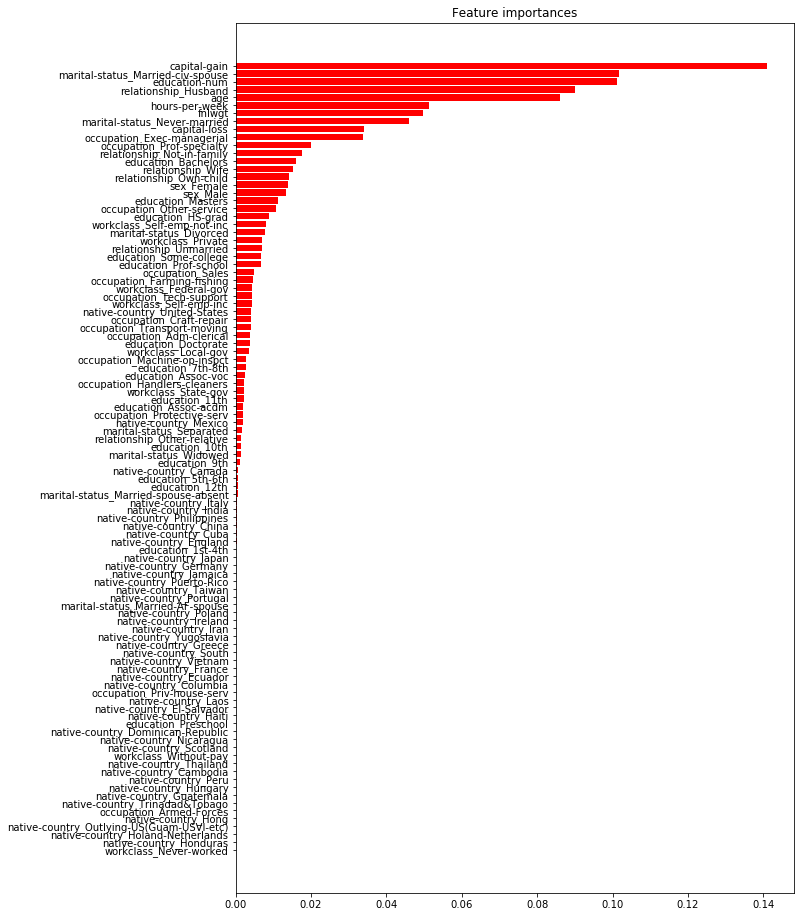

In [125]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(nopp_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

### Model: Extra Trees

In [32]:
## MODEL 1
params_et = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True
}
et = ExtraTreesClassifier(**params_et, random_state=0)

runL0Model(et, nopp_alltrain, y_alltrain, "stack1/nopp_et1.pkl", nopp_test)

Fold 0
Train set:
[[14045   803]
 [ 1783  2905]]
Accuracy = 0.86763, F1 = 0.69200
Validation set:
[[3500  212]
 [ 505  668]]
Accuracy = 0.85322, F1 = 0.65075

Fold 1
Train set:
[[14033   815]
 [ 1810  2879]]
Accuracy = 0.86564, F1 = 0.68687
Validation set:
[[3469  243]
 [ 499  673]]
Accuracy = 0.84808, F1 = 0.64464

Fold 2
Train set:
[[14056   792]
 [ 1789  2900]]
Accuracy = 0.86789, F1 = 0.69204
Validation set:
[[3473  239]
 [ 520  652]]
Accuracy = 0.84459, F1 = 0.63209

Fold 3
Train set:
[[14020   828]
 [ 1799  2890]]
Accuracy = 0.86554, F1 = 0.68752
Validation set:
[[3469  243]
 [ 497  675]]
Accuracy = 0.84848, F1 = 0.64593

Fold 4
Train set:
[[14000   848]
 [ 1801  2888]]
Accuracy = 0.86441, F1 = 0.68558
Validation set:
[[3437  275]
 [ 475  697]]
Accuracy = 0.84644, F1 = 0.65019

Consolidated validation folds:
Accuracy = 0.84816, F1 = 0.64476
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/nopp_et1.pkl


In [33]:
## MODEL 2: Handle class imbalance
params_et = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True,
    'class_weight': 'balanced_subsample'
}
et = ExtraTreesClassifier(**params_et, random_state=0)

runL0Model(et, nopp_alltrain, y_alltrain, "stack1/nopp_et2.pkl", nopp_test)

Fold 0
Train set:
[[11967  2881]
 [  493  4195]]
Accuracy = 0.82729, F1 = 0.71319
Validation set:
[[2990  722]
 [ 199  974]]
Accuracy = 0.81146, F1 = 0.67898

Fold 1
Train set:
[[11904  2944]
 [  476  4213]]
Accuracy = 0.82495, F1 = 0.71129
Validation set:
[[2938  774]
 [ 179  993]]
Accuracy = 0.80487, F1 = 0.67574

Fold 2
Train set:
[[11964  2884]
 [  496  4193]]
Accuracy = 0.82699, F1 = 0.71273
Validation set:
[[2926  786]
 [ 190  982]]
Accuracy = 0.80016, F1 = 0.66803

Fold 3
Train set:
[[12015  2833]
 [  505  4184]]
Accuracy = 0.82914, F1 = 0.71485
Validation set:
[[2938  774]
 [ 187  985]]
Accuracy = 0.80324, F1 = 0.67213

Fold 4
Train set:
[[12035  2813]
 [  497  4192]]
Accuracy = 0.83058, F1 = 0.71695
Validation set:
[[2926  786]
 [ 163 1009]]
Accuracy = 0.80569, F1 = 0.68015

Consolidated validation folds:
Accuracy = 0.80509, F1 = 0.67500
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/nopp_et2.pkl


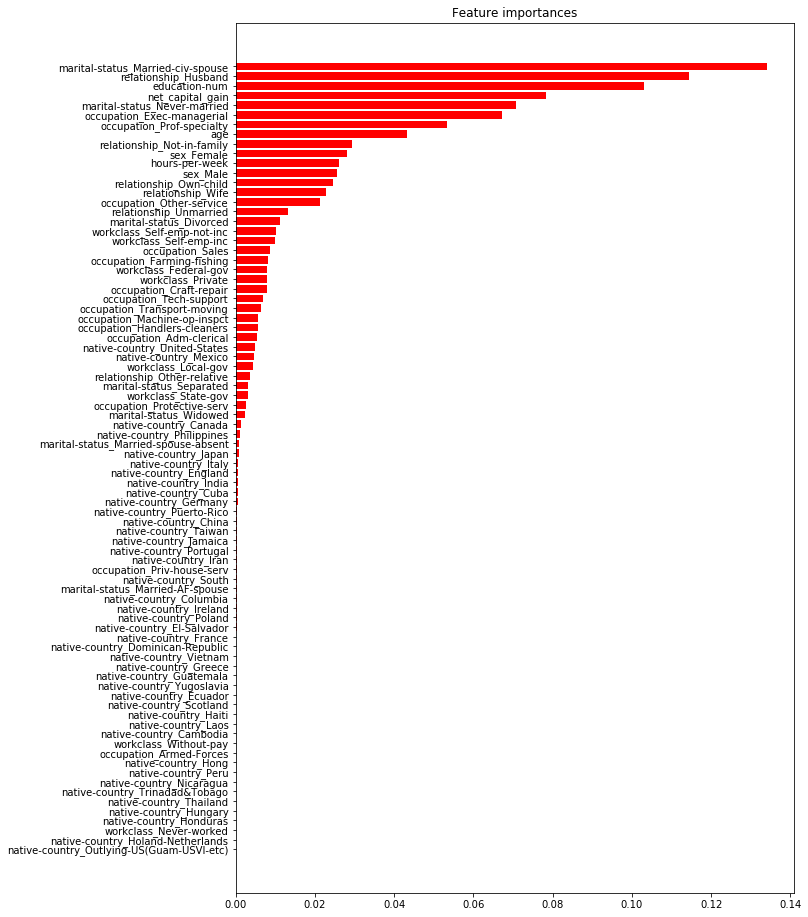

In [31]:
# ExtraTrees feature selection
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(X_train)

# for i in indices[:10]:
#     print("{}: {:.5f}".format(colnames[i], importances[i]))
    
# Plot the feature importances of the forest
fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
# plt.xlim([-1, X.shape[1]])
plt.show()

### Model: XGBoost

In [115]:
# IMPORT 1
TRAIN_RPATH = "dump/data/train_vld-nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_train, nopp_vld, y_train, y_vld = pkl.load(f)
    
TEST_RPATH = "dump/data/test-nopp.pkl"
with open(TEST_RPATH, "rb") as f:
    nopp_test = pkl.load(f)

print(nopp_train.shape)
print(y_train.shape)
print(nopp_vld.shape)
print(y_vld.shape)
print(nopp_test.shape)

(18315, 100)
(18315,)
(6106, 100)
(6106,)
(24421, 100)


In [37]:
### MODEL 1
params_xgb = {
    'booster': 'gbtree',
    'max_depth': 5,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'reg_alpha': 0.1,
    'reg_lambda': 100,
    'n_estimators': 10000
}
xgb = XGBClassifier(**params_xgb)

runL0Model(xgb, nopp_alltrain, y_alltrain, "stack1/nopp_xgb1.pkl",
           nopp_test, early_stopping=True)

Fold 0
[0]	validation_0-error:0.14104
[1]	validation_0-error:0.14104
[2]	validation_0-error:0.14104
[3]	validation_0-error:0.14104
[4]	validation_0-error:0.14104
[5]	validation_0-error:0.14104
[6]	validation_0-error:0.14104
[7]	validation_0-error:0.14104
[8]	validation_0-error:0.14104
[9]	validation_0-error:0.14104
[10]	validation_0-error:0.14125
[11]	validation_0-error:0.14125
[12]	validation_0-error:0.14411
[13]	validation_0-error:0.14411
[14]	validation_0-error:0.14411
[15]	validation_0-error:0.14227
[16]	validation_0-error:0.14207
[17]	validation_0-error:0.14391
[18]	validation_0-error:0.14391
[19]	validation_0-error:0.14391
[20]	validation_0-error:0.14350
[21]	validation_0-error:0.14330
[22]	validation_0-error:0.14370
[23]	validation_0-error:0.14350
[24]	validation_0-error:0.14330
[25]	validation_0-error:0.14330
[26]	validation_0-error:0.14350
[27]	validation_0-error:0.14289
[28]	validation_0-error:0.14330
[29]	validation_0-error:0.14330
[30]	validation_0-error:0.14330
[31]	valida

[252]	validation_0-error:0.13695
[253]	validation_0-error:0.13695
[254]	validation_0-error:0.13695
[255]	validation_0-error:0.13736
[256]	validation_0-error:0.13736
[257]	validation_0-error:0.13736
[258]	validation_0-error:0.13736
[259]	validation_0-error:0.13736
[260]	validation_0-error:0.13715
[261]	validation_0-error:0.13715
[262]	validation_0-error:0.13715
[263]	validation_0-error:0.13715
[264]	validation_0-error:0.13715
[265]	validation_0-error:0.13715
[266]	validation_0-error:0.13715
[267]	validation_0-error:0.13715
[268]	validation_0-error:0.13715
[269]	validation_0-error:0.13715
[270]	validation_0-error:0.13715
[271]	validation_0-error:0.13715
[272]	validation_0-error:0.13715
[273]	validation_0-error:0.13715
[274]	validation_0-error:0.13715
[275]	validation_0-error:0.13715
[276]	validation_0-error:0.13715
[277]	validation_0-error:0.13715
[278]	validation_0-error:0.13715
[279]	validation_0-error:0.13715
[280]	validation_0-error:0.13715
[281]	validation_0-error:0.13715
[282]	vali

[501]	validation_0-error:0.13470
[502]	validation_0-error:0.13470
[503]	validation_0-error:0.13470
[504]	validation_0-error:0.13429
[505]	validation_0-error:0.13429
[506]	validation_0-error:0.13490
[507]	validation_0-error:0.13490
[508]	validation_0-error:0.13490
[509]	validation_0-error:0.13490
[510]	validation_0-error:0.13470
[511]	validation_0-error:0.13490
[512]	validation_0-error:0.13470
[513]	validation_0-error:0.13449
[514]	validation_0-error:0.13449
[515]	validation_0-error:0.13449
[516]	validation_0-error:0.13470
[517]	validation_0-error:0.13449
[518]	validation_0-error:0.13449
[519]	validation_0-error:0.13429
[520]	validation_0-error:0.13449
[521]	validation_0-error:0.13429
[522]	validation_0-error:0.13408
[523]	validation_0-error:0.13408
[524]	validation_0-error:0.13408
[525]	validation_0-error:0.13408
[526]	validation_0-error:0.13408
[527]	validation_0-error:0.13388
[528]	validation_0-error:0.13388
[529]	validation_0-error:0.13408
[530]	validation_0-error:0.13408
[531]	vali

[750]	validation_0-error:0.13367
[751]	validation_0-error:0.13367
[752]	validation_0-error:0.13388
[753]	validation_0-error:0.13388
[754]	validation_0-error:0.13388
[755]	validation_0-error:0.13388
[756]	validation_0-error:0.13388
[757]	validation_0-error:0.13388
[758]	validation_0-error:0.13388
[759]	validation_0-error:0.13388
[760]	validation_0-error:0.13388
[761]	validation_0-error:0.13388
[762]	validation_0-error:0.13388
[763]	validation_0-error:0.13388
[764]	validation_0-error:0.13388
[765]	validation_0-error:0.13388
[766]	validation_0-error:0.13388
[767]	validation_0-error:0.13388
[768]	validation_0-error:0.13388
[769]	validation_0-error:0.13388
[770]	validation_0-error:0.13388
[771]	validation_0-error:0.13388
[772]	validation_0-error:0.13367
[773]	validation_0-error:0.13367
[774]	validation_0-error:0.13347
[775]	validation_0-error:0.13326
[776]	validation_0-error:0.13306
[777]	validation_0-error:0.13326
[778]	validation_0-error:0.13326
[779]	validation_0-error:0.13326
[780]	vali

[999]	validation_0-error:0.13204
[1000]	validation_0-error:0.13204
[1001]	validation_0-error:0.13204
[1002]	validation_0-error:0.13204
[1003]	validation_0-error:0.13204
[1004]	validation_0-error:0.13204
[1005]	validation_0-error:0.13204
[1006]	validation_0-error:0.13204
[1007]	validation_0-error:0.13204
[1008]	validation_0-error:0.13204
[1009]	validation_0-error:0.13204
[1010]	validation_0-error:0.13204
[1011]	validation_0-error:0.13204
[1012]	validation_0-error:0.13183
[1013]	validation_0-error:0.13204
[1014]	validation_0-error:0.13183
[1015]	validation_0-error:0.13183
[1016]	validation_0-error:0.13183
[1017]	validation_0-error:0.13183
[1018]	validation_0-error:0.13183
[1019]	validation_0-error:0.13183
[1020]	validation_0-error:0.13204
[1021]	validation_0-error:0.13204
[1022]	validation_0-error:0.13204
[1023]	validation_0-error:0.13204
[1024]	validation_0-error:0.13204
[1025]	validation_0-error:0.13204
[1026]	validation_0-error:0.13204
[1027]	validation_0-error:0.13204
[1028]	validati

[1240]	validation_0-error:0.13040
[1241]	validation_0-error:0.13040
[1242]	validation_0-error:0.13019
[1243]	validation_0-error:0.13019
[1244]	validation_0-error:0.13060
[1245]	validation_0-error:0.13040
[1246]	validation_0-error:0.13040
[1247]	validation_0-error:0.13040
[1248]	validation_0-error:0.13040
[1249]	validation_0-error:0.13040
[1250]	validation_0-error:0.13019
[1251]	validation_0-error:0.13019
[1252]	validation_0-error:0.13019
[1253]	validation_0-error:0.13019
[1254]	validation_0-error:0.13019
[1255]	validation_0-error:0.13019
[1256]	validation_0-error:0.13019
[1257]	validation_0-error:0.13019
[1258]	validation_0-error:0.13019
[1259]	validation_0-error:0.13019
[1260]	validation_0-error:0.13019
[1261]	validation_0-error:0.13040
[1262]	validation_0-error:0.13040
[1263]	validation_0-error:0.13040
[1264]	validation_0-error:0.13040
[1265]	validation_0-error:0.13040
[1266]	validation_0-error:0.13040
[1267]	validation_0-error:0.13040
[1268]	validation_0-error:0.13040
[1269]	validat

[1481]	validation_0-error:0.12917
[1482]	validation_0-error:0.12917
[1483]	validation_0-error:0.12938
[1484]	validation_0-error:0.12938
[1485]	validation_0-error:0.12938
[1486]	validation_0-error:0.12938
[1487]	validation_0-error:0.12938
[1488]	validation_0-error:0.12897
[1489]	validation_0-error:0.12917
[1490]	validation_0-error:0.12897
[1491]	validation_0-error:0.12917
[1492]	validation_0-error:0.12897
[1493]	validation_0-error:0.12897
[1494]	validation_0-error:0.12897
[1495]	validation_0-error:0.12876
[1496]	validation_0-error:0.12876
[1497]	validation_0-error:0.12897
[1498]	validation_0-error:0.12897
[1499]	validation_0-error:0.12897
[1500]	validation_0-error:0.12897
[1501]	validation_0-error:0.12897
[1502]	validation_0-error:0.12897
[1503]	validation_0-error:0.12897
[1504]	validation_0-error:0.12897
[1505]	validation_0-error:0.12897
[1506]	validation_0-error:0.12897
[1507]	validation_0-error:0.12897
[1508]	validation_0-error:0.12897
[1509]	validation_0-error:0.12897
[1510]	validat

[1722]	validation_0-error:0.12897
[1723]	validation_0-error:0.12897
[1724]	validation_0-error:0.12897
[1725]	validation_0-error:0.12897
[1726]	validation_0-error:0.12897
[1727]	validation_0-error:0.12897
[1728]	validation_0-error:0.12897
[1729]	validation_0-error:0.12897
[1730]	validation_0-error:0.12897
[1731]	validation_0-error:0.12897
[1732]	validation_0-error:0.12897
[1733]	validation_0-error:0.12897
[1734]	validation_0-error:0.12917
[1735]	validation_0-error:0.12917
[1736]	validation_0-error:0.12917
[1737]	validation_0-error:0.12938
[1738]	validation_0-error:0.12917
[1739]	validation_0-error:0.12917
[1740]	validation_0-error:0.12917
[1741]	validation_0-error:0.12917
[1742]	validation_0-error:0.12938
[1743]	validation_0-error:0.12938
[1744]	validation_0-error:0.12938
[1745]	validation_0-error:0.12917
[1746]	validation_0-error:0.12917
[1747]	validation_0-error:0.12917
[1748]	validation_0-error:0.12917
[1749]	validation_0-error:0.12917
[1750]	validation_0-error:0.12917
[1751]	validat

[1963]	validation_0-error:0.12958
[1964]	validation_0-error:0.12958
[1965]	validation_0-error:0.12958
[1966]	validation_0-error:0.12958
[1967]	validation_0-error:0.12958
[1968]	validation_0-error:0.12958
[1969]	validation_0-error:0.12958
[1970]	validation_0-error:0.12958
[1971]	validation_0-error:0.12958
[1972]	validation_0-error:0.12958
[1973]	validation_0-error:0.12958
[1974]	validation_0-error:0.12958
[1975]	validation_0-error:0.12958
[1976]	validation_0-error:0.12958
[1977]	validation_0-error:0.12958
[1978]	validation_0-error:0.12958
[1979]	validation_0-error:0.12958
[1980]	validation_0-error:0.12958
[1981]	validation_0-error:0.12958
[1982]	validation_0-error:0.12958
[1983]	validation_0-error:0.12958
[1984]	validation_0-error:0.12958
[1985]	validation_0-error:0.12958
[1986]	validation_0-error:0.12958
[1987]	validation_0-error:0.12958
[1988]	validation_0-error:0.12958
[1989]	validation_0-error:0.12958
[1990]	validation_0-error:0.12958
[1991]	validation_0-error:0.12958
[1992]	validat

[2204]	validation_0-error:0.12897
[2205]	validation_0-error:0.12897
[2206]	validation_0-error:0.12897
[2207]	validation_0-error:0.12897
[2208]	validation_0-error:0.12897
[2209]	validation_0-error:0.12897
[2210]	validation_0-error:0.12897
[2211]	validation_0-error:0.12897
[2212]	validation_0-error:0.12917
[2213]	validation_0-error:0.12917
[2214]	validation_0-error:0.12897
[2215]	validation_0-error:0.12897
[2216]	validation_0-error:0.12897
[2217]	validation_0-error:0.12897
[2218]	validation_0-error:0.12897
[2219]	validation_0-error:0.12897
[2220]	validation_0-error:0.12897
[2221]	validation_0-error:0.12897
[2222]	validation_0-error:0.12897
[2223]	validation_0-error:0.12897
[2224]	validation_0-error:0.12897
[2225]	validation_0-error:0.12897
[2226]	validation_0-error:0.12917
[2227]	validation_0-error:0.12917
[2228]	validation_0-error:0.12917
[2229]	validation_0-error:0.12917
[2230]	validation_0-error:0.12897
[2231]	validation_0-error:0.12917
[2232]	validation_0-error:0.12917
[2233]	validat

[2445]	validation_0-error:0.12815
[2446]	validation_0-error:0.12815
[2447]	validation_0-error:0.12815
[2448]	validation_0-error:0.12815
[2449]	validation_0-error:0.12835
[2450]	validation_0-error:0.12835
[2451]	validation_0-error:0.12835
[2452]	validation_0-error:0.12835
[2453]	validation_0-error:0.12815
[2454]	validation_0-error:0.12835
[2455]	validation_0-error:0.12815
[2456]	validation_0-error:0.12815
[2457]	validation_0-error:0.12815
[2458]	validation_0-error:0.12815
[2459]	validation_0-error:0.12815
[2460]	validation_0-error:0.12815
[2461]	validation_0-error:0.12815
[2462]	validation_0-error:0.12815
[2463]	validation_0-error:0.12815
[2464]	validation_0-error:0.12815
[2465]	validation_0-error:0.12815
[2466]	validation_0-error:0.12815
[2467]	validation_0-error:0.12835
[2468]	validation_0-error:0.12815
[2469]	validation_0-error:0.12835
[2470]	validation_0-error:0.12835
[2471]	validation_0-error:0.12835
[2472]	validation_0-error:0.12815
[2473]	validation_0-error:0.12815
[2474]	validat

[2686]	validation_0-error:0.12835
[2687]	validation_0-error:0.12815
[2688]	validation_0-error:0.12835
[2689]	validation_0-error:0.12835
[2690]	validation_0-error:0.12815
[2691]	validation_0-error:0.12815
[2692]	validation_0-error:0.12815
[2693]	validation_0-error:0.12835
[2694]	validation_0-error:0.12835
[2695]	validation_0-error:0.12835
[2696]	validation_0-error:0.12835
[2697]	validation_0-error:0.12835
[2698]	validation_0-error:0.12835
[2699]	validation_0-error:0.12835
[2700]	validation_0-error:0.12835
[2701]	validation_0-error:0.12835
[2702]	validation_0-error:0.12835
[2703]	validation_0-error:0.12835
[2704]	validation_0-error:0.12835
[2705]	validation_0-error:0.12835
[2706]	validation_0-error:0.12815
[2707]	validation_0-error:0.12815
[2708]	validation_0-error:0.12815
[2709]	validation_0-error:0.12815
[2710]	validation_0-error:0.12815
[2711]	validation_0-error:0.12815
[2712]	validation_0-error:0.12815
[2713]	validation_0-error:0.12815
[2714]	validation_0-error:0.12815
[2715]	validat

[2927]	validation_0-error:0.12774
[2928]	validation_0-error:0.12794
[2929]	validation_0-error:0.12774
[2930]	validation_0-error:0.12774
[2931]	validation_0-error:0.12774
[2932]	validation_0-error:0.12774
[2933]	validation_0-error:0.12774
[2934]	validation_0-error:0.12774
[2935]	validation_0-error:0.12774
[2936]	validation_0-error:0.12774
[2937]	validation_0-error:0.12794
[2938]	validation_0-error:0.12794
[2939]	validation_0-error:0.12794
[2940]	validation_0-error:0.12794
[2941]	validation_0-error:0.12794
[2942]	validation_0-error:0.12794
[2943]	validation_0-error:0.12794
[2944]	validation_0-error:0.12794
[2945]	validation_0-error:0.12794
[2946]	validation_0-error:0.12794
[2947]	validation_0-error:0.12794
[2948]	validation_0-error:0.12794
[2949]	validation_0-error:0.12815
[2950]	validation_0-error:0.12815
[2951]	validation_0-error:0.12794
[2952]	validation_0-error:0.12794
[2953]	validation_0-error:0.12794
[2954]	validation_0-error:0.12794
[2955]	validation_0-error:0.12794
[2956]	validat

[3168]	validation_0-error:0.12815
[3169]	validation_0-error:0.12815
[3170]	validation_0-error:0.12815
[3171]	validation_0-error:0.12815
[3172]	validation_0-error:0.12815
[3173]	validation_0-error:0.12815
[3174]	validation_0-error:0.12815
[3175]	validation_0-error:0.12815
[3176]	validation_0-error:0.12815
[3177]	validation_0-error:0.12815
[3178]	validation_0-error:0.12815
[3179]	validation_0-error:0.12815
[3180]	validation_0-error:0.12815
[3181]	validation_0-error:0.12815
[3182]	validation_0-error:0.12815
[3183]	validation_0-error:0.12815
[3184]	validation_0-error:0.12815
[3185]	validation_0-error:0.12815
[3186]	validation_0-error:0.12815
[3187]	validation_0-error:0.12815
[3188]	validation_0-error:0.12815
[3189]	validation_0-error:0.12815
[3190]	validation_0-error:0.12815
[3191]	validation_0-error:0.12794
[3192]	validation_0-error:0.12794
[3193]	validation_0-error:0.12794
[3194]	validation_0-error:0.12794
[3195]	validation_0-error:0.12794
[3196]	validation_0-error:0.12794
[3197]	validat

[3409]	validation_0-error:0.12712
[3410]	validation_0-error:0.12712
[3411]	validation_0-error:0.12692
[3412]	validation_0-error:0.12712
[3413]	validation_0-error:0.12712
[3414]	validation_0-error:0.12712
[3415]	validation_0-error:0.12712
[3416]	validation_0-error:0.12712
[3417]	validation_0-error:0.12712
[3418]	validation_0-error:0.12712
[3419]	validation_0-error:0.12712
[3420]	validation_0-error:0.12712
[3421]	validation_0-error:0.12712
[3422]	validation_0-error:0.12712
[3423]	validation_0-error:0.12692
[3424]	validation_0-error:0.12712
[3425]	validation_0-error:0.12712
[3426]	validation_0-error:0.12733
[3427]	validation_0-error:0.12733
[3428]	validation_0-error:0.12733
[3429]	validation_0-error:0.12733
[3430]	validation_0-error:0.12733
[3431]	validation_0-error:0.12733
[3432]	validation_0-error:0.12733
[3433]	validation_0-error:0.12733
[3434]	validation_0-error:0.12733
[3435]	validation_0-error:0.12733
[3436]	validation_0-error:0.12733
[3437]	validation_0-error:0.12712
[3438]	validat

[3650]	validation_0-error:0.12651
[3651]	validation_0-error:0.12651
[3652]	validation_0-error:0.12651
[3653]	validation_0-error:0.12651
[3654]	validation_0-error:0.12651
[3655]	validation_0-error:0.12651
[3656]	validation_0-error:0.12631
[3657]	validation_0-error:0.12631
[3658]	validation_0-error:0.12631
[3659]	validation_0-error:0.12631
[3660]	validation_0-error:0.12651
[3661]	validation_0-error:0.12651
[3662]	validation_0-error:0.12651
[3663]	validation_0-error:0.12651
[3664]	validation_0-error:0.12651
[3665]	validation_0-error:0.12651
[3666]	validation_0-error:0.12651
[3667]	validation_0-error:0.12651
[3668]	validation_0-error:0.12651
[3669]	validation_0-error:0.12651
[3670]	validation_0-error:0.12651
[3671]	validation_0-error:0.12651
[3672]	validation_0-error:0.12651
[3673]	validation_0-error:0.12651
[3674]	validation_0-error:0.12651
[3675]	validation_0-error:0.12651
[3676]	validation_0-error:0.12651
[3677]	validation_0-error:0.12651
[3678]	validation_0-error:0.12651
[3679]	validat

[3891]	validation_0-error:0.12528
[3892]	validation_0-error:0.12528
[3893]	validation_0-error:0.12528
[3894]	validation_0-error:0.12528
[3895]	validation_0-error:0.12528
[3896]	validation_0-error:0.12549
[3897]	validation_0-error:0.12549
[3898]	validation_0-error:0.12549
[3899]	validation_0-error:0.12549
[3900]	validation_0-error:0.12528
[3901]	validation_0-error:0.12528
[3902]	validation_0-error:0.12528
[3903]	validation_0-error:0.12528
[3904]	validation_0-error:0.12528
[3905]	validation_0-error:0.12528
[3906]	validation_0-error:0.12528
[3907]	validation_0-error:0.12528
[3908]	validation_0-error:0.12528
[3909]	validation_0-error:0.12528
[3910]	validation_0-error:0.12528
[3911]	validation_0-error:0.12528
[3912]	validation_0-error:0.12528
[3913]	validation_0-error:0.12528
[3914]	validation_0-error:0.12528
[3915]	validation_0-error:0.12528
[3916]	validation_0-error:0.12528
[3917]	validation_0-error:0.12528
[3918]	validation_0-error:0.12528
[3919]	validation_0-error:0.12528
[3920]	validat

[4132]	validation_0-error:0.12487
[4133]	validation_0-error:0.12487
[4134]	validation_0-error:0.12487
[4135]	validation_0-error:0.12487
[4136]	validation_0-error:0.12487
[4137]	validation_0-error:0.12487
[4138]	validation_0-error:0.12487
[4139]	validation_0-error:0.12487
[4140]	validation_0-error:0.12487
[4141]	validation_0-error:0.12487
[4142]	validation_0-error:0.12487
[4143]	validation_0-error:0.12487
[4144]	validation_0-error:0.12487
[4145]	validation_0-error:0.12487
[4146]	validation_0-error:0.12487
[4147]	validation_0-error:0.12487
[4148]	validation_0-error:0.12487
[4149]	validation_0-error:0.12487
[4150]	validation_0-error:0.12487
[4151]	validation_0-error:0.12487
[4152]	validation_0-error:0.12487
[4153]	validation_0-error:0.12487
[4154]	validation_0-error:0.12487
[4155]	validation_0-error:0.12487
[4156]	validation_0-error:0.12487
[4157]	validation_0-error:0.12487
[4158]	validation_0-error:0.12487
[4159]	validation_0-error:0.12487
[4160]	validation_0-error:0.12487
[4161]	validat

[4373]	validation_0-error:0.12385
[4374]	validation_0-error:0.12385
[4375]	validation_0-error:0.12385
[4376]	validation_0-error:0.12385
[4377]	validation_0-error:0.12385
[4378]	validation_0-error:0.12405
[4379]	validation_0-error:0.12405
[4380]	validation_0-error:0.12385
[4381]	validation_0-error:0.12385
[4382]	validation_0-error:0.12405
[4383]	validation_0-error:0.12405
[4384]	validation_0-error:0.12405
[4385]	validation_0-error:0.12405
[4386]	validation_0-error:0.12405
[4387]	validation_0-error:0.12405
[4388]	validation_0-error:0.12405
[4389]	validation_0-error:0.12405
[4390]	validation_0-error:0.12405
[4391]	validation_0-error:0.12405
[4392]	validation_0-error:0.12405
[4393]	validation_0-error:0.12405
[4394]	validation_0-error:0.12405
[4395]	validation_0-error:0.12405
[4396]	validation_0-error:0.12405
[4397]	validation_0-error:0.12426
[4398]	validation_0-error:0.12426
[4399]	validation_0-error:0.12426
[4400]	validation_0-error:0.12426
[4401]	validation_0-error:0.12405
[4402]	validat

[4614]	validation_0-error:0.12323
[4615]	validation_0-error:0.12323
[4616]	validation_0-error:0.12323
[4617]	validation_0-error:0.12323
[4618]	validation_0-error:0.12323
[4619]	validation_0-error:0.12323
[4620]	validation_0-error:0.12323
[4621]	validation_0-error:0.12323
[4622]	validation_0-error:0.12323
[4623]	validation_0-error:0.12323
[4624]	validation_0-error:0.12323
[4625]	validation_0-error:0.12344
[4626]	validation_0-error:0.12344
[4627]	validation_0-error:0.12344
[4628]	validation_0-error:0.12344
[4629]	validation_0-error:0.12344
[4630]	validation_0-error:0.12344
[4631]	validation_0-error:0.12344
[4632]	validation_0-error:0.12344
[4633]	validation_0-error:0.12344
[4634]	validation_0-error:0.12344
[4635]	validation_0-error:0.12344
[4636]	validation_0-error:0.12344
[4637]	validation_0-error:0.12344
[4638]	validation_0-error:0.12344
[4639]	validation_0-error:0.12344
[4640]	validation_0-error:0.12344
[4641]	validation_0-error:0.12344
[4642]	validation_0-error:0.12344
[4643]	validat

[4855]	validation_0-error:0.12283
[4856]	validation_0-error:0.12283
[4857]	validation_0-error:0.12283
[4858]	validation_0-error:0.12283
[4859]	validation_0-error:0.12283
[4860]	validation_0-error:0.12283
[4861]	validation_0-error:0.12283
[4862]	validation_0-error:0.12283
[4863]	validation_0-error:0.12283
[4864]	validation_0-error:0.12283
[4865]	validation_0-error:0.12283
[4866]	validation_0-error:0.12283
[4867]	validation_0-error:0.12283
[4868]	validation_0-error:0.12283
[4869]	validation_0-error:0.12283
[4870]	validation_0-error:0.12283
[4871]	validation_0-error:0.12283
[4872]	validation_0-error:0.12283
[4873]	validation_0-error:0.12283
[4874]	validation_0-error:0.12283
[4875]	validation_0-error:0.12283
[4876]	validation_0-error:0.12283
[4877]	validation_0-error:0.12283
[4878]	validation_0-error:0.12283
[4879]	validation_0-error:0.12262
[4880]	validation_0-error:0.12262
[4881]	validation_0-error:0.12262
[4882]	validation_0-error:0.12262
[4883]	validation_0-error:0.12262
[4884]	validat

[5096]	validation_0-error:0.12242
[5097]	validation_0-error:0.12242
[5098]	validation_0-error:0.12262
[5099]	validation_0-error:0.12262
[5100]	validation_0-error:0.12303
[5101]	validation_0-error:0.12303
[5102]	validation_0-error:0.12303
[5103]	validation_0-error:0.12303
[5104]	validation_0-error:0.12303
[5105]	validation_0-error:0.12303
[5106]	validation_0-error:0.12303
[5107]	validation_0-error:0.12303
[5108]	validation_0-error:0.12303
[5109]	validation_0-error:0.12303
[5110]	validation_0-error:0.12303
[5111]	validation_0-error:0.12283
[5112]	validation_0-error:0.12303
[5113]	validation_0-error:0.12303
[5114]	validation_0-error:0.12303
[5115]	validation_0-error:0.12303
[5116]	validation_0-error:0.12303
[5117]	validation_0-error:0.12303
[5118]	validation_0-error:0.12303
[5119]	validation_0-error:0.12283
[5120]	validation_0-error:0.12303
[5121]	validation_0-error:0.12303
[5122]	validation_0-error:0.12303
[5123]	validation_0-error:0.12323
[5124]	validation_0-error:0.12323
[5125]	validat

[5337]	validation_0-error:0.12283
[5338]	validation_0-error:0.12283
[5339]	validation_0-error:0.12283
[5340]	validation_0-error:0.12283
[5341]	validation_0-error:0.12303
[5342]	validation_0-error:0.12303
[5343]	validation_0-error:0.12303
[5344]	validation_0-error:0.12303
[5345]	validation_0-error:0.12303
[5346]	validation_0-error:0.12303
[5347]	validation_0-error:0.12303
[5348]	validation_0-error:0.12303
[5349]	validation_0-error:0.12303
[5350]	validation_0-error:0.12303
[5351]	validation_0-error:0.12303
[5352]	validation_0-error:0.12303
[5353]	validation_0-error:0.12303
[5354]	validation_0-error:0.12303
[5355]	validation_0-error:0.12303
[5356]	validation_0-error:0.12303
[5357]	validation_0-error:0.12303
[5358]	validation_0-error:0.12303
[5359]	validation_0-error:0.12303
[5360]	validation_0-error:0.12303
[5361]	validation_0-error:0.12303
[5362]	validation_0-error:0.12303
[5363]	validation_0-error:0.12303
[5364]	validation_0-error:0.12303
[5365]	validation_0-error:0.12303
[5366]	validat

[5578]	validation_0-error:0.12323
[5579]	validation_0-error:0.12323
[5580]	validation_0-error:0.12323
[5581]	validation_0-error:0.12323
[5582]	validation_0-error:0.12323
[5583]	validation_0-error:0.12323
[5584]	validation_0-error:0.12323
[5585]	validation_0-error:0.12323
[5586]	validation_0-error:0.12323
[5587]	validation_0-error:0.12323
[5588]	validation_0-error:0.12323
[5589]	validation_0-error:0.12323
[5590]	validation_0-error:0.12323
[5591]	validation_0-error:0.12323
[5592]	validation_0-error:0.12323
[5593]	validation_0-error:0.12323
[5594]	validation_0-error:0.12323
[5595]	validation_0-error:0.12323
[5596]	validation_0-error:0.12323
[5597]	validation_0-error:0.12344
[5598]	validation_0-error:0.12344
[5599]	validation_0-error:0.12344
[5600]	validation_0-error:0.12344
[5601]	validation_0-error:0.12344
[5602]	validation_0-error:0.12344
[5603]	validation_0-error:0.12344
[5604]	validation_0-error:0.12344
[5605]	validation_0-error:0.12344
[5606]	validation_0-error:0.12344
[5607]	validat

[5819]	validation_0-error:0.12262
[5820]	validation_0-error:0.12262
[5821]	validation_0-error:0.12262
[5822]	validation_0-error:0.12262
[5823]	validation_0-error:0.12262
[5824]	validation_0-error:0.12262
[5825]	validation_0-error:0.12262
[5826]	validation_0-error:0.12262
[5827]	validation_0-error:0.12262
[5828]	validation_0-error:0.12262
[5829]	validation_0-error:0.12262
[5830]	validation_0-error:0.12262
[5831]	validation_0-error:0.12262
[5832]	validation_0-error:0.12262
[5833]	validation_0-error:0.12262
[5834]	validation_0-error:0.12262
[5835]	validation_0-error:0.12262
[5836]	validation_0-error:0.12262
[5837]	validation_0-error:0.12262
[5838]	validation_0-error:0.12262
[5839]	validation_0-error:0.12262
[5840]	validation_0-error:0.12262
[5841]	validation_0-error:0.12262
[5842]	validation_0-error:0.12262
[5843]	validation_0-error:0.12262
[5844]	validation_0-error:0.12262
[5845]	validation_0-error:0.12262
[5846]	validation_0-error:0.12262
[5847]	validation_0-error:0.12262
[5848]	validat

[6060]	validation_0-error:0.12262
[6061]	validation_0-error:0.12262
[6062]	validation_0-error:0.12262
[6063]	validation_0-error:0.12262
[6064]	validation_0-error:0.12262
[6065]	validation_0-error:0.12262
[6066]	validation_0-error:0.12262
[6067]	validation_0-error:0.12262
[6068]	validation_0-error:0.12262
[6069]	validation_0-error:0.12262
[6070]	validation_0-error:0.12262
[6071]	validation_0-error:0.12262
[6072]	validation_0-error:0.12262
[6073]	validation_0-error:0.12262
[6074]	validation_0-error:0.12262
[6075]	validation_0-error:0.12262
[6076]	validation_0-error:0.12283
[6077]	validation_0-error:0.12283
[6078]	validation_0-error:0.12283
[6079]	validation_0-error:0.12283
[6080]	validation_0-error:0.12283
[6081]	validation_0-error:0.12283
[6082]	validation_0-error:0.12283
[6083]	validation_0-error:0.12283
[6084]	validation_0-error:0.12283
[6085]	validation_0-error:0.12283
[6086]	validation_0-error:0.12283
[6087]	validation_0-error:0.12283
[6088]	validation_0-error:0.12283
[6089]	validat

[6301]	validation_0-error:0.12323
[6302]	validation_0-error:0.12323
[6303]	validation_0-error:0.12323
[6304]	validation_0-error:0.12323
[6305]	validation_0-error:0.12323
[6306]	validation_0-error:0.12323
[6307]	validation_0-error:0.12323
[6308]	validation_0-error:0.12323
[6309]	validation_0-error:0.12323
[6310]	validation_0-error:0.12323
[6311]	validation_0-error:0.12323
[6312]	validation_0-error:0.12323
[6313]	validation_0-error:0.12323
[6314]	validation_0-error:0.12323
[6315]	validation_0-error:0.12323
[6316]	validation_0-error:0.12323
[6317]	validation_0-error:0.12323
[6318]	validation_0-error:0.12323
[6319]	validation_0-error:0.12323
[6320]	validation_0-error:0.12323
[6321]	validation_0-error:0.12303
[6322]	validation_0-error:0.12303
[6323]	validation_0-error:0.12303
[6324]	validation_0-error:0.12303
[6325]	validation_0-error:0.12303
[6326]	validation_0-error:0.12303
[6327]	validation_0-error:0.12303
[6328]	validation_0-error:0.12303
[6329]	validation_0-error:0.12303
[6330]	validat

[6542]	validation_0-error:0.12344
[6543]	validation_0-error:0.12344
[6544]	validation_0-error:0.12344
[6545]	validation_0-error:0.12344
[6546]	validation_0-error:0.12344
[6547]	validation_0-error:0.12323
[6548]	validation_0-error:0.12344
[6549]	validation_0-error:0.12323
[6550]	validation_0-error:0.12323
[6551]	validation_0-error:0.12323
[6552]	validation_0-error:0.12323
[6553]	validation_0-error:0.12323
[6554]	validation_0-error:0.12323
[6555]	validation_0-error:0.12323
[6556]	validation_0-error:0.12323
[6557]	validation_0-error:0.12323
[6558]	validation_0-error:0.12323
[6559]	validation_0-error:0.12323
[6560]	validation_0-error:0.12323
[6561]	validation_0-error:0.12323
[6562]	validation_0-error:0.12323
[6563]	validation_0-error:0.12323
[6564]	validation_0-error:0.12323
[6565]	validation_0-error:0.12323
[6566]	validation_0-error:0.12323
[6567]	validation_0-error:0.12323
[6568]	validation_0-error:0.12323
[6569]	validation_0-error:0.12323
[6570]	validation_0-error:0.12323
[6571]	validat

[6783]	validation_0-error:0.12303
[6784]	validation_0-error:0.12303
[6785]	validation_0-error:0.12303
[6786]	validation_0-error:0.12303
[6787]	validation_0-error:0.12303
[6788]	validation_0-error:0.12303
[6789]	validation_0-error:0.12303
[6790]	validation_0-error:0.12303
[6791]	validation_0-error:0.12303
[6792]	validation_0-error:0.12303
[6793]	validation_0-error:0.12303
[6794]	validation_0-error:0.12303
[6795]	validation_0-error:0.12303
[6796]	validation_0-error:0.12303
[6797]	validation_0-error:0.12303
[6798]	validation_0-error:0.12303
[6799]	validation_0-error:0.12303
[6800]	validation_0-error:0.12303
[6801]	validation_0-error:0.12303
[6802]	validation_0-error:0.12303
[6803]	validation_0-error:0.12303
[6804]	validation_0-error:0.12303
[6805]	validation_0-error:0.12303
[6806]	validation_0-error:0.12303
[6807]	validation_0-error:0.12303
[6808]	validation_0-error:0.12303
[6809]	validation_0-error:0.12303
[6810]	validation_0-error:0.12303
[6811]	validation_0-error:0.12303
[6812]	validat

[7024]	validation_0-error:0.12344
[7025]	validation_0-error:0.12344
[7026]	validation_0-error:0.12344
[7027]	validation_0-error:0.12344
[7028]	validation_0-error:0.12344
[7029]	validation_0-error:0.12344
[7030]	validation_0-error:0.12344
[7031]	validation_0-error:0.12344
[7032]	validation_0-error:0.12344
[7033]	validation_0-error:0.12344
[7034]	validation_0-error:0.12344
[7035]	validation_0-error:0.12344
[7036]	validation_0-error:0.12344
[7037]	validation_0-error:0.12344
[7038]	validation_0-error:0.12344
[7039]	validation_0-error:0.12344
[7040]	validation_0-error:0.12344
[7041]	validation_0-error:0.12344
[7042]	validation_0-error:0.12344
[7043]	validation_0-error:0.12344
[7044]	validation_0-error:0.12344
[7045]	validation_0-error:0.12344
[7046]	validation_0-error:0.12344
[7047]	validation_0-error:0.12344
[7048]	validation_0-error:0.12344
[7049]	validation_0-error:0.12344
[7050]	validation_0-error:0.12344
[7051]	validation_0-error:0.12344
[7052]	validation_0-error:0.12344
[7053]	validat

[7265]	validation_0-error:0.12262
[7266]	validation_0-error:0.12262
[7267]	validation_0-error:0.12262
[7268]	validation_0-error:0.12262
[7269]	validation_0-error:0.12262
[7270]	validation_0-error:0.12262
[7271]	validation_0-error:0.12262
[7272]	validation_0-error:0.12262
[7273]	validation_0-error:0.12262
[7274]	validation_0-error:0.12262
[7275]	validation_0-error:0.12262
[7276]	validation_0-error:0.12262
[7277]	validation_0-error:0.12262
[7278]	validation_0-error:0.12262
[7279]	validation_0-error:0.12262
[7280]	validation_0-error:0.12262
[7281]	validation_0-error:0.12262
[7282]	validation_0-error:0.12262
[7283]	validation_0-error:0.12262
[7284]	validation_0-error:0.12262
[7285]	validation_0-error:0.12262
[7286]	validation_0-error:0.12262
[7287]	validation_0-error:0.12262
[7288]	validation_0-error:0.12262
[7289]	validation_0-error:0.12262
[7290]	validation_0-error:0.12262
[7291]	validation_0-error:0.12262
[7292]	validation_0-error:0.12262
[7293]	validation_0-error:0.12262
[7294]	validat

[7506]	validation_0-error:0.12221
[7507]	validation_0-error:0.12221
[7508]	validation_0-error:0.12221
[7509]	validation_0-error:0.12221
[7510]	validation_0-error:0.12221
[7511]	validation_0-error:0.12221
[7512]	validation_0-error:0.12221
[7513]	validation_0-error:0.12221
[7514]	validation_0-error:0.12221
[7515]	validation_0-error:0.12221
[7516]	validation_0-error:0.12221
[7517]	validation_0-error:0.12221
[7518]	validation_0-error:0.12221
[7519]	validation_0-error:0.12221
[7520]	validation_0-error:0.12221
[7521]	validation_0-error:0.12221
[7522]	validation_0-error:0.12221
[7523]	validation_0-error:0.12221
[7524]	validation_0-error:0.12221
[7525]	validation_0-error:0.12221
[7526]	validation_0-error:0.12221
[7527]	validation_0-error:0.12221
[7528]	validation_0-error:0.12221
[7529]	validation_0-error:0.12221
[7530]	validation_0-error:0.12221
[7531]	validation_0-error:0.12221
[7532]	validation_0-error:0.12221
[7533]	validation_0-error:0.12221
[7534]	validation_0-error:0.12221
[7535]	validat

[7747]	validation_0-error:0.12160
[7748]	validation_0-error:0.12160
[7749]	validation_0-error:0.12160
[7750]	validation_0-error:0.12139
[7751]	validation_0-error:0.12139
[7752]	validation_0-error:0.12160
[7753]	validation_0-error:0.12160
[7754]	validation_0-error:0.12139
[7755]	validation_0-error:0.12139
[7756]	validation_0-error:0.12139
[7757]	validation_0-error:0.12139
[7758]	validation_0-error:0.12139
[7759]	validation_0-error:0.12139
[7760]	validation_0-error:0.12139
[7761]	validation_0-error:0.12139
[7762]	validation_0-error:0.12139
[7763]	validation_0-error:0.12139
[7764]	validation_0-error:0.12139
[7765]	validation_0-error:0.12139
[7766]	validation_0-error:0.12139
[7767]	validation_0-error:0.12139
[7768]	validation_0-error:0.12139
[7769]	validation_0-error:0.12139
[7770]	validation_0-error:0.12139
[7771]	validation_0-error:0.12139
[7772]	validation_0-error:0.12139
[7773]	validation_0-error:0.12139
[7774]	validation_0-error:0.12139
[7775]	validation_0-error:0.12139
[7776]	validat

[7988]	validation_0-error:0.12119
[7989]	validation_0-error:0.12119
[7990]	validation_0-error:0.12119
[7991]	validation_0-error:0.12119
[7992]	validation_0-error:0.12119
[7993]	validation_0-error:0.12119
[7994]	validation_0-error:0.12119
[7995]	validation_0-error:0.12119
[7996]	validation_0-error:0.12119
[7997]	validation_0-error:0.12119
[7998]	validation_0-error:0.12119
[7999]	validation_0-error:0.12119
[8000]	validation_0-error:0.12119
[8001]	validation_0-error:0.12119
[8002]	validation_0-error:0.12119
[8003]	validation_0-error:0.12119
[8004]	validation_0-error:0.12119
[8005]	validation_0-error:0.12119
[8006]	validation_0-error:0.12119
[8007]	validation_0-error:0.12119
[8008]	validation_0-error:0.12119
[8009]	validation_0-error:0.12119
[8010]	validation_0-error:0.12119
[8011]	validation_0-error:0.12119
[8012]	validation_0-error:0.12119
[8013]	validation_0-error:0.12119
[8014]	validation_0-error:0.12119
[8015]	validation_0-error:0.12119
[8016]	validation_0-error:0.12119
[8017]	validat

[8229]	validation_0-error:0.12098
[8230]	validation_0-error:0.12098
[8231]	validation_0-error:0.12098
[8232]	validation_0-error:0.12098
[8233]	validation_0-error:0.12098
[8234]	validation_0-error:0.12098
[8235]	validation_0-error:0.12078
[8236]	validation_0-error:0.12078
[8237]	validation_0-error:0.12078
[8238]	validation_0-error:0.12078
[8239]	validation_0-error:0.12078
[8240]	validation_0-error:0.12078
[8241]	validation_0-error:0.12078
[8242]	validation_0-error:0.12078
[8243]	validation_0-error:0.12078
[8244]	validation_0-error:0.12078
[8245]	validation_0-error:0.12078
[8246]	validation_0-error:0.12078
[8247]	validation_0-error:0.12078
[8248]	validation_0-error:0.12078
[8249]	validation_0-error:0.12078
[8250]	validation_0-error:0.12078
[8251]	validation_0-error:0.12078
[8252]	validation_0-error:0.12078
[8253]	validation_0-error:0.12078
[8254]	validation_0-error:0.12078
[8255]	validation_0-error:0.12078
[8256]	validation_0-error:0.12078
[8257]	validation_0-error:0.12078
[8258]	validat

[8470]	validation_0-error:0.12078
[8471]	validation_0-error:0.12078
[8472]	validation_0-error:0.12078
[8473]	validation_0-error:0.12078
[8474]	validation_0-error:0.12078
[8475]	validation_0-error:0.12078
[8476]	validation_0-error:0.12078
[8477]	validation_0-error:0.12078
[8478]	validation_0-error:0.12078
[8479]	validation_0-error:0.12078
[8480]	validation_0-error:0.12078
[8481]	validation_0-error:0.12078
[8482]	validation_0-error:0.12078
[8483]	validation_0-error:0.12078
[8484]	validation_0-error:0.12078
[8485]	validation_0-error:0.12078
[8486]	validation_0-error:0.12078
[8487]	validation_0-error:0.12078
[8488]	validation_0-error:0.12078
[8489]	validation_0-error:0.12078
[8490]	validation_0-error:0.12078
[8491]	validation_0-error:0.12078
[8492]	validation_0-error:0.12078
[8493]	validation_0-error:0.12078
[8494]	validation_0-error:0.12078
[8495]	validation_0-error:0.12078
[8496]	validation_0-error:0.12078
[8497]	validation_0-error:0.12078
[8498]	validation_0-error:0.12078
[8499]	validat

[8711]	validation_0-error:0.12078
[8712]	validation_0-error:0.12078
[8713]	validation_0-error:0.12078
[8714]	validation_0-error:0.12078
[8715]	validation_0-error:0.12078
[8716]	validation_0-error:0.12078
[8717]	validation_0-error:0.12078
[8718]	validation_0-error:0.12078
[8719]	validation_0-error:0.12078
[8720]	validation_0-error:0.12078
[8721]	validation_0-error:0.12078
[8722]	validation_0-error:0.12078
[8723]	validation_0-error:0.12078
[8724]	validation_0-error:0.12078
[8725]	validation_0-error:0.12078
[8726]	validation_0-error:0.12078
[8727]	validation_0-error:0.12078
[8728]	validation_0-error:0.12078
[8729]	validation_0-error:0.12078
[8730]	validation_0-error:0.12078
[8731]	validation_0-error:0.12078
[8732]	validation_0-error:0.12078
[8733]	validation_0-error:0.12078
[8734]	validation_0-error:0.12078
[8735]	validation_0-error:0.12078
[8736]	validation_0-error:0.12078
[8737]	validation_0-error:0.12078
[8738]	validation_0-error:0.12078
[8739]	validation_0-error:0.12078
[8740]	validat

[8952]	validation_0-error:0.11914
[8953]	validation_0-error:0.11914
[8954]	validation_0-error:0.11914
[8955]	validation_0-error:0.11914
[8956]	validation_0-error:0.11935
[8957]	validation_0-error:0.11914
[8958]	validation_0-error:0.11935
[8959]	validation_0-error:0.11935
[8960]	validation_0-error:0.11935
[8961]	validation_0-error:0.11935
[8962]	validation_0-error:0.11935
[8963]	validation_0-error:0.11935
[8964]	validation_0-error:0.11935
[8965]	validation_0-error:0.11935
[8966]	validation_0-error:0.11935
[8967]	validation_0-error:0.11935
[8968]	validation_0-error:0.11935
[8969]	validation_0-error:0.11935
[8970]	validation_0-error:0.11935
[8971]	validation_0-error:0.11935
[8972]	validation_0-error:0.11935
[8973]	validation_0-error:0.11914
[8974]	validation_0-error:0.11914
[8975]	validation_0-error:0.11914
[8976]	validation_0-error:0.11914
[8977]	validation_0-error:0.11914
[8978]	validation_0-error:0.11914
[8979]	validation_0-error:0.11914
[8980]	validation_0-error:0.11914
[8981]	validat

[9193]	validation_0-error:0.11955
[9194]	validation_0-error:0.11955
[9195]	validation_0-error:0.11955
[9196]	validation_0-error:0.11975
[9197]	validation_0-error:0.11975
[9198]	validation_0-error:0.11996
[9199]	validation_0-error:0.11996
[9200]	validation_0-error:0.11996
[9201]	validation_0-error:0.11996
[9202]	validation_0-error:0.11996
[9203]	validation_0-error:0.11996
[9204]	validation_0-error:0.11996
[9205]	validation_0-error:0.11996
[9206]	validation_0-error:0.11996
[9207]	validation_0-error:0.11996
[9208]	validation_0-error:0.11996
[9209]	validation_0-error:0.11996
[9210]	validation_0-error:0.11996
[9211]	validation_0-error:0.11996
[9212]	validation_0-error:0.11996
[9213]	validation_0-error:0.11996
[9214]	validation_0-error:0.11996
[9215]	validation_0-error:0.11996
[9216]	validation_0-error:0.11975
[9217]	validation_0-error:0.11975
[9218]	validation_0-error:0.11975
[9219]	validation_0-error:0.11975
[9220]	validation_0-error:0.11975
[9221]	validation_0-error:0.11975
[9222]	validat

[9434]	validation_0-error:0.11955
[9435]	validation_0-error:0.11955
[9436]	validation_0-error:0.11955
[9437]	validation_0-error:0.11955
[9438]	validation_0-error:0.11955
[9439]	validation_0-error:0.11955
[9440]	validation_0-error:0.11955
[9441]	validation_0-error:0.11955
[9442]	validation_0-error:0.11955
[9443]	validation_0-error:0.11955
[9444]	validation_0-error:0.11955
[9445]	validation_0-error:0.11955
[9446]	validation_0-error:0.11955
[9447]	validation_0-error:0.11955
[9448]	validation_0-error:0.11955
[9449]	validation_0-error:0.11955
[9450]	validation_0-error:0.11955
[9451]	validation_0-error:0.11955
[9452]	validation_0-error:0.11955
[9453]	validation_0-error:0.11955
[9454]	validation_0-error:0.11955
[9455]	validation_0-error:0.11955
[9456]	validation_0-error:0.11955
[9457]	validation_0-error:0.11955
[9458]	validation_0-error:0.11955
[9459]	validation_0-error:0.11955
[9460]	validation_0-error:0.11955
[9461]	validation_0-error:0.11955
[9462]	validation_0-error:0.11955
[9463]	validat

[9675]	validation_0-error:0.11996
[9676]	validation_0-error:0.11975
[9677]	validation_0-error:0.11975
[9678]	validation_0-error:0.11975
[9679]	validation_0-error:0.11975
[9680]	validation_0-error:0.11975
[9681]	validation_0-error:0.11975
[9682]	validation_0-error:0.11975
[9683]	validation_0-error:0.11975
[9684]	validation_0-error:0.11975
[9685]	validation_0-error:0.11975
[9686]	validation_0-error:0.11975
[9687]	validation_0-error:0.11975
[9688]	validation_0-error:0.11975
[9689]	validation_0-error:0.11975
[9690]	validation_0-error:0.11975
[9691]	validation_0-error:0.11975
[9692]	validation_0-error:0.11975
[9693]	validation_0-error:0.11975
[9694]	validation_0-error:0.11975
[9695]	validation_0-error:0.11975
[9696]	validation_0-error:0.12016
[9697]	validation_0-error:0.12016
[9698]	validation_0-error:0.12016
[9699]	validation_0-error:0.12016
[9700]	validation_0-error:0.12016
[9701]	validation_0-error:0.12016
[9702]	validation_0-error:0.12016
[9703]	validation_0-error:0.12016
[9704]	validat

[9916]	validation_0-error:0.12016
[9917]	validation_0-error:0.12016
[9918]	validation_0-error:0.12016
[9919]	validation_0-error:0.12016
[9920]	validation_0-error:0.12016
[9921]	validation_0-error:0.12016
[9922]	validation_0-error:0.12016
[9923]	validation_0-error:0.12016
[9924]	validation_0-error:0.12016
[9925]	validation_0-error:0.12016
[9926]	validation_0-error:0.12016
[9927]	validation_0-error:0.12016
[9928]	validation_0-error:0.12016
[9929]	validation_0-error:0.12016
[9930]	validation_0-error:0.12016
[9931]	validation_0-error:0.12016
[9932]	validation_0-error:0.12016
[9933]	validation_0-error:0.12016
[9934]	validation_0-error:0.12016
[9935]	validation_0-error:0.12016
[9936]	validation_0-error:0.12016
[9937]	validation_0-error:0.12016
[9938]	validation_0-error:0.12016
[9939]	validation_0-error:0.12016
[9940]	validation_0-error:0.12016
[9941]	validation_0-error:0.12016
[9942]	validation_0-error:0.12016
[9943]	validation_0-error:0.12016
[9944]	validation_0-error:0.12016
[9945]	validat

[161]	validation_0-error:0.14353
[162]	validation_0-error:0.14353
[163]	validation_0-error:0.14353
[164]	validation_0-error:0.14353
[165]	validation_0-error:0.14353
[166]	validation_0-error:0.14333
[167]	validation_0-error:0.14312
[168]	validation_0-error:0.14333
[169]	validation_0-error:0.14333
[170]	validation_0-error:0.14312
[171]	validation_0-error:0.14312
[172]	validation_0-error:0.14312
[173]	validation_0-error:0.14292
[174]	validation_0-error:0.14292
[175]	validation_0-error:0.14292
[176]	validation_0-error:0.14312
[177]	validation_0-error:0.14292
[178]	validation_0-error:0.14292
[179]	validation_0-error:0.14292
[180]	validation_0-error:0.14292
[181]	validation_0-error:0.14292
[182]	validation_0-error:0.14271
[183]	validation_0-error:0.14312
[184]	validation_0-error:0.14292
[185]	validation_0-error:0.14312
[186]	validation_0-error:0.14312
[187]	validation_0-error:0.14292
[188]	validation_0-error:0.14271
[189]	validation_0-error:0.14353
[190]	validation_0-error:0.14353
[191]	vali

[410]	validation_0-error:0.14251
[411]	validation_0-error:0.14251
[412]	validation_0-error:0.14251
[413]	validation_0-error:0.14251
[414]	validation_0-error:0.14251
[415]	validation_0-error:0.14251
[416]	validation_0-error:0.14251
[417]	validation_0-error:0.14251
[418]	validation_0-error:0.14251
[419]	validation_0-error:0.14271
[420]	validation_0-error:0.14271
[421]	validation_0-error:0.14210
[422]	validation_0-error:0.14251
[423]	validation_0-error:0.14251
[424]	validation_0-error:0.14230
[425]	validation_0-error:0.14230
[426]	validation_0-error:0.14230
[427]	validation_0-error:0.14210
[428]	validation_0-error:0.14189
[429]	validation_0-error:0.14210
[430]	validation_0-error:0.14210
[431]	validation_0-error:0.14189
[432]	validation_0-error:0.14189
[433]	validation_0-error:0.14210
[434]	validation_0-error:0.14210
[435]	validation_0-error:0.14210
[436]	validation_0-error:0.14189
[437]	validation_0-error:0.14189
[438]	validation_0-error:0.14210
[439]	validation_0-error:0.14210
[440]	vali

[659]	validation_0-error:0.13944
[660]	validation_0-error:0.13944
[661]	validation_0-error:0.13964
[662]	validation_0-error:0.13964
[663]	validation_0-error:0.13964
[664]	validation_0-error:0.13964
[665]	validation_0-error:0.13944
[666]	validation_0-error:0.13944
[667]	validation_0-error:0.13964
[668]	validation_0-error:0.13944
[669]	validation_0-error:0.13964
[670]	validation_0-error:0.13944
[671]	validation_0-error:0.13964
[672]	validation_0-error:0.13964
[673]	validation_0-error:0.13964
[674]	validation_0-error:0.13944
[675]	validation_0-error:0.13944
[676]	validation_0-error:0.13964
[677]	validation_0-error:0.13923
[678]	validation_0-error:0.13944
[679]	validation_0-error:0.13944
[680]	validation_0-error:0.13944
[681]	validation_0-error:0.13944
[682]	validation_0-error:0.13964
[683]	validation_0-error:0.13964
[684]	validation_0-error:0.13964
[685]	validation_0-error:0.13964
[686]	validation_0-error:0.13964
[687]	validation_0-error:0.13984
[688]	validation_0-error:0.13984
[689]	vali

[908]	validation_0-error:0.13882
[909]	validation_0-error:0.13882
[910]	validation_0-error:0.13882
[911]	validation_0-error:0.13882
[912]	validation_0-error:0.13882
[913]	validation_0-error:0.13882
[914]	validation_0-error:0.13882
[915]	validation_0-error:0.13882
[916]	validation_0-error:0.13882
[917]	validation_0-error:0.13882
[918]	validation_0-error:0.13882
[919]	validation_0-error:0.13882
[920]	validation_0-error:0.13882
[921]	validation_0-error:0.13882
[922]	validation_0-error:0.13882
[923]	validation_0-error:0.13882
[924]	validation_0-error:0.13903
[925]	validation_0-error:0.13903
[926]	validation_0-error:0.13882
[927]	validation_0-error:0.13882
[928]	validation_0-error:0.13882
[929]	validation_0-error:0.13882
[930]	validation_0-error:0.13882
[931]	validation_0-error:0.13882
[932]	validation_0-error:0.13903
[933]	validation_0-error:0.13903
[934]	validation_0-error:0.13903
[935]	validation_0-error:0.13903
[936]	validation_0-error:0.13903
[937]	validation_0-error:0.13903
[938]	vali

[1152]	validation_0-error:0.13841
[1153]	validation_0-error:0.13841
[1154]	validation_0-error:0.13841
[1155]	validation_0-error:0.13841
[1156]	validation_0-error:0.13841
[1157]	validation_0-error:0.13841
[1158]	validation_0-error:0.13841
[1159]	validation_0-error:0.13841
[1160]	validation_0-error:0.13841
[1161]	validation_0-error:0.13862
[1162]	validation_0-error:0.13821
[1163]	validation_0-error:0.13821
[1164]	validation_0-error:0.13862
[1165]	validation_0-error:0.13862
[1166]	validation_0-error:0.13841
[1167]	validation_0-error:0.13841
[1168]	validation_0-error:0.13841
[1169]	validation_0-error:0.13841
[1170]	validation_0-error:0.13862
[1171]	validation_0-error:0.13862
[1172]	validation_0-error:0.13862
[1173]	validation_0-error:0.13841
[1174]	validation_0-error:0.13862
[1175]	validation_0-error:0.13862
[1176]	validation_0-error:0.13862
[1177]	validation_0-error:0.13862
[1178]	validation_0-error:0.13862
[1179]	validation_0-error:0.13862
[1180]	validation_0-error:0.13882
[1181]	validat

[1393]	validation_0-error:0.13882
[1394]	validation_0-error:0.13882
[1395]	validation_0-error:0.13882
[1396]	validation_0-error:0.13882
[1397]	validation_0-error:0.13882
[1398]	validation_0-error:0.13882
[1399]	validation_0-error:0.13882
[1400]	validation_0-error:0.13882
[1401]	validation_0-error:0.13882
[1402]	validation_0-error:0.13882
[1403]	validation_0-error:0.13882
[1404]	validation_0-error:0.13862
[1405]	validation_0-error:0.13862
[1406]	validation_0-error:0.13862
[1407]	validation_0-error:0.13862
[1408]	validation_0-error:0.13862
[1409]	validation_0-error:0.13862
[1410]	validation_0-error:0.13862
[1411]	validation_0-error:0.13862
[1412]	validation_0-error:0.13862
[1413]	validation_0-error:0.13862
[1414]	validation_0-error:0.13862
[1415]	validation_0-error:0.13862
[1416]	validation_0-error:0.13862
[1417]	validation_0-error:0.13862
[1418]	validation_0-error:0.13862
[1419]	validation_0-error:0.13862
[1420]	validation_0-error:0.13862
[1421]	validation_0-error:0.13862
[1422]	validat

[1634]	validation_0-error:0.13780
[1635]	validation_0-error:0.13780
[1636]	validation_0-error:0.13780
[1637]	validation_0-error:0.13780
[1638]	validation_0-error:0.13780
[1639]	validation_0-error:0.13759
[1640]	validation_0-error:0.13759
[1641]	validation_0-error:0.13780
[1642]	validation_0-error:0.13780
[1643]	validation_0-error:0.13780
[1644]	validation_0-error:0.13780
[1645]	validation_0-error:0.13780
[1646]	validation_0-error:0.13759
[1647]	validation_0-error:0.13759
[1648]	validation_0-error:0.13780
[1649]	validation_0-error:0.13780
[1650]	validation_0-error:0.13780
[1651]	validation_0-error:0.13780
[1652]	validation_0-error:0.13780
[1653]	validation_0-error:0.13780
[1654]	validation_0-error:0.13780
[1655]	validation_0-error:0.13739
[1656]	validation_0-error:0.13739
[1657]	validation_0-error:0.13759
[1658]	validation_0-error:0.13759
[1659]	validation_0-error:0.13800
[1660]	validation_0-error:0.13800
[1661]	validation_0-error:0.13759
[1662]	validation_0-error:0.13759
[1663]	validat

[1875]	validation_0-error:0.13575
[1876]	validation_0-error:0.13575
[1877]	validation_0-error:0.13575
[1878]	validation_0-error:0.13575
[1879]	validation_0-error:0.13575
[1880]	validation_0-error:0.13554
[1881]	validation_0-error:0.13554
[1882]	validation_0-error:0.13554
[1883]	validation_0-error:0.13554
[1884]	validation_0-error:0.13534
[1885]	validation_0-error:0.13534
[1886]	validation_0-error:0.13575
[1887]	validation_0-error:0.13575
[1888]	validation_0-error:0.13575
[1889]	validation_0-error:0.13575
[1890]	validation_0-error:0.13534
[1891]	validation_0-error:0.13575
[1892]	validation_0-error:0.13575
[1893]	validation_0-error:0.13575
[1894]	validation_0-error:0.13575
[1895]	validation_0-error:0.13554
[1896]	validation_0-error:0.13575
[1897]	validation_0-error:0.13575
[1898]	validation_0-error:0.13534
[1899]	validation_0-error:0.13575
[1900]	validation_0-error:0.13575
[1901]	validation_0-error:0.13575
[1902]	validation_0-error:0.13575
[1903]	validation_0-error:0.13575
[1904]	validat

[2116]	validation_0-error:0.13554
[2117]	validation_0-error:0.13554
[2118]	validation_0-error:0.13554
[2119]	validation_0-error:0.13554
[2120]	validation_0-error:0.13554
[2121]	validation_0-error:0.13554
[2122]	validation_0-error:0.13554
[2123]	validation_0-error:0.13554
[2124]	validation_0-error:0.13554
[2125]	validation_0-error:0.13554
[2126]	validation_0-error:0.13554
[2127]	validation_0-error:0.13554
[2128]	validation_0-error:0.13554
[2129]	validation_0-error:0.13554
[2130]	validation_0-error:0.13554
[2131]	validation_0-error:0.13554
[2132]	validation_0-error:0.13554
[2133]	validation_0-error:0.13554
[2134]	validation_0-error:0.13554
[2135]	validation_0-error:0.13554
[2136]	validation_0-error:0.13554
[2137]	validation_0-error:0.13554
[2138]	validation_0-error:0.13554
[2139]	validation_0-error:0.13554
[2140]	validation_0-error:0.13554
[2141]	validation_0-error:0.13554
[2142]	validation_0-error:0.13554
[2143]	validation_0-error:0.13554
[2144]	validation_0-error:0.13554
[2145]	validat

[2357]	validation_0-error:0.13473
[2358]	validation_0-error:0.13473
[2359]	validation_0-error:0.13473
[2360]	validation_0-error:0.13473
[2361]	validation_0-error:0.13473
[2362]	validation_0-error:0.13473
[2363]	validation_0-error:0.13473
[2364]	validation_0-error:0.13473
[2365]	validation_0-error:0.13473
[2366]	validation_0-error:0.13473
[2367]	validation_0-error:0.13493
[2368]	validation_0-error:0.13473
[2369]	validation_0-error:0.13493
[2370]	validation_0-error:0.13473
[2371]	validation_0-error:0.13473
[2372]	validation_0-error:0.13473
[2373]	validation_0-error:0.13473
[2374]	validation_0-error:0.13473
[2375]	validation_0-error:0.13473
[2376]	validation_0-error:0.13473
[2377]	validation_0-error:0.13473
[2378]	validation_0-error:0.13473
[2379]	validation_0-error:0.13473
[2380]	validation_0-error:0.13473
[2381]	validation_0-error:0.13473
[2382]	validation_0-error:0.13473
[2383]	validation_0-error:0.13473
[2384]	validation_0-error:0.13473
[2385]	validation_0-error:0.13473
[2386]	validat

[2598]	validation_0-error:0.13391
[2599]	validation_0-error:0.13391
[2600]	validation_0-error:0.13391
[2601]	validation_0-error:0.13391
[2602]	validation_0-error:0.13391
[2603]	validation_0-error:0.13391
[2604]	validation_0-error:0.13391
[2605]	validation_0-error:0.13391
[2606]	validation_0-error:0.13391
[2607]	validation_0-error:0.13391
[2608]	validation_0-error:0.13391
[2609]	validation_0-error:0.13391
[2610]	validation_0-error:0.13391
[2611]	validation_0-error:0.13391
[2612]	validation_0-error:0.13391
[2613]	validation_0-error:0.13391
[2614]	validation_0-error:0.13391
[2615]	validation_0-error:0.13391
[2616]	validation_0-error:0.13391
[2617]	validation_0-error:0.13391
[2618]	validation_0-error:0.13391
[2619]	validation_0-error:0.13391
[2620]	validation_0-error:0.13391
[2621]	validation_0-error:0.13391
[2622]	validation_0-error:0.13391
[2623]	validation_0-error:0.13391
[2624]	validation_0-error:0.13391
[2625]	validation_0-error:0.13391
[2626]	validation_0-error:0.13391
[2627]	validat

[2839]	validation_0-error:0.13411
[2840]	validation_0-error:0.13411
[2841]	validation_0-error:0.13411
[2842]	validation_0-error:0.13411
[2843]	validation_0-error:0.13411
[2844]	validation_0-error:0.13411
[2845]	validation_0-error:0.13411
[2846]	validation_0-error:0.13411
[2847]	validation_0-error:0.13411
[2848]	validation_0-error:0.13411
[2849]	validation_0-error:0.13411
[2850]	validation_0-error:0.13411
[2851]	validation_0-error:0.13411
[2852]	validation_0-error:0.13411
[2853]	validation_0-error:0.13411
[2854]	validation_0-error:0.13411
[2855]	validation_0-error:0.13391
[2856]	validation_0-error:0.13411
[2857]	validation_0-error:0.13411
[2858]	validation_0-error:0.13411
[2859]	validation_0-error:0.13411
[2860]	validation_0-error:0.13411
[2861]	validation_0-error:0.13411
[2862]	validation_0-error:0.13391
[2863]	validation_0-error:0.13411
[2864]	validation_0-error:0.13411
[2865]	validation_0-error:0.13411
[2866]	validation_0-error:0.13411
[2867]	validation_0-error:0.13411
[2868]	validat

[3080]	validation_0-error:0.13268
[3081]	validation_0-error:0.13268
[3082]	validation_0-error:0.13268
[3083]	validation_0-error:0.13268
[3084]	validation_0-error:0.13268
[3085]	validation_0-error:0.13268
[3086]	validation_0-error:0.13268
[3087]	validation_0-error:0.13268
[3088]	validation_0-error:0.13268
[3089]	validation_0-error:0.13268
[3090]	validation_0-error:0.13268
[3091]	validation_0-error:0.13268
[3092]	validation_0-error:0.13268
[3093]	validation_0-error:0.13268
[3094]	validation_0-error:0.13268
[3095]	validation_0-error:0.13268
[3096]	validation_0-error:0.13268
[3097]	validation_0-error:0.13268
[3098]	validation_0-error:0.13268
[3099]	validation_0-error:0.13268
[3100]	validation_0-error:0.13268
[3101]	validation_0-error:0.13268
[3102]	validation_0-error:0.13268
[3103]	validation_0-error:0.13268
[3104]	validation_0-error:0.13268
[3105]	validation_0-error:0.13268
[3106]	validation_0-error:0.13268
[3107]	validation_0-error:0.13268
[3108]	validation_0-error:0.13268
[3109]	validat

[3321]	validation_0-error:0.13288
[3322]	validation_0-error:0.13288
[3323]	validation_0-error:0.13288
[3324]	validation_0-error:0.13288
[3325]	validation_0-error:0.13288
[3326]	validation_0-error:0.13268
[3327]	validation_0-error:0.13268
[3328]	validation_0-error:0.13268
[3329]	validation_0-error:0.13268
[3330]	validation_0-error:0.13268
[3331]	validation_0-error:0.13247
[3332]	validation_0-error:0.13268
[3333]	validation_0-error:0.13268
[3334]	validation_0-error:0.13247
[3335]	validation_0-error:0.13247
[3336]	validation_0-error:0.13247
[3337]	validation_0-error:0.13268
[3338]	validation_0-error:0.13268
[3339]	validation_0-error:0.13247
[3340]	validation_0-error:0.13247
[3341]	validation_0-error:0.13247
[3342]	validation_0-error:0.13247
[3343]	validation_0-error:0.13247
[3344]	validation_0-error:0.13247
[3345]	validation_0-error:0.13247
[3346]	validation_0-error:0.13247
[3347]	validation_0-error:0.13247
[3348]	validation_0-error:0.13247
[3349]	validation_0-error:0.13247
[3350]	validat

[3562]	validation_0-error:0.13247
[3563]	validation_0-error:0.13247
[3564]	validation_0-error:0.13247
[3565]	validation_0-error:0.13247
[3566]	validation_0-error:0.13247
[3567]	validation_0-error:0.13247
[3568]	validation_0-error:0.13247
[3569]	validation_0-error:0.13247
[3570]	validation_0-error:0.13247
[3571]	validation_0-error:0.13247
[3572]	validation_0-error:0.13247
[3573]	validation_0-error:0.13247
[3574]	validation_0-error:0.13247
[3575]	validation_0-error:0.13247
[3576]	validation_0-error:0.13247
[3577]	validation_0-error:0.13247
[3578]	validation_0-error:0.13247
[3579]	validation_0-error:0.13247
[3580]	validation_0-error:0.13247
[3581]	validation_0-error:0.13247
[3582]	validation_0-error:0.13247
[3583]	validation_0-error:0.13247
[3584]	validation_0-error:0.13247
[3585]	validation_0-error:0.13247
[3586]	validation_0-error:0.13247
[3587]	validation_0-error:0.13247
[3588]	validation_0-error:0.13247
[3589]	validation_0-error:0.13247
[3590]	validation_0-error:0.13247
[3591]	validat

[3803]	validation_0-error:0.13227
[3804]	validation_0-error:0.13227
[3805]	validation_0-error:0.13227
[3806]	validation_0-error:0.13227
[3807]	validation_0-error:0.13227
[3808]	validation_0-error:0.13227
[3809]	validation_0-error:0.13227
[3810]	validation_0-error:0.13227
[3811]	validation_0-error:0.13227
[3812]	validation_0-error:0.13227
[3813]	validation_0-error:0.13227
[3814]	validation_0-error:0.13227
[3815]	validation_0-error:0.13227
[3816]	validation_0-error:0.13227
[3817]	validation_0-error:0.13227
[3818]	validation_0-error:0.13247
[3819]	validation_0-error:0.13227
[3820]	validation_0-error:0.13227
[3821]	validation_0-error:0.13227
[3822]	validation_0-error:0.13247
[3823]	validation_0-error:0.13247
[3824]	validation_0-error:0.13247
[3825]	validation_0-error:0.13247
[3826]	validation_0-error:0.13247
[3827]	validation_0-error:0.13247
[3828]	validation_0-error:0.13247
[3829]	validation_0-error:0.13247
[3830]	validation_0-error:0.13247
[3831]	validation_0-error:0.13247
[3832]	validat

[4044]	validation_0-error:0.13227
[4045]	validation_0-error:0.13227
[4046]	validation_0-error:0.13227
[4047]	validation_0-error:0.13227
[4048]	validation_0-error:0.13227
[4049]	validation_0-error:0.13227
[4050]	validation_0-error:0.13227
[4051]	validation_0-error:0.13227
[4052]	validation_0-error:0.13227
[4053]	validation_0-error:0.13227
[4054]	validation_0-error:0.13227
[4055]	validation_0-error:0.13227
[4056]	validation_0-error:0.13227
[4057]	validation_0-error:0.13227
[4058]	validation_0-error:0.13227
[4059]	validation_0-error:0.13247
[4060]	validation_0-error:0.13227
[4061]	validation_0-error:0.13227
[4062]	validation_0-error:0.13227
[4063]	validation_0-error:0.13227
[4064]	validation_0-error:0.13227
[4065]	validation_0-error:0.13227
[4066]	validation_0-error:0.13227
[4067]	validation_0-error:0.13227
[4068]	validation_0-error:0.13227
[4069]	validation_0-error:0.13227
[4070]	validation_0-error:0.13227
[4071]	validation_0-error:0.13227
[4072]	validation_0-error:0.13227
[4073]	validat

[4285]	validation_0-error:0.13247
[4286]	validation_0-error:0.13247
[4287]	validation_0-error:0.13247
[4288]	validation_0-error:0.13247
[4289]	validation_0-error:0.13227
[4290]	validation_0-error:0.13227
[4291]	validation_0-error:0.13227
[4292]	validation_0-error:0.13227
[4293]	validation_0-error:0.13227
[4294]	validation_0-error:0.13227
[4295]	validation_0-error:0.13227
[4296]	validation_0-error:0.13227
[4297]	validation_0-error:0.13227
[4298]	validation_0-error:0.13227
[4299]	validation_0-error:0.13227
[4300]	validation_0-error:0.13227
[4301]	validation_0-error:0.13227
[4302]	validation_0-error:0.13227
[4303]	validation_0-error:0.13227
[4304]	validation_0-error:0.13227
[4305]	validation_0-error:0.13227
[4306]	validation_0-error:0.13227
[4307]	validation_0-error:0.13227
[4308]	validation_0-error:0.13227
[4309]	validation_0-error:0.13227
[4310]	validation_0-error:0.13227
[4311]	validation_0-error:0.13227
[4312]	validation_0-error:0.13227
[4313]	validation_0-error:0.13227
[4314]	validat

[4526]	validation_0-error:0.13206
[4527]	validation_0-error:0.13186
[4528]	validation_0-error:0.13186
[4529]	validation_0-error:0.13186
[4530]	validation_0-error:0.13186
[4531]	validation_0-error:0.13186
[4532]	validation_0-error:0.13186
[4533]	validation_0-error:0.13186
[4534]	validation_0-error:0.13186
[4535]	validation_0-error:0.13186
[4536]	validation_0-error:0.13186
[4537]	validation_0-error:0.13186
[4538]	validation_0-error:0.13186
[4539]	validation_0-error:0.13186
[4540]	validation_0-error:0.13186
[4541]	validation_0-error:0.13186
[4542]	validation_0-error:0.13186
[4543]	validation_0-error:0.13186
[4544]	validation_0-error:0.13186
[4545]	validation_0-error:0.13186
[4546]	validation_0-error:0.13186
[4547]	validation_0-error:0.13186
[4548]	validation_0-error:0.13186
[4549]	validation_0-error:0.13186
[4550]	validation_0-error:0.13186
[4551]	validation_0-error:0.13186
[4552]	validation_0-error:0.13186
[4553]	validation_0-error:0.13186
[4554]	validation_0-error:0.13186
[4555]	validat

[4767]	validation_0-error:0.13145
[4768]	validation_0-error:0.13145
[4769]	validation_0-error:0.13145
[4770]	validation_0-error:0.13145
[4771]	validation_0-error:0.13125
[4772]	validation_0-error:0.13125
[4773]	validation_0-error:0.13125
[4774]	validation_0-error:0.13104
[4775]	validation_0-error:0.13125
[4776]	validation_0-error:0.13104
[4777]	validation_0-error:0.13125
[4778]	validation_0-error:0.13125
[4779]	validation_0-error:0.13125
[4780]	validation_0-error:0.13125
[4781]	validation_0-error:0.13125
[4782]	validation_0-error:0.13125
[4783]	validation_0-error:0.13125
[4784]	validation_0-error:0.13125
[4785]	validation_0-error:0.13125
[4786]	validation_0-error:0.13125
[4787]	validation_0-error:0.13125
[4788]	validation_0-error:0.13125
[4789]	validation_0-error:0.13125
[4790]	validation_0-error:0.13125
[4791]	validation_0-error:0.13145
[4792]	validation_0-error:0.13145
[4793]	validation_0-error:0.13145
[4794]	validation_0-error:0.13125
[4795]	validation_0-error:0.13125
[4796]	validat

[5008]	validation_0-error:0.13043
[5009]	validation_0-error:0.13063
[5010]	validation_0-error:0.13063
[5011]	validation_0-error:0.13063
[5012]	validation_0-error:0.13043
[5013]	validation_0-error:0.13043
[5014]	validation_0-error:0.13043
[5015]	validation_0-error:0.13043
[5016]	validation_0-error:0.13063
[5017]	validation_0-error:0.13063
[5018]	validation_0-error:0.13063
[5019]	validation_0-error:0.13043
[5020]	validation_0-error:0.13043
[5021]	validation_0-error:0.13043
[5022]	validation_0-error:0.13043
[5023]	validation_0-error:0.13043
[5024]	validation_0-error:0.13043
[5025]	validation_0-error:0.13043
[5026]	validation_0-error:0.13063
[5027]	validation_0-error:0.13063
[5028]	validation_0-error:0.13063
[5029]	validation_0-error:0.13063
[5030]	validation_0-error:0.13063
[5031]	validation_0-error:0.13063
[5032]	validation_0-error:0.13063
[5033]	validation_0-error:0.13063
[5034]	validation_0-error:0.13063
[5035]	validation_0-error:0.13063
[5036]	validation_0-error:0.13063
[5037]	validat

[5249]	validation_0-error:0.13043
[5250]	validation_0-error:0.13043
[5251]	validation_0-error:0.13043
[5252]	validation_0-error:0.13043
[5253]	validation_0-error:0.13043
[5254]	validation_0-error:0.13043
[5255]	validation_0-error:0.13043
[5256]	validation_0-error:0.13043
[5257]	validation_0-error:0.13043
[5258]	validation_0-error:0.13043
[5259]	validation_0-error:0.13043
[5260]	validation_0-error:0.13043
[5261]	validation_0-error:0.13043
[5262]	validation_0-error:0.13043
[5263]	validation_0-error:0.13043
[5264]	validation_0-error:0.13043
[5265]	validation_0-error:0.13043
[5266]	validation_0-error:0.13043
[5267]	validation_0-error:0.13043
[5268]	validation_0-error:0.13043
[5269]	validation_0-error:0.13043
[5270]	validation_0-error:0.13043
[5271]	validation_0-error:0.13043
[5272]	validation_0-error:0.13043
[5273]	validation_0-error:0.13043
[5274]	validation_0-error:0.13043
[5275]	validation_0-error:0.13043
[5276]	validation_0-error:0.13043
[5277]	validation_0-error:0.13043
[5278]	validat

[5490]	validation_0-error:0.12981
[5491]	validation_0-error:0.12981
[5492]	validation_0-error:0.12981
[5493]	validation_0-error:0.12981
[5494]	validation_0-error:0.13002
[5495]	validation_0-error:0.12981
[5496]	validation_0-error:0.12981
[5497]	validation_0-error:0.12981
[5498]	validation_0-error:0.12981
[5499]	validation_0-error:0.12981
[5500]	validation_0-error:0.12981
[5501]	validation_0-error:0.12981
[5502]	validation_0-error:0.12981
[5503]	validation_0-error:0.12981
[5504]	validation_0-error:0.12981
[5505]	validation_0-error:0.12981
[5506]	validation_0-error:0.12981
[5507]	validation_0-error:0.12981
[5508]	validation_0-error:0.12981
[5509]	validation_0-error:0.12981
[5510]	validation_0-error:0.12981
[5511]	validation_0-error:0.12981
[5512]	validation_0-error:0.12981
[5513]	validation_0-error:0.12981
[5514]	validation_0-error:0.12981
[5515]	validation_0-error:0.12981
[5516]	validation_0-error:0.12981
[5517]	validation_0-error:0.12981
[5518]	validation_0-error:0.12981
[5519]	validat

[5731]	validation_0-error:0.12899
[5732]	validation_0-error:0.12899
[5733]	validation_0-error:0.12899
[5734]	validation_0-error:0.12899
[5735]	validation_0-error:0.12899
[5736]	validation_0-error:0.12899
[5737]	validation_0-error:0.12899
[5738]	validation_0-error:0.12899
[5739]	validation_0-error:0.12899
[5740]	validation_0-error:0.12899
[5741]	validation_0-error:0.12899
[5742]	validation_0-error:0.12899
[5743]	validation_0-error:0.12899
[5744]	validation_0-error:0.12899
[5745]	validation_0-error:0.12899
[5746]	validation_0-error:0.12899
[5747]	validation_0-error:0.12899
[5748]	validation_0-error:0.12899
[5749]	validation_0-error:0.12899
[5750]	validation_0-error:0.12899
[5751]	validation_0-error:0.12899
[5752]	validation_0-error:0.12899
[5753]	validation_0-error:0.12899
[5754]	validation_0-error:0.12899
[5755]	validation_0-error:0.12899
[5756]	validation_0-error:0.12899
[5757]	validation_0-error:0.12899
[5758]	validation_0-error:0.12899
[5759]	validation_0-error:0.12899
[5760]	validat

[5972]	validation_0-error:0.12858
[5973]	validation_0-error:0.12858
[5974]	validation_0-error:0.12838
[5975]	validation_0-error:0.12838
[5976]	validation_0-error:0.12838
[5977]	validation_0-error:0.12838
[5978]	validation_0-error:0.12838
[5979]	validation_0-error:0.12838
[5980]	validation_0-error:0.12838
[5981]	validation_0-error:0.12838
[5982]	validation_0-error:0.12838
[5983]	validation_0-error:0.12838
[5984]	validation_0-error:0.12838
[5985]	validation_0-error:0.12838
[5986]	validation_0-error:0.12838
[5987]	validation_0-error:0.12858
[5988]	validation_0-error:0.12858
[5989]	validation_0-error:0.12858
[5990]	validation_0-error:0.12858
[5991]	validation_0-error:0.12858
[5992]	validation_0-error:0.12858
[5993]	validation_0-error:0.12858
[5994]	validation_0-error:0.12838
[5995]	validation_0-error:0.12838
[5996]	validation_0-error:0.12838
[5997]	validation_0-error:0.12838
[5998]	validation_0-error:0.12838
[5999]	validation_0-error:0.12838
[6000]	validation_0-error:0.12838
[6001]	validat

[6213]	validation_0-error:0.12879
[6214]	validation_0-error:0.12879
[6215]	validation_0-error:0.12879
[6216]	validation_0-error:0.12879
[6217]	validation_0-error:0.12879
[6218]	validation_0-error:0.12879
[6219]	validation_0-error:0.12879
[6220]	validation_0-error:0.12879
[6221]	validation_0-error:0.12879
[6222]	validation_0-error:0.12879
[6223]	validation_0-error:0.12879
[6224]	validation_0-error:0.12879
[6225]	validation_0-error:0.12879
[6226]	validation_0-error:0.12879
[6227]	validation_0-error:0.12879
[6228]	validation_0-error:0.12879
[6229]	validation_0-error:0.12879
[6230]	validation_0-error:0.12879
[6231]	validation_0-error:0.12879
[6232]	validation_0-error:0.12879
[6233]	validation_0-error:0.12879
[6234]	validation_0-error:0.12879
[6235]	validation_0-error:0.12879
[6236]	validation_0-error:0.12879
[6237]	validation_0-error:0.12879
[6238]	validation_0-error:0.12879
[6239]	validation_0-error:0.12879
[6240]	validation_0-error:0.12899
[6241]	validation_0-error:0.12899
[6242]	validat

[6454]	validation_0-error:0.13043
[6455]	validation_0-error:0.13043
[6456]	validation_0-error:0.13043
[6457]	validation_0-error:0.13043
[6458]	validation_0-error:0.13043
[6459]	validation_0-error:0.13043
[6460]	validation_0-error:0.13043
[6461]	validation_0-error:0.13043
[6462]	validation_0-error:0.13043
[6463]	validation_0-error:0.13043
[6464]	validation_0-error:0.13043
[6465]	validation_0-error:0.13043
[6466]	validation_0-error:0.13043
[6467]	validation_0-error:0.13043
[6468]	validation_0-error:0.13043
[6469]	validation_0-error:0.13043
[6470]	validation_0-error:0.13043
[6471]	validation_0-error:0.13043
[6472]	validation_0-error:0.13043
[6473]	validation_0-error:0.13043
[6474]	validation_0-error:0.13043
[6475]	validation_0-error:0.13043
[6476]	validation_0-error:0.13043
[6477]	validation_0-error:0.13043
[6478]	validation_0-error:0.13063
[6479]	validation_0-error:0.13063
[6480]	validation_0-error:0.13063
[6481]	validation_0-error:0.13063
[6482]	validation_0-error:0.13063
[6483]	validat

[6695]	validation_0-error:0.12981
[6696]	validation_0-error:0.12981
[6697]	validation_0-error:0.12981
[6698]	validation_0-error:0.12981
[6699]	validation_0-error:0.12981
[6700]	validation_0-error:0.12981
[6701]	validation_0-error:0.12981
[6702]	validation_0-error:0.12981
[6703]	validation_0-error:0.12981
[6704]	validation_0-error:0.12981
[6705]	validation_0-error:0.12981
[6706]	validation_0-error:0.12981
[6707]	validation_0-error:0.12981
[6708]	validation_0-error:0.12981
[6709]	validation_0-error:0.12981
[6710]	validation_0-error:0.12981
[6711]	validation_0-error:0.12981
[6712]	validation_0-error:0.12981
[6713]	validation_0-error:0.12981
[6714]	validation_0-error:0.12981
[6715]	validation_0-error:0.12981
[6716]	validation_0-error:0.12981
[6717]	validation_0-error:0.12981
[6718]	validation_0-error:0.12981
[6719]	validation_0-error:0.12981
[6720]	validation_0-error:0.12981
[6721]	validation_0-error:0.12981
[6722]	validation_0-error:0.12981
[6723]	validation_0-error:0.12981
[6724]	validat

[6936]	validation_0-error:0.12940
[6937]	validation_0-error:0.12940
[6938]	validation_0-error:0.12961
[6939]	validation_0-error:0.12961
[6940]	validation_0-error:0.12961
[6941]	validation_0-error:0.12961
[6942]	validation_0-error:0.12961
[6943]	validation_0-error:0.12961
[6944]	validation_0-error:0.12961
[6945]	validation_0-error:0.12940
[6946]	validation_0-error:0.12940
[6947]	validation_0-error:0.12940
[6948]	validation_0-error:0.12940
[6949]	validation_0-error:0.12940
[6950]	validation_0-error:0.12940
[6951]	validation_0-error:0.12940
[6952]	validation_0-error:0.12940
[6953]	validation_0-error:0.12940
[6954]	validation_0-error:0.12940
[6955]	validation_0-error:0.12940
[6956]	validation_0-error:0.12940
[6957]	validation_0-error:0.12940
[6958]	validation_0-error:0.12940
[6959]	validation_0-error:0.12940
[6960]	validation_0-error:0.12940
[6961]	validation_0-error:0.12961
[6962]	validation_0-error:0.12940
[6963]	validation_0-error:0.12961
[6964]	validation_0-error:0.12961
[6965]	validat

[7177]	validation_0-error:0.13022
[7178]	validation_0-error:0.13022
[7179]	validation_0-error:0.13022
[7180]	validation_0-error:0.13022
[7181]	validation_0-error:0.13022
[7182]	validation_0-error:0.13022
[7183]	validation_0-error:0.13022
[7184]	validation_0-error:0.13022
[7185]	validation_0-error:0.13022
[7186]	validation_0-error:0.13022
[7187]	validation_0-error:0.13022
[7188]	validation_0-error:0.13022
[7189]	validation_0-error:0.13022
[7190]	validation_0-error:0.13022
[7191]	validation_0-error:0.13022
[7192]	validation_0-error:0.13022
[7193]	validation_0-error:0.13022
[7194]	validation_0-error:0.13022
[7195]	validation_0-error:0.13022
[7196]	validation_0-error:0.13022
[7197]	validation_0-error:0.13022
[7198]	validation_0-error:0.13022
[7199]	validation_0-error:0.13022
[7200]	validation_0-error:0.13022
[7201]	validation_0-error:0.13022
[7202]	validation_0-error:0.13022
[7203]	validation_0-error:0.13022
[7204]	validation_0-error:0.13022
[7205]	validation_0-error:0.13022
[7206]	validat

[7418]	validation_0-error:0.13063
[7419]	validation_0-error:0.13063
[7420]	validation_0-error:0.13063
[7421]	validation_0-error:0.13063
[7422]	validation_0-error:0.13063
[7423]	validation_0-error:0.13063
[7424]	validation_0-error:0.13063
[7425]	validation_0-error:0.13063
[7426]	validation_0-error:0.13043
[7427]	validation_0-error:0.13043
[7428]	validation_0-error:0.13022
[7429]	validation_0-error:0.13022
[7430]	validation_0-error:0.13022
[7431]	validation_0-error:0.13022
[7432]	validation_0-error:0.13002
[7433]	validation_0-error:0.13002
[7434]	validation_0-error:0.13022
[7435]	validation_0-error:0.13022
[7436]	validation_0-error:0.13022
[7437]	validation_0-error:0.13022
[7438]	validation_0-error:0.13022
[7439]	validation_0-error:0.13022
[7440]	validation_0-error:0.13022
[7441]	validation_0-error:0.13022
[7442]	validation_0-error:0.13022
[7443]	validation_0-error:0.13022
[7444]	validation_0-error:0.13043
[7445]	validation_0-error:0.13043
[7446]	validation_0-error:0.13043
[7447]	validat

[7659]	validation_0-error:0.13104
[7660]	validation_0-error:0.13104
[7661]	validation_0-error:0.13104
[7662]	validation_0-error:0.13084
[7663]	validation_0-error:0.13084
[7664]	validation_0-error:0.13084
[7665]	validation_0-error:0.13084
[7666]	validation_0-error:0.13084
[7667]	validation_0-error:0.13084
[7668]	validation_0-error:0.13084
[7669]	validation_0-error:0.13084
[7670]	validation_0-error:0.13084
[7671]	validation_0-error:0.13084
[7672]	validation_0-error:0.13084
[7673]	validation_0-error:0.13084
[7674]	validation_0-error:0.13084
[7675]	validation_0-error:0.13084
[7676]	validation_0-error:0.13084
[7677]	validation_0-error:0.13084
[7678]	validation_0-error:0.13084
[7679]	validation_0-error:0.13084
[7680]	validation_0-error:0.13084
[7681]	validation_0-error:0.13084
[7682]	validation_0-error:0.13084
[7683]	validation_0-error:0.13084
[7684]	validation_0-error:0.13084
[7685]	validation_0-error:0.13084
[7686]	validation_0-error:0.13084
[7687]	validation_0-error:0.13084
[7688]	validat

[7900]	validation_0-error:0.13104
[7901]	validation_0-error:0.13104
[7902]	validation_0-error:0.13104
[7903]	validation_0-error:0.13104
[7904]	validation_0-error:0.13104
[7905]	validation_0-error:0.13104
[7906]	validation_0-error:0.13104
[7907]	validation_0-error:0.13104
[7908]	validation_0-error:0.13104
[7909]	validation_0-error:0.13104
[7910]	validation_0-error:0.13104
[7911]	validation_0-error:0.13104
[7912]	validation_0-error:0.13104
[7913]	validation_0-error:0.13104
[7914]	validation_0-error:0.13104
[7915]	validation_0-error:0.13104
[7916]	validation_0-error:0.13104
[7917]	validation_0-error:0.13104
[7918]	validation_0-error:0.13104
[7919]	validation_0-error:0.13104
[7920]	validation_0-error:0.13104
[7921]	validation_0-error:0.13104
[7922]	validation_0-error:0.13104
[7923]	validation_0-error:0.13104
[7924]	validation_0-error:0.13104
[7925]	validation_0-error:0.13104
[7926]	validation_0-error:0.13104
[7927]	validation_0-error:0.13104
[7928]	validation_0-error:0.13104
[7929]	validat

[8141]	validation_0-error:0.13104
[8142]	validation_0-error:0.13104
[8143]	validation_0-error:0.13104
[8144]	validation_0-error:0.13104
[8145]	validation_0-error:0.13104
[8146]	validation_0-error:0.13104
[8147]	validation_0-error:0.13104
[8148]	validation_0-error:0.13104
[8149]	validation_0-error:0.13104
[8150]	validation_0-error:0.13104
[8151]	validation_0-error:0.13104
[8152]	validation_0-error:0.13104
[8153]	validation_0-error:0.13104
[8154]	validation_0-error:0.13104
[8155]	validation_0-error:0.13104
[8156]	validation_0-error:0.13104
[8157]	validation_0-error:0.13104
[8158]	validation_0-error:0.13104
[8159]	validation_0-error:0.13104
[8160]	validation_0-error:0.13104
[8161]	validation_0-error:0.13104
[8162]	validation_0-error:0.13104
[8163]	validation_0-error:0.13104
[8164]	validation_0-error:0.13104
[8165]	validation_0-error:0.13104
[8166]	validation_0-error:0.13104
[8167]	validation_0-error:0.13104
[8168]	validation_0-error:0.13104
[8169]	validation_0-error:0.13104
[8170]	validat

[8382]	validation_0-error:0.13145
[8383]	validation_0-error:0.13145
[8384]	validation_0-error:0.13145
[8385]	validation_0-error:0.13145
[8386]	validation_0-error:0.13145
[8387]	validation_0-error:0.13145
[8388]	validation_0-error:0.13145
[8389]	validation_0-error:0.13145
[8390]	validation_0-error:0.13145
[8391]	validation_0-error:0.13145
[8392]	validation_0-error:0.13145
[8393]	validation_0-error:0.13145
[8394]	validation_0-error:0.13145
[8395]	validation_0-error:0.13145
[8396]	validation_0-error:0.13145
[8397]	validation_0-error:0.13145
[8398]	validation_0-error:0.13145
[8399]	validation_0-error:0.13145
[8400]	validation_0-error:0.13145
[8401]	validation_0-error:0.13145
[8402]	validation_0-error:0.13145
[8403]	validation_0-error:0.13145
[8404]	validation_0-error:0.13145
[8405]	validation_0-error:0.13145
[8406]	validation_0-error:0.13145
[8407]	validation_0-error:0.13145
[8408]	validation_0-error:0.13145
[8409]	validation_0-error:0.13145
[8410]	validation_0-error:0.13145
[8411]	validat

[8623]	validation_0-error:0.13043
[8624]	validation_0-error:0.13043
[8625]	validation_0-error:0.13043
[8626]	validation_0-error:0.13043
[8627]	validation_0-error:0.13043
[8628]	validation_0-error:0.13043
[8629]	validation_0-error:0.13043
[8630]	validation_0-error:0.13043
[8631]	validation_0-error:0.13043
[8632]	validation_0-error:0.13043
[8633]	validation_0-error:0.13043
[8634]	validation_0-error:0.13043
[8635]	validation_0-error:0.13043
[8636]	validation_0-error:0.13022
[8637]	validation_0-error:0.13022
[8638]	validation_0-error:0.13022
[8639]	validation_0-error:0.13022
[8640]	validation_0-error:0.13022
[8641]	validation_0-error:0.13022
[8642]	validation_0-error:0.13022
[8643]	validation_0-error:0.13022
[8644]	validation_0-error:0.13022
[8645]	validation_0-error:0.13022
[8646]	validation_0-error:0.13022
[8647]	validation_0-error:0.13022
[8648]	validation_0-error:0.13022
[8649]	validation_0-error:0.13022
[8650]	validation_0-error:0.13022
[8651]	validation_0-error:0.13022
[8652]	validat

[8864]	validation_0-error:0.13063
[8865]	validation_0-error:0.13063
[8866]	validation_0-error:0.13063
[8867]	validation_0-error:0.13063
[8868]	validation_0-error:0.13063
[8869]	validation_0-error:0.13063
[8870]	validation_0-error:0.13063
[8871]	validation_0-error:0.13063
[8872]	validation_0-error:0.13063
[8873]	validation_0-error:0.13063
[8874]	validation_0-error:0.13063
[8875]	validation_0-error:0.13063
[8876]	validation_0-error:0.13063
[8877]	validation_0-error:0.13063
[8878]	validation_0-error:0.13063
[8879]	validation_0-error:0.13063
[8880]	validation_0-error:0.13063
[8881]	validation_0-error:0.13063
[8882]	validation_0-error:0.13063
[8883]	validation_0-error:0.13063
[8884]	validation_0-error:0.13063
[8885]	validation_0-error:0.13063
[8886]	validation_0-error:0.13063
[8887]	validation_0-error:0.13063
[8888]	validation_0-error:0.13063
[8889]	validation_0-error:0.13063
[8890]	validation_0-error:0.13063
[8891]	validation_0-error:0.13063
[8892]	validation_0-error:0.13063
[8893]	validat

[9105]	validation_0-error:0.12961
[9106]	validation_0-error:0.12961
[9107]	validation_0-error:0.12961
[9108]	validation_0-error:0.12961
[9109]	validation_0-error:0.12940
[9110]	validation_0-error:0.12940
[9111]	validation_0-error:0.12940
[9112]	validation_0-error:0.12940
[9113]	validation_0-error:0.12940
[9114]	validation_0-error:0.12961
[9115]	validation_0-error:0.12961
[9116]	validation_0-error:0.12961
[9117]	validation_0-error:0.12961
[9118]	validation_0-error:0.12961
[9119]	validation_0-error:0.12961
[9120]	validation_0-error:0.12961
[9121]	validation_0-error:0.12961
[9122]	validation_0-error:0.12961
[9123]	validation_0-error:0.12961
[9124]	validation_0-error:0.12961
[9125]	validation_0-error:0.12961
[9126]	validation_0-error:0.12961
[9127]	validation_0-error:0.12961
[9128]	validation_0-error:0.12961
[9129]	validation_0-error:0.12961
[9130]	validation_0-error:0.12961
[9131]	validation_0-error:0.12961
[9132]	validation_0-error:0.12940
[9133]	validation_0-error:0.12961
[9134]	validat

[9346]	validation_0-error:0.12981
[9347]	validation_0-error:0.12981
[9348]	validation_0-error:0.12981
[9349]	validation_0-error:0.12981
[9350]	validation_0-error:0.12981
[9351]	validation_0-error:0.12981
[9352]	validation_0-error:0.12981
[9353]	validation_0-error:0.12981
[9354]	validation_0-error:0.12981
[9355]	validation_0-error:0.12981
[9356]	validation_0-error:0.12981
[9357]	validation_0-error:0.12981
[9358]	validation_0-error:0.12981
[9359]	validation_0-error:0.12981
[9360]	validation_0-error:0.12981
[9361]	validation_0-error:0.12981
[9362]	validation_0-error:0.12981
[9363]	validation_0-error:0.12981
[9364]	validation_0-error:0.12981
[9365]	validation_0-error:0.12981
[9366]	validation_0-error:0.12981
[9367]	validation_0-error:0.12981
[9368]	validation_0-error:0.12981
[9369]	validation_0-error:0.12981
[9370]	validation_0-error:0.12981
[9371]	validation_0-error:0.12981
[9372]	validation_0-error:0.12981
[9373]	validation_0-error:0.12981
[9374]	validation_0-error:0.12981
[9375]	validat

[9587]	validation_0-error:0.13002
[9588]	validation_0-error:0.12981
[9589]	validation_0-error:0.13002
[9590]	validation_0-error:0.13002
[9591]	validation_0-error:0.13002
[9592]	validation_0-error:0.12981
[9593]	validation_0-error:0.12981
[9594]	validation_0-error:0.12981
[9595]	validation_0-error:0.13002
[9596]	validation_0-error:0.13002
[9597]	validation_0-error:0.13002
[9598]	validation_0-error:0.13002
[9599]	validation_0-error:0.12981
[9600]	validation_0-error:0.12981
[9601]	validation_0-error:0.12981
[9602]	validation_0-error:0.12981
[9603]	validation_0-error:0.12981
[9604]	validation_0-error:0.12981
[9605]	validation_0-error:0.12981
[9606]	validation_0-error:0.12981
[9607]	validation_0-error:0.12981
[9608]	validation_0-error:0.12981
[9609]	validation_0-error:0.12981
[9610]	validation_0-error:0.12981
[9611]	validation_0-error:0.12981
[9612]	validation_0-error:0.12981
[9613]	validation_0-error:0.12981
[9614]	validation_0-error:0.13002
[9615]	validation_0-error:0.13002
[9616]	validat

[9828]	validation_0-error:0.13002
[9829]	validation_0-error:0.13002
[9830]	validation_0-error:0.13002
[9831]	validation_0-error:0.13002
[9832]	validation_0-error:0.13002
[9833]	validation_0-error:0.13002
[9834]	validation_0-error:0.13002
[9835]	validation_0-error:0.13002
[9836]	validation_0-error:0.13002
[9837]	validation_0-error:0.13002
[9838]	validation_0-error:0.13002
[9839]	validation_0-error:0.13002
[9840]	validation_0-error:0.13002
[9841]	validation_0-error:0.13002
[9842]	validation_0-error:0.13002
[9843]	validation_0-error:0.13002
[9844]	validation_0-error:0.13002
[9845]	validation_0-error:0.13002
[9846]	validation_0-error:0.13002
[9847]	validation_0-error:0.13002
[9848]	validation_0-error:0.13002
[9849]	validation_0-error:0.13002
[9850]	validation_0-error:0.13002
[9851]	validation_0-error:0.13002
[9852]	validation_0-error:0.13002
[9853]	validation_0-error:0.13002
[9854]	validation_0-error:0.13002
[9855]	validation_0-error:0.13002
[9856]	validation_0-error:0.13002
[9857]	validat

[69]	validation_0-error:0.14722
[70]	validation_0-error:0.14722
[71]	validation_0-error:0.14722
[72]	validation_0-error:0.14722
[73]	validation_0-error:0.14722
[74]	validation_0-error:0.14722
[75]	validation_0-error:0.14722
[76]	validation_0-error:0.14722
[77]	validation_0-error:0.14722
[78]	validation_0-error:0.14701
[79]	validation_0-error:0.14476
[80]	validation_0-error:0.14681
[81]	validation_0-error:0.14455
[82]	validation_0-error:0.14455
[83]	validation_0-error:0.14455
[84]	validation_0-error:0.14681
[85]	validation_0-error:0.14660
[86]	validation_0-error:0.14681
[87]	validation_0-error:0.14455
[88]	validation_0-error:0.14476
[89]	validation_0-error:0.14455
[90]	validation_0-error:0.14476
[91]	validation_0-error:0.14455
[92]	validation_0-error:0.14476
[93]	validation_0-error:0.14455
[94]	validation_0-error:0.14517
[95]	validation_0-error:0.14517
[96]	validation_0-error:0.14517
[97]	validation_0-error:0.14537
[98]	validation_0-error:0.14517
[99]	validation_0-error:0.14537
[100]	va

[319]	validation_0-error:0.14169
[320]	validation_0-error:0.14189
[321]	validation_0-error:0.14169
[322]	validation_0-error:0.14189
[323]	validation_0-error:0.14189
[324]	validation_0-error:0.14210
[325]	validation_0-error:0.14210
[326]	validation_0-error:0.14210
[327]	validation_0-error:0.14169
[328]	validation_0-error:0.14148
[329]	validation_0-error:0.14128
[330]	validation_0-error:0.14128
[331]	validation_0-error:0.14128
[332]	validation_0-error:0.14128
[333]	validation_0-error:0.14128
[334]	validation_0-error:0.14107
[335]	validation_0-error:0.14128
[336]	validation_0-error:0.14107
[337]	validation_0-error:0.14107
[338]	validation_0-error:0.14087
[339]	validation_0-error:0.14107
[340]	validation_0-error:0.14128
[341]	validation_0-error:0.14148
[342]	validation_0-error:0.14128
[343]	validation_0-error:0.14128
[344]	validation_0-error:0.14128
[345]	validation_0-error:0.14107
[346]	validation_0-error:0.14107
[347]	validation_0-error:0.14107
[348]	validation_0-error:0.14107
[349]	vali

[568]	validation_0-error:0.13984
[569]	validation_0-error:0.13984
[570]	validation_0-error:0.13984
[571]	validation_0-error:0.13984
[572]	validation_0-error:0.13964
[573]	validation_0-error:0.13964
[574]	validation_0-error:0.13964
[575]	validation_0-error:0.13964
[576]	validation_0-error:0.13964
[577]	validation_0-error:0.13964
[578]	validation_0-error:0.13964
[579]	validation_0-error:0.13984
[580]	validation_0-error:0.13984
[581]	validation_0-error:0.13984
[582]	validation_0-error:0.13964
[583]	validation_0-error:0.13964
[584]	validation_0-error:0.13964
[585]	validation_0-error:0.13964
[586]	validation_0-error:0.13964
[587]	validation_0-error:0.13964
[588]	validation_0-error:0.13964
[589]	validation_0-error:0.13964
[590]	validation_0-error:0.13964
[591]	validation_0-error:0.13964
[592]	validation_0-error:0.13984
[593]	validation_0-error:0.13984
[594]	validation_0-error:0.13984
[595]	validation_0-error:0.13984
[596]	validation_0-error:0.13984
[597]	validation_0-error:0.13984
[598]	vali

[817]	validation_0-error:0.13780
[818]	validation_0-error:0.13759
[819]	validation_0-error:0.13759
[820]	validation_0-error:0.13759
[821]	validation_0-error:0.13759
[822]	validation_0-error:0.13759
[823]	validation_0-error:0.13780
[824]	validation_0-error:0.13800
[825]	validation_0-error:0.13780
[826]	validation_0-error:0.13780
[827]	validation_0-error:0.13780
[828]	validation_0-error:0.13780
[829]	validation_0-error:0.13780
[830]	validation_0-error:0.13800
[831]	validation_0-error:0.13800
[832]	validation_0-error:0.13780
[833]	validation_0-error:0.13800
[834]	validation_0-error:0.13800
[835]	validation_0-error:0.13800
[836]	validation_0-error:0.13800
[837]	validation_0-error:0.13800
[838]	validation_0-error:0.13800
[839]	validation_0-error:0.13800
[840]	validation_0-error:0.13800
[841]	validation_0-error:0.13800
[842]	validation_0-error:0.13800
[843]	validation_0-error:0.13800
[844]	validation_0-error:0.13800
[845]	validation_0-error:0.13800
[846]	validation_0-error:0.13800
[847]	vali

[1064]	validation_0-error:0.13882
[1065]	validation_0-error:0.13882
[1066]	validation_0-error:0.13882
[1067]	validation_0-error:0.13862
[1068]	validation_0-error:0.13862
[1069]	validation_0-error:0.13862
[1070]	validation_0-error:0.13882
[1071]	validation_0-error:0.13882
[1072]	validation_0-error:0.13882
[1073]	validation_0-error:0.13882
[1074]	validation_0-error:0.13903
[1075]	validation_0-error:0.13903
[1076]	validation_0-error:0.13903
[1077]	validation_0-error:0.13903
[1078]	validation_0-error:0.13882
[1079]	validation_0-error:0.13882
[1080]	validation_0-error:0.13862
[1081]	validation_0-error:0.13862
[1082]	validation_0-error:0.13862
[1083]	validation_0-error:0.13841
[1084]	validation_0-error:0.13862
[1085]	validation_0-error:0.13862
[1086]	validation_0-error:0.13882
[1087]	validation_0-error:0.13882
[1088]	validation_0-error:0.13882
[1089]	validation_0-error:0.13862
[1090]	validation_0-error:0.13862
[1091]	validation_0-error:0.13882
[1092]	validation_0-error:0.13882
[1093]	validat

[1305]	validation_0-error:0.13739
[1306]	validation_0-error:0.13718
[1307]	validation_0-error:0.13718
[1308]	validation_0-error:0.13698
[1309]	validation_0-error:0.13698
[1310]	validation_0-error:0.13698
[1311]	validation_0-error:0.13698
[1312]	validation_0-error:0.13698
[1313]	validation_0-error:0.13698
[1314]	validation_0-error:0.13698
[1315]	validation_0-error:0.13698
[1316]	validation_0-error:0.13698
[1317]	validation_0-error:0.13698
[1318]	validation_0-error:0.13718
[1319]	validation_0-error:0.13718
[1320]	validation_0-error:0.13718
[1321]	validation_0-error:0.13718
[1322]	validation_0-error:0.13698
[1323]	validation_0-error:0.13698
[1324]	validation_0-error:0.13698
[1325]	validation_0-error:0.13698
[1326]	validation_0-error:0.13698
[1327]	validation_0-error:0.13698
[1328]	validation_0-error:0.13698
[1329]	validation_0-error:0.13698
[1330]	validation_0-error:0.13677
[1331]	validation_0-error:0.13677
[1332]	validation_0-error:0.13677
[1333]	validation_0-error:0.13698
[1334]	validat

[1546]	validation_0-error:0.13575
[1547]	validation_0-error:0.13575
[1548]	validation_0-error:0.13554
[1549]	validation_0-error:0.13554
[1550]	validation_0-error:0.13554
[1551]	validation_0-error:0.13554
[1552]	validation_0-error:0.13554
[1553]	validation_0-error:0.13554
[1554]	validation_0-error:0.13554
[1555]	validation_0-error:0.13554
[1556]	validation_0-error:0.13554
[1557]	validation_0-error:0.13554
[1558]	validation_0-error:0.13554
[1559]	validation_0-error:0.13554
[1560]	validation_0-error:0.13554
[1561]	validation_0-error:0.13554
[1562]	validation_0-error:0.13554
[1563]	validation_0-error:0.13554
[1564]	validation_0-error:0.13554
[1565]	validation_0-error:0.13554
[1566]	validation_0-error:0.13554
[1567]	validation_0-error:0.13554
[1568]	validation_0-error:0.13554
[1569]	validation_0-error:0.13534
[1570]	validation_0-error:0.13534
[1571]	validation_0-error:0.13534
[1572]	validation_0-error:0.13534
[1573]	validation_0-error:0.13534
[1574]	validation_0-error:0.13534
[1575]	validat

[1787]	validation_0-error:0.13554
[1788]	validation_0-error:0.13554
[1789]	validation_0-error:0.13554
[1790]	validation_0-error:0.13554
[1791]	validation_0-error:0.13554
[1792]	validation_0-error:0.13554
[1793]	validation_0-error:0.13554
[1794]	validation_0-error:0.13554
[1795]	validation_0-error:0.13554
[1796]	validation_0-error:0.13554
[1797]	validation_0-error:0.13554
[1798]	validation_0-error:0.13554
[1799]	validation_0-error:0.13554
[1800]	validation_0-error:0.13554
[1801]	validation_0-error:0.13554
[1802]	validation_0-error:0.13554
[1803]	validation_0-error:0.13554
[1804]	validation_0-error:0.13554
[1805]	validation_0-error:0.13554
[1806]	validation_0-error:0.13554
[1807]	validation_0-error:0.13554
[1808]	validation_0-error:0.13554
[1809]	validation_0-error:0.13575
[1810]	validation_0-error:0.13575
[1811]	validation_0-error:0.13575
[1812]	validation_0-error:0.13575
[1813]	validation_0-error:0.13554
[1814]	validation_0-error:0.13554
[1815]	validation_0-error:0.13554
[1816]	validat

[2028]	validation_0-error:0.13493
[2029]	validation_0-error:0.13493
[2030]	validation_0-error:0.13493
[2031]	validation_0-error:0.13493
[2032]	validation_0-error:0.13493
[2033]	validation_0-error:0.13493
[2034]	validation_0-error:0.13493
[2035]	validation_0-error:0.13493
[2036]	validation_0-error:0.13493
[2037]	validation_0-error:0.13493
[2038]	validation_0-error:0.13493
[2039]	validation_0-error:0.13493
[2040]	validation_0-error:0.13493
[2041]	validation_0-error:0.13493
[2042]	validation_0-error:0.13493
[2043]	validation_0-error:0.13493
[2044]	validation_0-error:0.13493
[2045]	validation_0-error:0.13493
[2046]	validation_0-error:0.13493
[2047]	validation_0-error:0.13493
[2048]	validation_0-error:0.13493
[2049]	validation_0-error:0.13493
[2050]	validation_0-error:0.13493
[2051]	validation_0-error:0.13493
[2052]	validation_0-error:0.13493
[2053]	validation_0-error:0.13493
[2054]	validation_0-error:0.13493
[2055]	validation_0-error:0.13493
[2056]	validation_0-error:0.13493
[2057]	validat

[2269]	validation_0-error:0.13391
[2270]	validation_0-error:0.13391
[2271]	validation_0-error:0.13391
[2272]	validation_0-error:0.13391
[2273]	validation_0-error:0.13391
[2274]	validation_0-error:0.13391
[2275]	validation_0-error:0.13391
[2276]	validation_0-error:0.13391
[2277]	validation_0-error:0.13391
[2278]	validation_0-error:0.13391
[2279]	validation_0-error:0.13391
[2280]	validation_0-error:0.13391
[2281]	validation_0-error:0.13391
[2282]	validation_0-error:0.13391
[2283]	validation_0-error:0.13391
[2284]	validation_0-error:0.13370
[2285]	validation_0-error:0.13391
[2286]	validation_0-error:0.13391
[2287]	validation_0-error:0.13391
[2288]	validation_0-error:0.13391
[2289]	validation_0-error:0.13391
[2290]	validation_0-error:0.13391
[2291]	validation_0-error:0.13391
[2292]	validation_0-error:0.13391
[2293]	validation_0-error:0.13391
[2294]	validation_0-error:0.13391
[2295]	validation_0-error:0.13391
[2296]	validation_0-error:0.13391
[2297]	validation_0-error:0.13391
[2298]	validat

[2510]	validation_0-error:0.13391
[2511]	validation_0-error:0.13391
[2512]	validation_0-error:0.13391
[2513]	validation_0-error:0.13391
[2514]	validation_0-error:0.13391
[2515]	validation_0-error:0.13391
[2516]	validation_0-error:0.13391
[2517]	validation_0-error:0.13391
[2518]	validation_0-error:0.13391
[2519]	validation_0-error:0.13391
[2520]	validation_0-error:0.13391
[2521]	validation_0-error:0.13391
[2522]	validation_0-error:0.13391
[2523]	validation_0-error:0.13391
[2524]	validation_0-error:0.13391
[2525]	validation_0-error:0.13391
[2526]	validation_0-error:0.13391
[2527]	validation_0-error:0.13391
[2528]	validation_0-error:0.13391
[2529]	validation_0-error:0.13391
[2530]	validation_0-error:0.13391
[2531]	validation_0-error:0.13391
[2532]	validation_0-error:0.13391
[2533]	validation_0-error:0.13391
[2534]	validation_0-error:0.13391
[2535]	validation_0-error:0.13391
[2536]	validation_0-error:0.13391
[2537]	validation_0-error:0.13391
[2538]	validation_0-error:0.13391
[2539]	validat

[2751]	validation_0-error:0.13350
[2752]	validation_0-error:0.13350
[2753]	validation_0-error:0.13350
[2754]	validation_0-error:0.13350
[2755]	validation_0-error:0.13350
[2756]	validation_0-error:0.13350
[2757]	validation_0-error:0.13350
[2758]	validation_0-error:0.13350
[2759]	validation_0-error:0.13350
[2760]	validation_0-error:0.13350
[2761]	validation_0-error:0.13350
[2762]	validation_0-error:0.13350
[2763]	validation_0-error:0.13350
[2764]	validation_0-error:0.13350
[2765]	validation_0-error:0.13350
[2766]	validation_0-error:0.13350
[2767]	validation_0-error:0.13350
[2768]	validation_0-error:0.13370
[2769]	validation_0-error:0.13370
[2770]	validation_0-error:0.13370
[2771]	validation_0-error:0.13370
[2772]	validation_0-error:0.13370
[2773]	validation_0-error:0.13370
[2774]	validation_0-error:0.13370
[2775]	validation_0-error:0.13370
[2776]	validation_0-error:0.13350
[2777]	validation_0-error:0.13350
[2778]	validation_0-error:0.13350
[2779]	validation_0-error:0.13350
[2780]	validat

[2992]	validation_0-error:0.13247
[2993]	validation_0-error:0.13247
[2994]	validation_0-error:0.13247
[2995]	validation_0-error:0.13247
[2996]	validation_0-error:0.13247
[2997]	validation_0-error:0.13247
[2998]	validation_0-error:0.13247
[2999]	validation_0-error:0.13247
[3000]	validation_0-error:0.13247
[3001]	validation_0-error:0.13247
[3002]	validation_0-error:0.13247
[3003]	validation_0-error:0.13247
[3004]	validation_0-error:0.13247
[3005]	validation_0-error:0.13247
[3006]	validation_0-error:0.13247
[3007]	validation_0-error:0.13247
[3008]	validation_0-error:0.13247
[3009]	validation_0-error:0.13247
[3010]	validation_0-error:0.13247
[3011]	validation_0-error:0.13247
[3012]	validation_0-error:0.13247
[3013]	validation_0-error:0.13247
[3014]	validation_0-error:0.13247
[3015]	validation_0-error:0.13247
[3016]	validation_0-error:0.13247
[3017]	validation_0-error:0.13247
[3018]	validation_0-error:0.13247
[3019]	validation_0-error:0.13268
[3020]	validation_0-error:0.13268
[3021]	validat

[3233]	validation_0-error:0.13288
[3234]	validation_0-error:0.13288
[3235]	validation_0-error:0.13288
[3236]	validation_0-error:0.13288
[3237]	validation_0-error:0.13288
[3238]	validation_0-error:0.13288
[3239]	validation_0-error:0.13288
[3240]	validation_0-error:0.13288
[3241]	validation_0-error:0.13288
[3242]	validation_0-error:0.13288
[3243]	validation_0-error:0.13288
[3244]	validation_0-error:0.13288
[3245]	validation_0-error:0.13288
[3246]	validation_0-error:0.13288
[3247]	validation_0-error:0.13288
[3248]	validation_0-error:0.13288
[3249]	validation_0-error:0.13288
[3250]	validation_0-error:0.13288
[3251]	validation_0-error:0.13288
[3252]	validation_0-error:0.13288
[3253]	validation_0-error:0.13288
[3254]	validation_0-error:0.13288
[3255]	validation_0-error:0.13288
[3256]	validation_0-error:0.13288
[3257]	validation_0-error:0.13288
[3258]	validation_0-error:0.13288
[3259]	validation_0-error:0.13288
[3260]	validation_0-error:0.13288
[3261]	validation_0-error:0.13288
[3262]	validat

[3474]	validation_0-error:0.13247
[3475]	validation_0-error:0.13247
[3476]	validation_0-error:0.13247
[3477]	validation_0-error:0.13247
[3478]	validation_0-error:0.13247
[3479]	validation_0-error:0.13247
[3480]	validation_0-error:0.13247
[3481]	validation_0-error:0.13247
[3482]	validation_0-error:0.13247
[3483]	validation_0-error:0.13247
[3484]	validation_0-error:0.13247
[3485]	validation_0-error:0.13247
[3486]	validation_0-error:0.13247
[3487]	validation_0-error:0.13247
[3488]	validation_0-error:0.13247
[3489]	validation_0-error:0.13247
[3490]	validation_0-error:0.13247
[3491]	validation_0-error:0.13247
[3492]	validation_0-error:0.13247
[3493]	validation_0-error:0.13247
[3494]	validation_0-error:0.13247
[3495]	validation_0-error:0.13247
[3496]	validation_0-error:0.13247
[3497]	validation_0-error:0.13247
[3498]	validation_0-error:0.13247
[3499]	validation_0-error:0.13247
[3500]	validation_0-error:0.13247
[3501]	validation_0-error:0.13247
[3502]	validation_0-error:0.13247
[3503]	validat

[3715]	validation_0-error:0.13227
[3716]	validation_0-error:0.13227
[3717]	validation_0-error:0.13227
[3718]	validation_0-error:0.13227
[3719]	validation_0-error:0.13227
[3720]	validation_0-error:0.13227
[3721]	validation_0-error:0.13227
[3722]	validation_0-error:0.13227
[3723]	validation_0-error:0.13227
[3724]	validation_0-error:0.13227
[3725]	validation_0-error:0.13227
[3726]	validation_0-error:0.13227
[3727]	validation_0-error:0.13227
[3728]	validation_0-error:0.13227
[3729]	validation_0-error:0.13227
[3730]	validation_0-error:0.13227
[3731]	validation_0-error:0.13227
[3732]	validation_0-error:0.13227
[3733]	validation_0-error:0.13227
[3734]	validation_0-error:0.13227
[3735]	validation_0-error:0.13227
[3736]	validation_0-error:0.13227
[3737]	validation_0-error:0.13227
[3738]	validation_0-error:0.13227
[3739]	validation_0-error:0.13227
[3740]	validation_0-error:0.13227
[3741]	validation_0-error:0.13227
[3742]	validation_0-error:0.13227
[3743]	validation_0-error:0.13227
[3744]	validat

[3956]	validation_0-error:0.13186
[3957]	validation_0-error:0.13186
[3958]	validation_0-error:0.13186
[3959]	validation_0-error:0.13186
[3960]	validation_0-error:0.13186
[3961]	validation_0-error:0.13186
[3962]	validation_0-error:0.13186
[3963]	validation_0-error:0.13186
[3964]	validation_0-error:0.13186
[3965]	validation_0-error:0.13186
[3966]	validation_0-error:0.13186
[3967]	validation_0-error:0.13186
[3968]	validation_0-error:0.13186
[3969]	validation_0-error:0.13186
[3970]	validation_0-error:0.13186
[3971]	validation_0-error:0.13186
[3972]	validation_0-error:0.13186
[3973]	validation_0-error:0.13186
[3974]	validation_0-error:0.13186
[3975]	validation_0-error:0.13186
[3976]	validation_0-error:0.13186
[3977]	validation_0-error:0.13186
[3978]	validation_0-error:0.13186
[3979]	validation_0-error:0.13186
[3980]	validation_0-error:0.13186
[3981]	validation_0-error:0.13186
[3982]	validation_0-error:0.13186
[3983]	validation_0-error:0.13186
[3984]	validation_0-error:0.13186
[3985]	validat

[4197]	validation_0-error:0.13165
[4198]	validation_0-error:0.13165
[4199]	validation_0-error:0.13165
[4200]	validation_0-error:0.13165
[4201]	validation_0-error:0.13165
[4202]	validation_0-error:0.13165
[4203]	validation_0-error:0.13165
[4204]	validation_0-error:0.13165
[4205]	validation_0-error:0.13165
[4206]	validation_0-error:0.13165
[4207]	validation_0-error:0.13165
[4208]	validation_0-error:0.13165
[4209]	validation_0-error:0.13165
[4210]	validation_0-error:0.13165
[4211]	validation_0-error:0.13165
[4212]	validation_0-error:0.13165
[4213]	validation_0-error:0.13165
[4214]	validation_0-error:0.13165
[4215]	validation_0-error:0.13165
[4216]	validation_0-error:0.13165
[4217]	validation_0-error:0.13165
[4218]	validation_0-error:0.13165
[4219]	validation_0-error:0.13165
[4220]	validation_0-error:0.13165
[4221]	validation_0-error:0.13165
[4222]	validation_0-error:0.13165
[4223]	validation_0-error:0.13165
[4224]	validation_0-error:0.13165
[4225]	validation_0-error:0.13165
[4226]	validat

[4438]	validation_0-error:0.13125
[4439]	validation_0-error:0.13125
[4440]	validation_0-error:0.13125
[4441]	validation_0-error:0.13125
[4442]	validation_0-error:0.13084
[4443]	validation_0-error:0.13084
[4444]	validation_0-error:0.13084
[4445]	validation_0-error:0.13084
[4446]	validation_0-error:0.13063
[4447]	validation_0-error:0.13063
[4448]	validation_0-error:0.13063
[4449]	validation_0-error:0.13063
[4450]	validation_0-error:0.13084
[4451]	validation_0-error:0.13084
[4452]	validation_0-error:0.13084
[4453]	validation_0-error:0.13084
[4454]	validation_0-error:0.13084
[4455]	validation_0-error:0.13084
[4456]	validation_0-error:0.13084
[4457]	validation_0-error:0.13084
[4458]	validation_0-error:0.13084
[4459]	validation_0-error:0.13084
[4460]	validation_0-error:0.13084
[4461]	validation_0-error:0.13084
[4462]	validation_0-error:0.13084
[4463]	validation_0-error:0.13084
[4464]	validation_0-error:0.13084
[4465]	validation_0-error:0.13084
[4466]	validation_0-error:0.13084
[4467]	validat

[4679]	validation_0-error:0.13002
[4680]	validation_0-error:0.13002
[4681]	validation_0-error:0.13022
[4682]	validation_0-error:0.13002
[4683]	validation_0-error:0.13002
[4684]	validation_0-error:0.13002
[4685]	validation_0-error:0.13002
[4686]	validation_0-error:0.13002
[4687]	validation_0-error:0.13002
[4688]	validation_0-error:0.13002
[4689]	validation_0-error:0.13002
[4690]	validation_0-error:0.13002
[4691]	validation_0-error:0.13002
[4692]	validation_0-error:0.13002
[4693]	validation_0-error:0.13002
[4694]	validation_0-error:0.13002
[4695]	validation_0-error:0.13002
[4696]	validation_0-error:0.13002
[4697]	validation_0-error:0.13002
[4698]	validation_0-error:0.13002
[4699]	validation_0-error:0.13002
[4700]	validation_0-error:0.13002
[4701]	validation_0-error:0.13002
[4702]	validation_0-error:0.13002
[4703]	validation_0-error:0.13022
[4704]	validation_0-error:0.13022
[4705]	validation_0-error:0.13022
[4706]	validation_0-error:0.13022
[4707]	validation_0-error:0.13022
[4708]	validat

[4920]	validation_0-error:0.13104
[4921]	validation_0-error:0.13104
[4922]	validation_0-error:0.13104
[4923]	validation_0-error:0.13104
[4924]	validation_0-error:0.13104
[4925]	validation_0-error:0.13104
[4926]	validation_0-error:0.13104
[4927]	validation_0-error:0.13104
[4928]	validation_0-error:0.13104
[4929]	validation_0-error:0.13084
[4930]	validation_0-error:0.13104
[4931]	validation_0-error:0.13104
[4932]	validation_0-error:0.13104
[4933]	validation_0-error:0.13104
[4934]	validation_0-error:0.13104
[4935]	validation_0-error:0.13104
[4936]	validation_0-error:0.13104
[4937]	validation_0-error:0.13104
[4938]	validation_0-error:0.13104
[4939]	validation_0-error:0.13104
[4940]	validation_0-error:0.13104
[4941]	validation_0-error:0.13104
[4942]	validation_0-error:0.13125
[4943]	validation_0-error:0.13104
[4944]	validation_0-error:0.13125
[4945]	validation_0-error:0.13084
[4946]	validation_0-error:0.13084
[4947]	validation_0-error:0.13084
[4948]	validation_0-error:0.13084
[4949]	validat

[5161]	validation_0-error:0.13145
[5162]	validation_0-error:0.13145
[5163]	validation_0-error:0.13145
[5164]	validation_0-error:0.13145
[5165]	validation_0-error:0.13145
[5166]	validation_0-error:0.13145
[5167]	validation_0-error:0.13145
[5168]	validation_0-error:0.13125
[5169]	validation_0-error:0.13145
[5170]	validation_0-error:0.13145
[5171]	validation_0-error:0.13145
[5172]	validation_0-error:0.13145
[5173]	validation_0-error:0.13145
[5174]	validation_0-error:0.13145
[5175]	validation_0-error:0.13145
[5176]	validation_0-error:0.13145
[5177]	validation_0-error:0.13145
[5178]	validation_0-error:0.13145
[5179]	validation_0-error:0.13145
[5180]	validation_0-error:0.13145
[5181]	validation_0-error:0.13145
[5182]	validation_0-error:0.13145
[5183]	validation_0-error:0.13145
[5184]	validation_0-error:0.13145
[5185]	validation_0-error:0.13145
[5186]	validation_0-error:0.13145
[5187]	validation_0-error:0.13145
[5188]	validation_0-error:0.13145
[5189]	validation_0-error:0.13145
[5190]	validat

[5402]	validation_0-error:0.13125
[5403]	validation_0-error:0.13125
[5404]	validation_0-error:0.13125
[5405]	validation_0-error:0.13125
[5406]	validation_0-error:0.13125
[5407]	validation_0-error:0.13125
[5408]	validation_0-error:0.13125
[5409]	validation_0-error:0.13125
[5410]	validation_0-error:0.13125
[5411]	validation_0-error:0.13125
[5412]	validation_0-error:0.13125
[5413]	validation_0-error:0.13125
[5414]	validation_0-error:0.13125
[5415]	validation_0-error:0.13125
[5416]	validation_0-error:0.13125
[5417]	validation_0-error:0.13125
[5418]	validation_0-error:0.13125
[5419]	validation_0-error:0.13125
[5420]	validation_0-error:0.13125
[5421]	validation_0-error:0.13125
[5422]	validation_0-error:0.13125
[5423]	validation_0-error:0.13125
[5424]	validation_0-error:0.13125
[5425]	validation_0-error:0.13125
[5426]	validation_0-error:0.13125
[5427]	validation_0-error:0.13125
[5428]	validation_0-error:0.13125
[5429]	validation_0-error:0.13125
[5430]	validation_0-error:0.13145
[5431]	validat

[5643]	validation_0-error:0.13125
[5644]	validation_0-error:0.13125
[5645]	validation_0-error:0.13125
[5646]	validation_0-error:0.13125
[5647]	validation_0-error:0.13125
[5648]	validation_0-error:0.13125
[5649]	validation_0-error:0.13125
[5650]	validation_0-error:0.13125
[5651]	validation_0-error:0.13104
[5652]	validation_0-error:0.13104
[5653]	validation_0-error:0.13104
[5654]	validation_0-error:0.13104
[5655]	validation_0-error:0.13104
[5656]	validation_0-error:0.13104
[5657]	validation_0-error:0.13104
[5658]	validation_0-error:0.13104
[5659]	validation_0-error:0.13104
[5660]	validation_0-error:0.13104
[5661]	validation_0-error:0.13104
[5662]	validation_0-error:0.13104
[5663]	validation_0-error:0.13104
[5664]	validation_0-error:0.13104
[5665]	validation_0-error:0.13104
[5666]	validation_0-error:0.13104
[5667]	validation_0-error:0.13104
[5668]	validation_0-error:0.13125
[5669]	validation_0-error:0.13145
[5670]	validation_0-error:0.13125
[5671]	validation_0-error:0.13125
[5672]	validat

[5884]	validation_0-error:0.13125
[5885]	validation_0-error:0.13125
[5886]	validation_0-error:0.13125
[5887]	validation_0-error:0.13125
[5888]	validation_0-error:0.13125
[5889]	validation_0-error:0.13125
[5890]	validation_0-error:0.13125
[5891]	validation_0-error:0.13125
[5892]	validation_0-error:0.13125
[5893]	validation_0-error:0.13125
[5894]	validation_0-error:0.13125
[5895]	validation_0-error:0.13125
[5896]	validation_0-error:0.13125
[5897]	validation_0-error:0.13125
[5898]	validation_0-error:0.13125
[5899]	validation_0-error:0.13125
[5900]	validation_0-error:0.13125
[5901]	validation_0-error:0.13125
[5902]	validation_0-error:0.13125
[5903]	validation_0-error:0.13125
[5904]	validation_0-error:0.13125
[5905]	validation_0-error:0.13125
[5906]	validation_0-error:0.13125
[5907]	validation_0-error:0.13125
[5908]	validation_0-error:0.13125
[5909]	validation_0-error:0.13125
[5910]	validation_0-error:0.13125
[5911]	validation_0-error:0.13125
[5912]	validation_0-error:0.13125
[5913]	validat

[6125]	validation_0-error:0.13104
[6126]	validation_0-error:0.13104
[6127]	validation_0-error:0.13104
[6128]	validation_0-error:0.13104
[6129]	validation_0-error:0.13104
[6130]	validation_0-error:0.13104
[6131]	validation_0-error:0.13104
[6132]	validation_0-error:0.13104
[6133]	validation_0-error:0.13104
[6134]	validation_0-error:0.13104
[6135]	validation_0-error:0.13104
[6136]	validation_0-error:0.13104
[6137]	validation_0-error:0.13104
[6138]	validation_0-error:0.13104
[6139]	validation_0-error:0.13084
[6140]	validation_0-error:0.13084
[6141]	validation_0-error:0.13084
[6142]	validation_0-error:0.13084
[6143]	validation_0-error:0.13084
[6144]	validation_0-error:0.13084
[6145]	validation_0-error:0.13084
[6146]	validation_0-error:0.13084
[6147]	validation_0-error:0.13084
[6148]	validation_0-error:0.13084
[6149]	validation_0-error:0.13084
[6150]	validation_0-error:0.13084
[6151]	validation_0-error:0.13084
[6152]	validation_0-error:0.13084
[6153]	validation_0-error:0.13084
[6154]	validat

[6366]	validation_0-error:0.13125
[6367]	validation_0-error:0.13125
[6368]	validation_0-error:0.13125
[6369]	validation_0-error:0.13125
[6370]	validation_0-error:0.13125
[6371]	validation_0-error:0.13125
[6372]	validation_0-error:0.13125
[6373]	validation_0-error:0.13125
[6374]	validation_0-error:0.13125
[6375]	validation_0-error:0.13125
[6376]	validation_0-error:0.13125
[6377]	validation_0-error:0.13125
[6378]	validation_0-error:0.13125
[6379]	validation_0-error:0.13125
[6380]	validation_0-error:0.13125
[6381]	validation_0-error:0.13125
[6382]	validation_0-error:0.13125
[6383]	validation_0-error:0.13125
[6384]	validation_0-error:0.13125
[6385]	validation_0-error:0.13125
[6386]	validation_0-error:0.13125
[6387]	validation_0-error:0.13125
[6388]	validation_0-error:0.13125
[6389]	validation_0-error:0.13125
[6390]	validation_0-error:0.13125
[6391]	validation_0-error:0.13125
[6392]	validation_0-error:0.13125
[6393]	validation_0-error:0.13125
[6394]	validation_0-error:0.13125
[6395]	validat

[6607]	validation_0-error:0.13165
[6608]	validation_0-error:0.13165
[6609]	validation_0-error:0.13165
[6610]	validation_0-error:0.13165
[6611]	validation_0-error:0.13165
[6612]	validation_0-error:0.13165
[6613]	validation_0-error:0.13165
[6614]	validation_0-error:0.13165
[6615]	validation_0-error:0.13165
[6616]	validation_0-error:0.13165
[6617]	validation_0-error:0.13165
[6618]	validation_0-error:0.13165
[6619]	validation_0-error:0.13165
[6620]	validation_0-error:0.13165
[6621]	validation_0-error:0.13165
[6622]	validation_0-error:0.13165
[6623]	validation_0-error:0.13165
[6624]	validation_0-error:0.13165
[6625]	validation_0-error:0.13165
[6626]	validation_0-error:0.13165
[6627]	validation_0-error:0.13165
[6628]	validation_0-error:0.13165
[6629]	validation_0-error:0.13165
[6630]	validation_0-error:0.13165
[6631]	validation_0-error:0.13165
[6632]	validation_0-error:0.13165
[6633]	validation_0-error:0.13165
[6634]	validation_0-error:0.13165
[6635]	validation_0-error:0.13165
[6636]	validat

[6848]	validation_0-error:0.13206
[6849]	validation_0-error:0.13206
[6850]	validation_0-error:0.13206
[6851]	validation_0-error:0.13206
[6852]	validation_0-error:0.13186
[6853]	validation_0-error:0.13186
[6854]	validation_0-error:0.13206
[6855]	validation_0-error:0.13206
[6856]	validation_0-error:0.13206
[6857]	validation_0-error:0.13206
[6858]	validation_0-error:0.13206
[6859]	validation_0-error:0.13206
[6860]	validation_0-error:0.13206
[6861]	validation_0-error:0.13206
[6862]	validation_0-error:0.13206
[6863]	validation_0-error:0.13206
[6864]	validation_0-error:0.13206
[6865]	validation_0-error:0.13206
[6866]	validation_0-error:0.13206
[6867]	validation_0-error:0.13206
[6868]	validation_0-error:0.13206
[6869]	validation_0-error:0.13206
[6870]	validation_0-error:0.13206
[6871]	validation_0-error:0.13206
[6872]	validation_0-error:0.13206
[6873]	validation_0-error:0.13186
[6874]	validation_0-error:0.13206
[6875]	validation_0-error:0.13206
[6876]	validation_0-error:0.13206
[6877]	validat

[7089]	validation_0-error:0.13186
[7090]	validation_0-error:0.13186
[7091]	validation_0-error:0.13165
[7092]	validation_0-error:0.13165
[7093]	validation_0-error:0.13165
[7094]	validation_0-error:0.13165
[7095]	validation_0-error:0.13165
[7096]	validation_0-error:0.13165
[7097]	validation_0-error:0.13165
[7098]	validation_0-error:0.13165
[7099]	validation_0-error:0.13165
[7100]	validation_0-error:0.13165
[7101]	validation_0-error:0.13165
[7102]	validation_0-error:0.13165
[7103]	validation_0-error:0.13165
[7104]	validation_0-error:0.13145
[7105]	validation_0-error:0.13145
[7106]	validation_0-error:0.13145
[7107]	validation_0-error:0.13145
[7108]	validation_0-error:0.13145
[7109]	validation_0-error:0.13145
[7110]	validation_0-error:0.13145
[7111]	validation_0-error:0.13145
[7112]	validation_0-error:0.13145
[7113]	validation_0-error:0.13145
[7114]	validation_0-error:0.13145
[7115]	validation_0-error:0.13145
[7116]	validation_0-error:0.13165
[7117]	validation_0-error:0.13165
[7118]	validat

[7330]	validation_0-error:0.13104
[7331]	validation_0-error:0.13104
[7332]	validation_0-error:0.13104
[7333]	validation_0-error:0.13104
[7334]	validation_0-error:0.13104
[7335]	validation_0-error:0.13104
[7336]	validation_0-error:0.13104
[7337]	validation_0-error:0.13104
[7338]	validation_0-error:0.13104
[7339]	validation_0-error:0.13104
[7340]	validation_0-error:0.13104
[7341]	validation_0-error:0.13104
[7342]	validation_0-error:0.13104
[7343]	validation_0-error:0.13104
[7344]	validation_0-error:0.13104
[7345]	validation_0-error:0.13104
[7346]	validation_0-error:0.13104
[7347]	validation_0-error:0.13104
[7348]	validation_0-error:0.13104
[7349]	validation_0-error:0.13104
[7350]	validation_0-error:0.13104
[7351]	validation_0-error:0.13104
[7352]	validation_0-error:0.13084
[7353]	validation_0-error:0.13104
[7354]	validation_0-error:0.13084
[7355]	validation_0-error:0.13084
[7356]	validation_0-error:0.13084
[7357]	validation_0-error:0.13084
[7358]	validation_0-error:0.13063
[7359]	validat

[7571]	validation_0-error:0.12981
[7572]	validation_0-error:0.12981
[7573]	validation_0-error:0.12981
[7574]	validation_0-error:0.13002
[7575]	validation_0-error:0.13002
[7576]	validation_0-error:0.13002
[7577]	validation_0-error:0.13002
[7578]	validation_0-error:0.13002
[7579]	validation_0-error:0.13002
[7580]	validation_0-error:0.13002
[7581]	validation_0-error:0.12981
[7582]	validation_0-error:0.12981
[7583]	validation_0-error:0.12981
[7584]	validation_0-error:0.12981
[7585]	validation_0-error:0.13002
[7586]	validation_0-error:0.13002
[7587]	validation_0-error:0.13002
[7588]	validation_0-error:0.13002
[7589]	validation_0-error:0.13002
[7590]	validation_0-error:0.13002
[7591]	validation_0-error:0.13002
[7592]	validation_0-error:0.13002
[7593]	validation_0-error:0.13002
[7594]	validation_0-error:0.13002
[7595]	validation_0-error:0.13002
[7596]	validation_0-error:0.13002
[7597]	validation_0-error:0.13002
[7598]	validation_0-error:0.13002
[7599]	validation_0-error:0.13002
[7600]	validat

[7812]	validation_0-error:0.13043
[7813]	validation_0-error:0.13043
[7814]	validation_0-error:0.13043
[7815]	validation_0-error:0.13043
[7816]	validation_0-error:0.13043
[7817]	validation_0-error:0.13043
[7818]	validation_0-error:0.13043
[7819]	validation_0-error:0.13043
[7820]	validation_0-error:0.13043
[7821]	validation_0-error:0.13043
[7822]	validation_0-error:0.13043
[7823]	validation_0-error:0.13043
[7824]	validation_0-error:0.13043
[7825]	validation_0-error:0.13043
[7826]	validation_0-error:0.13043
[7827]	validation_0-error:0.13043
[7828]	validation_0-error:0.13043
[7829]	validation_0-error:0.13043
[7830]	validation_0-error:0.13043
[7831]	validation_0-error:0.13043
[7832]	validation_0-error:0.13043
[7833]	validation_0-error:0.13043
[7834]	validation_0-error:0.13043
[7835]	validation_0-error:0.13043
[7836]	validation_0-error:0.13043
[7837]	validation_0-error:0.13043
[7838]	validation_0-error:0.13043
[7839]	validation_0-error:0.13043
[7840]	validation_0-error:0.13043
[7841]	validat

[8053]	validation_0-error:0.13002
[8054]	validation_0-error:0.13002
[8055]	validation_0-error:0.13002
[8056]	validation_0-error:0.13002
[8057]	validation_0-error:0.13002
[8058]	validation_0-error:0.13002
[8059]	validation_0-error:0.13002
[8060]	validation_0-error:0.13002
[8061]	validation_0-error:0.13002
[8062]	validation_0-error:0.13002
[8063]	validation_0-error:0.13002
[8064]	validation_0-error:0.13002
[8065]	validation_0-error:0.13002
[8066]	validation_0-error:0.13002
[8067]	validation_0-error:0.13002
[8068]	validation_0-error:0.13002
[8069]	validation_0-error:0.13002
[8070]	validation_0-error:0.13002
[8071]	validation_0-error:0.13002
[8072]	validation_0-error:0.13002
[8073]	validation_0-error:0.13002
[8074]	validation_0-error:0.13002
[8075]	validation_0-error:0.13002
[8076]	validation_0-error:0.13002
[8077]	validation_0-error:0.13002
[8078]	validation_0-error:0.13002
[8079]	validation_0-error:0.13002
[8080]	validation_0-error:0.13002
[8081]	validation_0-error:0.13002
[8082]	validat

[8294]	validation_0-error:0.13063
[8295]	validation_0-error:0.13063
[8296]	validation_0-error:0.13063
[8297]	validation_0-error:0.13063
[8298]	validation_0-error:0.13063
[8299]	validation_0-error:0.13063
[8300]	validation_0-error:0.13063
[8301]	validation_0-error:0.13063
[8302]	validation_0-error:0.13063
[8303]	validation_0-error:0.13063
[8304]	validation_0-error:0.13063
[8305]	validation_0-error:0.13063
[8306]	validation_0-error:0.13063
[8307]	validation_0-error:0.13063
[8308]	validation_0-error:0.13063
[8309]	validation_0-error:0.13063
[8310]	validation_0-error:0.13063
[8311]	validation_0-error:0.13063
[8312]	validation_0-error:0.13063
[8313]	validation_0-error:0.13063
[8314]	validation_0-error:0.13063
[8315]	validation_0-error:0.13063
[8316]	validation_0-error:0.13063
[8317]	validation_0-error:0.13063
[8318]	validation_0-error:0.13043
[8319]	validation_0-error:0.13063
[8320]	validation_0-error:0.13063
[8321]	validation_0-error:0.13063
[8322]	validation_0-error:0.13063
[8323]	validat

[8535]	validation_0-error:0.13002
[8536]	validation_0-error:0.13002
[8537]	validation_0-error:0.13002
[8538]	validation_0-error:0.13002
[8539]	validation_0-error:0.13002
[8540]	validation_0-error:0.13002
[8541]	validation_0-error:0.13002
[8542]	validation_0-error:0.13002
[8543]	validation_0-error:0.13002
[8544]	validation_0-error:0.13002
[8545]	validation_0-error:0.13002
[8546]	validation_0-error:0.13002
[8547]	validation_0-error:0.13002
[8548]	validation_0-error:0.13002
[8549]	validation_0-error:0.13002
[8550]	validation_0-error:0.13002
[8551]	validation_0-error:0.13002
[8552]	validation_0-error:0.13002
[8553]	validation_0-error:0.13002
[8554]	validation_0-error:0.13002
[8555]	validation_0-error:0.13002
[8556]	validation_0-error:0.13002
[8557]	validation_0-error:0.13002
[8558]	validation_0-error:0.13002
[8559]	validation_0-error:0.13002
[8560]	validation_0-error:0.13002
[8561]	validation_0-error:0.13002
[8562]	validation_0-error:0.13002
[8563]	validation_0-error:0.13002
[8564]	validat

[8776]	validation_0-error:0.12961
[8777]	validation_0-error:0.12961
[8778]	validation_0-error:0.12961
[8779]	validation_0-error:0.12961
[8780]	validation_0-error:0.12961
[8781]	validation_0-error:0.12961
[8782]	validation_0-error:0.12961
[8783]	validation_0-error:0.12961
[8784]	validation_0-error:0.12961
[8785]	validation_0-error:0.12961
[8786]	validation_0-error:0.12961
[8787]	validation_0-error:0.12961
[8788]	validation_0-error:0.12961
[8789]	validation_0-error:0.12961
[8790]	validation_0-error:0.12961
[8791]	validation_0-error:0.12940
[8792]	validation_0-error:0.12940
[8793]	validation_0-error:0.12940
[8794]	validation_0-error:0.12940
[8795]	validation_0-error:0.12940
[8796]	validation_0-error:0.12940
[8797]	validation_0-error:0.12940
[8798]	validation_0-error:0.12940
[8799]	validation_0-error:0.12940
[8800]	validation_0-error:0.12940
[8801]	validation_0-error:0.12940
[8802]	validation_0-error:0.12940
[8803]	validation_0-error:0.12940
[8804]	validation_0-error:0.12940
[8805]	validat

[9017]	validation_0-error:0.12940
[9018]	validation_0-error:0.12940
[9019]	validation_0-error:0.12940
[9020]	validation_0-error:0.12940
[9021]	validation_0-error:0.12940
[9022]	validation_0-error:0.12940
[9023]	validation_0-error:0.12940
[9024]	validation_0-error:0.12940
[9025]	validation_0-error:0.12940
[9026]	validation_0-error:0.12940
[9027]	validation_0-error:0.12940
[9028]	validation_0-error:0.12940
[9029]	validation_0-error:0.12940
[9030]	validation_0-error:0.12940
[9031]	validation_0-error:0.12940
[9032]	validation_0-error:0.12940
[9033]	validation_0-error:0.12940
[9034]	validation_0-error:0.12940
[9035]	validation_0-error:0.12940
[9036]	validation_0-error:0.12940
[9037]	validation_0-error:0.12940
[9038]	validation_0-error:0.12940
[9039]	validation_0-error:0.12940
[9040]	validation_0-error:0.12940
[9041]	validation_0-error:0.12940
[9042]	validation_0-error:0.12940
[9043]	validation_0-error:0.12940
[9044]	validation_0-error:0.12940
[9045]	validation_0-error:0.12940
[9046]	validat

[9258]	validation_0-error:0.12940
[9259]	validation_0-error:0.12920
[9260]	validation_0-error:0.12920
[9261]	validation_0-error:0.12920
[9262]	validation_0-error:0.12920
[9263]	validation_0-error:0.12940
[9264]	validation_0-error:0.12920
[9265]	validation_0-error:0.12920
[9266]	validation_0-error:0.12920
[9267]	validation_0-error:0.12920
[9268]	validation_0-error:0.12920
[9269]	validation_0-error:0.12920
[9270]	validation_0-error:0.12920
[9271]	validation_0-error:0.12920
[9272]	validation_0-error:0.12920
[9273]	validation_0-error:0.12920
[9274]	validation_0-error:0.12920
[9275]	validation_0-error:0.12920
[9276]	validation_0-error:0.12920
[9277]	validation_0-error:0.12920
[9278]	validation_0-error:0.12920
[9279]	validation_0-error:0.12920
[9280]	validation_0-error:0.12920
[9281]	validation_0-error:0.12920
[9282]	validation_0-error:0.12920
[9283]	validation_0-error:0.12920
[9284]	validation_0-error:0.12899
[9285]	validation_0-error:0.12899
[9286]	validation_0-error:0.12899
[9287]	validat

[9499]	validation_0-error:0.12961
[9500]	validation_0-error:0.12961
[9501]	validation_0-error:0.12961
[9502]	validation_0-error:0.12961
[9503]	validation_0-error:0.12961
[9504]	validation_0-error:0.12961
[9505]	validation_0-error:0.12961
[9506]	validation_0-error:0.12961
[9507]	validation_0-error:0.12961
[9508]	validation_0-error:0.12961
[9509]	validation_0-error:0.12961
[9510]	validation_0-error:0.12961
[9511]	validation_0-error:0.12961
[9512]	validation_0-error:0.12961
[9513]	validation_0-error:0.12961
[9514]	validation_0-error:0.12961
[9515]	validation_0-error:0.12961
[9516]	validation_0-error:0.12961
[9517]	validation_0-error:0.12961
[9518]	validation_0-error:0.12961
[9519]	validation_0-error:0.12961
[9520]	validation_0-error:0.12961
[9521]	validation_0-error:0.12961
[9522]	validation_0-error:0.12961
[9523]	validation_0-error:0.12961
[9524]	validation_0-error:0.12961
[9525]	validation_0-error:0.12961
[9526]	validation_0-error:0.12961
[9527]	validation_0-error:0.12961
[9528]	validat

[9740]	validation_0-error:0.13063
[9741]	validation_0-error:0.13063
[9742]	validation_0-error:0.13063
[9743]	validation_0-error:0.13063
[9744]	validation_0-error:0.13063
[9745]	validation_0-error:0.13084
[9746]	validation_0-error:0.13084
[9747]	validation_0-error:0.13084
[9748]	validation_0-error:0.13084
[9749]	validation_0-error:0.13084
[9750]	validation_0-error:0.13084
[9751]	validation_0-error:0.13084
[9752]	validation_0-error:0.13084
[9753]	validation_0-error:0.13084
[9754]	validation_0-error:0.13084
[9755]	validation_0-error:0.13084
[9756]	validation_0-error:0.13084
[9757]	validation_0-error:0.13084
[9758]	validation_0-error:0.13084
[9759]	validation_0-error:0.13084
[9760]	validation_0-error:0.13084
[9761]	validation_0-error:0.13084
[9762]	validation_0-error:0.13084
[9763]	validation_0-error:0.13084
[9764]	validation_0-error:0.13084
[9765]	validation_0-error:0.13084
[9766]	validation_0-error:0.13084
[9767]	validation_0-error:0.13084
[9768]	validation_0-error:0.13084
[9769]	validat

[9981]	validation_0-error:0.13063
[9982]	validation_0-error:0.13043
[9983]	validation_0-error:0.13063
[9984]	validation_0-error:0.13063
[9985]	validation_0-error:0.13063
[9986]	validation_0-error:0.13063
[9987]	validation_0-error:0.13043
[9988]	validation_0-error:0.13063
[9989]	validation_0-error:0.13063
[9990]	validation_0-error:0.13043
[9991]	validation_0-error:0.13043
[9992]	validation_0-error:0.13043
[9993]	validation_0-error:0.13043
[9994]	validation_0-error:0.13043
[9995]	validation_0-error:0.13043
[9996]	validation_0-error:0.13043
[9997]	validation_0-error:0.13043
[9998]	validation_0-error:0.13043
[9999]	validation_0-error:0.13043
Train set:
[[14125   723]
 [ 1423  3266]]
Accuracy = 0.89016, F1 = 0.75271
Validation set:
[[3489  223]
 [ 414  758]]
Accuracy = 0.86957, F1 = 0.70413

Fold 3
[0]	validation_0-error:0.14128
[1]	validation_0-error:0.14128
[2]	validation_0-error:0.14128
[3]	validation_0-error:0.14128
[4]	validation_0-error:0.14128
[5]	validation_0-error:0.14128
[6]	valid

[228]	validation_0-error:0.13964
[229]	validation_0-error:0.13984
[230]	validation_0-error:0.13984
[231]	validation_0-error:0.13984
[232]	validation_0-error:0.13984
[233]	validation_0-error:0.13984
[234]	validation_0-error:0.14005
[235]	validation_0-error:0.14005
[236]	validation_0-error:0.14025
[237]	validation_0-error:0.14025
[238]	validation_0-error:0.14025
[239]	validation_0-error:0.14005
[240]	validation_0-error:0.14005
[241]	validation_0-error:0.14025
[242]	validation_0-error:0.14005
[243]	validation_0-error:0.14005
[244]	validation_0-error:0.14005
[245]	validation_0-error:0.14046
[246]	validation_0-error:0.14046
[247]	validation_0-error:0.14046
[248]	validation_0-error:0.14087
[249]	validation_0-error:0.14087
[250]	validation_0-error:0.14087
[251]	validation_0-error:0.14046
[252]	validation_0-error:0.14066
[253]	validation_0-error:0.14046
[254]	validation_0-error:0.14087
[255]	validation_0-error:0.14066
[256]	validation_0-error:0.14066
[257]	validation_0-error:0.14066
[258]	vali

[477]	validation_0-error:0.13554
[478]	validation_0-error:0.13575
[479]	validation_0-error:0.13575
[480]	validation_0-error:0.13554
[481]	validation_0-error:0.13595
[482]	validation_0-error:0.13595
[483]	validation_0-error:0.13595
[484]	validation_0-error:0.13595
[485]	validation_0-error:0.13595
[486]	validation_0-error:0.13595
[487]	validation_0-error:0.13595
[488]	validation_0-error:0.13636
[489]	validation_0-error:0.13616
[490]	validation_0-error:0.13616
[491]	validation_0-error:0.13636
[492]	validation_0-error:0.13616
[493]	validation_0-error:0.13636
[494]	validation_0-error:0.13636
[495]	validation_0-error:0.13616
[496]	validation_0-error:0.13636
[497]	validation_0-error:0.13616
[498]	validation_0-error:0.13616
[499]	validation_0-error:0.13616
[500]	validation_0-error:0.13616
[501]	validation_0-error:0.13636
[502]	validation_0-error:0.13636
[503]	validation_0-error:0.13595
[504]	validation_0-error:0.13636
[505]	validation_0-error:0.13636
[506]	validation_0-error:0.13636
[507]	vali

[726]	validation_0-error:0.13514
[727]	validation_0-error:0.13514
[728]	validation_0-error:0.13514
[729]	validation_0-error:0.13514
[730]	validation_0-error:0.13473
[731]	validation_0-error:0.13473
[732]	validation_0-error:0.13473
[733]	validation_0-error:0.13493
[734]	validation_0-error:0.13452
[735]	validation_0-error:0.13473
[736]	validation_0-error:0.13473
[737]	validation_0-error:0.13473
[738]	validation_0-error:0.13452
[739]	validation_0-error:0.13452
[740]	validation_0-error:0.13452
[741]	validation_0-error:0.13452
[742]	validation_0-error:0.13452
[743]	validation_0-error:0.13452
[744]	validation_0-error:0.13452
[745]	validation_0-error:0.13432
[746]	validation_0-error:0.13432
[747]	validation_0-error:0.13432
[748]	validation_0-error:0.13432
[749]	validation_0-error:0.13432
[750]	validation_0-error:0.13432
[751]	validation_0-error:0.13432
[752]	validation_0-error:0.13432
[753]	validation_0-error:0.13432
[754]	validation_0-error:0.13411
[755]	validation_0-error:0.13432
[756]	vali

[975]	validation_0-error:0.13125
[976]	validation_0-error:0.13125
[977]	validation_0-error:0.13125
[978]	validation_0-error:0.13125
[979]	validation_0-error:0.13125
[980]	validation_0-error:0.13125
[981]	validation_0-error:0.13125
[982]	validation_0-error:0.13125
[983]	validation_0-error:0.13125
[984]	validation_0-error:0.13145
[985]	validation_0-error:0.13145
[986]	validation_0-error:0.13145
[987]	validation_0-error:0.13145
[988]	validation_0-error:0.13145
[989]	validation_0-error:0.13145
[990]	validation_0-error:0.13145
[991]	validation_0-error:0.13145
[992]	validation_0-error:0.13145
[993]	validation_0-error:0.13145
[994]	validation_0-error:0.13145
[995]	validation_0-error:0.13145
[996]	validation_0-error:0.13165
[997]	validation_0-error:0.13145
[998]	validation_0-error:0.13145
[999]	validation_0-error:0.13145
[1000]	validation_0-error:0.13165
[1001]	validation_0-error:0.13165
[1002]	validation_0-error:0.13165
[1003]	validation_0-error:0.13165
[1004]	validation_0-error:0.13165
[1005

[1217]	validation_0-error:0.13002
[1218]	validation_0-error:0.13002
[1219]	validation_0-error:0.13022
[1220]	validation_0-error:0.13022
[1221]	validation_0-error:0.13022
[1222]	validation_0-error:0.13002
[1223]	validation_0-error:0.13002
[1224]	validation_0-error:0.13002
[1225]	validation_0-error:0.13002
[1226]	validation_0-error:0.13002
[1227]	validation_0-error:0.13002
[1228]	validation_0-error:0.13002
[1229]	validation_0-error:0.13002
[1230]	validation_0-error:0.13022
[1231]	validation_0-error:0.13022
[1232]	validation_0-error:0.13002
[1233]	validation_0-error:0.13022
[1234]	validation_0-error:0.13002
[1235]	validation_0-error:0.12981
[1236]	validation_0-error:0.13043
[1237]	validation_0-error:0.13063
[1238]	validation_0-error:0.13043
[1239]	validation_0-error:0.13043
[1240]	validation_0-error:0.13043
[1241]	validation_0-error:0.13043
[1242]	validation_0-error:0.13043
[1243]	validation_0-error:0.13022
[1244]	validation_0-error:0.13022
[1245]	validation_0-error:0.13022
[1246]	validat

[1458]	validation_0-error:0.13043
[1459]	validation_0-error:0.13043
[1460]	validation_0-error:0.13022
[1461]	validation_0-error:0.13022
[1462]	validation_0-error:0.13022
[1463]	validation_0-error:0.13022
[1464]	validation_0-error:0.13022
[1465]	validation_0-error:0.13022
[1466]	validation_0-error:0.13002
[1467]	validation_0-error:0.13043
[1468]	validation_0-error:0.13022
[1469]	validation_0-error:0.13043
[1470]	validation_0-error:0.13043
[1471]	validation_0-error:0.13043
[1472]	validation_0-error:0.13022
[1473]	validation_0-error:0.13022
[1474]	validation_0-error:0.13022
[1475]	validation_0-error:0.13022
[1476]	validation_0-error:0.13022
[1477]	validation_0-error:0.13022
[1478]	validation_0-error:0.13022
[1479]	validation_0-error:0.13022
[1480]	validation_0-error:0.13022
[1481]	validation_0-error:0.13043
[1482]	validation_0-error:0.13043
[1483]	validation_0-error:0.13043
[1484]	validation_0-error:0.13043
[1485]	validation_0-error:0.13043
[1486]	validation_0-error:0.13043
[1487]	validat

[1699]	validation_0-error:0.12920
[1700]	validation_0-error:0.12920
[1701]	validation_0-error:0.12920
[1702]	validation_0-error:0.12920
[1703]	validation_0-error:0.12920
[1704]	validation_0-error:0.12920
[1705]	validation_0-error:0.12920
[1706]	validation_0-error:0.12920
[1707]	validation_0-error:0.12920
[1708]	validation_0-error:0.12899
[1709]	validation_0-error:0.12899
[1710]	validation_0-error:0.12879
[1711]	validation_0-error:0.12879
[1712]	validation_0-error:0.12879
[1713]	validation_0-error:0.12879
[1714]	validation_0-error:0.12879
[1715]	validation_0-error:0.12879
[1716]	validation_0-error:0.12879
[1717]	validation_0-error:0.12879
[1718]	validation_0-error:0.12879
[1719]	validation_0-error:0.12879
[1720]	validation_0-error:0.12879
[1721]	validation_0-error:0.12879
[1722]	validation_0-error:0.12879
[1723]	validation_0-error:0.12879
[1724]	validation_0-error:0.12879
[1725]	validation_0-error:0.12879
[1726]	validation_0-error:0.12879
[1727]	validation_0-error:0.12858
[1728]	validat

[1940]	validation_0-error:0.12858
[1941]	validation_0-error:0.12838
[1942]	validation_0-error:0.12838
[1943]	validation_0-error:0.12838
[1944]	validation_0-error:0.12838
[1945]	validation_0-error:0.12838
[1946]	validation_0-error:0.12838
[1947]	validation_0-error:0.12838
[1948]	validation_0-error:0.12838
[1949]	validation_0-error:0.12838
[1950]	validation_0-error:0.12838
[1951]	validation_0-error:0.12838
[1952]	validation_0-error:0.12838
[1953]	validation_0-error:0.12838
[1954]	validation_0-error:0.12838
[1955]	validation_0-error:0.12838
[1956]	validation_0-error:0.12838
[1957]	validation_0-error:0.12838
[1958]	validation_0-error:0.12838
[1959]	validation_0-error:0.12838
[1960]	validation_0-error:0.12838
[1961]	validation_0-error:0.12838
[1962]	validation_0-error:0.12838
[1963]	validation_0-error:0.12838
[1964]	validation_0-error:0.12838
[1965]	validation_0-error:0.12838
[1966]	validation_0-error:0.12838
[1967]	validation_0-error:0.12838
[1968]	validation_0-error:0.12838
[1969]	validat

[2181]	validation_0-error:0.12735
[2182]	validation_0-error:0.12735
[2183]	validation_0-error:0.12735
[2184]	validation_0-error:0.12735
[2185]	validation_0-error:0.12735
[2186]	validation_0-error:0.12735
[2187]	validation_0-error:0.12735
[2188]	validation_0-error:0.12735
[2189]	validation_0-error:0.12735
[2190]	validation_0-error:0.12735
[2191]	validation_0-error:0.12756
[2192]	validation_0-error:0.12756
[2193]	validation_0-error:0.12756
[2194]	validation_0-error:0.12756
[2195]	validation_0-error:0.12756
[2196]	validation_0-error:0.12756
[2197]	validation_0-error:0.12756
[2198]	validation_0-error:0.12756
[2199]	validation_0-error:0.12756
[2200]	validation_0-error:0.12756
[2201]	validation_0-error:0.12756
[2202]	validation_0-error:0.12756
[2203]	validation_0-error:0.12756
[2204]	validation_0-error:0.12756
[2205]	validation_0-error:0.12756
[2206]	validation_0-error:0.12735
[2207]	validation_0-error:0.12735
[2208]	validation_0-error:0.12735
[2209]	validation_0-error:0.12735
[2210]	validat

[2422]	validation_0-error:0.12654
[2423]	validation_0-error:0.12654
[2424]	validation_0-error:0.12654
[2425]	validation_0-error:0.12654
[2426]	validation_0-error:0.12654
[2427]	validation_0-error:0.12654
[2428]	validation_0-error:0.12654
[2429]	validation_0-error:0.12654
[2430]	validation_0-error:0.12654
[2431]	validation_0-error:0.12654
[2432]	validation_0-error:0.12654
[2433]	validation_0-error:0.12654
[2434]	validation_0-error:0.12654
[2435]	validation_0-error:0.12654
[2436]	validation_0-error:0.12654
[2437]	validation_0-error:0.12654
[2438]	validation_0-error:0.12654
[2439]	validation_0-error:0.12654
[2440]	validation_0-error:0.12654
[2441]	validation_0-error:0.12654
[2442]	validation_0-error:0.12654
[2443]	validation_0-error:0.12654
[2444]	validation_0-error:0.12654
[2445]	validation_0-error:0.12654
[2446]	validation_0-error:0.12654
[2447]	validation_0-error:0.12654
[2448]	validation_0-error:0.12654
[2449]	validation_0-error:0.12654
[2450]	validation_0-error:0.12654
[2451]	validat

[2663]	validation_0-error:0.12695
[2664]	validation_0-error:0.12695
[2665]	validation_0-error:0.12695
[2666]	validation_0-error:0.12695
[2667]	validation_0-error:0.12695
[2668]	validation_0-error:0.12695
[2669]	validation_0-error:0.12695
[2670]	validation_0-error:0.12695
[2671]	validation_0-error:0.12695
[2672]	validation_0-error:0.12695
[2673]	validation_0-error:0.12695
[2674]	validation_0-error:0.12695
[2675]	validation_0-error:0.12695
[2676]	validation_0-error:0.12695
[2677]	validation_0-error:0.12695
[2678]	validation_0-error:0.12695
[2679]	validation_0-error:0.12695
[2680]	validation_0-error:0.12695
[2681]	validation_0-error:0.12695
[2682]	validation_0-error:0.12695
[2683]	validation_0-error:0.12695
[2684]	validation_0-error:0.12695
[2685]	validation_0-error:0.12695
[2686]	validation_0-error:0.12695
[2687]	validation_0-error:0.12695
[2688]	validation_0-error:0.12695
[2689]	validation_0-error:0.12695
[2690]	validation_0-error:0.12695
[2691]	validation_0-error:0.12695
[2692]	validat

[2904]	validation_0-error:0.12654
[2905]	validation_0-error:0.12654
[2906]	validation_0-error:0.12654
[2907]	validation_0-error:0.12654
[2908]	validation_0-error:0.12654
[2909]	validation_0-error:0.12654
[2910]	validation_0-error:0.12654
[2911]	validation_0-error:0.12654
[2912]	validation_0-error:0.12654
[2913]	validation_0-error:0.12654
[2914]	validation_0-error:0.12654
[2915]	validation_0-error:0.12654
[2916]	validation_0-error:0.12654
[2917]	validation_0-error:0.12654
[2918]	validation_0-error:0.12654
[2919]	validation_0-error:0.12654
[2920]	validation_0-error:0.12654
[2921]	validation_0-error:0.12654
[2922]	validation_0-error:0.12654
[2923]	validation_0-error:0.12654
[2924]	validation_0-error:0.12654
[2925]	validation_0-error:0.12633
[2926]	validation_0-error:0.12633
[2927]	validation_0-error:0.12633
[2928]	validation_0-error:0.12633
[2929]	validation_0-error:0.12633
[2930]	validation_0-error:0.12633
[2931]	validation_0-error:0.12633
[2932]	validation_0-error:0.12633
[2933]	validat

[3145]	validation_0-error:0.12592
[3146]	validation_0-error:0.12592
[3147]	validation_0-error:0.12592
[3148]	validation_0-error:0.12592
[3149]	validation_0-error:0.12592
[3150]	validation_0-error:0.12592
[3151]	validation_0-error:0.12592
[3152]	validation_0-error:0.12592
[3153]	validation_0-error:0.12592
[3154]	validation_0-error:0.12592
[3155]	validation_0-error:0.12592
[3156]	validation_0-error:0.12592
[3157]	validation_0-error:0.12592
[3158]	validation_0-error:0.12592
[3159]	validation_0-error:0.12592
[3160]	validation_0-error:0.12592
[3161]	validation_0-error:0.12592
[3162]	validation_0-error:0.12613
[3163]	validation_0-error:0.12613
[3164]	validation_0-error:0.12613
[3165]	validation_0-error:0.12613
[3166]	validation_0-error:0.12613
[3167]	validation_0-error:0.12613
[3168]	validation_0-error:0.12613
[3169]	validation_0-error:0.12613
[3170]	validation_0-error:0.12613
[3171]	validation_0-error:0.12613
[3172]	validation_0-error:0.12613
[3173]	validation_0-error:0.12613
[3174]	validat

[3386]	validation_0-error:0.12613
[3387]	validation_0-error:0.12613
[3388]	validation_0-error:0.12613
[3389]	validation_0-error:0.12613
[3390]	validation_0-error:0.12613
[3391]	validation_0-error:0.12613
[3392]	validation_0-error:0.12613
[3393]	validation_0-error:0.12613
[3394]	validation_0-error:0.12613
[3395]	validation_0-error:0.12613
[3396]	validation_0-error:0.12613
[3397]	validation_0-error:0.12613
[3398]	validation_0-error:0.12613
[3399]	validation_0-error:0.12613
[3400]	validation_0-error:0.12613
[3401]	validation_0-error:0.12613
[3402]	validation_0-error:0.12613
[3403]	validation_0-error:0.12613
[3404]	validation_0-error:0.12613
[3405]	validation_0-error:0.12613
[3406]	validation_0-error:0.12613
[3407]	validation_0-error:0.12613
[3408]	validation_0-error:0.12613
[3409]	validation_0-error:0.12613
[3410]	validation_0-error:0.12613
[3411]	validation_0-error:0.12613
[3412]	validation_0-error:0.12613
[3413]	validation_0-error:0.12613
[3414]	validation_0-error:0.12613
[3415]	validat

[3627]	validation_0-error:0.12613
[3628]	validation_0-error:0.12613
[3629]	validation_0-error:0.12613
[3630]	validation_0-error:0.12613
[3631]	validation_0-error:0.12592
[3632]	validation_0-error:0.12592
[3633]	validation_0-error:0.12592
[3634]	validation_0-error:0.12592
[3635]	validation_0-error:0.12592
[3636]	validation_0-error:0.12592
[3637]	validation_0-error:0.12592
[3638]	validation_0-error:0.12592
[3639]	validation_0-error:0.12592
[3640]	validation_0-error:0.12592
[3641]	validation_0-error:0.12592
[3642]	validation_0-error:0.12592
[3643]	validation_0-error:0.12592
[3644]	validation_0-error:0.12592
[3645]	validation_0-error:0.12592
[3646]	validation_0-error:0.12592
[3647]	validation_0-error:0.12592
[3648]	validation_0-error:0.12592
[3649]	validation_0-error:0.12592
[3650]	validation_0-error:0.12592
[3651]	validation_0-error:0.12592
[3652]	validation_0-error:0.12592
[3653]	validation_0-error:0.12592
[3654]	validation_0-error:0.12592
[3655]	validation_0-error:0.12592
[3656]	validat

[3868]	validation_0-error:0.12654
[3869]	validation_0-error:0.12654
[3870]	validation_0-error:0.12654
[3871]	validation_0-error:0.12654
[3872]	validation_0-error:0.12654
[3873]	validation_0-error:0.12654
[3874]	validation_0-error:0.12654
[3875]	validation_0-error:0.12654
[3876]	validation_0-error:0.12654
[3877]	validation_0-error:0.12654
[3878]	validation_0-error:0.12654
[3879]	validation_0-error:0.12654
[3880]	validation_0-error:0.12654
[3881]	validation_0-error:0.12654
[3882]	validation_0-error:0.12654
[3883]	validation_0-error:0.12654
[3884]	validation_0-error:0.12654
[3885]	validation_0-error:0.12654
[3886]	validation_0-error:0.12654
[3887]	validation_0-error:0.12654
[3888]	validation_0-error:0.12654
[3889]	validation_0-error:0.12654
[3890]	validation_0-error:0.12654
[3891]	validation_0-error:0.12633
[3892]	validation_0-error:0.12633
[3893]	validation_0-error:0.12633
[3894]	validation_0-error:0.12633
[3895]	validation_0-error:0.12654
[3896]	validation_0-error:0.12654
[3897]	validat

[4109]	validation_0-error:0.12654
[4110]	validation_0-error:0.12654
[4111]	validation_0-error:0.12654
[4112]	validation_0-error:0.12654
[4113]	validation_0-error:0.12654
[4114]	validation_0-error:0.12654
[4115]	validation_0-error:0.12654
[4116]	validation_0-error:0.12633
[4117]	validation_0-error:0.12633
[4118]	validation_0-error:0.12654
[4119]	validation_0-error:0.12654
[4120]	validation_0-error:0.12654
[4121]	validation_0-error:0.12654
[4122]	validation_0-error:0.12654
[4123]	validation_0-error:0.12654
[4124]	validation_0-error:0.12654
[4125]	validation_0-error:0.12654
[4126]	validation_0-error:0.12654
[4127]	validation_0-error:0.12654
[4128]	validation_0-error:0.12654
[4129]	validation_0-error:0.12654
[4130]	validation_0-error:0.12654
[4131]	validation_0-error:0.12654
[4132]	validation_0-error:0.12654
[4133]	validation_0-error:0.12654
[4134]	validation_0-error:0.12654
[4135]	validation_0-error:0.12654
[4136]	validation_0-error:0.12654
[4137]	validation_0-error:0.12654
[4138]	validat

[4350]	validation_0-error:0.12695
[4351]	validation_0-error:0.12695
[4352]	validation_0-error:0.12695
[4353]	validation_0-error:0.12695
[4354]	validation_0-error:0.12695
[4355]	validation_0-error:0.12695
[4356]	validation_0-error:0.12695
[4357]	validation_0-error:0.12695
[4358]	validation_0-error:0.12695
[4359]	validation_0-error:0.12695
[4360]	validation_0-error:0.12695
[4361]	validation_0-error:0.12695
[4362]	validation_0-error:0.12695
[4363]	validation_0-error:0.12695
[4364]	validation_0-error:0.12695
[4365]	validation_0-error:0.12674
[4366]	validation_0-error:0.12674
[4367]	validation_0-error:0.12674
[4368]	validation_0-error:0.12674
[4369]	validation_0-error:0.12674
[4370]	validation_0-error:0.12674
[4371]	validation_0-error:0.12674
[4372]	validation_0-error:0.12674
[4373]	validation_0-error:0.12674
[4374]	validation_0-error:0.12674
[4375]	validation_0-error:0.12674
[4376]	validation_0-error:0.12674
[4377]	validation_0-error:0.12674
[4378]	validation_0-error:0.12674
[4379]	validat

[4591]	validation_0-error:0.12633
[4592]	validation_0-error:0.12633
[4593]	validation_0-error:0.12633
[4594]	validation_0-error:0.12633
[4595]	validation_0-error:0.12633
[4596]	validation_0-error:0.12633
[4597]	validation_0-error:0.12633
[4598]	validation_0-error:0.12633
[4599]	validation_0-error:0.12633
[4600]	validation_0-error:0.12633
[4601]	validation_0-error:0.12633
[4602]	validation_0-error:0.12633
[4603]	validation_0-error:0.12633
[4604]	validation_0-error:0.12633
[4605]	validation_0-error:0.12633
[4606]	validation_0-error:0.12633
[4607]	validation_0-error:0.12633
[4608]	validation_0-error:0.12633
[4609]	validation_0-error:0.12633
[4610]	validation_0-error:0.12633
[4611]	validation_0-error:0.12633
[4612]	validation_0-error:0.12633
[4613]	validation_0-error:0.12633
[4614]	validation_0-error:0.12633
[4615]	validation_0-error:0.12633
[4616]	validation_0-error:0.12633
[4617]	validation_0-error:0.12633
[4618]	validation_0-error:0.12633
[4619]	validation_0-error:0.12633
[4620]	validat

[4832]	validation_0-error:0.12551
[4833]	validation_0-error:0.12551
[4834]	validation_0-error:0.12551
[4835]	validation_0-error:0.12551
[4836]	validation_0-error:0.12551
[4837]	validation_0-error:0.12551
[4838]	validation_0-error:0.12551
[4839]	validation_0-error:0.12551
[4840]	validation_0-error:0.12551
[4841]	validation_0-error:0.12551
[4842]	validation_0-error:0.12551
[4843]	validation_0-error:0.12551
[4844]	validation_0-error:0.12551
[4845]	validation_0-error:0.12551
[4846]	validation_0-error:0.12551
[4847]	validation_0-error:0.12551
[4848]	validation_0-error:0.12551
[4849]	validation_0-error:0.12551
[4850]	validation_0-error:0.12551
[4851]	validation_0-error:0.12551
[4852]	validation_0-error:0.12551
[4853]	validation_0-error:0.12551
[4854]	validation_0-error:0.12551
[4855]	validation_0-error:0.12551
[4856]	validation_0-error:0.12551
[4857]	validation_0-error:0.12551
[4858]	validation_0-error:0.12551
[4859]	validation_0-error:0.12551
[4860]	validation_0-error:0.12551
[4861]	validat

[5073]	validation_0-error:0.12531
[5074]	validation_0-error:0.12531
[5075]	validation_0-error:0.12531
[5076]	validation_0-error:0.12531
[5077]	validation_0-error:0.12531
[5078]	validation_0-error:0.12531
[5079]	validation_0-error:0.12551
[5080]	validation_0-error:0.12531
[5081]	validation_0-error:0.12531
[5082]	validation_0-error:0.12551
[5083]	validation_0-error:0.12531
[5084]	validation_0-error:0.12551
[5085]	validation_0-error:0.12572
[5086]	validation_0-error:0.12572
[5087]	validation_0-error:0.12592
[5088]	validation_0-error:0.12592
[5089]	validation_0-error:0.12592
[5090]	validation_0-error:0.12592
[5091]	validation_0-error:0.12592
[5092]	validation_0-error:0.12592
[5093]	validation_0-error:0.12592
[5094]	validation_0-error:0.12592
[5095]	validation_0-error:0.12592
[5096]	validation_0-error:0.12592
[5097]	validation_0-error:0.12592
[5098]	validation_0-error:0.12592
[5099]	validation_0-error:0.12592
[5100]	validation_0-error:0.12592
[5101]	validation_0-error:0.12592
[5102]	validat

[5314]	validation_0-error:0.12674
[5315]	validation_0-error:0.12674
[5316]	validation_0-error:0.12674
[5317]	validation_0-error:0.12674
[5318]	validation_0-error:0.12674
[5319]	validation_0-error:0.12674
[5320]	validation_0-error:0.12674
[5321]	validation_0-error:0.12674
[5322]	validation_0-error:0.12654
[5323]	validation_0-error:0.12654
[5324]	validation_0-error:0.12654
[5325]	validation_0-error:0.12633
[5326]	validation_0-error:0.12654
[5327]	validation_0-error:0.12654
[5328]	validation_0-error:0.12654
[5329]	validation_0-error:0.12654
[5330]	validation_0-error:0.12654
[5331]	validation_0-error:0.12654
[5332]	validation_0-error:0.12654
[5333]	validation_0-error:0.12633
[5334]	validation_0-error:0.12633
[5335]	validation_0-error:0.12654
[5336]	validation_0-error:0.12654
[5337]	validation_0-error:0.12654
[5338]	validation_0-error:0.12654
[5339]	validation_0-error:0.12654
[5340]	validation_0-error:0.12654
[5341]	validation_0-error:0.12654
[5342]	validation_0-error:0.12654
[5343]	validat

[5555]	validation_0-error:0.12654
[5556]	validation_0-error:0.12654
[5557]	validation_0-error:0.12654
[5558]	validation_0-error:0.12654
[5559]	validation_0-error:0.12654
[5560]	validation_0-error:0.12654
[5561]	validation_0-error:0.12654
[5562]	validation_0-error:0.12654
[5563]	validation_0-error:0.12654
[5564]	validation_0-error:0.12654
[5565]	validation_0-error:0.12654
[5566]	validation_0-error:0.12654
[5567]	validation_0-error:0.12654
[5568]	validation_0-error:0.12633
[5569]	validation_0-error:0.12633
[5570]	validation_0-error:0.12633
[5571]	validation_0-error:0.12633
[5572]	validation_0-error:0.12633
[5573]	validation_0-error:0.12633
[5574]	validation_0-error:0.12633
[5575]	validation_0-error:0.12633
[5576]	validation_0-error:0.12633
[5577]	validation_0-error:0.12633
[5578]	validation_0-error:0.12633
[5579]	validation_0-error:0.12633
[5580]	validation_0-error:0.12633
[5581]	validation_0-error:0.12633
[5582]	validation_0-error:0.12633
[5583]	validation_0-error:0.12633
[5584]	validat

[5796]	validation_0-error:0.12592
[5797]	validation_0-error:0.12592
[5798]	validation_0-error:0.12592
[5799]	validation_0-error:0.12613
[5800]	validation_0-error:0.12613
[5801]	validation_0-error:0.12613
[5802]	validation_0-error:0.12613
[5803]	validation_0-error:0.12613
[5804]	validation_0-error:0.12613
[5805]	validation_0-error:0.12613
[5806]	validation_0-error:0.12613
[5807]	validation_0-error:0.12613
[5808]	validation_0-error:0.12613
[5809]	validation_0-error:0.12613
[5810]	validation_0-error:0.12613
[5811]	validation_0-error:0.12613
[5812]	validation_0-error:0.12613
[5813]	validation_0-error:0.12613
[5814]	validation_0-error:0.12613
[5815]	validation_0-error:0.12613
[5816]	validation_0-error:0.12613
[5817]	validation_0-error:0.12613
[5818]	validation_0-error:0.12613
[5819]	validation_0-error:0.12613
[5820]	validation_0-error:0.12613
[5821]	validation_0-error:0.12592
[5822]	validation_0-error:0.12592
[5823]	validation_0-error:0.12613
[5824]	validation_0-error:0.12613
[5825]	validat

[6037]	validation_0-error:0.12633
[6038]	validation_0-error:0.12633
[6039]	validation_0-error:0.12633
[6040]	validation_0-error:0.12633
[6041]	validation_0-error:0.12633
[6042]	validation_0-error:0.12633
[6043]	validation_0-error:0.12633
[6044]	validation_0-error:0.12633
[6045]	validation_0-error:0.12633
[6046]	validation_0-error:0.12633
[6047]	validation_0-error:0.12633
[6048]	validation_0-error:0.12633
[6049]	validation_0-error:0.12633
[6050]	validation_0-error:0.12633
[6051]	validation_0-error:0.12654
[6052]	validation_0-error:0.12654
[6053]	validation_0-error:0.12654
[6054]	validation_0-error:0.12654
[6055]	validation_0-error:0.12654
[6056]	validation_0-error:0.12654
[6057]	validation_0-error:0.12654
[6058]	validation_0-error:0.12674
[6059]	validation_0-error:0.12674
[6060]	validation_0-error:0.12674
[6061]	validation_0-error:0.12674
[6062]	validation_0-error:0.12674
[6063]	validation_0-error:0.12674
[6064]	validation_0-error:0.12674
[6065]	validation_0-error:0.12674
[6066]	validat

[6278]	validation_0-error:0.12633
[6279]	validation_0-error:0.12633
[6280]	validation_0-error:0.12633
[6281]	validation_0-error:0.12633
[6282]	validation_0-error:0.12633
[6283]	validation_0-error:0.12633
[6284]	validation_0-error:0.12633
[6285]	validation_0-error:0.12633
[6286]	validation_0-error:0.12633
[6287]	validation_0-error:0.12633
[6288]	validation_0-error:0.12633
[6289]	validation_0-error:0.12633
[6290]	validation_0-error:0.12633
[6291]	validation_0-error:0.12633
[6292]	validation_0-error:0.12633
[6293]	validation_0-error:0.12633
[6294]	validation_0-error:0.12633
[6295]	validation_0-error:0.12633
[6296]	validation_0-error:0.12633
[6297]	validation_0-error:0.12633
[6298]	validation_0-error:0.12633
[6299]	validation_0-error:0.12633
[6300]	validation_0-error:0.12633
[6301]	validation_0-error:0.12633
[6302]	validation_0-error:0.12633
[6303]	validation_0-error:0.12633
[6304]	validation_0-error:0.12633
[6305]	validation_0-error:0.12633
[6306]	validation_0-error:0.12633
[6307]	validat

[6519]	validation_0-error:0.12551
[6520]	validation_0-error:0.12551
[6521]	validation_0-error:0.12551
[6522]	validation_0-error:0.12551
[6523]	validation_0-error:0.12551
[6524]	validation_0-error:0.12551
[6525]	validation_0-error:0.12551
[6526]	validation_0-error:0.12551
[6527]	validation_0-error:0.12551
[6528]	validation_0-error:0.12551
[6529]	validation_0-error:0.12551
[6530]	validation_0-error:0.12551
[6531]	validation_0-error:0.12531
[6532]	validation_0-error:0.12531
[6533]	validation_0-error:0.12510
[6534]	validation_0-error:0.12510
[6535]	validation_0-error:0.12510
[6536]	validation_0-error:0.12510
[6537]	validation_0-error:0.12510
[6538]	validation_0-error:0.12510
[6539]	validation_0-error:0.12510
[6540]	validation_0-error:0.12510
[6541]	validation_0-error:0.12510
[6542]	validation_0-error:0.12510
[6543]	validation_0-error:0.12510
[6544]	validation_0-error:0.12510
[6545]	validation_0-error:0.12510
[6546]	validation_0-error:0.12510
[6547]	validation_0-error:0.12510
[6548]	validat

[6760]	validation_0-error:0.12510
[6761]	validation_0-error:0.12510
[6762]	validation_0-error:0.12510
[6763]	validation_0-error:0.12510
[6764]	validation_0-error:0.12510
[6765]	validation_0-error:0.12510
[6766]	validation_0-error:0.12510
[6767]	validation_0-error:0.12510
[6768]	validation_0-error:0.12510
[6769]	validation_0-error:0.12510
[6770]	validation_0-error:0.12510
[6771]	validation_0-error:0.12510
[6772]	validation_0-error:0.12510
[6773]	validation_0-error:0.12510
[6774]	validation_0-error:0.12510
[6775]	validation_0-error:0.12510
[6776]	validation_0-error:0.12510
[6777]	validation_0-error:0.12510
[6778]	validation_0-error:0.12510
[6779]	validation_0-error:0.12510
[6780]	validation_0-error:0.12510
[6781]	validation_0-error:0.12510
[6782]	validation_0-error:0.12510
[6783]	validation_0-error:0.12510
[6784]	validation_0-error:0.12510
[6785]	validation_0-error:0.12510
[6786]	validation_0-error:0.12510
[6787]	validation_0-error:0.12510
[6788]	validation_0-error:0.12510
[6789]	validat

[7001]	validation_0-error:0.12572
[7002]	validation_0-error:0.12572
[7003]	validation_0-error:0.12592
[7004]	validation_0-error:0.12592
[7005]	validation_0-error:0.12592
[7006]	validation_0-error:0.12592
[7007]	validation_0-error:0.12592
[7008]	validation_0-error:0.12572
[7009]	validation_0-error:0.12572
[7010]	validation_0-error:0.12551
[7011]	validation_0-error:0.12551
[7012]	validation_0-error:0.12551
[7013]	validation_0-error:0.12551
[7014]	validation_0-error:0.12551
[7015]	validation_0-error:0.12551
[7016]	validation_0-error:0.12551
[7017]	validation_0-error:0.12551
[7018]	validation_0-error:0.12551
[7019]	validation_0-error:0.12551
[7020]	validation_0-error:0.12572
[7021]	validation_0-error:0.12551
[7022]	validation_0-error:0.12572
[7023]	validation_0-error:0.12551
[7024]	validation_0-error:0.12572
[7025]	validation_0-error:0.12572
[7026]	validation_0-error:0.12572
[7027]	validation_0-error:0.12572
[7028]	validation_0-error:0.12572
[7029]	validation_0-error:0.12572
[7030]	validat

[7242]	validation_0-error:0.12572
[7243]	validation_0-error:0.12572
[7244]	validation_0-error:0.12572
[7245]	validation_0-error:0.12572
[7246]	validation_0-error:0.12572
[7247]	validation_0-error:0.12572
[7248]	validation_0-error:0.12572
[7249]	validation_0-error:0.12572
[7250]	validation_0-error:0.12572
[7251]	validation_0-error:0.12572
[7252]	validation_0-error:0.12572
[7253]	validation_0-error:0.12572
[7254]	validation_0-error:0.12572
[7255]	validation_0-error:0.12572
[7256]	validation_0-error:0.12572
[7257]	validation_0-error:0.12572
[7258]	validation_0-error:0.12572
[7259]	validation_0-error:0.12572
[7260]	validation_0-error:0.12572
[7261]	validation_0-error:0.12572
[7262]	validation_0-error:0.12572
[7263]	validation_0-error:0.12572
[7264]	validation_0-error:0.12572
[7265]	validation_0-error:0.12572
[7266]	validation_0-error:0.12572
[7267]	validation_0-error:0.12572
[7268]	validation_0-error:0.12572
[7269]	validation_0-error:0.12572
[7270]	validation_0-error:0.12572
[7271]	validat

[7483]	validation_0-error:0.12633
[7484]	validation_0-error:0.12633
[7485]	validation_0-error:0.12633
[7486]	validation_0-error:0.12633
[7487]	validation_0-error:0.12633
[7488]	validation_0-error:0.12633
[7489]	validation_0-error:0.12633
[7490]	validation_0-error:0.12633
[7491]	validation_0-error:0.12633
[7492]	validation_0-error:0.12633
[7493]	validation_0-error:0.12633
[7494]	validation_0-error:0.12633
[7495]	validation_0-error:0.12633
[7496]	validation_0-error:0.12633
[7497]	validation_0-error:0.12633
[7498]	validation_0-error:0.12633
[7499]	validation_0-error:0.12633
[7500]	validation_0-error:0.12633
[7501]	validation_0-error:0.12633
[7502]	validation_0-error:0.12633
[7503]	validation_0-error:0.12613
[7504]	validation_0-error:0.12633
[7505]	validation_0-error:0.12633
[7506]	validation_0-error:0.12633
[7507]	validation_0-error:0.12633
[7508]	validation_0-error:0.12613
[7509]	validation_0-error:0.12613
[7510]	validation_0-error:0.12613
[7511]	validation_0-error:0.12613
[7512]	validat

[7724]	validation_0-error:0.12695
[7725]	validation_0-error:0.12695
[7726]	validation_0-error:0.12695
[7727]	validation_0-error:0.12695
[7728]	validation_0-error:0.12695
[7729]	validation_0-error:0.12695
[7730]	validation_0-error:0.12695
[7731]	validation_0-error:0.12695
[7732]	validation_0-error:0.12695
[7733]	validation_0-error:0.12695
[7734]	validation_0-error:0.12695
[7735]	validation_0-error:0.12695
[7736]	validation_0-error:0.12695
[7737]	validation_0-error:0.12695
[7738]	validation_0-error:0.12695
[7739]	validation_0-error:0.12695
[7740]	validation_0-error:0.12695
[7741]	validation_0-error:0.12695
[7742]	validation_0-error:0.12695
[7743]	validation_0-error:0.12674
[7744]	validation_0-error:0.12674
[7745]	validation_0-error:0.12674
[7746]	validation_0-error:0.12674
[7747]	validation_0-error:0.12674
[7748]	validation_0-error:0.12695
[7749]	validation_0-error:0.12695
[7750]	validation_0-error:0.12695
[7751]	validation_0-error:0.12695
[7752]	validation_0-error:0.12695
[7753]	validat

[7965]	validation_0-error:0.12654
[7966]	validation_0-error:0.12654
[7967]	validation_0-error:0.12654
[7968]	validation_0-error:0.12654
[7969]	validation_0-error:0.12654
[7970]	validation_0-error:0.12654
[7971]	validation_0-error:0.12654
[7972]	validation_0-error:0.12654
[7973]	validation_0-error:0.12654
[7974]	validation_0-error:0.12654
[7975]	validation_0-error:0.12654
[7976]	validation_0-error:0.12654
[7977]	validation_0-error:0.12654
[7978]	validation_0-error:0.12654
[7979]	validation_0-error:0.12654
[7980]	validation_0-error:0.12654
[7981]	validation_0-error:0.12654
[7982]	validation_0-error:0.12654
[7983]	validation_0-error:0.12654
[7984]	validation_0-error:0.12654
[7985]	validation_0-error:0.12654
[7986]	validation_0-error:0.12654
[7987]	validation_0-error:0.12654
[7988]	validation_0-error:0.12633
[7989]	validation_0-error:0.12633
[7990]	validation_0-error:0.12633
[7991]	validation_0-error:0.12633
[7992]	validation_0-error:0.12633
[7993]	validation_0-error:0.12633
[7994]	validat

[8206]	validation_0-error:0.12613
[8207]	validation_0-error:0.12613
[8208]	validation_0-error:0.12613
[8209]	validation_0-error:0.12613
[8210]	validation_0-error:0.12613
[8211]	validation_0-error:0.12613
[8212]	validation_0-error:0.12613
[8213]	validation_0-error:0.12613
[8214]	validation_0-error:0.12613
[8215]	validation_0-error:0.12613
[8216]	validation_0-error:0.12592
[8217]	validation_0-error:0.12592
[8218]	validation_0-error:0.12592
[8219]	validation_0-error:0.12592
[8220]	validation_0-error:0.12592
[8221]	validation_0-error:0.12592
[8222]	validation_0-error:0.12592
[8223]	validation_0-error:0.12592
[8224]	validation_0-error:0.12592
[8225]	validation_0-error:0.12592
[8226]	validation_0-error:0.12592
[8227]	validation_0-error:0.12592
[8228]	validation_0-error:0.12592
[8229]	validation_0-error:0.12592
[8230]	validation_0-error:0.12592
[8231]	validation_0-error:0.12592
[8232]	validation_0-error:0.12592
[8233]	validation_0-error:0.12592
[8234]	validation_0-error:0.12592
[8235]	validat

[8447]	validation_0-error:0.12633
[8448]	validation_0-error:0.12633
[8449]	validation_0-error:0.12633
[8450]	validation_0-error:0.12633
[8451]	validation_0-error:0.12633
[8452]	validation_0-error:0.12633
[8453]	validation_0-error:0.12633
[8454]	validation_0-error:0.12633
[8455]	validation_0-error:0.12633
[8456]	validation_0-error:0.12633
[8457]	validation_0-error:0.12633
[8458]	validation_0-error:0.12633
[8459]	validation_0-error:0.12633
[8460]	validation_0-error:0.12633
[8461]	validation_0-error:0.12613
[8462]	validation_0-error:0.12613
[8463]	validation_0-error:0.12613
[8464]	validation_0-error:0.12613
[8465]	validation_0-error:0.12613
[8466]	validation_0-error:0.12613
[8467]	validation_0-error:0.12613
[8468]	validation_0-error:0.12613
[8469]	validation_0-error:0.12613
[8470]	validation_0-error:0.12613
[8471]	validation_0-error:0.12613
[8472]	validation_0-error:0.12613
[8473]	validation_0-error:0.12613
[8474]	validation_0-error:0.12613
[8475]	validation_0-error:0.12613
[8476]	validat

[8688]	validation_0-error:0.12633
[8689]	validation_0-error:0.12633
[8690]	validation_0-error:0.12633
[8691]	validation_0-error:0.12633
[8692]	validation_0-error:0.12633
[8693]	validation_0-error:0.12633
[8694]	validation_0-error:0.12633
[8695]	validation_0-error:0.12633
[8696]	validation_0-error:0.12633
[8697]	validation_0-error:0.12633
[8698]	validation_0-error:0.12654
[8699]	validation_0-error:0.12654
[8700]	validation_0-error:0.12654
[8701]	validation_0-error:0.12633
[8702]	validation_0-error:0.12633
[8703]	validation_0-error:0.12633
[8704]	validation_0-error:0.12633
[8705]	validation_0-error:0.12633
[8706]	validation_0-error:0.12633
[8707]	validation_0-error:0.12633
[8708]	validation_0-error:0.12633
[8709]	validation_0-error:0.12633
[8710]	validation_0-error:0.12633
[8711]	validation_0-error:0.12633
[8712]	validation_0-error:0.12633
[8713]	validation_0-error:0.12633
[8714]	validation_0-error:0.12633
[8715]	validation_0-error:0.12633
[8716]	validation_0-error:0.12633
[8717]	validat

[8929]	validation_0-error:0.12633
[8930]	validation_0-error:0.12633
[8931]	validation_0-error:0.12633
[8932]	validation_0-error:0.12633
[8933]	validation_0-error:0.12633
[8934]	validation_0-error:0.12633
[8935]	validation_0-error:0.12633
[8936]	validation_0-error:0.12633
[8937]	validation_0-error:0.12633
[8938]	validation_0-error:0.12633
[8939]	validation_0-error:0.12633
[8940]	validation_0-error:0.12633
[8941]	validation_0-error:0.12633
[8942]	validation_0-error:0.12633
[8943]	validation_0-error:0.12633
[8944]	validation_0-error:0.12633
[8945]	validation_0-error:0.12633
[8946]	validation_0-error:0.12633
[8947]	validation_0-error:0.12633
[8948]	validation_0-error:0.12633
[8949]	validation_0-error:0.12633
[8950]	validation_0-error:0.12633
[8951]	validation_0-error:0.12633
[8952]	validation_0-error:0.12633
[8953]	validation_0-error:0.12633
[8954]	validation_0-error:0.12633
[8955]	validation_0-error:0.12633
[8956]	validation_0-error:0.12633
[8957]	validation_0-error:0.12633
[8958]	validat

[9170]	validation_0-error:0.12654
[9171]	validation_0-error:0.12654
[9172]	validation_0-error:0.12654
[9173]	validation_0-error:0.12654
[9174]	validation_0-error:0.12654
[9175]	validation_0-error:0.12654
[9176]	validation_0-error:0.12654
[9177]	validation_0-error:0.12654
[9178]	validation_0-error:0.12633
[9179]	validation_0-error:0.12633
[9180]	validation_0-error:0.12633
[9181]	validation_0-error:0.12633
[9182]	validation_0-error:0.12633
[9183]	validation_0-error:0.12633
[9184]	validation_0-error:0.12633
[9185]	validation_0-error:0.12633
[9186]	validation_0-error:0.12633
[9187]	validation_0-error:0.12633
[9188]	validation_0-error:0.12633
[9189]	validation_0-error:0.12633
[9190]	validation_0-error:0.12633
[9191]	validation_0-error:0.12633
[9192]	validation_0-error:0.12633
[9193]	validation_0-error:0.12633
[9194]	validation_0-error:0.12633
[9195]	validation_0-error:0.12633
[9196]	validation_0-error:0.12633
[9197]	validation_0-error:0.12654
[9198]	validation_0-error:0.12654
[9199]	validat

[9411]	validation_0-error:0.12654
[9412]	validation_0-error:0.12654
[9413]	validation_0-error:0.12674
[9414]	validation_0-error:0.12674
[9415]	validation_0-error:0.12674
[9416]	validation_0-error:0.12674
[9417]	validation_0-error:0.12674
[9418]	validation_0-error:0.12674
[9419]	validation_0-error:0.12674
[9420]	validation_0-error:0.12674
[9421]	validation_0-error:0.12674
[9422]	validation_0-error:0.12674
[9423]	validation_0-error:0.12674
[9424]	validation_0-error:0.12674
[9425]	validation_0-error:0.12674
[9426]	validation_0-error:0.12674
[9427]	validation_0-error:0.12674
[9428]	validation_0-error:0.12674
[9429]	validation_0-error:0.12674
[9430]	validation_0-error:0.12674
[9431]	validation_0-error:0.12674
[9432]	validation_0-error:0.12674
[9433]	validation_0-error:0.12674
[9434]	validation_0-error:0.12674
[9435]	validation_0-error:0.12674
[9436]	validation_0-error:0.12674
[9437]	validation_0-error:0.12674
[9438]	validation_0-error:0.12674
[9439]	validation_0-error:0.12674
[9440]	validat

[9652]	validation_0-error:0.12654
[9653]	validation_0-error:0.12654
[9654]	validation_0-error:0.12654
[9655]	validation_0-error:0.12654
[9656]	validation_0-error:0.12654
[9657]	validation_0-error:0.12654
[9658]	validation_0-error:0.12654
[9659]	validation_0-error:0.12654
[9660]	validation_0-error:0.12654
[9661]	validation_0-error:0.12654
[9662]	validation_0-error:0.12654
[9663]	validation_0-error:0.12654
[9664]	validation_0-error:0.12654
[9665]	validation_0-error:0.12654
[9666]	validation_0-error:0.12654
[9667]	validation_0-error:0.12654
[9668]	validation_0-error:0.12654
[9669]	validation_0-error:0.12654
[9670]	validation_0-error:0.12654
[9671]	validation_0-error:0.12654
[9672]	validation_0-error:0.12654
[9673]	validation_0-error:0.12654
[9674]	validation_0-error:0.12674
[9675]	validation_0-error:0.12674
[9676]	validation_0-error:0.12674
[9677]	validation_0-error:0.12674
[9678]	validation_0-error:0.12674
[9679]	validation_0-error:0.12674
[9680]	validation_0-error:0.12674
[9681]	validat

[9893]	validation_0-error:0.12654
[9894]	validation_0-error:0.12654
[9895]	validation_0-error:0.12654
[9896]	validation_0-error:0.12654
[9897]	validation_0-error:0.12654
[9898]	validation_0-error:0.12633
[9899]	validation_0-error:0.12633
[9900]	validation_0-error:0.12633
[9901]	validation_0-error:0.12654
[9902]	validation_0-error:0.12654
[9903]	validation_0-error:0.12654
[9904]	validation_0-error:0.12654
[9905]	validation_0-error:0.12654
[9906]	validation_0-error:0.12654
[9907]	validation_0-error:0.12654
[9908]	validation_0-error:0.12654
[9909]	validation_0-error:0.12654
[9910]	validation_0-error:0.12654
[9911]	validation_0-error:0.12654
[9912]	validation_0-error:0.12674
[9913]	validation_0-error:0.12674
[9914]	validation_0-error:0.12674
[9915]	validation_0-error:0.12674
[9916]	validation_0-error:0.12674
[9917]	validation_0-error:0.12674
[9918]	validation_0-error:0.12674
[9919]	validation_0-error:0.12674
[9920]	validation_0-error:0.12674
[9921]	validation_0-error:0.12674
[9922]	validat

[137]	validation_0-error:0.14271
[138]	validation_0-error:0.14271
[139]	validation_0-error:0.14292
[140]	validation_0-error:0.14292
[141]	validation_0-error:0.14271
[142]	validation_0-error:0.14210
[143]	validation_0-error:0.14210
[144]	validation_0-error:0.14189
[145]	validation_0-error:0.14189
[146]	validation_0-error:0.14210
[147]	validation_0-error:0.14210
[148]	validation_0-error:0.14210
[149]	validation_0-error:0.14210
[150]	validation_0-error:0.14210
[151]	validation_0-error:0.14189
[152]	validation_0-error:0.14169
[153]	validation_0-error:0.14128
[154]	validation_0-error:0.14128
[155]	validation_0-error:0.14148
[156]	validation_0-error:0.14148
[157]	validation_0-error:0.14148
[158]	validation_0-error:0.14148
[159]	validation_0-error:0.14148
[160]	validation_0-error:0.14148
[161]	validation_0-error:0.14169
[162]	validation_0-error:0.14148
[163]	validation_0-error:0.14148
[164]	validation_0-error:0.14148
[165]	validation_0-error:0.14189
[166]	validation_0-error:0.14148
[167]	vali

[386]	validation_0-error:0.13882
[387]	validation_0-error:0.13882
[388]	validation_0-error:0.13882
[389]	validation_0-error:0.13882
[390]	validation_0-error:0.13882
[391]	validation_0-error:0.13882
[392]	validation_0-error:0.13882
[393]	validation_0-error:0.13882
[394]	validation_0-error:0.13882
[395]	validation_0-error:0.13882
[396]	validation_0-error:0.13882
[397]	validation_0-error:0.13862
[398]	validation_0-error:0.13862
[399]	validation_0-error:0.13862
[400]	validation_0-error:0.13841
[401]	validation_0-error:0.13841
[402]	validation_0-error:0.13841
[403]	validation_0-error:0.13841
[404]	validation_0-error:0.13821
[405]	validation_0-error:0.13800
[406]	validation_0-error:0.13780
[407]	validation_0-error:0.13821
[408]	validation_0-error:0.13780
[409]	validation_0-error:0.13780
[410]	validation_0-error:0.13759
[411]	validation_0-error:0.13759
[412]	validation_0-error:0.13780
[413]	validation_0-error:0.13759
[414]	validation_0-error:0.13739
[415]	validation_0-error:0.13739
[416]	vali

[635]	validation_0-error:0.13452
[636]	validation_0-error:0.13452
[637]	validation_0-error:0.13432
[638]	validation_0-error:0.13432
[639]	validation_0-error:0.13452
[640]	validation_0-error:0.13411
[641]	validation_0-error:0.13411
[642]	validation_0-error:0.13391
[643]	validation_0-error:0.13411
[644]	validation_0-error:0.13391
[645]	validation_0-error:0.13391
[646]	validation_0-error:0.13391
[647]	validation_0-error:0.13391
[648]	validation_0-error:0.13391
[649]	validation_0-error:0.13411
[650]	validation_0-error:0.13411
[651]	validation_0-error:0.13391
[652]	validation_0-error:0.13391
[653]	validation_0-error:0.13370
[654]	validation_0-error:0.13370
[655]	validation_0-error:0.13350
[656]	validation_0-error:0.13350
[657]	validation_0-error:0.13350
[658]	validation_0-error:0.13350
[659]	validation_0-error:0.13350
[660]	validation_0-error:0.13350
[661]	validation_0-error:0.13350
[662]	validation_0-error:0.13370
[663]	validation_0-error:0.13350
[664]	validation_0-error:0.13350
[665]	vali

[884]	validation_0-error:0.13247
[885]	validation_0-error:0.13247
[886]	validation_0-error:0.13247
[887]	validation_0-error:0.13247
[888]	validation_0-error:0.13247
[889]	validation_0-error:0.13247
[890]	validation_0-error:0.13247
[891]	validation_0-error:0.13247
[892]	validation_0-error:0.13247
[893]	validation_0-error:0.13247
[894]	validation_0-error:0.13247
[895]	validation_0-error:0.13268
[896]	validation_0-error:0.13268
[897]	validation_0-error:0.13268
[898]	validation_0-error:0.13268
[899]	validation_0-error:0.13247
[900]	validation_0-error:0.13268
[901]	validation_0-error:0.13268
[902]	validation_0-error:0.13247
[903]	validation_0-error:0.13247
[904]	validation_0-error:0.13268
[905]	validation_0-error:0.13268
[906]	validation_0-error:0.13268
[907]	validation_0-error:0.13268
[908]	validation_0-error:0.13268
[909]	validation_0-error:0.13268
[910]	validation_0-error:0.13268
[911]	validation_0-error:0.13268
[912]	validation_0-error:0.13288
[913]	validation_0-error:0.13309
[914]	vali

[1129]	validation_0-error:0.13247
[1130]	validation_0-error:0.13247
[1131]	validation_0-error:0.13247
[1132]	validation_0-error:0.13227
[1133]	validation_0-error:0.13227
[1134]	validation_0-error:0.13227
[1135]	validation_0-error:0.13227
[1136]	validation_0-error:0.13227
[1137]	validation_0-error:0.13227
[1138]	validation_0-error:0.13206
[1139]	validation_0-error:0.13206
[1140]	validation_0-error:0.13206
[1141]	validation_0-error:0.13206
[1142]	validation_0-error:0.13206
[1143]	validation_0-error:0.13186
[1144]	validation_0-error:0.13186
[1145]	validation_0-error:0.13186
[1146]	validation_0-error:0.13186
[1147]	validation_0-error:0.13165
[1148]	validation_0-error:0.13165
[1149]	validation_0-error:0.13186
[1150]	validation_0-error:0.13186
[1151]	validation_0-error:0.13186
[1152]	validation_0-error:0.13186
[1153]	validation_0-error:0.13186
[1154]	validation_0-error:0.13186
[1155]	validation_0-error:0.13165
[1156]	validation_0-error:0.13186
[1157]	validation_0-error:0.13165
[1158]	validat

[1370]	validation_0-error:0.13145
[1371]	validation_0-error:0.13125
[1372]	validation_0-error:0.13125
[1373]	validation_0-error:0.13125
[1374]	validation_0-error:0.13125
[1375]	validation_0-error:0.13125
[1376]	validation_0-error:0.13125
[1377]	validation_0-error:0.13125
[1378]	validation_0-error:0.13125
[1379]	validation_0-error:0.13125
[1380]	validation_0-error:0.13125
[1381]	validation_0-error:0.13125
[1382]	validation_0-error:0.13104
[1383]	validation_0-error:0.13104
[1384]	validation_0-error:0.13104
[1385]	validation_0-error:0.13104
[1386]	validation_0-error:0.13104
[1387]	validation_0-error:0.13104
[1388]	validation_0-error:0.13104
[1389]	validation_0-error:0.13104
[1390]	validation_0-error:0.13104
[1391]	validation_0-error:0.13104
[1392]	validation_0-error:0.13104
[1393]	validation_0-error:0.13104
[1394]	validation_0-error:0.13104
[1395]	validation_0-error:0.13104
[1396]	validation_0-error:0.13104
[1397]	validation_0-error:0.13104
[1398]	validation_0-error:0.13104
[1399]	validat

[1611]	validation_0-error:0.13043
[1612]	validation_0-error:0.13043
[1613]	validation_0-error:0.13063
[1614]	validation_0-error:0.13063
[1615]	validation_0-error:0.13063
[1616]	validation_0-error:0.13063
[1617]	validation_0-error:0.13043
[1618]	validation_0-error:0.13063
[1619]	validation_0-error:0.13063
[1620]	validation_0-error:0.13063
[1621]	validation_0-error:0.13043
[1622]	validation_0-error:0.13043
[1623]	validation_0-error:0.13043
[1624]	validation_0-error:0.13043
[1625]	validation_0-error:0.13063
[1626]	validation_0-error:0.13043
[1627]	validation_0-error:0.13063
[1628]	validation_0-error:0.13063
[1629]	validation_0-error:0.13063
[1630]	validation_0-error:0.13063
[1631]	validation_0-error:0.13063
[1632]	validation_0-error:0.13104
[1633]	validation_0-error:0.13063
[1634]	validation_0-error:0.13104
[1635]	validation_0-error:0.13104
[1636]	validation_0-error:0.13104
[1637]	validation_0-error:0.13104
[1638]	validation_0-error:0.13084
[1639]	validation_0-error:0.13084
[1640]	validat

[1852]	validation_0-error:0.12940
[1853]	validation_0-error:0.12940
[1854]	validation_0-error:0.12940
[1855]	validation_0-error:0.12940
[1856]	validation_0-error:0.12940
[1857]	validation_0-error:0.12940
[1858]	validation_0-error:0.12940
[1859]	validation_0-error:0.12940
[1860]	validation_0-error:0.12940
[1861]	validation_0-error:0.12940
[1862]	validation_0-error:0.12940
[1863]	validation_0-error:0.12940
[1864]	validation_0-error:0.12940
[1865]	validation_0-error:0.12940
[1866]	validation_0-error:0.12940
[1867]	validation_0-error:0.12940
[1868]	validation_0-error:0.12940
[1869]	validation_0-error:0.12940
[1870]	validation_0-error:0.12940
[1871]	validation_0-error:0.12940
[1872]	validation_0-error:0.12920
[1873]	validation_0-error:0.12940
[1874]	validation_0-error:0.12940
[1875]	validation_0-error:0.12940
[1876]	validation_0-error:0.12940
[1877]	validation_0-error:0.12940
[1878]	validation_0-error:0.12940
[1879]	validation_0-error:0.12940
[1880]	validation_0-error:0.12940
[1881]	validat

[2093]	validation_0-error:0.12920
[2094]	validation_0-error:0.12920
[2095]	validation_0-error:0.12920
[2096]	validation_0-error:0.12920
[2097]	validation_0-error:0.12920
[2098]	validation_0-error:0.12899
[2099]	validation_0-error:0.12920
[2100]	validation_0-error:0.12920
[2101]	validation_0-error:0.12899
[2102]	validation_0-error:0.12899
[2103]	validation_0-error:0.12899
[2104]	validation_0-error:0.12899
[2105]	validation_0-error:0.12920
[2106]	validation_0-error:0.12920
[2107]	validation_0-error:0.12920
[2108]	validation_0-error:0.12920
[2109]	validation_0-error:0.12920
[2110]	validation_0-error:0.12920
[2111]	validation_0-error:0.12920
[2112]	validation_0-error:0.12920
[2113]	validation_0-error:0.12920
[2114]	validation_0-error:0.12920
[2115]	validation_0-error:0.12920
[2116]	validation_0-error:0.12899
[2117]	validation_0-error:0.12899
[2118]	validation_0-error:0.12899
[2119]	validation_0-error:0.12899
[2120]	validation_0-error:0.12899
[2121]	validation_0-error:0.12899
[2122]	validat

[2334]	validation_0-error:0.12858
[2335]	validation_0-error:0.12858
[2336]	validation_0-error:0.12858
[2337]	validation_0-error:0.12858
[2338]	validation_0-error:0.12858
[2339]	validation_0-error:0.12858
[2340]	validation_0-error:0.12858
[2341]	validation_0-error:0.12858
[2342]	validation_0-error:0.12858
[2343]	validation_0-error:0.12858
[2344]	validation_0-error:0.12858
[2345]	validation_0-error:0.12858
[2346]	validation_0-error:0.12858
[2347]	validation_0-error:0.12858
[2348]	validation_0-error:0.12858
[2349]	validation_0-error:0.12858
[2350]	validation_0-error:0.12858
[2351]	validation_0-error:0.12858
[2352]	validation_0-error:0.12858
[2353]	validation_0-error:0.12858
[2354]	validation_0-error:0.12858
[2355]	validation_0-error:0.12858
[2356]	validation_0-error:0.12858
[2357]	validation_0-error:0.12858
[2358]	validation_0-error:0.12858
[2359]	validation_0-error:0.12858
[2360]	validation_0-error:0.12858
[2361]	validation_0-error:0.12858
[2362]	validation_0-error:0.12858
[2363]	validat

[2575]	validation_0-error:0.12879
[2576]	validation_0-error:0.12879
[2577]	validation_0-error:0.12879
[2578]	validation_0-error:0.12879
[2579]	validation_0-error:0.12858
[2580]	validation_0-error:0.12858
[2581]	validation_0-error:0.12858
[2582]	validation_0-error:0.12879
[2583]	validation_0-error:0.12879
[2584]	validation_0-error:0.12879
[2585]	validation_0-error:0.12879
[2586]	validation_0-error:0.12879
[2587]	validation_0-error:0.12879
[2588]	validation_0-error:0.12879
[2589]	validation_0-error:0.12879
[2590]	validation_0-error:0.12879
[2591]	validation_0-error:0.12879
[2592]	validation_0-error:0.12879
[2593]	validation_0-error:0.12879
[2594]	validation_0-error:0.12899
[2595]	validation_0-error:0.12858
[2596]	validation_0-error:0.12858
[2597]	validation_0-error:0.12858
[2598]	validation_0-error:0.12858
[2599]	validation_0-error:0.12858
[2600]	validation_0-error:0.12858
[2601]	validation_0-error:0.12879
[2602]	validation_0-error:0.12879
[2603]	validation_0-error:0.12879
[2604]	validat

[2816]	validation_0-error:0.12817
[2817]	validation_0-error:0.12817
[2818]	validation_0-error:0.12817
[2819]	validation_0-error:0.12817
[2820]	validation_0-error:0.12817
[2821]	validation_0-error:0.12817
[2822]	validation_0-error:0.12817
[2823]	validation_0-error:0.12817
[2824]	validation_0-error:0.12817
[2825]	validation_0-error:0.12817
[2826]	validation_0-error:0.12817
[2827]	validation_0-error:0.12817
[2828]	validation_0-error:0.12817
[2829]	validation_0-error:0.12817
[2830]	validation_0-error:0.12817
[2831]	validation_0-error:0.12817
[2832]	validation_0-error:0.12817
[2833]	validation_0-error:0.12817
[2834]	validation_0-error:0.12817
[2835]	validation_0-error:0.12797
[2836]	validation_0-error:0.12797
[2837]	validation_0-error:0.12797
[2838]	validation_0-error:0.12797
[2839]	validation_0-error:0.12797
[2840]	validation_0-error:0.12797
[2841]	validation_0-error:0.12797
[2842]	validation_0-error:0.12797
[2843]	validation_0-error:0.12797
[2844]	validation_0-error:0.12817
[2845]	validat

[3057]	validation_0-error:0.12776
[3058]	validation_0-error:0.12776
[3059]	validation_0-error:0.12776
[3060]	validation_0-error:0.12776
[3061]	validation_0-error:0.12776
[3062]	validation_0-error:0.12776
[3063]	validation_0-error:0.12776
[3064]	validation_0-error:0.12776
[3065]	validation_0-error:0.12776
[3066]	validation_0-error:0.12776
[3067]	validation_0-error:0.12797
[3068]	validation_0-error:0.12797
[3069]	validation_0-error:0.12797
[3070]	validation_0-error:0.12797
[3071]	validation_0-error:0.12797
[3072]	validation_0-error:0.12797
[3073]	validation_0-error:0.12797
[3074]	validation_0-error:0.12797
[3075]	validation_0-error:0.12797
[3076]	validation_0-error:0.12776
[3077]	validation_0-error:0.12797
[3078]	validation_0-error:0.12797
[3079]	validation_0-error:0.12797
[3080]	validation_0-error:0.12797
[3081]	validation_0-error:0.12797
[3082]	validation_0-error:0.12797
[3083]	validation_0-error:0.12797
[3084]	validation_0-error:0.12797
[3085]	validation_0-error:0.12797
[3086]	validat

[3298]	validation_0-error:0.12756
[3299]	validation_0-error:0.12756
[3300]	validation_0-error:0.12756
[3301]	validation_0-error:0.12756
[3302]	validation_0-error:0.12756
[3303]	validation_0-error:0.12756
[3304]	validation_0-error:0.12756
[3305]	validation_0-error:0.12756
[3306]	validation_0-error:0.12756
[3307]	validation_0-error:0.12756
[3308]	validation_0-error:0.12756
[3309]	validation_0-error:0.12756
[3310]	validation_0-error:0.12756
[3311]	validation_0-error:0.12756
[3312]	validation_0-error:0.12756
[3313]	validation_0-error:0.12756
[3314]	validation_0-error:0.12756
[3315]	validation_0-error:0.12756
[3316]	validation_0-error:0.12735
[3317]	validation_0-error:0.12735
[3318]	validation_0-error:0.12735
[3319]	validation_0-error:0.12715
[3320]	validation_0-error:0.12715
[3321]	validation_0-error:0.12715
[3322]	validation_0-error:0.12735
[3323]	validation_0-error:0.12735
[3324]	validation_0-error:0.12735
[3325]	validation_0-error:0.12756
[3326]	validation_0-error:0.12756
[3327]	validat

[3539]	validation_0-error:0.12613
[3540]	validation_0-error:0.12592
[3541]	validation_0-error:0.12613
[3542]	validation_0-error:0.12613
[3543]	validation_0-error:0.12613
[3544]	validation_0-error:0.12613
[3545]	validation_0-error:0.12613
[3546]	validation_0-error:0.12613
[3547]	validation_0-error:0.12613
[3548]	validation_0-error:0.12613
[3549]	validation_0-error:0.12613
[3550]	validation_0-error:0.12613
[3551]	validation_0-error:0.12613
[3552]	validation_0-error:0.12613
[3553]	validation_0-error:0.12613
[3554]	validation_0-error:0.12613
[3555]	validation_0-error:0.12613
[3556]	validation_0-error:0.12613
[3557]	validation_0-error:0.12592
[3558]	validation_0-error:0.12592
[3559]	validation_0-error:0.12613
[3560]	validation_0-error:0.12613
[3561]	validation_0-error:0.12613
[3562]	validation_0-error:0.12613
[3563]	validation_0-error:0.12613
[3564]	validation_0-error:0.12613
[3565]	validation_0-error:0.12613
[3566]	validation_0-error:0.12613
[3567]	validation_0-error:0.12613
[3568]	validat

[3780]	validation_0-error:0.12551
[3781]	validation_0-error:0.12531
[3782]	validation_0-error:0.12531
[3783]	validation_0-error:0.12531
[3784]	validation_0-error:0.12531
[3785]	validation_0-error:0.12531
[3786]	validation_0-error:0.12551
[3787]	validation_0-error:0.12531
[3788]	validation_0-error:0.12551
[3789]	validation_0-error:0.12551
[3790]	validation_0-error:0.12551
[3791]	validation_0-error:0.12551
[3792]	validation_0-error:0.12551
[3793]	validation_0-error:0.12551
[3794]	validation_0-error:0.12551
[3795]	validation_0-error:0.12531
[3796]	validation_0-error:0.12531
[3797]	validation_0-error:0.12531
[3798]	validation_0-error:0.12531
[3799]	validation_0-error:0.12531
[3800]	validation_0-error:0.12531
[3801]	validation_0-error:0.12531
[3802]	validation_0-error:0.12531
[3803]	validation_0-error:0.12531
[3804]	validation_0-error:0.12531
[3805]	validation_0-error:0.12531
[3806]	validation_0-error:0.12531
[3807]	validation_0-error:0.12510
[3808]	validation_0-error:0.12510
[3809]	validat

[4021]	validation_0-error:0.12490
[4022]	validation_0-error:0.12490
[4023]	validation_0-error:0.12469
[4024]	validation_0-error:0.12469
[4025]	validation_0-error:0.12469
[4026]	validation_0-error:0.12469
[4027]	validation_0-error:0.12469
[4028]	validation_0-error:0.12469
[4029]	validation_0-error:0.12469
[4030]	validation_0-error:0.12469
[4031]	validation_0-error:0.12469
[4032]	validation_0-error:0.12469
[4033]	validation_0-error:0.12469
[4034]	validation_0-error:0.12469
[4035]	validation_0-error:0.12469
[4036]	validation_0-error:0.12469
[4037]	validation_0-error:0.12469
[4038]	validation_0-error:0.12469
[4039]	validation_0-error:0.12469
[4040]	validation_0-error:0.12469
[4041]	validation_0-error:0.12469
[4042]	validation_0-error:0.12469
[4043]	validation_0-error:0.12469
[4044]	validation_0-error:0.12469
[4045]	validation_0-error:0.12469
[4046]	validation_0-error:0.12469
[4047]	validation_0-error:0.12469
[4048]	validation_0-error:0.12469
[4049]	validation_0-error:0.12469
[4050]	validat

[4262]	validation_0-error:0.12490
[4263]	validation_0-error:0.12490
[4264]	validation_0-error:0.12490
[4265]	validation_0-error:0.12490
[4266]	validation_0-error:0.12490
[4267]	validation_0-error:0.12490
[4268]	validation_0-error:0.12490
[4269]	validation_0-error:0.12490
[4270]	validation_0-error:0.12490
[4271]	validation_0-error:0.12490
[4272]	validation_0-error:0.12490
[4273]	validation_0-error:0.12490
[4274]	validation_0-error:0.12490
[4275]	validation_0-error:0.12490
[4276]	validation_0-error:0.12490
[4277]	validation_0-error:0.12490
[4278]	validation_0-error:0.12490
[4279]	validation_0-error:0.12490
[4280]	validation_0-error:0.12490
[4281]	validation_0-error:0.12490
[4282]	validation_0-error:0.12490
[4283]	validation_0-error:0.12490
[4284]	validation_0-error:0.12490
[4285]	validation_0-error:0.12490
[4286]	validation_0-error:0.12490
[4287]	validation_0-error:0.12490
[4288]	validation_0-error:0.12490
[4289]	validation_0-error:0.12490
[4290]	validation_0-error:0.12490
[4291]	validat

[4503]	validation_0-error:0.12449
[4504]	validation_0-error:0.12449
[4505]	validation_0-error:0.12449
[4506]	validation_0-error:0.12428
[4507]	validation_0-error:0.12449
[4508]	validation_0-error:0.12449
[4509]	validation_0-error:0.12449
[4510]	validation_0-error:0.12449
[4511]	validation_0-error:0.12449
[4512]	validation_0-error:0.12449
[4513]	validation_0-error:0.12449
[4514]	validation_0-error:0.12449
[4515]	validation_0-error:0.12449
[4516]	validation_0-error:0.12408
[4517]	validation_0-error:0.12408
[4518]	validation_0-error:0.12408
[4519]	validation_0-error:0.12408
[4520]	validation_0-error:0.12387
[4521]	validation_0-error:0.12387
[4522]	validation_0-error:0.12387
[4523]	validation_0-error:0.12387
[4524]	validation_0-error:0.12387
[4525]	validation_0-error:0.12387
[4526]	validation_0-error:0.12387
[4527]	validation_0-error:0.12387
[4528]	validation_0-error:0.12387
[4529]	validation_0-error:0.12387
[4530]	validation_0-error:0.12387
[4531]	validation_0-error:0.12408
[4532]	validat

[4744]	validation_0-error:0.12346
[4745]	validation_0-error:0.12346
[4746]	validation_0-error:0.12346
[4747]	validation_0-error:0.12346
[4748]	validation_0-error:0.12346
[4749]	validation_0-error:0.12346
[4750]	validation_0-error:0.12346
[4751]	validation_0-error:0.12346
[4752]	validation_0-error:0.12346
[4753]	validation_0-error:0.12326
[4754]	validation_0-error:0.12326
[4755]	validation_0-error:0.12326
[4756]	validation_0-error:0.12326
[4757]	validation_0-error:0.12326
[4758]	validation_0-error:0.12326
[4759]	validation_0-error:0.12326
[4760]	validation_0-error:0.12305
[4761]	validation_0-error:0.12305
[4762]	validation_0-error:0.12305
[4763]	validation_0-error:0.12305
[4764]	validation_0-error:0.12305
[4765]	validation_0-error:0.12305
[4766]	validation_0-error:0.12305
[4767]	validation_0-error:0.12285
[4768]	validation_0-error:0.12285
[4769]	validation_0-error:0.12285
[4770]	validation_0-error:0.12285
[4771]	validation_0-error:0.12285
[4772]	validation_0-error:0.12285
[4773]	validat

[4985]	validation_0-error:0.12285
[4986]	validation_0-error:0.12285
[4987]	validation_0-error:0.12285
[4988]	validation_0-error:0.12285
[4989]	validation_0-error:0.12285
[4990]	validation_0-error:0.12285
[4991]	validation_0-error:0.12285
[4992]	validation_0-error:0.12285
[4993]	validation_0-error:0.12285
[4994]	validation_0-error:0.12285
[4995]	validation_0-error:0.12285
[4996]	validation_0-error:0.12285
[4997]	validation_0-error:0.12285
[4998]	validation_0-error:0.12285
[4999]	validation_0-error:0.12285
[5000]	validation_0-error:0.12285
[5001]	validation_0-error:0.12285
[5002]	validation_0-error:0.12285
[5003]	validation_0-error:0.12285
[5004]	validation_0-error:0.12285
[5005]	validation_0-error:0.12285
[5006]	validation_0-error:0.12285
[5007]	validation_0-error:0.12285
[5008]	validation_0-error:0.12285
[5009]	validation_0-error:0.12285
[5010]	validation_0-error:0.12285
[5011]	validation_0-error:0.12285
[5012]	validation_0-error:0.12285
[5013]	validation_0-error:0.12285
[5014]	validat

[5226]	validation_0-error:0.12346
[5227]	validation_0-error:0.12346
[5228]	validation_0-error:0.12346
[5229]	validation_0-error:0.12346
[5230]	validation_0-error:0.12346
[5231]	validation_0-error:0.12346
[5232]	validation_0-error:0.12346
[5233]	validation_0-error:0.12346
[5234]	validation_0-error:0.12346
[5235]	validation_0-error:0.12346
[5236]	validation_0-error:0.12346
[5237]	validation_0-error:0.12346
[5238]	validation_0-error:0.12346
[5239]	validation_0-error:0.12346
[5240]	validation_0-error:0.12346
[5241]	validation_0-error:0.12367
[5242]	validation_0-error:0.12367
[5243]	validation_0-error:0.12367
[5244]	validation_0-error:0.12367
[5245]	validation_0-error:0.12367
[5246]	validation_0-error:0.12367
[5247]	validation_0-error:0.12367
[5248]	validation_0-error:0.12367
[5249]	validation_0-error:0.12367
[5250]	validation_0-error:0.12367
[5251]	validation_0-error:0.12367
[5252]	validation_0-error:0.12367
[5253]	validation_0-error:0.12367
[5254]	validation_0-error:0.12367
[5255]	validat

[5467]	validation_0-error:0.12387
[5468]	validation_0-error:0.12387
[5469]	validation_0-error:0.12387
[5470]	validation_0-error:0.12387
[5471]	validation_0-error:0.12387
[5472]	validation_0-error:0.12387
[5473]	validation_0-error:0.12387
[5474]	validation_0-error:0.12387
[5475]	validation_0-error:0.12387
[5476]	validation_0-error:0.12387
[5477]	validation_0-error:0.12387
[5478]	validation_0-error:0.12387
[5479]	validation_0-error:0.12387
[5480]	validation_0-error:0.12387
[5481]	validation_0-error:0.12387
[5482]	validation_0-error:0.12387
[5483]	validation_0-error:0.12387
[5484]	validation_0-error:0.12387
[5485]	validation_0-error:0.12387
[5486]	validation_0-error:0.12387
[5487]	validation_0-error:0.12387
[5488]	validation_0-error:0.12387
[5489]	validation_0-error:0.12387
[5490]	validation_0-error:0.12387
[5491]	validation_0-error:0.12387
[5492]	validation_0-error:0.12387
[5493]	validation_0-error:0.12408
[5494]	validation_0-error:0.12408
[5495]	validation_0-error:0.12408
[5496]	validat

[5708]	validation_0-error:0.12449
[5709]	validation_0-error:0.12449
[5710]	validation_0-error:0.12449
[5711]	validation_0-error:0.12449
[5712]	validation_0-error:0.12449
[5713]	validation_0-error:0.12449
[5714]	validation_0-error:0.12449
[5715]	validation_0-error:0.12449
[5716]	validation_0-error:0.12449
[5717]	validation_0-error:0.12449
[5718]	validation_0-error:0.12449
[5719]	validation_0-error:0.12449
[5720]	validation_0-error:0.12449
[5721]	validation_0-error:0.12428
[5722]	validation_0-error:0.12428
[5723]	validation_0-error:0.12428
[5724]	validation_0-error:0.12428
[5725]	validation_0-error:0.12428
[5726]	validation_0-error:0.12428
[5727]	validation_0-error:0.12428
[5728]	validation_0-error:0.12428
[5729]	validation_0-error:0.12428
[5730]	validation_0-error:0.12428
[5731]	validation_0-error:0.12428
[5732]	validation_0-error:0.12428
[5733]	validation_0-error:0.12428
[5734]	validation_0-error:0.12428
[5735]	validation_0-error:0.12428
[5736]	validation_0-error:0.12428
[5737]	validat

[5949]	validation_0-error:0.12408
[5950]	validation_0-error:0.12408
[5951]	validation_0-error:0.12428
[5952]	validation_0-error:0.12428
[5953]	validation_0-error:0.12428
[5954]	validation_0-error:0.12428
[5955]	validation_0-error:0.12428
[5956]	validation_0-error:0.12428
[5957]	validation_0-error:0.12428
[5958]	validation_0-error:0.12428
[5959]	validation_0-error:0.12428
[5960]	validation_0-error:0.12428
[5961]	validation_0-error:0.12428
[5962]	validation_0-error:0.12428
[5963]	validation_0-error:0.12428
[5964]	validation_0-error:0.12428
[5965]	validation_0-error:0.12428
[5966]	validation_0-error:0.12428
[5967]	validation_0-error:0.12449
[5968]	validation_0-error:0.12449
[5969]	validation_0-error:0.12428
[5970]	validation_0-error:0.12428
[5971]	validation_0-error:0.12428
[5972]	validation_0-error:0.12449
[5973]	validation_0-error:0.12449
[5974]	validation_0-error:0.12449
[5975]	validation_0-error:0.12449
[5976]	validation_0-error:0.12449
[5977]	validation_0-error:0.12449
[5978]	validat

[6190]	validation_0-error:0.12408
[6191]	validation_0-error:0.12408
[6192]	validation_0-error:0.12408
[6193]	validation_0-error:0.12408
[6194]	validation_0-error:0.12408
[6195]	validation_0-error:0.12408
[6196]	validation_0-error:0.12408
[6197]	validation_0-error:0.12408
[6198]	validation_0-error:0.12408
[6199]	validation_0-error:0.12408
[6200]	validation_0-error:0.12408
[6201]	validation_0-error:0.12408
[6202]	validation_0-error:0.12408
[6203]	validation_0-error:0.12408
[6204]	validation_0-error:0.12408
[6205]	validation_0-error:0.12408
[6206]	validation_0-error:0.12408
[6207]	validation_0-error:0.12408
[6208]	validation_0-error:0.12408
[6209]	validation_0-error:0.12408
[6210]	validation_0-error:0.12408
[6211]	validation_0-error:0.12408
[6212]	validation_0-error:0.12408
[6213]	validation_0-error:0.12408
[6214]	validation_0-error:0.12408
[6215]	validation_0-error:0.12408
[6216]	validation_0-error:0.12408
[6217]	validation_0-error:0.12408
[6218]	validation_0-error:0.12408
[6219]	validat

[6431]	validation_0-error:0.12408
[6432]	validation_0-error:0.12408
[6433]	validation_0-error:0.12408
[6434]	validation_0-error:0.12408
[6435]	validation_0-error:0.12408
[6436]	validation_0-error:0.12408
[6437]	validation_0-error:0.12408
[6438]	validation_0-error:0.12408
[6439]	validation_0-error:0.12408
[6440]	validation_0-error:0.12408
[6441]	validation_0-error:0.12408
[6442]	validation_0-error:0.12408
[6443]	validation_0-error:0.12408
[6444]	validation_0-error:0.12408
[6445]	validation_0-error:0.12408
[6446]	validation_0-error:0.12408
[6447]	validation_0-error:0.12408
[6448]	validation_0-error:0.12408
[6449]	validation_0-error:0.12408
[6450]	validation_0-error:0.12408
[6451]	validation_0-error:0.12408
[6452]	validation_0-error:0.12408
[6453]	validation_0-error:0.12408
[6454]	validation_0-error:0.12408
[6455]	validation_0-error:0.12408
[6456]	validation_0-error:0.12408
[6457]	validation_0-error:0.12408
[6458]	validation_0-error:0.12408
[6459]	validation_0-error:0.12408
[6460]	validat

[6672]	validation_0-error:0.12408
[6673]	validation_0-error:0.12408
[6674]	validation_0-error:0.12408
[6675]	validation_0-error:0.12408
[6676]	validation_0-error:0.12408
[6677]	validation_0-error:0.12408
[6678]	validation_0-error:0.12408
[6679]	validation_0-error:0.12408
[6680]	validation_0-error:0.12408
[6681]	validation_0-error:0.12408
[6682]	validation_0-error:0.12408
[6683]	validation_0-error:0.12408
[6684]	validation_0-error:0.12408
[6685]	validation_0-error:0.12408
[6686]	validation_0-error:0.12408
[6687]	validation_0-error:0.12408
[6688]	validation_0-error:0.12408
[6689]	validation_0-error:0.12408
[6690]	validation_0-error:0.12408
[6691]	validation_0-error:0.12408
[6692]	validation_0-error:0.12408
[6693]	validation_0-error:0.12408
[6694]	validation_0-error:0.12408
[6695]	validation_0-error:0.12408
[6696]	validation_0-error:0.12408
[6697]	validation_0-error:0.12408
[6698]	validation_0-error:0.12408
[6699]	validation_0-error:0.12408
[6700]	validation_0-error:0.12408
[6701]	validat

[6913]	validation_0-error:0.12408
[6914]	validation_0-error:0.12408
[6915]	validation_0-error:0.12408
[6916]	validation_0-error:0.12428
[6917]	validation_0-error:0.12408
[6918]	validation_0-error:0.12428
[6919]	validation_0-error:0.12408
[6920]	validation_0-error:0.12408
[6921]	validation_0-error:0.12408
[6922]	validation_0-error:0.12408
[6923]	validation_0-error:0.12408
[6924]	validation_0-error:0.12408
[6925]	validation_0-error:0.12408
[6926]	validation_0-error:0.12408
[6927]	validation_0-error:0.12408
[6928]	validation_0-error:0.12408
[6929]	validation_0-error:0.12408
[6930]	validation_0-error:0.12387
[6931]	validation_0-error:0.12387
[6932]	validation_0-error:0.12387
[6933]	validation_0-error:0.12367
[6934]	validation_0-error:0.12367
[6935]	validation_0-error:0.12367
[6936]	validation_0-error:0.12367
[6937]	validation_0-error:0.12367
[6938]	validation_0-error:0.12367
[6939]	validation_0-error:0.12367
[6940]	validation_0-error:0.12367
[6941]	validation_0-error:0.12367
[6942]	validat

[7154]	validation_0-error:0.12346
[7155]	validation_0-error:0.12346
[7156]	validation_0-error:0.12346
[7157]	validation_0-error:0.12346
[7158]	validation_0-error:0.12346
[7159]	validation_0-error:0.12346
[7160]	validation_0-error:0.12346
[7161]	validation_0-error:0.12367
[7162]	validation_0-error:0.12367
[7163]	validation_0-error:0.12367
[7164]	validation_0-error:0.12367
[7165]	validation_0-error:0.12367
[7166]	validation_0-error:0.12346
[7167]	validation_0-error:0.12346
[7168]	validation_0-error:0.12346
[7169]	validation_0-error:0.12346
[7170]	validation_0-error:0.12346
[7171]	validation_0-error:0.12346
[7172]	validation_0-error:0.12346
[7173]	validation_0-error:0.12346
[7174]	validation_0-error:0.12346
[7175]	validation_0-error:0.12346
[7176]	validation_0-error:0.12346
[7177]	validation_0-error:0.12346
[7178]	validation_0-error:0.12346
[7179]	validation_0-error:0.12346
[7180]	validation_0-error:0.12346
[7181]	validation_0-error:0.12346
[7182]	validation_0-error:0.12346
[7183]	validat

[7395]	validation_0-error:0.12387
[7396]	validation_0-error:0.12387
[7397]	validation_0-error:0.12387
[7398]	validation_0-error:0.12387
[7399]	validation_0-error:0.12387
[7400]	validation_0-error:0.12387
[7401]	validation_0-error:0.12387
[7402]	validation_0-error:0.12387
[7403]	validation_0-error:0.12387
[7404]	validation_0-error:0.12387
[7405]	validation_0-error:0.12387
[7406]	validation_0-error:0.12387
[7407]	validation_0-error:0.12387
[7408]	validation_0-error:0.12387
[7409]	validation_0-error:0.12387
[7410]	validation_0-error:0.12387
[7411]	validation_0-error:0.12387
[7412]	validation_0-error:0.12387
[7413]	validation_0-error:0.12387
[7414]	validation_0-error:0.12387
[7415]	validation_0-error:0.12387
[7416]	validation_0-error:0.12387
[7417]	validation_0-error:0.12387
[7418]	validation_0-error:0.12387
[7419]	validation_0-error:0.12387
[7420]	validation_0-error:0.12387
[7421]	validation_0-error:0.12387
[7422]	validation_0-error:0.12387
[7423]	validation_0-error:0.12367
[7424]	validat

[7636]	validation_0-error:0.12428
[7637]	validation_0-error:0.12428
[7638]	validation_0-error:0.12428
[7639]	validation_0-error:0.12428
[7640]	validation_0-error:0.12428
[7641]	validation_0-error:0.12428
[7642]	validation_0-error:0.12428
[7643]	validation_0-error:0.12428
[7644]	validation_0-error:0.12428
[7645]	validation_0-error:0.12428
[7646]	validation_0-error:0.12428
[7647]	validation_0-error:0.12428
[7648]	validation_0-error:0.12428
[7649]	validation_0-error:0.12428
[7650]	validation_0-error:0.12428
[7651]	validation_0-error:0.12428
[7652]	validation_0-error:0.12428
[7653]	validation_0-error:0.12428
[7654]	validation_0-error:0.12428
[7655]	validation_0-error:0.12428
[7656]	validation_0-error:0.12428
[7657]	validation_0-error:0.12428
[7658]	validation_0-error:0.12428
[7659]	validation_0-error:0.12428
[7660]	validation_0-error:0.12428
[7661]	validation_0-error:0.12428
[7662]	validation_0-error:0.12428
[7663]	validation_0-error:0.12428
[7664]	validation_0-error:0.12428
[7665]	validat

[7877]	validation_0-error:0.12490
[7878]	validation_0-error:0.12490
[7879]	validation_0-error:0.12490
[7880]	validation_0-error:0.12490
[7881]	validation_0-error:0.12490
[7882]	validation_0-error:0.12490
[7883]	validation_0-error:0.12490
[7884]	validation_0-error:0.12490
[7885]	validation_0-error:0.12490
[7886]	validation_0-error:0.12490
[7887]	validation_0-error:0.12490
[7888]	validation_0-error:0.12490
[7889]	validation_0-error:0.12490
[7890]	validation_0-error:0.12490
[7891]	validation_0-error:0.12490
[7892]	validation_0-error:0.12490
[7893]	validation_0-error:0.12490
[7894]	validation_0-error:0.12490
[7895]	validation_0-error:0.12490
[7896]	validation_0-error:0.12490
[7897]	validation_0-error:0.12490
[7898]	validation_0-error:0.12490
[7899]	validation_0-error:0.12490
[7900]	validation_0-error:0.12490
[7901]	validation_0-error:0.12490
[7902]	validation_0-error:0.12490
[7903]	validation_0-error:0.12490
[7904]	validation_0-error:0.12490
[7905]	validation_0-error:0.12490
[7906]	validat

[8118]	validation_0-error:0.12490
[8119]	validation_0-error:0.12490
[8120]	validation_0-error:0.12490
[8121]	validation_0-error:0.12490
[8122]	validation_0-error:0.12490
[8123]	validation_0-error:0.12490
[8124]	validation_0-error:0.12490
[8125]	validation_0-error:0.12490
[8126]	validation_0-error:0.12490
[8127]	validation_0-error:0.12490
[8128]	validation_0-error:0.12490
[8129]	validation_0-error:0.12490
[8130]	validation_0-error:0.12490
[8131]	validation_0-error:0.12490
[8132]	validation_0-error:0.12490
[8133]	validation_0-error:0.12490
[8134]	validation_0-error:0.12490
[8135]	validation_0-error:0.12490
[8136]	validation_0-error:0.12490
[8137]	validation_0-error:0.12490
[8138]	validation_0-error:0.12490
[8139]	validation_0-error:0.12490
[8140]	validation_0-error:0.12490
[8141]	validation_0-error:0.12490
[8142]	validation_0-error:0.12490
[8143]	validation_0-error:0.12490
[8144]	validation_0-error:0.12490
[8145]	validation_0-error:0.12490
[8146]	validation_0-error:0.12490
[8147]	validat

[8359]	validation_0-error:0.12469
[8360]	validation_0-error:0.12469
[8361]	validation_0-error:0.12490
[8362]	validation_0-error:0.12490
[8363]	validation_0-error:0.12469
[8364]	validation_0-error:0.12469
[8365]	validation_0-error:0.12490
[8366]	validation_0-error:0.12490
[8367]	validation_0-error:0.12490
[8368]	validation_0-error:0.12490
[8369]	validation_0-error:0.12490
[8370]	validation_0-error:0.12490
[8371]	validation_0-error:0.12490
[8372]	validation_0-error:0.12490
[8373]	validation_0-error:0.12490
[8374]	validation_0-error:0.12490
[8375]	validation_0-error:0.12490
[8376]	validation_0-error:0.12490
[8377]	validation_0-error:0.12490
[8378]	validation_0-error:0.12490
[8379]	validation_0-error:0.12490
[8380]	validation_0-error:0.12490
[8381]	validation_0-error:0.12490
[8382]	validation_0-error:0.12490
[8383]	validation_0-error:0.12490
[8384]	validation_0-error:0.12490
[8385]	validation_0-error:0.12490
[8386]	validation_0-error:0.12490
[8387]	validation_0-error:0.12490
[8388]	validat

[8600]	validation_0-error:0.12469
[8601]	validation_0-error:0.12469
[8602]	validation_0-error:0.12469
[8603]	validation_0-error:0.12469
[8604]	validation_0-error:0.12469
[8605]	validation_0-error:0.12469
[8606]	validation_0-error:0.12469
[8607]	validation_0-error:0.12469
[8608]	validation_0-error:0.12469
[8609]	validation_0-error:0.12469
[8610]	validation_0-error:0.12469
[8611]	validation_0-error:0.12469
[8612]	validation_0-error:0.12469
[8613]	validation_0-error:0.12469
[8614]	validation_0-error:0.12469
[8615]	validation_0-error:0.12469
[8616]	validation_0-error:0.12469
[8617]	validation_0-error:0.12449
[8618]	validation_0-error:0.12449
[8619]	validation_0-error:0.12449
[8620]	validation_0-error:0.12449
[8621]	validation_0-error:0.12469
[8622]	validation_0-error:0.12469
[8623]	validation_0-error:0.12469
[8624]	validation_0-error:0.12469
[8625]	validation_0-error:0.12469
[8626]	validation_0-error:0.12469
[8627]	validation_0-error:0.12469
[8628]	validation_0-error:0.12469
[8629]	validat

[8841]	validation_0-error:0.12449
[8842]	validation_0-error:0.12449
[8843]	validation_0-error:0.12449
[8844]	validation_0-error:0.12449
[8845]	validation_0-error:0.12449
[8846]	validation_0-error:0.12449
[8847]	validation_0-error:0.12449
[8848]	validation_0-error:0.12449
[8849]	validation_0-error:0.12449
[8850]	validation_0-error:0.12449
[8851]	validation_0-error:0.12449
[8852]	validation_0-error:0.12449
[8853]	validation_0-error:0.12449
[8854]	validation_0-error:0.12449
[8855]	validation_0-error:0.12449
[8856]	validation_0-error:0.12449
[8857]	validation_0-error:0.12449
[8858]	validation_0-error:0.12449
[8859]	validation_0-error:0.12449
[8860]	validation_0-error:0.12449
[8861]	validation_0-error:0.12449
[8862]	validation_0-error:0.12449
[8863]	validation_0-error:0.12449
[8864]	validation_0-error:0.12449
[8865]	validation_0-error:0.12449
[8866]	validation_0-error:0.12449
[8867]	validation_0-error:0.12449
[8868]	validation_0-error:0.12469
[8869]	validation_0-error:0.12469
[8870]	validat

[9082]	validation_0-error:0.12449
[9083]	validation_0-error:0.12449
[9084]	validation_0-error:0.12449
[9085]	validation_0-error:0.12469
[9086]	validation_0-error:0.12469
[9087]	validation_0-error:0.12490
[9088]	validation_0-error:0.12490
[9089]	validation_0-error:0.12490
[9090]	validation_0-error:0.12490
[9091]	validation_0-error:0.12490
[9092]	validation_0-error:0.12490
[9093]	validation_0-error:0.12490
[9094]	validation_0-error:0.12490
[9095]	validation_0-error:0.12490
[9096]	validation_0-error:0.12490
[9097]	validation_0-error:0.12490
[9098]	validation_0-error:0.12490
[9099]	validation_0-error:0.12490
[9100]	validation_0-error:0.12490
[9101]	validation_0-error:0.12490
[9102]	validation_0-error:0.12490
[9103]	validation_0-error:0.12490
[9104]	validation_0-error:0.12490
[9105]	validation_0-error:0.12490
[9106]	validation_0-error:0.12490
[9107]	validation_0-error:0.12531
[9108]	validation_0-error:0.12510
[9109]	validation_0-error:0.12510
[9110]	validation_0-error:0.12510
[9111]	validat

[9323]	validation_0-error:0.12551
[9324]	validation_0-error:0.12551
[9325]	validation_0-error:0.12551
[9326]	validation_0-error:0.12551
[9327]	validation_0-error:0.12551
[9328]	validation_0-error:0.12551
[9329]	validation_0-error:0.12551
[9330]	validation_0-error:0.12551
[9331]	validation_0-error:0.12551
[9332]	validation_0-error:0.12551
[9333]	validation_0-error:0.12551
[9334]	validation_0-error:0.12551
[9335]	validation_0-error:0.12551
[9336]	validation_0-error:0.12551
[9337]	validation_0-error:0.12551
[9338]	validation_0-error:0.12551
[9339]	validation_0-error:0.12551
[9340]	validation_0-error:0.12551
[9341]	validation_0-error:0.12551
[9342]	validation_0-error:0.12551
[9343]	validation_0-error:0.12551
[9344]	validation_0-error:0.12551
[9345]	validation_0-error:0.12551
[9346]	validation_0-error:0.12551
[9347]	validation_0-error:0.12551
[9348]	validation_0-error:0.12551
[9349]	validation_0-error:0.12551
[9350]	validation_0-error:0.12551
[9351]	validation_0-error:0.12551
[9352]	validat

[9564]	validation_0-error:0.12551
[9565]	validation_0-error:0.12551
[9566]	validation_0-error:0.12551
[9567]	validation_0-error:0.12551
[9568]	validation_0-error:0.12551
[9569]	validation_0-error:0.12551
[9570]	validation_0-error:0.12551
[9571]	validation_0-error:0.12551
[9572]	validation_0-error:0.12551
[9573]	validation_0-error:0.12551
[9574]	validation_0-error:0.12551
[9575]	validation_0-error:0.12551
[9576]	validation_0-error:0.12551
[9577]	validation_0-error:0.12551
[9578]	validation_0-error:0.12551
[9579]	validation_0-error:0.12551
[9580]	validation_0-error:0.12551
[9581]	validation_0-error:0.12551
[9582]	validation_0-error:0.12551
[9583]	validation_0-error:0.12551
[9584]	validation_0-error:0.12551
[9585]	validation_0-error:0.12551
[9586]	validation_0-error:0.12551
[9587]	validation_0-error:0.12551
[9588]	validation_0-error:0.12551
[9589]	validation_0-error:0.12551
[9590]	validation_0-error:0.12551
[9591]	validation_0-error:0.12551
[9592]	validation_0-error:0.12551
[9593]	validat

[9805]	validation_0-error:0.12551
[9806]	validation_0-error:0.12551
[9807]	validation_0-error:0.12551
[9808]	validation_0-error:0.12572
[9809]	validation_0-error:0.12572
[9810]	validation_0-error:0.12572
[9811]	validation_0-error:0.12572
[9812]	validation_0-error:0.12572
[9813]	validation_0-error:0.12572
[9814]	validation_0-error:0.12572
[9815]	validation_0-error:0.12572
[9816]	validation_0-error:0.12572
[9817]	validation_0-error:0.12572
[9818]	validation_0-error:0.12572
[9819]	validation_0-error:0.12551
[9820]	validation_0-error:0.12551
[9821]	validation_0-error:0.12551
[9822]	validation_0-error:0.12551
[9823]	validation_0-error:0.12551
[9824]	validation_0-error:0.12572
[9825]	validation_0-error:0.12551
[9826]	validation_0-error:0.12551
[9827]	validation_0-error:0.12551
[9828]	validation_0-error:0.12551
[9829]	validation_0-error:0.12551
[9830]	validation_0-error:0.12551
[9831]	validation_0-error:0.12551
[9832]	validation_0-error:0.12551
[9833]	validation_0-error:0.12551
[9834]	validat

In [38]:
## MODEL 2
params_xgb = {
    'booster': 'gbtree',
    'max_depth': 5,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'reg_alpha': 0.1,
    'reg_lambda': 100,
    'n_estimators': 10000,
    'scale_pos_weight': 3 # class imbalance
}
xgb = XGBClassifier(**params_xgb)

runL0Model(xgb, nopp_alltrain, y_alltrain, "stack1/nopp_xgb2.pkl",
           nopp_test, early_stopping=True)

Fold 0
[0]	validation_0-error:0.19406
[1]	validation_0-error:0.19386
[2]	validation_0-error:0.19468
[3]	validation_0-error:0.19406
[4]	validation_0-error:0.19488
[5]	validation_0-error:0.19488
[6]	validation_0-error:0.19427
[7]	validation_0-error:0.19427
[8]	validation_0-error:0.19447
[9]	validation_0-error:0.19427
[10]	validation_0-error:0.19427
[11]	validation_0-error:0.19386
[12]	validation_0-error:0.18547
[13]	validation_0-error:0.18547
[14]	validation_0-error:0.18240
[15]	validation_0-error:0.18240
[16]	validation_0-error:0.18567
[17]	validation_0-error:0.18260
[18]	validation_0-error:0.18260
[19]	validation_0-error:0.18260
[20]	validation_0-error:0.19017
[21]	validation_0-error:0.19017
[22]	validation_0-error:0.19017
[23]	validation_0-error:0.19058
[24]	validation_0-error:0.19079
[25]	validation_0-error:0.19140
[26]	validation_0-error:0.19120
[27]	validation_0-error:0.19120
[28]	validation_0-error:0.19079
[29]	validation_0-error:0.19079
[30]	validation_0-error:0.19079
[31]	valida

[252]	validation_0-error:0.18321
[253]	validation_0-error:0.18280
[254]	validation_0-error:0.18137
[255]	validation_0-error:0.18117
[256]	validation_0-error:0.18117
[257]	validation_0-error:0.18117
[258]	validation_0-error:0.18096
[259]	validation_0-error:0.18076
[260]	validation_0-error:0.18055
[261]	validation_0-error:0.18055
[262]	validation_0-error:0.18055
[263]	validation_0-error:0.18035
[264]	validation_0-error:0.17994
[265]	validation_0-error:0.17994
[266]	validation_0-error:0.17994
[267]	validation_0-error:0.17994
[268]	validation_0-error:0.17994
[269]	validation_0-error:0.17994
[270]	validation_0-error:0.17994
[271]	validation_0-error:0.18035
[272]	validation_0-error:0.18035
[273]	validation_0-error:0.18014
[274]	validation_0-error:0.18035
[275]	validation_0-error:0.18055
[276]	validation_0-error:0.18035
[277]	validation_0-error:0.18035
[278]	validation_0-error:0.18014
[279]	validation_0-error:0.17994
[280]	validation_0-error:0.17973
[281]	validation_0-error:0.17932
[282]	vali

[501]	validation_0-error:0.17216
[502]	validation_0-error:0.17216
[503]	validation_0-error:0.17216
[504]	validation_0-error:0.17195
[505]	validation_0-error:0.17216
[506]	validation_0-error:0.17216
[507]	validation_0-error:0.17216
[508]	validation_0-error:0.17155
[509]	validation_0-error:0.17175
[510]	validation_0-error:0.17175
[511]	validation_0-error:0.17155
[512]	validation_0-error:0.17175
[513]	validation_0-error:0.17175
[514]	validation_0-error:0.17195
[515]	validation_0-error:0.17195
[516]	validation_0-error:0.17195
[517]	validation_0-error:0.17195
[518]	validation_0-error:0.17216
[519]	validation_0-error:0.17195
[520]	validation_0-error:0.17175
[521]	validation_0-error:0.17155
[522]	validation_0-error:0.17175
[523]	validation_0-error:0.17175
[524]	validation_0-error:0.17155
[525]	validation_0-error:0.17155
[526]	validation_0-error:0.17155
[527]	validation_0-error:0.17155
[528]	validation_0-error:0.17155
[529]	validation_0-error:0.17155
[530]	validation_0-error:0.17155
[531]	vali

[750]	validation_0-error:0.16540
[751]	validation_0-error:0.16561
[752]	validation_0-error:0.16561
[753]	validation_0-error:0.16561
[754]	validation_0-error:0.16561
[755]	validation_0-error:0.16581
[756]	validation_0-error:0.16581
[757]	validation_0-error:0.16581
[758]	validation_0-error:0.16581
[759]	validation_0-error:0.16581
[760]	validation_0-error:0.16581
[761]	validation_0-error:0.16581
[762]	validation_0-error:0.16561
[763]	validation_0-error:0.16561
[764]	validation_0-error:0.16561
[765]	validation_0-error:0.16561
[766]	validation_0-error:0.16561
[767]	validation_0-error:0.16561
[768]	validation_0-error:0.16540
[769]	validation_0-error:0.16540
[770]	validation_0-error:0.16540
[771]	validation_0-error:0.16520
[772]	validation_0-error:0.16540
[773]	validation_0-error:0.16520
[774]	validation_0-error:0.16520
[775]	validation_0-error:0.16520
[776]	validation_0-error:0.16520
[777]	validation_0-error:0.16500
[778]	validation_0-error:0.16520
[779]	validation_0-error:0.16520
[780]	vali

[999]	validation_0-error:0.16151
[1000]	validation_0-error:0.16151
[1001]	validation_0-error:0.16151
[1002]	validation_0-error:0.16151
[1003]	validation_0-error:0.16151
[1004]	validation_0-error:0.16151
[1005]	validation_0-error:0.16151
[1006]	validation_0-error:0.16151
[1007]	validation_0-error:0.16151
[1008]	validation_0-error:0.16151
[1009]	validation_0-error:0.16151
[1010]	validation_0-error:0.16131
[1011]	validation_0-error:0.16131
[1012]	validation_0-error:0.16131
[1013]	validation_0-error:0.16131
[1014]	validation_0-error:0.16131
[1015]	validation_0-error:0.16110
[1016]	validation_0-error:0.16131
[1017]	validation_0-error:0.16131
[1018]	validation_0-error:0.16131
[1019]	validation_0-error:0.16110
[1020]	validation_0-error:0.16110
[1021]	validation_0-error:0.16110
[1022]	validation_0-error:0.16110
[1023]	validation_0-error:0.16110
[1024]	validation_0-error:0.16131
[1025]	validation_0-error:0.16131
[1026]	validation_0-error:0.16131
[1027]	validation_0-error:0.16110
[1028]	validati

[1240]	validation_0-error:0.15804
[1241]	validation_0-error:0.15804
[1242]	validation_0-error:0.15804
[1243]	validation_0-error:0.15804
[1244]	validation_0-error:0.15804
[1245]	validation_0-error:0.15804
[1246]	validation_0-error:0.15804
[1247]	validation_0-error:0.15804
[1248]	validation_0-error:0.15804
[1249]	validation_0-error:0.15804
[1250]	validation_0-error:0.15824
[1251]	validation_0-error:0.15804
[1252]	validation_0-error:0.15804
[1253]	validation_0-error:0.15804
[1254]	validation_0-error:0.15804
[1255]	validation_0-error:0.15804
[1256]	validation_0-error:0.15804
[1257]	validation_0-error:0.15804
[1258]	validation_0-error:0.15804
[1259]	validation_0-error:0.15804
[1260]	validation_0-error:0.15804
[1261]	validation_0-error:0.15804
[1262]	validation_0-error:0.15804
[1263]	validation_0-error:0.15804
[1264]	validation_0-error:0.15804
[1265]	validation_0-error:0.15804
[1266]	validation_0-error:0.15844
[1267]	validation_0-error:0.15824
[1268]	validation_0-error:0.15824
[1269]	validat

[1481]	validation_0-error:0.15742
[1482]	validation_0-error:0.15742
[1483]	validation_0-error:0.15742
[1484]	validation_0-error:0.15742
[1485]	validation_0-error:0.15742
[1486]	validation_0-error:0.15742
[1487]	validation_0-error:0.15762
[1488]	validation_0-error:0.15762
[1489]	validation_0-error:0.15762
[1490]	validation_0-error:0.15762
[1491]	validation_0-error:0.15783
[1492]	validation_0-error:0.15783
[1493]	validation_0-error:0.15762
[1494]	validation_0-error:0.15762
[1495]	validation_0-error:0.15742
[1496]	validation_0-error:0.15742
[1497]	validation_0-error:0.15762
[1498]	validation_0-error:0.15762
[1499]	validation_0-error:0.15762
[1500]	validation_0-error:0.15762
[1501]	validation_0-error:0.15762
[1502]	validation_0-error:0.15762
[1503]	validation_0-error:0.15762
[1504]	validation_0-error:0.15742
[1505]	validation_0-error:0.15742
[1506]	validation_0-error:0.15762
[1507]	validation_0-error:0.15762
[1508]	validation_0-error:0.15762
[1509]	validation_0-error:0.15762
[1510]	validat

[1722]	validation_0-error:0.15701
[1723]	validation_0-error:0.15701
[1724]	validation_0-error:0.15701
[1725]	validation_0-error:0.15701
[1726]	validation_0-error:0.15701
[1727]	validation_0-error:0.15701
[1728]	validation_0-error:0.15701
[1729]	validation_0-error:0.15701
[1730]	validation_0-error:0.15701
[1731]	validation_0-error:0.15701
[1732]	validation_0-error:0.15701
[1733]	validation_0-error:0.15701
[1734]	validation_0-error:0.15701
[1735]	validation_0-error:0.15701
[1736]	validation_0-error:0.15681
[1737]	validation_0-error:0.15681
[1738]	validation_0-error:0.15681
[1739]	validation_0-error:0.15681
[1740]	validation_0-error:0.15681
[1741]	validation_0-error:0.15681
[1742]	validation_0-error:0.15681
[1743]	validation_0-error:0.15681
[1744]	validation_0-error:0.15681
[1745]	validation_0-error:0.15681
[1746]	validation_0-error:0.15681
[1747]	validation_0-error:0.15681
[1748]	validation_0-error:0.15681
[1749]	validation_0-error:0.15681
[1750]	validation_0-error:0.15681
[1751]	validat

[1963]	validation_0-error:0.15599
[1964]	validation_0-error:0.15599
[1965]	validation_0-error:0.15599
[1966]	validation_0-error:0.15578
[1967]	validation_0-error:0.15578
[1968]	validation_0-error:0.15578
[1969]	validation_0-error:0.15578
[1970]	validation_0-error:0.15578
[1971]	validation_0-error:0.15578
[1972]	validation_0-error:0.15578
[1973]	validation_0-error:0.15558
[1974]	validation_0-error:0.15558
[1975]	validation_0-error:0.15558
[1976]	validation_0-error:0.15558
[1977]	validation_0-error:0.15578
[1978]	validation_0-error:0.15578
[1979]	validation_0-error:0.15558
[1980]	validation_0-error:0.15578
[1981]	validation_0-error:0.15558
[1982]	validation_0-error:0.15537
[1983]	validation_0-error:0.15558
[1984]	validation_0-error:0.15558
[1985]	validation_0-error:0.15558
[1986]	validation_0-error:0.15558
[1987]	validation_0-error:0.15537
[1988]	validation_0-error:0.15537
[1989]	validation_0-error:0.15537
[1990]	validation_0-error:0.15537
[1991]	validation_0-error:0.15537
[1992]	validat

[2204]	validation_0-error:0.15578
[2205]	validation_0-error:0.15558
[2206]	validation_0-error:0.15578
[2207]	validation_0-error:0.15558
[2208]	validation_0-error:0.15558
[2209]	validation_0-error:0.15558
[2210]	validation_0-error:0.15537
[2211]	validation_0-error:0.15517
[2212]	validation_0-error:0.15517
[2213]	validation_0-error:0.15517
[2214]	validation_0-error:0.15517
[2215]	validation_0-error:0.15517
[2216]	validation_0-error:0.15517
[2217]	validation_0-error:0.15517
[2218]	validation_0-error:0.15517
[2219]	validation_0-error:0.15537
[2220]	validation_0-error:0.15517
[2221]	validation_0-error:0.15517
[2222]	validation_0-error:0.15517
[2223]	validation_0-error:0.15517
[2224]	validation_0-error:0.15517
[2225]	validation_0-error:0.15517
[2226]	validation_0-error:0.15517
[2227]	validation_0-error:0.15517
[2228]	validation_0-error:0.15517
[2229]	validation_0-error:0.15517
[2230]	validation_0-error:0.15517
[2231]	validation_0-error:0.15517
[2232]	validation_0-error:0.15517
[2233]	validat

[2445]	validation_0-error:0.15435
[2446]	validation_0-error:0.15435
[2447]	validation_0-error:0.15435
[2448]	validation_0-error:0.15435
[2449]	validation_0-error:0.15435
[2450]	validation_0-error:0.15435
[2451]	validation_0-error:0.15435
[2452]	validation_0-error:0.15435
[2453]	validation_0-error:0.15415
[2454]	validation_0-error:0.15415
[2455]	validation_0-error:0.15415
[2456]	validation_0-error:0.15415
[2457]	validation_0-error:0.15415
[2458]	validation_0-error:0.15415
[2459]	validation_0-error:0.15415
[2460]	validation_0-error:0.15415
[2461]	validation_0-error:0.15415
[2462]	validation_0-error:0.15415
[2463]	validation_0-error:0.15415
[2464]	validation_0-error:0.15415
[2465]	validation_0-error:0.15415
[2466]	validation_0-error:0.15415
[2467]	validation_0-error:0.15415
[2468]	validation_0-error:0.15415
[2469]	validation_0-error:0.15415
[2470]	validation_0-error:0.15415
[2471]	validation_0-error:0.15415
[2472]	validation_0-error:0.15415
[2473]	validation_0-error:0.15415
[2474]	validat

[2686]	validation_0-error:0.15271
[2687]	validation_0-error:0.15271
[2688]	validation_0-error:0.15271
[2689]	validation_0-error:0.15271
[2690]	validation_0-error:0.15271
[2691]	validation_0-error:0.15271
[2692]	validation_0-error:0.15251
[2693]	validation_0-error:0.15292
[2694]	validation_0-error:0.15292
[2695]	validation_0-error:0.15292
[2696]	validation_0-error:0.15292
[2697]	validation_0-error:0.15292
[2698]	validation_0-error:0.15292
[2699]	validation_0-error:0.15271
[2700]	validation_0-error:0.15271
[2701]	validation_0-error:0.15292
[2702]	validation_0-error:0.15292
[2703]	validation_0-error:0.15292
[2704]	validation_0-error:0.15292
[2705]	validation_0-error:0.15292
[2706]	validation_0-error:0.15292
[2707]	validation_0-error:0.15292
[2708]	validation_0-error:0.15292
[2709]	validation_0-error:0.15292
[2710]	validation_0-error:0.15292
[2711]	validation_0-error:0.15271
[2712]	validation_0-error:0.15271
[2713]	validation_0-error:0.15292
[2714]	validation_0-error:0.15251
[2715]	validat

[2927]	validation_0-error:0.15128
[2928]	validation_0-error:0.15128
[2929]	validation_0-error:0.15128
[2930]	validation_0-error:0.15128
[2931]	validation_0-error:0.15128
[2932]	validation_0-error:0.15128
[2933]	validation_0-error:0.15128
[2934]	validation_0-error:0.15128
[2935]	validation_0-error:0.15128
[2936]	validation_0-error:0.15128
[2937]	validation_0-error:0.15128
[2938]	validation_0-error:0.15128
[2939]	validation_0-error:0.15107
[2940]	validation_0-error:0.15107
[2941]	validation_0-error:0.15107
[2942]	validation_0-error:0.15107
[2943]	validation_0-error:0.15107
[2944]	validation_0-error:0.15107
[2945]	validation_0-error:0.15107
[2946]	validation_0-error:0.15107
[2947]	validation_0-error:0.15107
[2948]	validation_0-error:0.15107
[2949]	validation_0-error:0.15128
[2950]	validation_0-error:0.15128
[2951]	validation_0-error:0.15128
[2952]	validation_0-error:0.15128
[2953]	validation_0-error:0.15128
[2954]	validation_0-error:0.15128
[2955]	validation_0-error:0.15128
[2956]	validat

[3168]	validation_0-error:0.15148
[3169]	validation_0-error:0.15148
[3170]	validation_0-error:0.15148
[3171]	validation_0-error:0.15169
[3172]	validation_0-error:0.15169
[3173]	validation_0-error:0.15169
[3174]	validation_0-error:0.15169
[3175]	validation_0-error:0.15169
[3176]	validation_0-error:0.15169
[3177]	validation_0-error:0.15169
[3178]	validation_0-error:0.15148
[3179]	validation_0-error:0.15148
[3180]	validation_0-error:0.15169
[3181]	validation_0-error:0.15148
[3182]	validation_0-error:0.15148
[3183]	validation_0-error:0.15148
[3184]	validation_0-error:0.15148
[3185]	validation_0-error:0.15148
[3186]	validation_0-error:0.15148
[3187]	validation_0-error:0.15148
[3188]	validation_0-error:0.15148
[3189]	validation_0-error:0.15128
[3190]	validation_0-error:0.15128
[3191]	validation_0-error:0.15128
[3192]	validation_0-error:0.15128
[3193]	validation_0-error:0.15128
[3194]	validation_0-error:0.15128
[3195]	validation_0-error:0.15128
[3196]	validation_0-error:0.15128
[3197]	validat

[3409]	validation_0-error:0.15107
[3410]	validation_0-error:0.15107
[3411]	validation_0-error:0.15107
[3412]	validation_0-error:0.15107
[3413]	validation_0-error:0.15107
[3414]	validation_0-error:0.15107
[3415]	validation_0-error:0.15107
[3416]	validation_0-error:0.15107
[3417]	validation_0-error:0.15107
[3418]	validation_0-error:0.15107
[3419]	validation_0-error:0.15107
[3420]	validation_0-error:0.15107
[3421]	validation_0-error:0.15107
[3422]	validation_0-error:0.15107
[3423]	validation_0-error:0.15107
[3424]	validation_0-error:0.15107
[3425]	validation_0-error:0.15107
[3426]	validation_0-error:0.15107
[3427]	validation_0-error:0.15107
[3428]	validation_0-error:0.15107
[3429]	validation_0-error:0.15107
[3430]	validation_0-error:0.15107
[3431]	validation_0-error:0.15107
[3432]	validation_0-error:0.15107
[3433]	validation_0-error:0.15107
[3434]	validation_0-error:0.15107
[3435]	validation_0-error:0.15107
[3436]	validation_0-error:0.15107
[3437]	validation_0-error:0.15087
[3438]	validat

[3650]	validation_0-error:0.15128
[3651]	validation_0-error:0.15128
[3652]	validation_0-error:0.15128
[3653]	validation_0-error:0.15128
[3654]	validation_0-error:0.15128
[3655]	validation_0-error:0.15128
[3656]	validation_0-error:0.15128
[3657]	validation_0-error:0.15128
[3658]	validation_0-error:0.15128
[3659]	validation_0-error:0.15128
[3660]	validation_0-error:0.15128
[3661]	validation_0-error:0.15128
[3662]	validation_0-error:0.15128
[3663]	validation_0-error:0.15128
[3664]	validation_0-error:0.15128
[3665]	validation_0-error:0.15128
[3666]	validation_0-error:0.15128
[3667]	validation_0-error:0.15128
[3668]	validation_0-error:0.15128
[3669]	validation_0-error:0.15128
[3670]	validation_0-error:0.15128
[3671]	validation_0-error:0.15128
[3672]	validation_0-error:0.15128
[3673]	validation_0-error:0.15128
[3674]	validation_0-error:0.15128
[3675]	validation_0-error:0.15128
[3676]	validation_0-error:0.15128
[3677]	validation_0-error:0.15128
[3678]	validation_0-error:0.15128
[3679]	validat

[3891]	validation_0-error:0.15128
[3892]	validation_0-error:0.15128
[3893]	validation_0-error:0.15128
[3894]	validation_0-error:0.15128
[3895]	validation_0-error:0.15148
[3896]	validation_0-error:0.15148
[3897]	validation_0-error:0.15148
[3898]	validation_0-error:0.15148
[3899]	validation_0-error:0.15148
[3900]	validation_0-error:0.15148
[3901]	validation_0-error:0.15148
[3902]	validation_0-error:0.15148
[3903]	validation_0-error:0.15148
[3904]	validation_0-error:0.15128
[3905]	validation_0-error:0.15128
[3906]	validation_0-error:0.15128
[3907]	validation_0-error:0.15128
[3908]	validation_0-error:0.15128
[3909]	validation_0-error:0.15128
[3910]	validation_0-error:0.15128
[3911]	validation_0-error:0.15128
[3912]	validation_0-error:0.15128
[3913]	validation_0-error:0.15128
[3914]	validation_0-error:0.15128
[3915]	validation_0-error:0.15128
[3916]	validation_0-error:0.15128
[3917]	validation_0-error:0.15128
[3918]	validation_0-error:0.15128
[3919]	validation_0-error:0.15128
[3920]	validat

[4132]	validation_0-error:0.15087
[4133]	validation_0-error:0.15087
[4134]	validation_0-error:0.15087
[4135]	validation_0-error:0.15087
[4136]	validation_0-error:0.15087
[4137]	validation_0-error:0.15087
[4138]	validation_0-error:0.15087
[4139]	validation_0-error:0.15087
[4140]	validation_0-error:0.15087
[4141]	validation_0-error:0.15087
[4142]	validation_0-error:0.15087
[4143]	validation_0-error:0.15087
[4144]	validation_0-error:0.15087
[4145]	validation_0-error:0.15087
[4146]	validation_0-error:0.15087
[4147]	validation_0-error:0.15087
[4148]	validation_0-error:0.15087
[4149]	validation_0-error:0.15087
[4150]	validation_0-error:0.15087
[4151]	validation_0-error:0.15066
[4152]	validation_0-error:0.15066
[4153]	validation_0-error:0.15066
[4154]	validation_0-error:0.15066
[4155]	validation_0-error:0.15087
[4156]	validation_0-error:0.15087
[4157]	validation_0-error:0.15066
[4158]	validation_0-error:0.15046
[4159]	validation_0-error:0.15046
[4160]	validation_0-error:0.15066
[4161]	validat

[4373]	validation_0-error:0.15169
[4374]	validation_0-error:0.15169
[4375]	validation_0-error:0.15169
[4376]	validation_0-error:0.15169
[4377]	validation_0-error:0.15169
[4378]	validation_0-error:0.15169
[4379]	validation_0-error:0.15169
[4380]	validation_0-error:0.15169
[4381]	validation_0-error:0.15169
[4382]	validation_0-error:0.15169
[4383]	validation_0-error:0.15189
[4384]	validation_0-error:0.15189
[4385]	validation_0-error:0.15189
[4386]	validation_0-error:0.15189
[4387]	validation_0-error:0.15189
[4388]	validation_0-error:0.15169
[4389]	validation_0-error:0.15169
[4390]	validation_0-error:0.15169
[4391]	validation_0-error:0.15169
[4392]	validation_0-error:0.15169
[4393]	validation_0-error:0.15169
[4394]	validation_0-error:0.15169
[4395]	validation_0-error:0.15169
[4396]	validation_0-error:0.15189
[4397]	validation_0-error:0.15189
[4398]	validation_0-error:0.15189
[4399]	validation_0-error:0.15189
[4400]	validation_0-error:0.15169
[4401]	validation_0-error:0.15169
[4402]	validat

[4614]	validation_0-error:0.15066
[4615]	validation_0-error:0.15066
[4616]	validation_0-error:0.15066
[4617]	validation_0-error:0.15066
[4618]	validation_0-error:0.15066
[4619]	validation_0-error:0.15066
[4620]	validation_0-error:0.15066
[4621]	validation_0-error:0.15066
[4622]	validation_0-error:0.15087
[4623]	validation_0-error:0.15087
[4624]	validation_0-error:0.15087
[4625]	validation_0-error:0.15087
[4626]	validation_0-error:0.15087
[4627]	validation_0-error:0.15087
[4628]	validation_0-error:0.15087
[4629]	validation_0-error:0.15087
[4630]	validation_0-error:0.15087
[4631]	validation_0-error:0.15087
[4632]	validation_0-error:0.15066
[4633]	validation_0-error:0.15066
[4634]	validation_0-error:0.15066
[4635]	validation_0-error:0.15066
[4636]	validation_0-error:0.15066
[4637]	validation_0-error:0.15066
[4638]	validation_0-error:0.15066
[4639]	validation_0-error:0.15066
[4640]	validation_0-error:0.15066
[4641]	validation_0-error:0.15066
[4642]	validation_0-error:0.15066
[4643]	validat

[4855]	validation_0-error:0.15046
[4856]	validation_0-error:0.15046
[4857]	validation_0-error:0.15046
[4858]	validation_0-error:0.15046
[4859]	validation_0-error:0.15046
[4860]	validation_0-error:0.15046
[4861]	validation_0-error:0.15046
[4862]	validation_0-error:0.15046
[4863]	validation_0-error:0.15046
[4864]	validation_0-error:0.15046
[4865]	validation_0-error:0.15046
[4866]	validation_0-error:0.15046
[4867]	validation_0-error:0.15046
[4868]	validation_0-error:0.15046
[4869]	validation_0-error:0.15026
[4870]	validation_0-error:0.15026
[4871]	validation_0-error:0.15026
[4872]	validation_0-error:0.15026
[4873]	validation_0-error:0.15026
[4874]	validation_0-error:0.15026
[4875]	validation_0-error:0.15026
[4876]	validation_0-error:0.15026
[4877]	validation_0-error:0.15026
[4878]	validation_0-error:0.15026
[4879]	validation_0-error:0.15026
[4880]	validation_0-error:0.15026
[4881]	validation_0-error:0.15026
[4882]	validation_0-error:0.15026
[4883]	validation_0-error:0.15026
[4884]	validat

[5096]	validation_0-error:0.15005
[5097]	validation_0-error:0.15005
[5098]	validation_0-error:0.15005
[5099]	validation_0-error:0.15005
[5100]	validation_0-error:0.15005
[5101]	validation_0-error:0.15005
[5102]	validation_0-error:0.15005
[5103]	validation_0-error:0.15005
[5104]	validation_0-error:0.15005
[5105]	validation_0-error:0.15005
[5106]	validation_0-error:0.15005
[5107]	validation_0-error:0.15005
[5108]	validation_0-error:0.14985
[5109]	validation_0-error:0.14985
[5110]	validation_0-error:0.14985
[5111]	validation_0-error:0.14985
[5112]	validation_0-error:0.14985
[5113]	validation_0-error:0.14985
[5114]	validation_0-error:0.14985
[5115]	validation_0-error:0.14985
[5116]	validation_0-error:0.14985
[5117]	validation_0-error:0.14985
[5118]	validation_0-error:0.14985
[5119]	validation_0-error:0.14985
[5120]	validation_0-error:0.14985
[5121]	validation_0-error:0.14985
[5122]	validation_0-error:0.15005
[5123]	validation_0-error:0.15005
[5124]	validation_0-error:0.14985
[5125]	validat

[5337]	validation_0-error:0.15005
[5338]	validation_0-error:0.15005
[5339]	validation_0-error:0.15005
[5340]	validation_0-error:0.15005
[5341]	validation_0-error:0.15005
[5342]	validation_0-error:0.15005
[5343]	validation_0-error:0.15005
[5344]	validation_0-error:0.15005
[5345]	validation_0-error:0.15005
[5346]	validation_0-error:0.15005
[5347]	validation_0-error:0.15005
[5348]	validation_0-error:0.15005
[5349]	validation_0-error:0.15005
[5350]	validation_0-error:0.15005
[5351]	validation_0-error:0.15005
[5352]	validation_0-error:0.15005
[5353]	validation_0-error:0.15005
[5354]	validation_0-error:0.15005
[5355]	validation_0-error:0.15005
[5356]	validation_0-error:0.15005
[5357]	validation_0-error:0.15005
[5358]	validation_0-error:0.15005
[5359]	validation_0-error:0.15005
[5360]	validation_0-error:0.15005
[5361]	validation_0-error:0.15005
[5362]	validation_0-error:0.15005
[5363]	validation_0-error:0.15005
[5364]	validation_0-error:0.15005
[5365]	validation_0-error:0.15005
[5366]	validat

[5578]	validation_0-error:0.15026
[5579]	validation_0-error:0.15026
[5580]	validation_0-error:0.15026
[5581]	validation_0-error:0.15026
[5582]	validation_0-error:0.15026
[5583]	validation_0-error:0.15026
[5584]	validation_0-error:0.15026
[5585]	validation_0-error:0.15026
[5586]	validation_0-error:0.15026
[5587]	validation_0-error:0.15046
[5588]	validation_0-error:0.15046
[5589]	validation_0-error:0.15046
[5590]	validation_0-error:0.15046
[5591]	validation_0-error:0.15046
[5592]	validation_0-error:0.15046
[5593]	validation_0-error:0.15046
[5594]	validation_0-error:0.15046
[5595]	validation_0-error:0.15046
[5596]	validation_0-error:0.15046
[5597]	validation_0-error:0.15026
[5598]	validation_0-error:0.15026
[5599]	validation_0-error:0.15026
[5600]	validation_0-error:0.15026
[5601]	validation_0-error:0.15026
[5602]	validation_0-error:0.15026
[5603]	validation_0-error:0.15026
[5604]	validation_0-error:0.15026
[5605]	validation_0-error:0.15026
[5606]	validation_0-error:0.15026
[5607]	validat

[5819]	validation_0-error:0.14944
[5820]	validation_0-error:0.14944
[5821]	validation_0-error:0.14944
[5822]	validation_0-error:0.14944
[5823]	validation_0-error:0.14944
[5824]	validation_0-error:0.14944
[5825]	validation_0-error:0.14944
[5826]	validation_0-error:0.14944
[5827]	validation_0-error:0.14944
[5828]	validation_0-error:0.14944
[5829]	validation_0-error:0.14944
[5830]	validation_0-error:0.14944
[5831]	validation_0-error:0.14944
[5832]	validation_0-error:0.14944
[5833]	validation_0-error:0.14944
[5834]	validation_0-error:0.14964
[5835]	validation_0-error:0.14964
[5836]	validation_0-error:0.14964
[5837]	validation_0-error:0.14964
[5838]	validation_0-error:0.14964
[5839]	validation_0-error:0.14964
[5840]	validation_0-error:0.14964
[5841]	validation_0-error:0.14964
[5842]	validation_0-error:0.14964
[5843]	validation_0-error:0.14964
[5844]	validation_0-error:0.14964
[5845]	validation_0-error:0.14964
[5846]	validation_0-error:0.14964
[5847]	validation_0-error:0.14964
[5848]	validat

[6060]	validation_0-error:0.15066
[6061]	validation_0-error:0.15066
[6062]	validation_0-error:0.15066
[6063]	validation_0-error:0.15066
[6064]	validation_0-error:0.15066
[6065]	validation_0-error:0.15066
[6066]	validation_0-error:0.15066
[6067]	validation_0-error:0.15066
[6068]	validation_0-error:0.15066
[6069]	validation_0-error:0.15066
[6070]	validation_0-error:0.15066
[6071]	validation_0-error:0.15066
[6072]	validation_0-error:0.15066
[6073]	validation_0-error:0.15066
[6074]	validation_0-error:0.15066
[6075]	validation_0-error:0.15066
[6076]	validation_0-error:0.15066
[6077]	validation_0-error:0.15066
[6078]	validation_0-error:0.15066
[6079]	validation_0-error:0.15066
[6080]	validation_0-error:0.15066
[6081]	validation_0-error:0.15066
[6082]	validation_0-error:0.15066
[6083]	validation_0-error:0.15066
[6084]	validation_0-error:0.15066
[6085]	validation_0-error:0.15066
[6086]	validation_0-error:0.15066
[6087]	validation_0-error:0.15066
[6088]	validation_0-error:0.15066
[6089]	validat

[6301]	validation_0-error:0.15046
[6302]	validation_0-error:0.15066
[6303]	validation_0-error:0.15046
[6304]	validation_0-error:0.15046
[6305]	validation_0-error:0.15046
[6306]	validation_0-error:0.15046
[6307]	validation_0-error:0.15046
[6308]	validation_0-error:0.15046
[6309]	validation_0-error:0.15046
[6310]	validation_0-error:0.15046
[6311]	validation_0-error:0.15046
[6312]	validation_0-error:0.15046
[6313]	validation_0-error:0.15046
[6314]	validation_0-error:0.15046
[6315]	validation_0-error:0.15046
[6316]	validation_0-error:0.15046
[6317]	validation_0-error:0.15046
[6318]	validation_0-error:0.15046
[6319]	validation_0-error:0.15046
[6320]	validation_0-error:0.15046
[6321]	validation_0-error:0.15046
[6322]	validation_0-error:0.15046
[6323]	validation_0-error:0.15046
[6324]	validation_0-error:0.15066
[6325]	validation_0-error:0.15066
[6326]	validation_0-error:0.15066
[6327]	validation_0-error:0.15066
[6328]	validation_0-error:0.15066
[6329]	validation_0-error:0.15066
[6330]	validat

[6542]	validation_0-error:0.15087
[6543]	validation_0-error:0.15087
[6544]	validation_0-error:0.15087
[6545]	validation_0-error:0.15087
[6546]	validation_0-error:0.15087
[6547]	validation_0-error:0.15087
[6548]	validation_0-error:0.15087
[6549]	validation_0-error:0.15087
[6550]	validation_0-error:0.15087
[6551]	validation_0-error:0.15066
[6552]	validation_0-error:0.15066
[6553]	validation_0-error:0.15087
[6554]	validation_0-error:0.15087
[6555]	validation_0-error:0.15087
[6556]	validation_0-error:0.15066
[6557]	validation_0-error:0.15066
[6558]	validation_0-error:0.15066
[6559]	validation_0-error:0.15066
[6560]	validation_0-error:0.15066
[6561]	validation_0-error:0.15066
[6562]	validation_0-error:0.15066
[6563]	validation_0-error:0.15066
[6564]	validation_0-error:0.15066
[6565]	validation_0-error:0.15066
[6566]	validation_0-error:0.15066
[6567]	validation_0-error:0.15066
[6568]	validation_0-error:0.15066
[6569]	validation_0-error:0.15066
[6570]	validation_0-error:0.15066
[6571]	validat

[6783]	validation_0-error:0.15087
[6784]	validation_0-error:0.15087
[6785]	validation_0-error:0.15087
[6786]	validation_0-error:0.15087
[6787]	validation_0-error:0.15087
[6788]	validation_0-error:0.15087
[6789]	validation_0-error:0.15087
[6790]	validation_0-error:0.15087
[6791]	validation_0-error:0.15087
[6792]	validation_0-error:0.15087
[6793]	validation_0-error:0.15087
[6794]	validation_0-error:0.15087
[6795]	validation_0-error:0.15087
[6796]	validation_0-error:0.15087
[6797]	validation_0-error:0.15087
[6798]	validation_0-error:0.15087
[6799]	validation_0-error:0.15087
[6800]	validation_0-error:0.15087
[6801]	validation_0-error:0.15087
[6802]	validation_0-error:0.15087
[6803]	validation_0-error:0.15087
[6804]	validation_0-error:0.15087
[6805]	validation_0-error:0.15087
[6806]	validation_0-error:0.15087
[6807]	validation_0-error:0.15087
[6808]	validation_0-error:0.15087
[6809]	validation_0-error:0.15087
[6810]	validation_0-error:0.15087
[6811]	validation_0-error:0.15087
[6812]	validat

[7024]	validation_0-error:0.15066
[7025]	validation_0-error:0.15066
[7026]	validation_0-error:0.15066
[7027]	validation_0-error:0.15066
[7028]	validation_0-error:0.15066
[7029]	validation_0-error:0.15066
[7030]	validation_0-error:0.15066
[7031]	validation_0-error:0.15066
[7032]	validation_0-error:0.15066
[7033]	validation_0-error:0.15066
[7034]	validation_0-error:0.15066
[7035]	validation_0-error:0.15066
[7036]	validation_0-error:0.15066
[7037]	validation_0-error:0.15066
[7038]	validation_0-error:0.15066
[7039]	validation_0-error:0.15066
[7040]	validation_0-error:0.15066
[7041]	validation_0-error:0.15066
[7042]	validation_0-error:0.15066
[7043]	validation_0-error:0.15066
[7044]	validation_0-error:0.15066
[7045]	validation_0-error:0.15066
[7046]	validation_0-error:0.15066
[7047]	validation_0-error:0.15066
[7048]	validation_0-error:0.15066
[7049]	validation_0-error:0.15066
[7050]	validation_0-error:0.15066
[7051]	validation_0-error:0.15066
[7052]	validation_0-error:0.15066
[7053]	validat

[7265]	validation_0-error:0.15066
[7266]	validation_0-error:0.15066
[7267]	validation_0-error:0.15087
[7268]	validation_0-error:0.15087
[7269]	validation_0-error:0.15066
[7270]	validation_0-error:0.15046
[7271]	validation_0-error:0.15046
[7272]	validation_0-error:0.15046
[7273]	validation_0-error:0.15046
[7274]	validation_0-error:0.15066
[7275]	validation_0-error:0.15066
[7276]	validation_0-error:0.15066
[7277]	validation_0-error:0.15066
[7278]	validation_0-error:0.15066
[7279]	validation_0-error:0.15066
[7280]	validation_0-error:0.15066
[7281]	validation_0-error:0.15066
[7282]	validation_0-error:0.15066
[7283]	validation_0-error:0.15066
[7284]	validation_0-error:0.15066
[7285]	validation_0-error:0.15066
[7286]	validation_0-error:0.15066
[7287]	validation_0-error:0.15066
[7288]	validation_0-error:0.15066
[7289]	validation_0-error:0.15066
[7290]	validation_0-error:0.15066
[7291]	validation_0-error:0.15066
[7292]	validation_0-error:0.15066
[7293]	validation_0-error:0.15066
[7294]	validat

[7506]	validation_0-error:0.15066
[7507]	validation_0-error:0.15066
[7508]	validation_0-error:0.15066
[7509]	validation_0-error:0.15066
[7510]	validation_0-error:0.15066
[7511]	validation_0-error:0.15066
[7512]	validation_0-error:0.15066
[7513]	validation_0-error:0.15066
[7514]	validation_0-error:0.15066
[7515]	validation_0-error:0.15066
[7516]	validation_0-error:0.15066
[7517]	validation_0-error:0.15066
[7518]	validation_0-error:0.15066
[7519]	validation_0-error:0.15066
[7520]	validation_0-error:0.15066
[7521]	validation_0-error:0.15066
[7522]	validation_0-error:0.15066
[7523]	validation_0-error:0.15066
[7524]	validation_0-error:0.15066
[7525]	validation_0-error:0.15066
[7526]	validation_0-error:0.15066
[7527]	validation_0-error:0.15066
[7528]	validation_0-error:0.15066
[7529]	validation_0-error:0.15066
[7530]	validation_0-error:0.15066
[7531]	validation_0-error:0.15066
[7532]	validation_0-error:0.15066
[7533]	validation_0-error:0.15066
[7534]	validation_0-error:0.15066
[7535]	validat

[7747]	validation_0-error:0.15087
[7748]	validation_0-error:0.15087
[7749]	validation_0-error:0.15087
[7750]	validation_0-error:0.15087
[7751]	validation_0-error:0.15087
[7752]	validation_0-error:0.15087
[7753]	validation_0-error:0.15087
[7754]	validation_0-error:0.15087
[7755]	validation_0-error:0.15087
[7756]	validation_0-error:0.15087
[7757]	validation_0-error:0.15107
[7758]	validation_0-error:0.15107
[7759]	validation_0-error:0.15107
[7760]	validation_0-error:0.15107
[7761]	validation_0-error:0.15107
[7762]	validation_0-error:0.15107
[7763]	validation_0-error:0.15107
[7764]	validation_0-error:0.15107
[7765]	validation_0-error:0.15107
[7766]	validation_0-error:0.15107
[7767]	validation_0-error:0.15107
[7768]	validation_0-error:0.15107
[7769]	validation_0-error:0.15107
[7770]	validation_0-error:0.15107
[7771]	validation_0-error:0.15107
[7772]	validation_0-error:0.15107
[7773]	validation_0-error:0.15107
[7774]	validation_0-error:0.15107
[7775]	validation_0-error:0.15107
[7776]	validat

[7988]	validation_0-error:0.15026
[7989]	validation_0-error:0.15026
[7990]	validation_0-error:0.15026
[7991]	validation_0-error:0.15026
[7992]	validation_0-error:0.15026
[7993]	validation_0-error:0.15026
[7994]	validation_0-error:0.15026
[7995]	validation_0-error:0.15026
[7996]	validation_0-error:0.15026
[7997]	validation_0-error:0.15026
[7998]	validation_0-error:0.15026
[7999]	validation_0-error:0.15026
[8000]	validation_0-error:0.15026
[8001]	validation_0-error:0.15026
[8002]	validation_0-error:0.15026
[8003]	validation_0-error:0.15026
[8004]	validation_0-error:0.15026
[8005]	validation_0-error:0.15026
[8006]	validation_0-error:0.15026
[8007]	validation_0-error:0.15026
[8008]	validation_0-error:0.15026
[8009]	validation_0-error:0.15026
[8010]	validation_0-error:0.15026
[8011]	validation_0-error:0.15026
[8012]	validation_0-error:0.15026
[8013]	validation_0-error:0.15026
[8014]	validation_0-error:0.15005
[8015]	validation_0-error:0.15005
[8016]	validation_0-error:0.15005
[8017]	validat

[8229]	validation_0-error:0.14964
[8230]	validation_0-error:0.14964
[8231]	validation_0-error:0.14964
[8232]	validation_0-error:0.14964
[8233]	validation_0-error:0.14985
[8234]	validation_0-error:0.14985
[8235]	validation_0-error:0.14985
[8236]	validation_0-error:0.14985
[8237]	validation_0-error:0.14985
[8238]	validation_0-error:0.14985
[8239]	validation_0-error:0.14985
[8240]	validation_0-error:0.14985
[8241]	validation_0-error:0.14985
[8242]	validation_0-error:0.14985
[8243]	validation_0-error:0.14985
[8244]	validation_0-error:0.14985
[8245]	validation_0-error:0.14985
[8246]	validation_0-error:0.14985
[8247]	validation_0-error:0.14985
[8248]	validation_0-error:0.14964
[8249]	validation_0-error:0.14964
[8250]	validation_0-error:0.14964
[8251]	validation_0-error:0.14964
[8252]	validation_0-error:0.14964
[8253]	validation_0-error:0.14964
[8254]	validation_0-error:0.14985
[8255]	validation_0-error:0.14985
[8256]	validation_0-error:0.14985
[8257]	validation_0-error:0.14985
[8258]	validat

[8470]	validation_0-error:0.14964
[8471]	validation_0-error:0.14964
[8472]	validation_0-error:0.14964
[8473]	validation_0-error:0.14964
[8474]	validation_0-error:0.14964
[8475]	validation_0-error:0.14964
[8476]	validation_0-error:0.14964
[8477]	validation_0-error:0.14964
[8478]	validation_0-error:0.14964
[8479]	validation_0-error:0.14964
[8480]	validation_0-error:0.14964
[8481]	validation_0-error:0.14964
[8482]	validation_0-error:0.14964
[8483]	validation_0-error:0.14964
[8484]	validation_0-error:0.14944
[8485]	validation_0-error:0.14944
[8486]	validation_0-error:0.14944
[8487]	validation_0-error:0.14944
[8488]	validation_0-error:0.14944
[8489]	validation_0-error:0.14944
[8490]	validation_0-error:0.14944
[8491]	validation_0-error:0.14944
[8492]	validation_0-error:0.14944
[8493]	validation_0-error:0.14944
[8494]	validation_0-error:0.14944
[8495]	validation_0-error:0.14944
[8496]	validation_0-error:0.14944
[8497]	validation_0-error:0.14944
[8498]	validation_0-error:0.14964
[8499]	validat

[8711]	validation_0-error:0.14923
[8712]	validation_0-error:0.14923
[8713]	validation_0-error:0.14923
[8714]	validation_0-error:0.14923
[8715]	validation_0-error:0.14923
[8716]	validation_0-error:0.14923
[8717]	validation_0-error:0.14923
[8718]	validation_0-error:0.14923
[8719]	validation_0-error:0.14923
[8720]	validation_0-error:0.14923
[8721]	validation_0-error:0.14923
[8722]	validation_0-error:0.14923
[8723]	validation_0-error:0.14923
[8724]	validation_0-error:0.14923
[8725]	validation_0-error:0.14944
[8726]	validation_0-error:0.14944
[8727]	validation_0-error:0.14944
[8728]	validation_0-error:0.14944
[8729]	validation_0-error:0.14944
[8730]	validation_0-error:0.14944
[8731]	validation_0-error:0.14944
[8732]	validation_0-error:0.14944
[8733]	validation_0-error:0.14944
[8734]	validation_0-error:0.14944
[8735]	validation_0-error:0.14944
[8736]	validation_0-error:0.14944
[8737]	validation_0-error:0.14944
[8738]	validation_0-error:0.14944
[8739]	validation_0-error:0.14944
[8740]	validat

[8952]	validation_0-error:0.14944
[8953]	validation_0-error:0.14944
[8954]	validation_0-error:0.14944
[8955]	validation_0-error:0.14944
[8956]	validation_0-error:0.14944
[8957]	validation_0-error:0.14944
[8958]	validation_0-error:0.14944
[8959]	validation_0-error:0.14944
[8960]	validation_0-error:0.14944
[8961]	validation_0-error:0.14944
[8962]	validation_0-error:0.14944
[8963]	validation_0-error:0.14944
[8964]	validation_0-error:0.14944
[8965]	validation_0-error:0.14944
[8966]	validation_0-error:0.14944
[8967]	validation_0-error:0.14944
[8968]	validation_0-error:0.14944
[8969]	validation_0-error:0.14944
[8970]	validation_0-error:0.14944
[8971]	validation_0-error:0.14944
[8972]	validation_0-error:0.14944
[8973]	validation_0-error:0.14944
[8974]	validation_0-error:0.14944
[8975]	validation_0-error:0.14944
[8976]	validation_0-error:0.14964
[8977]	validation_0-error:0.14964
[8978]	validation_0-error:0.14964
[8979]	validation_0-error:0.14964
[8980]	validation_0-error:0.14964
[8981]	validat

[9193]	validation_0-error:0.15005
[9194]	validation_0-error:0.15005
[9195]	validation_0-error:0.15005
[9196]	validation_0-error:0.15005
[9197]	validation_0-error:0.15005
[9198]	validation_0-error:0.15005
[9199]	validation_0-error:0.15005
[9200]	validation_0-error:0.15005
[9201]	validation_0-error:0.15005
[9202]	validation_0-error:0.15005
[9203]	validation_0-error:0.15005
[9204]	validation_0-error:0.15005
[9205]	validation_0-error:0.15005
[9206]	validation_0-error:0.15005
[9207]	validation_0-error:0.15005
[9208]	validation_0-error:0.15005
[9209]	validation_0-error:0.15005
[9210]	validation_0-error:0.15005
[9211]	validation_0-error:0.15005
[9212]	validation_0-error:0.15005
[9213]	validation_0-error:0.15005
[9214]	validation_0-error:0.15005
[9215]	validation_0-error:0.15005
[9216]	validation_0-error:0.15005
[9217]	validation_0-error:0.15005
[9218]	validation_0-error:0.15005
[9219]	validation_0-error:0.15005
[9220]	validation_0-error:0.15005
[9221]	validation_0-error:0.15005
[9222]	validat

[9434]	validation_0-error:0.15026
[9435]	validation_0-error:0.15026
[9436]	validation_0-error:0.15005
[9437]	validation_0-error:0.15005
[9438]	validation_0-error:0.15005
[9439]	validation_0-error:0.15005
[9440]	validation_0-error:0.15005
[9441]	validation_0-error:0.15005
[9442]	validation_0-error:0.15026
[9443]	validation_0-error:0.15005
[9444]	validation_0-error:0.15005
[9445]	validation_0-error:0.15005
[9446]	validation_0-error:0.15005
[9447]	validation_0-error:0.14985
[9448]	validation_0-error:0.14985
[9449]	validation_0-error:0.15005
[9450]	validation_0-error:0.15005
[9451]	validation_0-error:0.15005
[9452]	validation_0-error:0.15005
[9453]	validation_0-error:0.15005
[9454]	validation_0-error:0.15005
[9455]	validation_0-error:0.15005
[9456]	validation_0-error:0.15005
[9457]	validation_0-error:0.15005
[9458]	validation_0-error:0.15005
[9459]	validation_0-error:0.15005
[9460]	validation_0-error:0.15005
[9461]	validation_0-error:0.15005
[9462]	validation_0-error:0.15005
[9463]	validat

[9675]	validation_0-error:0.15005
[9676]	validation_0-error:0.15005
[9677]	validation_0-error:0.15005
[9678]	validation_0-error:0.15005
[9679]	validation_0-error:0.15005
[9680]	validation_0-error:0.15005
[9681]	validation_0-error:0.15026
[9682]	validation_0-error:0.15005
[9683]	validation_0-error:0.15005
[9684]	validation_0-error:0.15005
[9685]	validation_0-error:0.15005
[9686]	validation_0-error:0.15005
[9687]	validation_0-error:0.15005
[9688]	validation_0-error:0.15005
[9689]	validation_0-error:0.15005
[9690]	validation_0-error:0.15005
[9691]	validation_0-error:0.15005
[9692]	validation_0-error:0.15005
[9693]	validation_0-error:0.15005
[9694]	validation_0-error:0.14985
[9695]	validation_0-error:0.14985
[9696]	validation_0-error:0.14985
[9697]	validation_0-error:0.14985
[9698]	validation_0-error:0.14985
[9699]	validation_0-error:0.14985
[9700]	validation_0-error:0.15005
[9701]	validation_0-error:0.15005
[9702]	validation_0-error:0.15005
[9703]	validation_0-error:0.15005
[9704]	validat

[9916]	validation_0-error:0.14964
[9917]	validation_0-error:0.14964
[9918]	validation_0-error:0.14964
[9919]	validation_0-error:0.14964
[9920]	validation_0-error:0.14964
[9921]	validation_0-error:0.14964
[9922]	validation_0-error:0.14964
[9923]	validation_0-error:0.14964
[9924]	validation_0-error:0.14964
[9925]	validation_0-error:0.14964
[9926]	validation_0-error:0.14964
[9927]	validation_0-error:0.14964
[9928]	validation_0-error:0.14964
[9929]	validation_0-error:0.14964
[9930]	validation_0-error:0.14964
[9931]	validation_0-error:0.14964
[9932]	validation_0-error:0.14964
[9933]	validation_0-error:0.14964
[9934]	validation_0-error:0.14964
[9935]	validation_0-error:0.14964
[9936]	validation_0-error:0.14964
[9937]	validation_0-error:0.14964
[9938]	validation_0-error:0.14964
[9939]	validation_0-error:0.14964
[9940]	validation_0-error:0.14964
[9941]	validation_0-error:0.14964
[9942]	validation_0-error:0.14964
[9943]	validation_0-error:0.14964
[9944]	validation_0-error:0.14964
[9945]	validat

[161]	validation_0-error:0.19554
[162]	validation_0-error:0.19574
[163]	validation_0-error:0.19595
[164]	validation_0-error:0.19656
[165]	validation_0-error:0.19676
[166]	validation_0-error:0.19697
[167]	validation_0-error:0.19717
[168]	validation_0-error:0.19697
[169]	validation_0-error:0.19656
[170]	validation_0-error:0.19656
[171]	validation_0-error:0.19636
[172]	validation_0-error:0.19636
[173]	validation_0-error:0.19595
[174]	validation_0-error:0.19615
[175]	validation_0-error:0.19595
[176]	validation_0-error:0.19574
[177]	validation_0-error:0.19595
[178]	validation_0-error:0.19574
[179]	validation_0-error:0.19574
[180]	validation_0-error:0.19595
[181]	validation_0-error:0.19595
[182]	validation_0-error:0.19595
[183]	validation_0-error:0.19595
[184]	validation_0-error:0.19595
[185]	validation_0-error:0.19595
[186]	validation_0-error:0.19595
[187]	validation_0-error:0.19595
[188]	validation_0-error:0.19574
[189]	validation_0-error:0.19574
[190]	validation_0-error:0.19574
[191]	vali

[410]	validation_0-error:0.18407
[411]	validation_0-error:0.18407
[412]	validation_0-error:0.18366
[413]	validation_0-error:0.18407
[414]	validation_0-error:0.18387
[415]	validation_0-error:0.18387
[416]	validation_0-error:0.18387
[417]	validation_0-error:0.18387
[418]	validation_0-error:0.18346
[419]	validation_0-error:0.18325
[420]	validation_0-error:0.18346
[421]	validation_0-error:0.18366
[422]	validation_0-error:0.18346
[423]	validation_0-error:0.18387
[424]	validation_0-error:0.18407
[425]	validation_0-error:0.18366
[426]	validation_0-error:0.18346
[427]	validation_0-error:0.18366
[428]	validation_0-error:0.18346
[429]	validation_0-error:0.18346
[430]	validation_0-error:0.18346
[431]	validation_0-error:0.18346
[432]	validation_0-error:0.18366
[433]	validation_0-error:0.18346
[434]	validation_0-error:0.18325
[435]	validation_0-error:0.18325
[436]	validation_0-error:0.18305
[437]	validation_0-error:0.18284
[438]	validation_0-error:0.18284
[439]	validation_0-error:0.18284
[440]	vali

[659]	validation_0-error:0.18120
[660]	validation_0-error:0.18100
[661]	validation_0-error:0.18059
[662]	validation_0-error:0.18059
[663]	validation_0-error:0.18059
[664]	validation_0-error:0.18059
[665]	validation_0-error:0.18059
[666]	validation_0-error:0.18059
[667]	validation_0-error:0.18059
[668]	validation_0-error:0.18038
[669]	validation_0-error:0.18038
[670]	validation_0-error:0.18018
[671]	validation_0-error:0.18038
[672]	validation_0-error:0.18038
[673]	validation_0-error:0.18038
[674]	validation_0-error:0.18018
[675]	validation_0-error:0.18038
[676]	validation_0-error:0.17997
[677]	validation_0-error:0.17977
[678]	validation_0-error:0.17977
[679]	validation_0-error:0.17977
[680]	validation_0-error:0.17977
[681]	validation_0-error:0.17977
[682]	validation_0-error:0.17977
[683]	validation_0-error:0.17977
[684]	validation_0-error:0.17997
[685]	validation_0-error:0.17997
[686]	validation_0-error:0.17997
[687]	validation_0-error:0.17997
[688]	validation_0-error:0.17997
[689]	vali

[908]	validation_0-error:0.17670
[909]	validation_0-error:0.17670
[910]	validation_0-error:0.17690
[911]	validation_0-error:0.17690
[912]	validation_0-error:0.17690
[913]	validation_0-error:0.17690
[914]	validation_0-error:0.17690
[915]	validation_0-error:0.17711
[916]	validation_0-error:0.17711
[917]	validation_0-error:0.17711
[918]	validation_0-error:0.17711
[919]	validation_0-error:0.17690
[920]	validation_0-error:0.17690
[921]	validation_0-error:0.17690
[922]	validation_0-error:0.17670
[923]	validation_0-error:0.17670
[924]	validation_0-error:0.17670
[925]	validation_0-error:0.17670
[926]	validation_0-error:0.17670
[927]	validation_0-error:0.17670
[928]	validation_0-error:0.17670
[929]	validation_0-error:0.17670
[930]	validation_0-error:0.17670
[931]	validation_0-error:0.17670
[932]	validation_0-error:0.17629
[933]	validation_0-error:0.17629
[934]	validation_0-error:0.17608
[935]	validation_0-error:0.17608
[936]	validation_0-error:0.17608
[937]	validation_0-error:0.17608
[938]	vali

[1152]	validation_0-error:0.17219
[1153]	validation_0-error:0.17240
[1154]	validation_0-error:0.17240
[1155]	validation_0-error:0.17240
[1156]	validation_0-error:0.17240
[1157]	validation_0-error:0.17240
[1158]	validation_0-error:0.17240
[1159]	validation_0-error:0.17240
[1160]	validation_0-error:0.17219
[1161]	validation_0-error:0.17219
[1162]	validation_0-error:0.17199
[1163]	validation_0-error:0.17199
[1164]	validation_0-error:0.17199
[1165]	validation_0-error:0.17199
[1166]	validation_0-error:0.17199
[1167]	validation_0-error:0.17178
[1168]	validation_0-error:0.17158
[1169]	validation_0-error:0.17199
[1170]	validation_0-error:0.17199
[1171]	validation_0-error:0.17199
[1172]	validation_0-error:0.17199
[1173]	validation_0-error:0.17178
[1174]	validation_0-error:0.17178
[1175]	validation_0-error:0.17178
[1176]	validation_0-error:0.17178
[1177]	validation_0-error:0.17178
[1178]	validation_0-error:0.17178
[1179]	validation_0-error:0.17178
[1180]	validation_0-error:0.17178
[1181]	validat

[1393]	validation_0-error:0.16769
[1394]	validation_0-error:0.16769
[1395]	validation_0-error:0.16769
[1396]	validation_0-error:0.16769
[1397]	validation_0-error:0.16769
[1398]	validation_0-error:0.16769
[1399]	validation_0-error:0.16769
[1400]	validation_0-error:0.16769
[1401]	validation_0-error:0.16769
[1402]	validation_0-error:0.16769
[1403]	validation_0-error:0.16769
[1404]	validation_0-error:0.16769
[1405]	validation_0-error:0.16769
[1406]	validation_0-error:0.16769
[1407]	validation_0-error:0.16769
[1408]	validation_0-error:0.16769
[1409]	validation_0-error:0.16769
[1410]	validation_0-error:0.16769
[1411]	validation_0-error:0.16769
[1412]	validation_0-error:0.16769
[1413]	validation_0-error:0.16769
[1414]	validation_0-error:0.16769
[1415]	validation_0-error:0.16769
[1416]	validation_0-error:0.16769
[1417]	validation_0-error:0.16749
[1418]	validation_0-error:0.16749
[1419]	validation_0-error:0.16749
[1420]	validation_0-error:0.16749
[1421]	validation_0-error:0.16749
[1422]	validat

[1634]	validation_0-error:0.16523
[1635]	validation_0-error:0.16523
[1636]	validation_0-error:0.16523
[1637]	validation_0-error:0.16523
[1638]	validation_0-error:0.16523
[1639]	validation_0-error:0.16523
[1640]	validation_0-error:0.16523
[1641]	validation_0-error:0.16544
[1642]	validation_0-error:0.16544
[1643]	validation_0-error:0.16544
[1644]	validation_0-error:0.16544
[1645]	validation_0-error:0.16523
[1646]	validation_0-error:0.16523
[1647]	validation_0-error:0.16523
[1648]	validation_0-error:0.16544
[1649]	validation_0-error:0.16544
[1650]	validation_0-error:0.16544
[1651]	validation_0-error:0.16523
[1652]	validation_0-error:0.16523
[1653]	validation_0-error:0.16523
[1654]	validation_0-error:0.16523
[1655]	validation_0-error:0.16523
[1656]	validation_0-error:0.16544
[1657]	validation_0-error:0.16544
[1658]	validation_0-error:0.16544
[1659]	validation_0-error:0.16523
[1660]	validation_0-error:0.16523
[1661]	validation_0-error:0.16523
[1662]	validation_0-error:0.16544
[1663]	validat

[1875]	validation_0-error:0.16339
[1876]	validation_0-error:0.16339
[1877]	validation_0-error:0.16339
[1878]	validation_0-error:0.16339
[1879]	validation_0-error:0.16339
[1880]	validation_0-error:0.16339
[1881]	validation_0-error:0.16339
[1882]	validation_0-error:0.16339
[1883]	validation_0-error:0.16339
[1884]	validation_0-error:0.16339
[1885]	validation_0-error:0.16339
[1886]	validation_0-error:0.16339
[1887]	validation_0-error:0.16359
[1888]	validation_0-error:0.16339
[1889]	validation_0-error:0.16339
[1890]	validation_0-error:0.16359
[1891]	validation_0-error:0.16359
[1892]	validation_0-error:0.16359
[1893]	validation_0-error:0.16359
[1894]	validation_0-error:0.16359
[1895]	validation_0-error:0.16339
[1896]	validation_0-error:0.16339
[1897]	validation_0-error:0.16319
[1898]	validation_0-error:0.16319
[1899]	validation_0-error:0.16319
[1900]	validation_0-error:0.16339
[1901]	validation_0-error:0.16339
[1902]	validation_0-error:0.16339
[1903]	validation_0-error:0.16339
[1904]	validat

[2116]	validation_0-error:0.16319
[2117]	validation_0-error:0.16319
[2118]	validation_0-error:0.16319
[2119]	validation_0-error:0.16319
[2120]	validation_0-error:0.16319
[2121]	validation_0-error:0.16319
[2122]	validation_0-error:0.16319
[2123]	validation_0-error:0.16319
[2124]	validation_0-error:0.16319
[2125]	validation_0-error:0.16319
[2126]	validation_0-error:0.16319
[2127]	validation_0-error:0.16319
[2128]	validation_0-error:0.16319
[2129]	validation_0-error:0.16319
[2130]	validation_0-error:0.16319
[2131]	validation_0-error:0.16319
[2132]	validation_0-error:0.16319
[2133]	validation_0-error:0.16319
[2134]	validation_0-error:0.16319
[2135]	validation_0-error:0.16319
[2136]	validation_0-error:0.16298
[2137]	validation_0-error:0.16278
[2138]	validation_0-error:0.16278
[2139]	validation_0-error:0.16278
[2140]	validation_0-error:0.16278
[2141]	validation_0-error:0.16278
[2142]	validation_0-error:0.16278
[2143]	validation_0-error:0.16278
[2144]	validation_0-error:0.16278
[2145]	validat

[2357]	validation_0-error:0.16216
[2358]	validation_0-error:0.16216
[2359]	validation_0-error:0.16216
[2360]	validation_0-error:0.16216
[2361]	validation_0-error:0.16216
[2362]	validation_0-error:0.16216
[2363]	validation_0-error:0.16237
[2364]	validation_0-error:0.16237
[2365]	validation_0-error:0.16216
[2366]	validation_0-error:0.16216
[2367]	validation_0-error:0.16216
[2368]	validation_0-error:0.16216
[2369]	validation_0-error:0.16216
[2370]	validation_0-error:0.16216
[2371]	validation_0-error:0.16196
[2372]	validation_0-error:0.16196
[2373]	validation_0-error:0.16196
[2374]	validation_0-error:0.16196
[2375]	validation_0-error:0.16196
[2376]	validation_0-error:0.16196
[2377]	validation_0-error:0.16175
[2378]	validation_0-error:0.16175
[2379]	validation_0-error:0.16196
[2380]	validation_0-error:0.16196
[2381]	validation_0-error:0.16196
[2382]	validation_0-error:0.16196
[2383]	validation_0-error:0.16196
[2384]	validation_0-error:0.16196
[2385]	validation_0-error:0.16196
[2386]	validat

[2598]	validation_0-error:0.16175
[2599]	validation_0-error:0.16175
[2600]	validation_0-error:0.16175
[2601]	validation_0-error:0.16175
[2602]	validation_0-error:0.16175
[2603]	validation_0-error:0.16175
[2604]	validation_0-error:0.16175
[2605]	validation_0-error:0.16175
[2606]	validation_0-error:0.16175
[2607]	validation_0-error:0.16175
[2608]	validation_0-error:0.16175
[2609]	validation_0-error:0.16196
[2610]	validation_0-error:0.16175
[2611]	validation_0-error:0.16175
[2612]	validation_0-error:0.16175
[2613]	validation_0-error:0.16196
[2614]	validation_0-error:0.16196
[2615]	validation_0-error:0.16196
[2616]	validation_0-error:0.16196
[2617]	validation_0-error:0.16216
[2618]	validation_0-error:0.16216
[2619]	validation_0-error:0.16216
[2620]	validation_0-error:0.16216
[2621]	validation_0-error:0.16216
[2622]	validation_0-error:0.16216
[2623]	validation_0-error:0.16216
[2624]	validation_0-error:0.16196
[2625]	validation_0-error:0.16216
[2626]	validation_0-error:0.16216
[2627]	validat

[2839]	validation_0-error:0.16093
[2840]	validation_0-error:0.16093
[2841]	validation_0-error:0.16093
[2842]	validation_0-error:0.16093
[2843]	validation_0-error:0.16093
[2844]	validation_0-error:0.16093
[2845]	validation_0-error:0.16093
[2846]	validation_0-error:0.16093
[2847]	validation_0-error:0.16093
[2848]	validation_0-error:0.16093
[2849]	validation_0-error:0.16093
[2850]	validation_0-error:0.16093
[2851]	validation_0-error:0.16093
[2852]	validation_0-error:0.16114
[2853]	validation_0-error:0.16093
[2854]	validation_0-error:0.16093
[2855]	validation_0-error:0.16093
[2856]	validation_0-error:0.16093
[2857]	validation_0-error:0.16093
[2858]	validation_0-error:0.16093
[2859]	validation_0-error:0.16093
[2860]	validation_0-error:0.16093
[2861]	validation_0-error:0.16093
[2862]	validation_0-error:0.16093
[2863]	validation_0-error:0.16093
[2864]	validation_0-error:0.16114
[2865]	validation_0-error:0.16114
[2866]	validation_0-error:0.16093
[2867]	validation_0-error:0.16093
[2868]	validat

[3080]	validation_0-error:0.16073
[3081]	validation_0-error:0.16073
[3082]	validation_0-error:0.16073
[3083]	validation_0-error:0.16093
[3084]	validation_0-error:0.16093
[3085]	validation_0-error:0.16093
[3086]	validation_0-error:0.16093
[3087]	validation_0-error:0.16093
[3088]	validation_0-error:0.16093
[3089]	validation_0-error:0.16073
[3090]	validation_0-error:0.16073
[3091]	validation_0-error:0.16073
[3092]	validation_0-error:0.16073
[3093]	validation_0-error:0.16073
[3094]	validation_0-error:0.16073
[3095]	validation_0-error:0.16073
[3096]	validation_0-error:0.16073
[3097]	validation_0-error:0.16073
[3098]	validation_0-error:0.16073
[3099]	validation_0-error:0.16073
[3100]	validation_0-error:0.16093
[3101]	validation_0-error:0.16093
[3102]	validation_0-error:0.16093
[3103]	validation_0-error:0.16093
[3104]	validation_0-error:0.16093
[3105]	validation_0-error:0.16093
[3106]	validation_0-error:0.16093
[3107]	validation_0-error:0.16093
[3108]	validation_0-error:0.16093
[3109]	validat

[3321]	validation_0-error:0.15991
[3322]	validation_0-error:0.15991
[3323]	validation_0-error:0.15991
[3324]	validation_0-error:0.15991
[3325]	validation_0-error:0.15991
[3326]	validation_0-error:0.15991
[3327]	validation_0-error:0.15991
[3328]	validation_0-error:0.15991
[3329]	validation_0-error:0.15991
[3330]	validation_0-error:0.15991
[3331]	validation_0-error:0.15991
[3332]	validation_0-error:0.15991
[3333]	validation_0-error:0.15991
[3334]	validation_0-error:0.15991
[3335]	validation_0-error:0.15991
[3336]	validation_0-error:0.15991
[3337]	validation_0-error:0.15991
[3338]	validation_0-error:0.15991
[3339]	validation_0-error:0.15991
[3340]	validation_0-error:0.15991
[3341]	validation_0-error:0.15991
[3342]	validation_0-error:0.15991
[3343]	validation_0-error:0.15991
[3344]	validation_0-error:0.15991
[3345]	validation_0-error:0.15991
[3346]	validation_0-error:0.15991
[3347]	validation_0-error:0.15991
[3348]	validation_0-error:0.15991
[3349]	validation_0-error:0.15991
[3350]	validat

[3562]	validation_0-error:0.15971
[3563]	validation_0-error:0.15971
[3564]	validation_0-error:0.15971
[3565]	validation_0-error:0.15950
[3566]	validation_0-error:0.15950
[3567]	validation_0-error:0.15950
[3568]	validation_0-error:0.15950
[3569]	validation_0-error:0.15950
[3570]	validation_0-error:0.15950
[3571]	validation_0-error:0.15950
[3572]	validation_0-error:0.15950
[3573]	validation_0-error:0.15950
[3574]	validation_0-error:0.15950
[3575]	validation_0-error:0.15950
[3576]	validation_0-error:0.15950
[3577]	validation_0-error:0.15950
[3578]	validation_0-error:0.15950
[3579]	validation_0-error:0.15950
[3580]	validation_0-error:0.15950
[3581]	validation_0-error:0.15950
[3582]	validation_0-error:0.15950
[3583]	validation_0-error:0.15950
[3584]	validation_0-error:0.15950
[3585]	validation_0-error:0.15950
[3586]	validation_0-error:0.15950
[3587]	validation_0-error:0.15950
[3588]	validation_0-error:0.15950
[3589]	validation_0-error:0.15950
[3590]	validation_0-error:0.15950
[3591]	validat

[3803]	validation_0-error:0.16012
[3804]	validation_0-error:0.16012
[3805]	validation_0-error:0.16012
[3806]	validation_0-error:0.16012
[3807]	validation_0-error:0.16012
[3808]	validation_0-error:0.16012
[3809]	validation_0-error:0.16012
[3810]	validation_0-error:0.16012
[3811]	validation_0-error:0.16012
[3812]	validation_0-error:0.16012
[3813]	validation_0-error:0.16012
[3814]	validation_0-error:0.16012
[3815]	validation_0-error:0.16012
[3816]	validation_0-error:0.16012
[3817]	validation_0-error:0.16012
[3818]	validation_0-error:0.16012
[3819]	validation_0-error:0.16032
[3820]	validation_0-error:0.16032
[3821]	validation_0-error:0.16032
[3822]	validation_0-error:0.16032
[3823]	validation_0-error:0.16032
[3824]	validation_0-error:0.16012
[3825]	validation_0-error:0.16012
[3826]	validation_0-error:0.16012
[3827]	validation_0-error:0.16012
[3828]	validation_0-error:0.16012
[3829]	validation_0-error:0.16012
[3830]	validation_0-error:0.15991
[3831]	validation_0-error:0.15991
[3832]	validat

[4044]	validation_0-error:0.15971
[4045]	validation_0-error:0.15971
[4046]	validation_0-error:0.15971
[4047]	validation_0-error:0.15971
[4048]	validation_0-error:0.15971
[4049]	validation_0-error:0.15971
[4050]	validation_0-error:0.15971
[4051]	validation_0-error:0.15971
[4052]	validation_0-error:0.15971
[4053]	validation_0-error:0.15971
[4054]	validation_0-error:0.15971
[4055]	validation_0-error:0.15971
[4056]	validation_0-error:0.15971
[4057]	validation_0-error:0.15971
[4058]	validation_0-error:0.15971
[4059]	validation_0-error:0.15971
[4060]	validation_0-error:0.15950
[4061]	validation_0-error:0.15950
[4062]	validation_0-error:0.15950
[4063]	validation_0-error:0.15950
[4064]	validation_0-error:0.15950
[4065]	validation_0-error:0.15950
[4066]	validation_0-error:0.15950
[4067]	validation_0-error:0.15950
[4068]	validation_0-error:0.15950
[4069]	validation_0-error:0.15950
[4070]	validation_0-error:0.15950
[4071]	validation_0-error:0.15930
[4072]	validation_0-error:0.15950
[4073]	validat

[4285]	validation_0-error:0.15909
[4286]	validation_0-error:0.15889
[4287]	validation_0-error:0.15889
[4288]	validation_0-error:0.15889
[4289]	validation_0-error:0.15889
[4290]	validation_0-error:0.15889
[4291]	validation_0-error:0.15889
[4292]	validation_0-error:0.15889
[4293]	validation_0-error:0.15889
[4294]	validation_0-error:0.15889
[4295]	validation_0-error:0.15889
[4296]	validation_0-error:0.15889
[4297]	validation_0-error:0.15889
[4298]	validation_0-error:0.15889
[4299]	validation_0-error:0.15889
[4300]	validation_0-error:0.15889
[4301]	validation_0-error:0.15889
[4302]	validation_0-error:0.15868
[4303]	validation_0-error:0.15868
[4304]	validation_0-error:0.15868
[4305]	validation_0-error:0.15868
[4306]	validation_0-error:0.15868
[4307]	validation_0-error:0.15868
[4308]	validation_0-error:0.15868
[4309]	validation_0-error:0.15868
[4310]	validation_0-error:0.15868
[4311]	validation_0-error:0.15868
[4312]	validation_0-error:0.15868
[4313]	validation_0-error:0.15868
[4314]	validat

[4526]	validation_0-error:0.15786
[4527]	validation_0-error:0.15786
[4528]	validation_0-error:0.15786
[4529]	validation_0-error:0.15786
[4530]	validation_0-error:0.15786
[4531]	validation_0-error:0.15786
[4532]	validation_0-error:0.15786
[4533]	validation_0-error:0.15786
[4534]	validation_0-error:0.15786
[4535]	validation_0-error:0.15786
[4536]	validation_0-error:0.15786
[4537]	validation_0-error:0.15786
[4538]	validation_0-error:0.15786
[4539]	validation_0-error:0.15786
[4540]	validation_0-error:0.15786
[4541]	validation_0-error:0.15786
[4542]	validation_0-error:0.15786
[4543]	validation_0-error:0.15786
[4544]	validation_0-error:0.15786
[4545]	validation_0-error:0.15786
[4546]	validation_0-error:0.15786
[4547]	validation_0-error:0.15786
[4548]	validation_0-error:0.15786
[4549]	validation_0-error:0.15786
[4550]	validation_0-error:0.15786
[4551]	validation_0-error:0.15786
[4552]	validation_0-error:0.15786
[4553]	validation_0-error:0.15786
[4554]	validation_0-error:0.15786
[4555]	validat

[4767]	validation_0-error:0.15684
[4768]	validation_0-error:0.15684
[4769]	validation_0-error:0.15684
[4770]	validation_0-error:0.15684
[4771]	validation_0-error:0.15684
[4772]	validation_0-error:0.15684
[4773]	validation_0-error:0.15684
[4774]	validation_0-error:0.15684
[4775]	validation_0-error:0.15684
[4776]	validation_0-error:0.15684
[4777]	validation_0-error:0.15684
[4778]	validation_0-error:0.15684
[4779]	validation_0-error:0.15684
[4780]	validation_0-error:0.15684
[4781]	validation_0-error:0.15684
[4782]	validation_0-error:0.15684
[4783]	validation_0-error:0.15684
[4784]	validation_0-error:0.15684
[4785]	validation_0-error:0.15684
[4786]	validation_0-error:0.15684
[4787]	validation_0-error:0.15684
[4788]	validation_0-error:0.15684
[4789]	validation_0-error:0.15684
[4790]	validation_0-error:0.15684
[4791]	validation_0-error:0.15684
[4792]	validation_0-error:0.15684
[4793]	validation_0-error:0.15684
[4794]	validation_0-error:0.15684
[4795]	validation_0-error:0.15684
[4796]	validat

[5008]	validation_0-error:0.15725
[5009]	validation_0-error:0.15725
[5010]	validation_0-error:0.15725
[5011]	validation_0-error:0.15725
[5012]	validation_0-error:0.15725
[5013]	validation_0-error:0.15725
[5014]	validation_0-error:0.15725
[5015]	validation_0-error:0.15725
[5016]	validation_0-error:0.15725
[5017]	validation_0-error:0.15725
[5018]	validation_0-error:0.15725
[5019]	validation_0-error:0.15725
[5020]	validation_0-error:0.15725
[5021]	validation_0-error:0.15725
[5022]	validation_0-error:0.15725
[5023]	validation_0-error:0.15725
[5024]	validation_0-error:0.15725
[5025]	validation_0-error:0.15725
[5026]	validation_0-error:0.15725
[5027]	validation_0-error:0.15725
[5028]	validation_0-error:0.15725
[5029]	validation_0-error:0.15725
[5030]	validation_0-error:0.15725
[5031]	validation_0-error:0.15725
[5032]	validation_0-error:0.15725
[5033]	validation_0-error:0.15725
[5034]	validation_0-error:0.15725
[5035]	validation_0-error:0.15725
[5036]	validation_0-error:0.15725
[5037]	validat

[5249]	validation_0-error:0.15745
[5250]	validation_0-error:0.15745
[5251]	validation_0-error:0.15745
[5252]	validation_0-error:0.15745
[5253]	validation_0-error:0.15745
[5254]	validation_0-error:0.15745
[5255]	validation_0-error:0.15745
[5256]	validation_0-error:0.15745
[5257]	validation_0-error:0.15745
[5258]	validation_0-error:0.15745
[5259]	validation_0-error:0.15725
[5260]	validation_0-error:0.15725
[5261]	validation_0-error:0.15725
[5262]	validation_0-error:0.15725
[5263]	validation_0-error:0.15725
[5264]	validation_0-error:0.15725
[5265]	validation_0-error:0.15725
[5266]	validation_0-error:0.15725
[5267]	validation_0-error:0.15725
[5268]	validation_0-error:0.15725
[5269]	validation_0-error:0.15725
[5270]	validation_0-error:0.15725
[5271]	validation_0-error:0.15725
[5272]	validation_0-error:0.15725
[5273]	validation_0-error:0.15725
[5274]	validation_0-error:0.15725
[5275]	validation_0-error:0.15725
[5276]	validation_0-error:0.15725
[5277]	validation_0-error:0.15725
[5278]	validat

[5490]	validation_0-error:0.15766
[5491]	validation_0-error:0.15766
[5492]	validation_0-error:0.15766
[5493]	validation_0-error:0.15766
[5494]	validation_0-error:0.15766
[5495]	validation_0-error:0.15766
[5496]	validation_0-error:0.15766
[5497]	validation_0-error:0.15766
[5498]	validation_0-error:0.15766
[5499]	validation_0-error:0.15766
[5500]	validation_0-error:0.15766
[5501]	validation_0-error:0.15766
[5502]	validation_0-error:0.15766
[5503]	validation_0-error:0.15766
[5504]	validation_0-error:0.15766
[5505]	validation_0-error:0.15766
[5506]	validation_0-error:0.15766
[5507]	validation_0-error:0.15766
[5508]	validation_0-error:0.15766
[5509]	validation_0-error:0.15786
[5510]	validation_0-error:0.15786
[5511]	validation_0-error:0.15786
[5512]	validation_0-error:0.15786
[5513]	validation_0-error:0.15786
[5514]	validation_0-error:0.15786
[5515]	validation_0-error:0.15786
[5516]	validation_0-error:0.15786
[5517]	validation_0-error:0.15786
[5518]	validation_0-error:0.15786
[5519]	validat

[5731]	validation_0-error:0.15766
[5732]	validation_0-error:0.15766
[5733]	validation_0-error:0.15766
[5734]	validation_0-error:0.15766
[5735]	validation_0-error:0.15766
[5736]	validation_0-error:0.15766
[5737]	validation_0-error:0.15766
[5738]	validation_0-error:0.15766
[5739]	validation_0-error:0.15766
[5740]	validation_0-error:0.15766
[5741]	validation_0-error:0.15766
[5742]	validation_0-error:0.15766
[5743]	validation_0-error:0.15766
[5744]	validation_0-error:0.15766
[5745]	validation_0-error:0.15766
[5746]	validation_0-error:0.15766
[5747]	validation_0-error:0.15766
[5748]	validation_0-error:0.15766
[5749]	validation_0-error:0.15766
[5750]	validation_0-error:0.15766
[5751]	validation_0-error:0.15766
[5752]	validation_0-error:0.15766
[5753]	validation_0-error:0.15766
[5754]	validation_0-error:0.15766
[5755]	validation_0-error:0.15766
[5756]	validation_0-error:0.15766
[5757]	validation_0-error:0.15766
[5758]	validation_0-error:0.15766
[5759]	validation_0-error:0.15766
[5760]	validat

[5972]	validation_0-error:0.15745
[5973]	validation_0-error:0.15745
[5974]	validation_0-error:0.15745
[5975]	validation_0-error:0.15745
[5976]	validation_0-error:0.15745
[5977]	validation_0-error:0.15745
[5978]	validation_0-error:0.15745
[5979]	validation_0-error:0.15745
[5980]	validation_0-error:0.15745
[5981]	validation_0-error:0.15745
[5982]	validation_0-error:0.15745
[5983]	validation_0-error:0.15745
[5984]	validation_0-error:0.15745
[5985]	validation_0-error:0.15745
[5986]	validation_0-error:0.15725
[5987]	validation_0-error:0.15725
[5988]	validation_0-error:0.15725
[5989]	validation_0-error:0.15725
[5990]	validation_0-error:0.15725
[5991]	validation_0-error:0.15725
[5992]	validation_0-error:0.15725
[5993]	validation_0-error:0.15704
[5994]	validation_0-error:0.15704
[5995]	validation_0-error:0.15704
[5996]	validation_0-error:0.15704
[5997]	validation_0-error:0.15704
[5998]	validation_0-error:0.15704
[5999]	validation_0-error:0.15704
[6000]	validation_0-error:0.15704
[6001]	validat

[6213]	validation_0-error:0.15745
[6214]	validation_0-error:0.15745
[6215]	validation_0-error:0.15745
[6216]	validation_0-error:0.15745
[6217]	validation_0-error:0.15745
[6218]	validation_0-error:0.15745
[6219]	validation_0-error:0.15745
[6220]	validation_0-error:0.15745
[6221]	validation_0-error:0.15745
[6222]	validation_0-error:0.15745
[6223]	validation_0-error:0.15745
[6224]	validation_0-error:0.15745
[6225]	validation_0-error:0.15745
[6226]	validation_0-error:0.15745
[6227]	validation_0-error:0.15745
[6228]	validation_0-error:0.15704
[6229]	validation_0-error:0.15725
[6230]	validation_0-error:0.15704
[6231]	validation_0-error:0.15704
[6232]	validation_0-error:0.15704
[6233]	validation_0-error:0.15725
[6234]	validation_0-error:0.15725
[6235]	validation_0-error:0.15725
[6236]	validation_0-error:0.15725
[6237]	validation_0-error:0.15725
[6238]	validation_0-error:0.15725
[6239]	validation_0-error:0.15745
[6240]	validation_0-error:0.15745
[6241]	validation_0-error:0.15745
[6242]	validat

[6454]	validation_0-error:0.15766
[6455]	validation_0-error:0.15766
[6456]	validation_0-error:0.15766
[6457]	validation_0-error:0.15766
[6458]	validation_0-error:0.15766
[6459]	validation_0-error:0.15766
[6460]	validation_0-error:0.15766
[6461]	validation_0-error:0.15745
[6462]	validation_0-error:0.15745
[6463]	validation_0-error:0.15745
[6464]	validation_0-error:0.15745
[6465]	validation_0-error:0.15745
[6466]	validation_0-error:0.15745
[6467]	validation_0-error:0.15745
[6468]	validation_0-error:0.15745
[6469]	validation_0-error:0.15745
[6470]	validation_0-error:0.15745
[6471]	validation_0-error:0.15745
[6472]	validation_0-error:0.15745
[6473]	validation_0-error:0.15745
[6474]	validation_0-error:0.15766
[6475]	validation_0-error:0.15766
[6476]	validation_0-error:0.15766
[6477]	validation_0-error:0.15766
[6478]	validation_0-error:0.15766
[6479]	validation_0-error:0.15766
[6480]	validation_0-error:0.15766
[6481]	validation_0-error:0.15766
[6482]	validation_0-error:0.15766
[6483]	validat

[6695]	validation_0-error:0.15725
[6696]	validation_0-error:0.15725
[6697]	validation_0-error:0.15725
[6698]	validation_0-error:0.15725
[6699]	validation_0-error:0.15725
[6700]	validation_0-error:0.15725
[6701]	validation_0-error:0.15725
[6702]	validation_0-error:0.15725
[6703]	validation_0-error:0.15725
[6704]	validation_0-error:0.15725
[6705]	validation_0-error:0.15725
[6706]	validation_0-error:0.15725
[6707]	validation_0-error:0.15725
[6708]	validation_0-error:0.15725
[6709]	validation_0-error:0.15725
[6710]	validation_0-error:0.15725
[6711]	validation_0-error:0.15725
[6712]	validation_0-error:0.15725
[6713]	validation_0-error:0.15725
[6714]	validation_0-error:0.15725
[6715]	validation_0-error:0.15725
[6716]	validation_0-error:0.15725
[6717]	validation_0-error:0.15725
[6718]	validation_0-error:0.15725
[6719]	validation_0-error:0.15745
[6720]	validation_0-error:0.15745
[6721]	validation_0-error:0.15745
[6722]	validation_0-error:0.15745
[6723]	validation_0-error:0.15745
[6724]	validat

[6936]	validation_0-error:0.15766
[6937]	validation_0-error:0.15766
[6938]	validation_0-error:0.15745
[6939]	validation_0-error:0.15745
[6940]	validation_0-error:0.15725
[6941]	validation_0-error:0.15725
[6942]	validation_0-error:0.15725
[6943]	validation_0-error:0.15725
[6944]	validation_0-error:0.15725
[6945]	validation_0-error:0.15725
[6946]	validation_0-error:0.15725
[6947]	validation_0-error:0.15725
[6948]	validation_0-error:0.15725
[6949]	validation_0-error:0.15725
[6950]	validation_0-error:0.15725
[6951]	validation_0-error:0.15725
[6952]	validation_0-error:0.15725
[6953]	validation_0-error:0.15725
[6954]	validation_0-error:0.15725
[6955]	validation_0-error:0.15725
[6956]	validation_0-error:0.15725
[6957]	validation_0-error:0.15725
[6958]	validation_0-error:0.15745
[6959]	validation_0-error:0.15745
[6960]	validation_0-error:0.15745
[6961]	validation_0-error:0.15745
[6962]	validation_0-error:0.15745
[6963]	validation_0-error:0.15745
[6964]	validation_0-error:0.15745
[6965]	validat

[7177]	validation_0-error:0.15766
[7178]	validation_0-error:0.15786
[7179]	validation_0-error:0.15786
[7180]	validation_0-error:0.15786
[7181]	validation_0-error:0.15766
[7182]	validation_0-error:0.15766
[7183]	validation_0-error:0.15766
[7184]	validation_0-error:0.15766
[7185]	validation_0-error:0.15766
[7186]	validation_0-error:0.15766
[7187]	validation_0-error:0.15766
[7188]	validation_0-error:0.15766
[7189]	validation_0-error:0.15766
[7190]	validation_0-error:0.15766
[7191]	validation_0-error:0.15766
[7192]	validation_0-error:0.15766
[7193]	validation_0-error:0.15766
[7194]	validation_0-error:0.15766
[7195]	validation_0-error:0.15786
[7196]	validation_0-error:0.15786
[7197]	validation_0-error:0.15786
[7198]	validation_0-error:0.15786
[7199]	validation_0-error:0.15786
[7200]	validation_0-error:0.15786
[7201]	validation_0-error:0.15786
[7202]	validation_0-error:0.15786
[7203]	validation_0-error:0.15786
[7204]	validation_0-error:0.15786
[7205]	validation_0-error:0.15786
[7206]	validat

[7418]	validation_0-error:0.15725
[7419]	validation_0-error:0.15725
[7420]	validation_0-error:0.15725
[7421]	validation_0-error:0.15725
[7422]	validation_0-error:0.15725
[7423]	validation_0-error:0.15725
[7424]	validation_0-error:0.15725
[7425]	validation_0-error:0.15725
[7426]	validation_0-error:0.15725
[7427]	validation_0-error:0.15725
[7428]	validation_0-error:0.15725
[7429]	validation_0-error:0.15725
[7430]	validation_0-error:0.15725
[7431]	validation_0-error:0.15725
[7432]	validation_0-error:0.15725
[7433]	validation_0-error:0.15725
[7434]	validation_0-error:0.15725
[7435]	validation_0-error:0.15725
[7436]	validation_0-error:0.15725
[7437]	validation_0-error:0.15725
[7438]	validation_0-error:0.15725
[7439]	validation_0-error:0.15725
[7440]	validation_0-error:0.15704
[7441]	validation_0-error:0.15704
[7442]	validation_0-error:0.15704
[7443]	validation_0-error:0.15725
[7444]	validation_0-error:0.15725
[7445]	validation_0-error:0.15725
[7446]	validation_0-error:0.15725
[7447]	validat

[7659]	validation_0-error:0.15663
[7660]	validation_0-error:0.15663
[7661]	validation_0-error:0.15663
[7662]	validation_0-error:0.15663
[7663]	validation_0-error:0.15663
[7664]	validation_0-error:0.15663
[7665]	validation_0-error:0.15663
[7666]	validation_0-error:0.15663
[7667]	validation_0-error:0.15663
[7668]	validation_0-error:0.15663
[7669]	validation_0-error:0.15663
[7670]	validation_0-error:0.15663
[7671]	validation_0-error:0.15663
[7672]	validation_0-error:0.15663
[7673]	validation_0-error:0.15663
[7674]	validation_0-error:0.15663
[7675]	validation_0-error:0.15663
[7676]	validation_0-error:0.15663
[7677]	validation_0-error:0.15663
[7678]	validation_0-error:0.15663
[7679]	validation_0-error:0.15663
[7680]	validation_0-error:0.15663
[7681]	validation_0-error:0.15663
[7682]	validation_0-error:0.15663
[7683]	validation_0-error:0.15663
[7684]	validation_0-error:0.15663
[7685]	validation_0-error:0.15663
[7686]	validation_0-error:0.15663
[7687]	validation_0-error:0.15663
[7688]	validat

[7900]	validation_0-error:0.15643
[7901]	validation_0-error:0.15643
[7902]	validation_0-error:0.15643
[7903]	validation_0-error:0.15643
[7904]	validation_0-error:0.15643
[7905]	validation_0-error:0.15643
[7906]	validation_0-error:0.15663
[7907]	validation_0-error:0.15663
[7908]	validation_0-error:0.15643
[7909]	validation_0-error:0.15663
[7910]	validation_0-error:0.15643
[7911]	validation_0-error:0.15643
[7912]	validation_0-error:0.15643
[7913]	validation_0-error:0.15643
[7914]	validation_0-error:0.15643
[7915]	validation_0-error:0.15643
[7916]	validation_0-error:0.15643
[7917]	validation_0-error:0.15643
[7918]	validation_0-error:0.15643
[7919]	validation_0-error:0.15643
[7920]	validation_0-error:0.15643
[7921]	validation_0-error:0.15643
[7922]	validation_0-error:0.15643
[7923]	validation_0-error:0.15643
[7924]	validation_0-error:0.15643
[7925]	validation_0-error:0.15643
[7926]	validation_0-error:0.15643
[7927]	validation_0-error:0.15643
[7928]	validation_0-error:0.15643
[7929]	validat

[8141]	validation_0-error:0.15704
[8142]	validation_0-error:0.15684
[8143]	validation_0-error:0.15684
[8144]	validation_0-error:0.15684
[8145]	validation_0-error:0.15684
[8146]	validation_0-error:0.15684
[8147]	validation_0-error:0.15684
[8148]	validation_0-error:0.15684
[8149]	validation_0-error:0.15684
[8150]	validation_0-error:0.15684
[8151]	validation_0-error:0.15684
[8152]	validation_0-error:0.15684
[8153]	validation_0-error:0.15684
[8154]	validation_0-error:0.15684
[8155]	validation_0-error:0.15684
[8156]	validation_0-error:0.15684
[8157]	validation_0-error:0.15684
[8158]	validation_0-error:0.15684
[8159]	validation_0-error:0.15684
[8160]	validation_0-error:0.15684
[8161]	validation_0-error:0.15684
[8162]	validation_0-error:0.15684
[8163]	validation_0-error:0.15684
[8164]	validation_0-error:0.15684
[8165]	validation_0-error:0.15684
[8166]	validation_0-error:0.15684
[8167]	validation_0-error:0.15684
[8168]	validation_0-error:0.15684
[8169]	validation_0-error:0.15684
[8170]	validat

[8382]	validation_0-error:0.15663
[8383]	validation_0-error:0.15663
[8384]	validation_0-error:0.15663
[8385]	validation_0-error:0.15663
[8386]	validation_0-error:0.15663
[8387]	validation_0-error:0.15663
[8388]	validation_0-error:0.15663
[8389]	validation_0-error:0.15663
[8390]	validation_0-error:0.15663
[8391]	validation_0-error:0.15663
[8392]	validation_0-error:0.15663
[8393]	validation_0-error:0.15663
[8394]	validation_0-error:0.15663
[8395]	validation_0-error:0.15663
[8396]	validation_0-error:0.15663
[8397]	validation_0-error:0.15663
[8398]	validation_0-error:0.15663
[8399]	validation_0-error:0.15663
[8400]	validation_0-error:0.15663
[8401]	validation_0-error:0.15663
[8402]	validation_0-error:0.15663
[8403]	validation_0-error:0.15663
[8404]	validation_0-error:0.15663
[8405]	validation_0-error:0.15663
[8406]	validation_0-error:0.15663
[8407]	validation_0-error:0.15663
[8408]	validation_0-error:0.15663
[8409]	validation_0-error:0.15663
[8410]	validation_0-error:0.15663
[8411]	validat

[8623]	validation_0-error:0.15684
[8624]	validation_0-error:0.15684
[8625]	validation_0-error:0.15684
[8626]	validation_0-error:0.15684
[8627]	validation_0-error:0.15684
[8628]	validation_0-error:0.15684
[8629]	validation_0-error:0.15684
[8630]	validation_0-error:0.15684
[8631]	validation_0-error:0.15684
[8632]	validation_0-error:0.15684
[8633]	validation_0-error:0.15684
[8634]	validation_0-error:0.15684
[8635]	validation_0-error:0.15684
[8636]	validation_0-error:0.15663
[8637]	validation_0-error:0.15663
[8638]	validation_0-error:0.15663
[8639]	validation_0-error:0.15663
[8640]	validation_0-error:0.15663
[8641]	validation_0-error:0.15663
[8642]	validation_0-error:0.15663
[8643]	validation_0-error:0.15663
[8644]	validation_0-error:0.15663
[8645]	validation_0-error:0.15643
[8646]	validation_0-error:0.15643
[8647]	validation_0-error:0.15643
[8648]	validation_0-error:0.15643
[8649]	validation_0-error:0.15643
[8650]	validation_0-error:0.15643
[8651]	validation_0-error:0.15643
[8652]	validat

[8864]	validation_0-error:0.15643
[8865]	validation_0-error:0.15643
[8866]	validation_0-error:0.15643
[8867]	validation_0-error:0.15643
[8868]	validation_0-error:0.15643
[8869]	validation_0-error:0.15643
[8870]	validation_0-error:0.15643
[8871]	validation_0-error:0.15643
[8872]	validation_0-error:0.15643
[8873]	validation_0-error:0.15643
[8874]	validation_0-error:0.15643
[8875]	validation_0-error:0.15643
[8876]	validation_0-error:0.15643
[8877]	validation_0-error:0.15643
[8878]	validation_0-error:0.15643
[8879]	validation_0-error:0.15643
[8880]	validation_0-error:0.15643
[8881]	validation_0-error:0.15643
[8882]	validation_0-error:0.15643
[8883]	validation_0-error:0.15643
[8884]	validation_0-error:0.15643
[8885]	validation_0-error:0.15643
[8886]	validation_0-error:0.15643
[8887]	validation_0-error:0.15643
[8888]	validation_0-error:0.15643
[8889]	validation_0-error:0.15643
[8890]	validation_0-error:0.15643
[8891]	validation_0-error:0.15643
[8892]	validation_0-error:0.15643
[8893]	validat

[9105]	validation_0-error:0.15622
[9106]	validation_0-error:0.15622
[9107]	validation_0-error:0.15622
[9108]	validation_0-error:0.15622
[9109]	validation_0-error:0.15622
[9110]	validation_0-error:0.15622
[9111]	validation_0-error:0.15622
[9112]	validation_0-error:0.15622
[9113]	validation_0-error:0.15622
[9114]	validation_0-error:0.15622
[9115]	validation_0-error:0.15622
[9116]	validation_0-error:0.15622
[9117]	validation_0-error:0.15622
[9118]	validation_0-error:0.15622
[9119]	validation_0-error:0.15622
[9120]	validation_0-error:0.15602
[9121]	validation_0-error:0.15602
[9122]	validation_0-error:0.15602
[9123]	validation_0-error:0.15602
[9124]	validation_0-error:0.15602
[9125]	validation_0-error:0.15602
[9126]	validation_0-error:0.15602
[9127]	validation_0-error:0.15602
[9128]	validation_0-error:0.15602
[9129]	validation_0-error:0.15602
[9130]	validation_0-error:0.15602
[9131]	validation_0-error:0.15602
[9132]	validation_0-error:0.15602
[9133]	validation_0-error:0.15602
[9134]	validat

[9346]	validation_0-error:0.15582
[9347]	validation_0-error:0.15582
[9348]	validation_0-error:0.15582
[9349]	validation_0-error:0.15582
[9350]	validation_0-error:0.15582
[9351]	validation_0-error:0.15582
[9352]	validation_0-error:0.15582
[9353]	validation_0-error:0.15582
[9354]	validation_0-error:0.15582
[9355]	validation_0-error:0.15582
[9356]	validation_0-error:0.15582
[9357]	validation_0-error:0.15582
[9358]	validation_0-error:0.15582
[9359]	validation_0-error:0.15561
[9360]	validation_0-error:0.15561
[9361]	validation_0-error:0.15561
[9362]	validation_0-error:0.15540
[9363]	validation_0-error:0.15540
[9364]	validation_0-error:0.15540
[9365]	validation_0-error:0.15540
[9366]	validation_0-error:0.15540
[9367]	validation_0-error:0.15540
[9368]	validation_0-error:0.15540
[9369]	validation_0-error:0.15540
[9370]	validation_0-error:0.15540
[9371]	validation_0-error:0.15540
[9372]	validation_0-error:0.15540
[9373]	validation_0-error:0.15540
[9374]	validation_0-error:0.15540
[9375]	validat

[9587]	validation_0-error:0.15520
[9588]	validation_0-error:0.15520
[9589]	validation_0-error:0.15520
[9590]	validation_0-error:0.15520
[9591]	validation_0-error:0.15520
[9592]	validation_0-error:0.15520
[9593]	validation_0-error:0.15500
[9594]	validation_0-error:0.15500
[9595]	validation_0-error:0.15500
[9596]	validation_0-error:0.15500
[9597]	validation_0-error:0.15500
[9598]	validation_0-error:0.15500
[9599]	validation_0-error:0.15500
[9600]	validation_0-error:0.15500
[9601]	validation_0-error:0.15500
[9602]	validation_0-error:0.15500
[9603]	validation_0-error:0.15500
[9604]	validation_0-error:0.15500
[9605]	validation_0-error:0.15500
[9606]	validation_0-error:0.15500
[9607]	validation_0-error:0.15500
[9608]	validation_0-error:0.15500
[9609]	validation_0-error:0.15500
[9610]	validation_0-error:0.15500
[9611]	validation_0-error:0.15500
[9612]	validation_0-error:0.15500
[9613]	validation_0-error:0.15500
[9614]	validation_0-error:0.15500
[9615]	validation_0-error:0.15500
[9616]	validat

[9828]	validation_0-error:0.15561
[9829]	validation_0-error:0.15561
[9830]	validation_0-error:0.15561
[9831]	validation_0-error:0.15561
[9832]	validation_0-error:0.15561
[9833]	validation_0-error:0.15561
[9834]	validation_0-error:0.15561
[9835]	validation_0-error:0.15561
[9836]	validation_0-error:0.15561
[9837]	validation_0-error:0.15561
[9838]	validation_0-error:0.15561
[9839]	validation_0-error:0.15561
[9840]	validation_0-error:0.15561
[9841]	validation_0-error:0.15561
[9842]	validation_0-error:0.15561
[9843]	validation_0-error:0.15561
[9844]	validation_0-error:0.15561
[9845]	validation_0-error:0.15561
[9846]	validation_0-error:0.15561
[9847]	validation_0-error:0.15561
[9848]	validation_0-error:0.15561
[9849]	validation_0-error:0.15561
[9850]	validation_0-error:0.15561
[9851]	validation_0-error:0.15561
[9852]	validation_0-error:0.15561
[9853]	validation_0-error:0.15561
[9854]	validation_0-error:0.15561
[9855]	validation_0-error:0.15561
[9856]	validation_0-error:0.15561
[9857]	validat

[69]	validation_0-error:0.19390
[70]	validation_0-error:0.19390
[71]	validation_0-error:0.19390
[72]	validation_0-error:0.19369
[73]	validation_0-error:0.19369
[74]	validation_0-error:0.19369
[75]	validation_0-error:0.19349
[76]	validation_0-error:0.19287
[77]	validation_0-error:0.19287
[78]	validation_0-error:0.19287
[79]	validation_0-error:0.19328
[80]	validation_0-error:0.19287
[81]	validation_0-error:0.19287
[82]	validation_0-error:0.19287
[83]	validation_0-error:0.19308
[84]	validation_0-error:0.19287
[85]	validation_0-error:0.19287
[86]	validation_0-error:0.19349
[87]	validation_0-error:0.19328
[88]	validation_0-error:0.19349
[89]	validation_0-error:0.19369
[90]	validation_0-error:0.19328
[91]	validation_0-error:0.19308
[92]	validation_0-error:0.19308
[93]	validation_0-error:0.19308
[94]	validation_0-error:0.19308
[95]	validation_0-error:0.19349
[96]	validation_0-error:0.19349
[97]	validation_0-error:0.19349
[98]	validation_0-error:0.19369
[99]	validation_0-error:0.19390
[100]	va

[319]	validation_0-error:0.18571
[320]	validation_0-error:0.18571
[321]	validation_0-error:0.18571
[322]	validation_0-error:0.18550
[323]	validation_0-error:0.18550
[324]	validation_0-error:0.18591
[325]	validation_0-error:0.18571
[326]	validation_0-error:0.18550
[327]	validation_0-error:0.18550
[328]	validation_0-error:0.18550
[329]	validation_0-error:0.18550
[330]	validation_0-error:0.18550
[331]	validation_0-error:0.18550
[332]	validation_0-error:0.18550
[333]	validation_0-error:0.18550
[334]	validation_0-error:0.18550
[335]	validation_0-error:0.18550
[336]	validation_0-error:0.18550
[337]	validation_0-error:0.18550
[338]	validation_0-error:0.18571
[339]	validation_0-error:0.18550
[340]	validation_0-error:0.18571
[341]	validation_0-error:0.18530
[342]	validation_0-error:0.18509
[343]	validation_0-error:0.18530
[344]	validation_0-error:0.18509
[345]	validation_0-error:0.18509
[346]	validation_0-error:0.18530
[347]	validation_0-error:0.18530
[348]	validation_0-error:0.18509
[349]	vali

[568]	validation_0-error:0.18264
[569]	validation_0-error:0.18264
[570]	validation_0-error:0.18264
[571]	validation_0-error:0.18264
[572]	validation_0-error:0.18264
[573]	validation_0-error:0.18264
[574]	validation_0-error:0.18264
[575]	validation_0-error:0.18264
[576]	validation_0-error:0.18264
[577]	validation_0-error:0.18243
[578]	validation_0-error:0.18243
[579]	validation_0-error:0.18243
[580]	validation_0-error:0.18243
[581]	validation_0-error:0.18243
[582]	validation_0-error:0.18243
[583]	validation_0-error:0.18243
[584]	validation_0-error:0.18243
[585]	validation_0-error:0.18284
[586]	validation_0-error:0.18264
[587]	validation_0-error:0.18264
[588]	validation_0-error:0.18264
[589]	validation_0-error:0.18264
[590]	validation_0-error:0.18264
[591]	validation_0-error:0.18264
[592]	validation_0-error:0.18243
[593]	validation_0-error:0.18243
[594]	validation_0-error:0.18243
[595]	validation_0-error:0.18243
[596]	validation_0-error:0.18243
[597]	validation_0-error:0.18243
[598]	vali

[817]	validation_0-error:0.17813
[818]	validation_0-error:0.17813
[819]	validation_0-error:0.17813
[820]	validation_0-error:0.17793
[821]	validation_0-error:0.17793
[822]	validation_0-error:0.17793
[823]	validation_0-error:0.17793
[824]	validation_0-error:0.17793
[825]	validation_0-error:0.17772
[826]	validation_0-error:0.17772
[827]	validation_0-error:0.17772
[828]	validation_0-error:0.17772
[829]	validation_0-error:0.17772
[830]	validation_0-error:0.17772
[831]	validation_0-error:0.17772
[832]	validation_0-error:0.17772
[833]	validation_0-error:0.17752
[834]	validation_0-error:0.17772
[835]	validation_0-error:0.17772
[836]	validation_0-error:0.17752
[837]	validation_0-error:0.17752
[838]	validation_0-error:0.17731
[839]	validation_0-error:0.17731
[840]	validation_0-error:0.17731
[841]	validation_0-error:0.17731
[842]	validation_0-error:0.17731
[843]	validation_0-error:0.17731
[844]	validation_0-error:0.17731
[845]	validation_0-error:0.17731
[846]	validation_0-error:0.17731
[847]	vali

[1064]	validation_0-error:0.17486
[1065]	validation_0-error:0.17486
[1066]	validation_0-error:0.17486
[1067]	validation_0-error:0.17486
[1068]	validation_0-error:0.17486
[1069]	validation_0-error:0.17486
[1070]	validation_0-error:0.17486
[1071]	validation_0-error:0.17486
[1072]	validation_0-error:0.17465
[1073]	validation_0-error:0.17465
[1074]	validation_0-error:0.17465
[1075]	validation_0-error:0.17465
[1076]	validation_0-error:0.17465
[1077]	validation_0-error:0.17465
[1078]	validation_0-error:0.17465
[1079]	validation_0-error:0.17465
[1080]	validation_0-error:0.17465
[1081]	validation_0-error:0.17465
[1082]	validation_0-error:0.17465
[1083]	validation_0-error:0.17465
[1084]	validation_0-error:0.17465
[1085]	validation_0-error:0.17465
[1086]	validation_0-error:0.17445
[1087]	validation_0-error:0.17445
[1088]	validation_0-error:0.17445
[1089]	validation_0-error:0.17445
[1090]	validation_0-error:0.17424
[1091]	validation_0-error:0.17424
[1092]	validation_0-error:0.17424
[1093]	validat

[1305]	validation_0-error:0.17322
[1306]	validation_0-error:0.17281
[1307]	validation_0-error:0.17281
[1308]	validation_0-error:0.17240
[1309]	validation_0-error:0.17219
[1310]	validation_0-error:0.17240
[1311]	validation_0-error:0.17199
[1312]	validation_0-error:0.17178
[1313]	validation_0-error:0.17178
[1314]	validation_0-error:0.17199
[1315]	validation_0-error:0.17178
[1316]	validation_0-error:0.17178
[1317]	validation_0-error:0.17178
[1318]	validation_0-error:0.17178
[1319]	validation_0-error:0.17199
[1320]	validation_0-error:0.17199
[1321]	validation_0-error:0.17219
[1322]	validation_0-error:0.17199
[1323]	validation_0-error:0.17178
[1324]	validation_0-error:0.17178
[1325]	validation_0-error:0.17158
[1326]	validation_0-error:0.17158
[1327]	validation_0-error:0.17158
[1328]	validation_0-error:0.17178
[1329]	validation_0-error:0.17158
[1330]	validation_0-error:0.17158
[1331]	validation_0-error:0.17138
[1332]	validation_0-error:0.17158
[1333]	validation_0-error:0.17158
[1334]	validat

[1546]	validation_0-error:0.17076
[1547]	validation_0-error:0.17076
[1548]	validation_0-error:0.17076
[1549]	validation_0-error:0.17076
[1550]	validation_0-error:0.17076
[1551]	validation_0-error:0.17076
[1552]	validation_0-error:0.17076
[1553]	validation_0-error:0.17076
[1554]	validation_0-error:0.17076
[1555]	validation_0-error:0.17076
[1556]	validation_0-error:0.17076
[1557]	validation_0-error:0.17076
[1558]	validation_0-error:0.17076
[1559]	validation_0-error:0.17076
[1560]	validation_0-error:0.17076
[1561]	validation_0-error:0.17076
[1562]	validation_0-error:0.17076
[1563]	validation_0-error:0.17076
[1564]	validation_0-error:0.17076
[1565]	validation_0-error:0.17076
[1566]	validation_0-error:0.17076
[1567]	validation_0-error:0.17097
[1568]	validation_0-error:0.17097
[1569]	validation_0-error:0.17097
[1570]	validation_0-error:0.17097
[1571]	validation_0-error:0.17097
[1572]	validation_0-error:0.17097
[1573]	validation_0-error:0.17117
[1574]	validation_0-error:0.17117
[1575]	validat

[1787]	validation_0-error:0.17035
[1788]	validation_0-error:0.17035
[1789]	validation_0-error:0.17035
[1790]	validation_0-error:0.17035
[1791]	validation_0-error:0.17035
[1792]	validation_0-error:0.17035
[1793]	validation_0-error:0.17035
[1794]	validation_0-error:0.17035
[1795]	validation_0-error:0.17035
[1796]	validation_0-error:0.17035
[1797]	validation_0-error:0.17035
[1798]	validation_0-error:0.17035
[1799]	validation_0-error:0.17035
[1800]	validation_0-error:0.17035
[1801]	validation_0-error:0.17015
[1802]	validation_0-error:0.17015
[1803]	validation_0-error:0.17035
[1804]	validation_0-error:0.17056
[1805]	validation_0-error:0.17056
[1806]	validation_0-error:0.17035
[1807]	validation_0-error:0.17035
[1808]	validation_0-error:0.17015
[1809]	validation_0-error:0.17015
[1810]	validation_0-error:0.17015
[1811]	validation_0-error:0.17015
[1812]	validation_0-error:0.16974
[1813]	validation_0-error:0.16974
[1814]	validation_0-error:0.16974
[1815]	validation_0-error:0.16974
[1816]	validat

[2028]	validation_0-error:0.16871
[2029]	validation_0-error:0.16871
[2030]	validation_0-error:0.16871
[2031]	validation_0-error:0.16892
[2032]	validation_0-error:0.16871
[2033]	validation_0-error:0.16871
[2034]	validation_0-error:0.16871
[2035]	validation_0-error:0.16871
[2036]	validation_0-error:0.16871
[2037]	validation_0-error:0.16892
[2038]	validation_0-error:0.16892
[2039]	validation_0-error:0.16871
[2040]	validation_0-error:0.16871
[2041]	validation_0-error:0.16871
[2042]	validation_0-error:0.16871
[2043]	validation_0-error:0.16871
[2044]	validation_0-error:0.16892
[2045]	validation_0-error:0.16871
[2046]	validation_0-error:0.16871
[2047]	validation_0-error:0.16892
[2048]	validation_0-error:0.16871
[2049]	validation_0-error:0.16851
[2050]	validation_0-error:0.16851
[2051]	validation_0-error:0.16851
[2052]	validation_0-error:0.16851
[2053]	validation_0-error:0.16851
[2054]	validation_0-error:0.16851
[2055]	validation_0-error:0.16851
[2056]	validation_0-error:0.16831
[2057]	validat

[2269]	validation_0-error:0.16769
[2270]	validation_0-error:0.16749
[2271]	validation_0-error:0.16769
[2272]	validation_0-error:0.16769
[2273]	validation_0-error:0.16769
[2274]	validation_0-error:0.16769
[2275]	validation_0-error:0.16749
[2276]	validation_0-error:0.16769
[2277]	validation_0-error:0.16749
[2278]	validation_0-error:0.16749
[2279]	validation_0-error:0.16769
[2280]	validation_0-error:0.16749
[2281]	validation_0-error:0.16749
[2282]	validation_0-error:0.16749
[2283]	validation_0-error:0.16749
[2284]	validation_0-error:0.16749
[2285]	validation_0-error:0.16749
[2286]	validation_0-error:0.16749
[2287]	validation_0-error:0.16749
[2288]	validation_0-error:0.16749
[2289]	validation_0-error:0.16769
[2290]	validation_0-error:0.16769
[2291]	validation_0-error:0.16789
[2292]	validation_0-error:0.16789
[2293]	validation_0-error:0.16789
[2294]	validation_0-error:0.16769
[2295]	validation_0-error:0.16769
[2296]	validation_0-error:0.16769
[2297]	validation_0-error:0.16769
[2298]	validat

[2510]	validation_0-error:0.16871
[2511]	validation_0-error:0.16871
[2512]	validation_0-error:0.16871
[2513]	validation_0-error:0.16871
[2514]	validation_0-error:0.16871
[2515]	validation_0-error:0.16871
[2516]	validation_0-error:0.16871
[2517]	validation_0-error:0.16871
[2518]	validation_0-error:0.16871
[2519]	validation_0-error:0.16871
[2520]	validation_0-error:0.16871
[2521]	validation_0-error:0.16871
[2522]	validation_0-error:0.16871
[2523]	validation_0-error:0.16871
[2524]	validation_0-error:0.16871
[2525]	validation_0-error:0.16871
[2526]	validation_0-error:0.16871
[2527]	validation_0-error:0.16871
[2528]	validation_0-error:0.16871
[2529]	validation_0-error:0.16871
[2530]	validation_0-error:0.16871
[2531]	validation_0-error:0.16871
[2532]	validation_0-error:0.16871
[2533]	validation_0-error:0.16871
[2534]	validation_0-error:0.16871
[2535]	validation_0-error:0.16871
[2536]	validation_0-error:0.16851
[2537]	validation_0-error:0.16851
[2538]	validation_0-error:0.16851
[2539]	validat

[2751]	validation_0-error:0.16871
[2752]	validation_0-error:0.16831
[2753]	validation_0-error:0.16831
[2754]	validation_0-error:0.16831
[2755]	validation_0-error:0.16831
[2756]	validation_0-error:0.16831
[2757]	validation_0-error:0.16831
[2758]	validation_0-error:0.16810
[2759]	validation_0-error:0.16810
[2760]	validation_0-error:0.16810
[2761]	validation_0-error:0.16831
[2762]	validation_0-error:0.16831
[2763]	validation_0-error:0.16831
[2764]	validation_0-error:0.16831
[2765]	validation_0-error:0.16810
[2766]	validation_0-error:0.16810
[2767]	validation_0-error:0.16810
[2768]	validation_0-error:0.16810
[2769]	validation_0-error:0.16831
[2770]	validation_0-error:0.16810
[2771]	validation_0-error:0.16810
[2772]	validation_0-error:0.16810
[2773]	validation_0-error:0.16810
[2774]	validation_0-error:0.16810
[2775]	validation_0-error:0.16810
[2776]	validation_0-error:0.16810
[2777]	validation_0-error:0.16810
[2778]	validation_0-error:0.16810
[2779]	validation_0-error:0.16810
[2780]	validat

[2992]	validation_0-error:0.16749
[2993]	validation_0-error:0.16749
[2994]	validation_0-error:0.16749
[2995]	validation_0-error:0.16749
[2996]	validation_0-error:0.16749
[2997]	validation_0-error:0.16749
[2998]	validation_0-error:0.16749
[2999]	validation_0-error:0.16749
[3000]	validation_0-error:0.16749
[3001]	validation_0-error:0.16728
[3002]	validation_0-error:0.16728
[3003]	validation_0-error:0.16749
[3004]	validation_0-error:0.16749
[3005]	validation_0-error:0.16749
[3006]	validation_0-error:0.16749
[3007]	validation_0-error:0.16749
[3008]	validation_0-error:0.16749
[3009]	validation_0-error:0.16749
[3010]	validation_0-error:0.16749
[3011]	validation_0-error:0.16749
[3012]	validation_0-error:0.16749
[3013]	validation_0-error:0.16749
[3014]	validation_0-error:0.16749
[3015]	validation_0-error:0.16749
[3016]	validation_0-error:0.16749
[3017]	validation_0-error:0.16749
[3018]	validation_0-error:0.16749
[3019]	validation_0-error:0.16749
[3020]	validation_0-error:0.16749
[3021]	validat

[3233]	validation_0-error:0.16789
[3234]	validation_0-error:0.16789
[3235]	validation_0-error:0.16789
[3236]	validation_0-error:0.16789
[3237]	validation_0-error:0.16789
[3238]	validation_0-error:0.16789
[3239]	validation_0-error:0.16789
[3240]	validation_0-error:0.16789
[3241]	validation_0-error:0.16789
[3242]	validation_0-error:0.16789
[3243]	validation_0-error:0.16789
[3244]	validation_0-error:0.16789
[3245]	validation_0-error:0.16789
[3246]	validation_0-error:0.16789
[3247]	validation_0-error:0.16789
[3248]	validation_0-error:0.16789
[3249]	validation_0-error:0.16789
[3250]	validation_0-error:0.16789
[3251]	validation_0-error:0.16789
[3252]	validation_0-error:0.16789
[3253]	validation_0-error:0.16789
[3254]	validation_0-error:0.16789
[3255]	validation_0-error:0.16789
[3256]	validation_0-error:0.16789
[3257]	validation_0-error:0.16789
[3258]	validation_0-error:0.16789
[3259]	validation_0-error:0.16789
[3260]	validation_0-error:0.16789
[3261]	validation_0-error:0.16789
[3262]	validat

[3474]	validation_0-error:0.16687
[3475]	validation_0-error:0.16687
[3476]	validation_0-error:0.16687
[3477]	validation_0-error:0.16667
[3478]	validation_0-error:0.16687
[3479]	validation_0-error:0.16687
[3480]	validation_0-error:0.16687
[3481]	validation_0-error:0.16687
[3482]	validation_0-error:0.16687
[3483]	validation_0-error:0.16687
[3484]	validation_0-error:0.16687
[3485]	validation_0-error:0.16687
[3486]	validation_0-error:0.16687
[3487]	validation_0-error:0.16687
[3488]	validation_0-error:0.16687
[3489]	validation_0-error:0.16687
[3490]	validation_0-error:0.16687
[3491]	validation_0-error:0.16687
[3492]	validation_0-error:0.16708
[3493]	validation_0-error:0.16687
[3494]	validation_0-error:0.16687
[3495]	validation_0-error:0.16687
[3496]	validation_0-error:0.16687
[3497]	validation_0-error:0.16687
[3498]	validation_0-error:0.16687
[3499]	validation_0-error:0.16687
[3500]	validation_0-error:0.16687
[3501]	validation_0-error:0.16687
[3502]	validation_0-error:0.16687
[3503]	validat

[3715]	validation_0-error:0.16708
[3716]	validation_0-error:0.16708
[3717]	validation_0-error:0.16708
[3718]	validation_0-error:0.16708
[3719]	validation_0-error:0.16708
[3720]	validation_0-error:0.16708
[3721]	validation_0-error:0.16708
[3722]	validation_0-error:0.16708
[3723]	validation_0-error:0.16708
[3724]	validation_0-error:0.16708
[3725]	validation_0-error:0.16708
[3726]	validation_0-error:0.16708
[3727]	validation_0-error:0.16708
[3728]	validation_0-error:0.16708
[3729]	validation_0-error:0.16708
[3730]	validation_0-error:0.16708
[3731]	validation_0-error:0.16708
[3732]	validation_0-error:0.16708
[3733]	validation_0-error:0.16708
[3734]	validation_0-error:0.16708
[3735]	validation_0-error:0.16687
[3736]	validation_0-error:0.16687
[3737]	validation_0-error:0.16687
[3738]	validation_0-error:0.16687
[3739]	validation_0-error:0.16687
[3740]	validation_0-error:0.16687
[3741]	validation_0-error:0.16708
[3742]	validation_0-error:0.16708
[3743]	validation_0-error:0.16708
[3744]	validat

[3956]	validation_0-error:0.16667
[3957]	validation_0-error:0.16667
[3958]	validation_0-error:0.16667
[3959]	validation_0-error:0.16667
[3960]	validation_0-error:0.16667
[3961]	validation_0-error:0.16667
[3962]	validation_0-error:0.16667
[3963]	validation_0-error:0.16667
[3964]	validation_0-error:0.16667
[3965]	validation_0-error:0.16667
[3966]	validation_0-error:0.16667
[3967]	validation_0-error:0.16687
[3968]	validation_0-error:0.16687
[3969]	validation_0-error:0.16687
[3970]	validation_0-error:0.16667
[3971]	validation_0-error:0.16687
[3972]	validation_0-error:0.16687
[3973]	validation_0-error:0.16687
[3974]	validation_0-error:0.16687
[3975]	validation_0-error:0.16687
[3976]	validation_0-error:0.16687
[3977]	validation_0-error:0.16687
[3978]	validation_0-error:0.16687
[3979]	validation_0-error:0.16687
[3980]	validation_0-error:0.16687
[3981]	validation_0-error:0.16687
[3982]	validation_0-error:0.16687
[3983]	validation_0-error:0.16687
[3984]	validation_0-error:0.16687
[3985]	validat

[4197]	validation_0-error:0.16769
[4198]	validation_0-error:0.16769
[4199]	validation_0-error:0.16769
[4200]	validation_0-error:0.16769
[4201]	validation_0-error:0.16749
[4202]	validation_0-error:0.16749
[4203]	validation_0-error:0.16749
[4204]	validation_0-error:0.16708
[4205]	validation_0-error:0.16708
[4206]	validation_0-error:0.16708
[4207]	validation_0-error:0.16708
[4208]	validation_0-error:0.16708
[4209]	validation_0-error:0.16728
[4210]	validation_0-error:0.16728
[4211]	validation_0-error:0.16728
[4212]	validation_0-error:0.16728
[4213]	validation_0-error:0.16728
[4214]	validation_0-error:0.16728
[4215]	validation_0-error:0.16728
[4216]	validation_0-error:0.16728
[4217]	validation_0-error:0.16728
[4218]	validation_0-error:0.16728
[4219]	validation_0-error:0.16728
[4220]	validation_0-error:0.16708
[4221]	validation_0-error:0.16667
[4222]	validation_0-error:0.16687
[4223]	validation_0-error:0.16667
[4224]	validation_0-error:0.16667
[4225]	validation_0-error:0.16667
[4226]	validat

[4438]	validation_0-error:0.16482
[4439]	validation_0-error:0.16482
[4440]	validation_0-error:0.16482
[4441]	validation_0-error:0.16482
[4442]	validation_0-error:0.16482
[4443]	validation_0-error:0.16482
[4444]	validation_0-error:0.16482
[4445]	validation_0-error:0.16482
[4446]	validation_0-error:0.16482
[4447]	validation_0-error:0.16482
[4448]	validation_0-error:0.16482
[4449]	validation_0-error:0.16482
[4450]	validation_0-error:0.16482
[4451]	validation_0-error:0.16482
[4452]	validation_0-error:0.16482
[4453]	validation_0-error:0.16482
[4454]	validation_0-error:0.16482
[4455]	validation_0-error:0.16503
[4456]	validation_0-error:0.16503
[4457]	validation_0-error:0.16503
[4458]	validation_0-error:0.16503
[4459]	validation_0-error:0.16503
[4460]	validation_0-error:0.16503
[4461]	validation_0-error:0.16503
[4462]	validation_0-error:0.16503
[4463]	validation_0-error:0.16503
[4464]	validation_0-error:0.16503
[4465]	validation_0-error:0.16503
[4466]	validation_0-error:0.16503
[4467]	validat

[4679]	validation_0-error:0.16503
[4680]	validation_0-error:0.16523
[4681]	validation_0-error:0.16523
[4682]	validation_0-error:0.16523
[4683]	validation_0-error:0.16523
[4684]	validation_0-error:0.16523
[4685]	validation_0-error:0.16523
[4686]	validation_0-error:0.16523
[4687]	validation_0-error:0.16523
[4688]	validation_0-error:0.16523
[4689]	validation_0-error:0.16523
[4690]	validation_0-error:0.16523
[4691]	validation_0-error:0.16523
[4692]	validation_0-error:0.16523
[4693]	validation_0-error:0.16523
[4694]	validation_0-error:0.16523
[4695]	validation_0-error:0.16523
[4696]	validation_0-error:0.16523
[4697]	validation_0-error:0.16523
[4698]	validation_0-error:0.16523
[4699]	validation_0-error:0.16523
[4700]	validation_0-error:0.16523
[4701]	validation_0-error:0.16523
[4702]	validation_0-error:0.16523
[4703]	validation_0-error:0.16523
[4704]	validation_0-error:0.16523
[4705]	validation_0-error:0.16523
[4706]	validation_0-error:0.16523
[4707]	validation_0-error:0.16523
[4708]	validat

[4920]	validation_0-error:0.16462
[4921]	validation_0-error:0.16462
[4922]	validation_0-error:0.16462
[4923]	validation_0-error:0.16462
[4924]	validation_0-error:0.16462
[4925]	validation_0-error:0.16462
[4926]	validation_0-error:0.16462
[4927]	validation_0-error:0.16462
[4928]	validation_0-error:0.16462
[4929]	validation_0-error:0.16462
[4930]	validation_0-error:0.16462
[4931]	validation_0-error:0.16462
[4932]	validation_0-error:0.16462
[4933]	validation_0-error:0.16462
[4934]	validation_0-error:0.16462
[4935]	validation_0-error:0.16462
[4936]	validation_0-error:0.16462
[4937]	validation_0-error:0.16462
[4938]	validation_0-error:0.16462
[4939]	validation_0-error:0.16462
[4940]	validation_0-error:0.16462
[4941]	validation_0-error:0.16462
[4942]	validation_0-error:0.16462
[4943]	validation_0-error:0.16462
[4944]	validation_0-error:0.16462
[4945]	validation_0-error:0.16462
[4946]	validation_0-error:0.16462
[4947]	validation_0-error:0.16462
[4948]	validation_0-error:0.16462
[4949]	validat

[5161]	validation_0-error:0.16441
[5162]	validation_0-error:0.16441
[5163]	validation_0-error:0.16441
[5164]	validation_0-error:0.16441
[5165]	validation_0-error:0.16441
[5166]	validation_0-error:0.16441
[5167]	validation_0-error:0.16482
[5168]	validation_0-error:0.16462
[5169]	validation_0-error:0.16462
[5170]	validation_0-error:0.16441
[5171]	validation_0-error:0.16462
[5172]	validation_0-error:0.16462
[5173]	validation_0-error:0.16441
[5174]	validation_0-error:0.16462
[5175]	validation_0-error:0.16462
[5176]	validation_0-error:0.16462
[5177]	validation_0-error:0.16462
[5178]	validation_0-error:0.16462
[5179]	validation_0-error:0.16462
[5180]	validation_0-error:0.16441
[5181]	validation_0-error:0.16441
[5182]	validation_0-error:0.16441
[5183]	validation_0-error:0.16441
[5184]	validation_0-error:0.16441
[5185]	validation_0-error:0.16441
[5186]	validation_0-error:0.16441
[5187]	validation_0-error:0.16462
[5188]	validation_0-error:0.16462
[5189]	validation_0-error:0.16462
[5190]	validat

[5402]	validation_0-error:0.16482
[5403]	validation_0-error:0.16482
[5404]	validation_0-error:0.16482
[5405]	validation_0-error:0.16482
[5406]	validation_0-error:0.16482
[5407]	validation_0-error:0.16482
[5408]	validation_0-error:0.16482
[5409]	validation_0-error:0.16462
[5410]	validation_0-error:0.16462
[5411]	validation_0-error:0.16462
[5412]	validation_0-error:0.16462
[5413]	validation_0-error:0.16462
[5414]	validation_0-error:0.16462
[5415]	validation_0-error:0.16441
[5416]	validation_0-error:0.16441
[5417]	validation_0-error:0.16441
[5418]	validation_0-error:0.16441
[5419]	validation_0-error:0.16441
[5420]	validation_0-error:0.16441
[5421]	validation_0-error:0.16441
[5422]	validation_0-error:0.16441
[5423]	validation_0-error:0.16441
[5424]	validation_0-error:0.16441
[5425]	validation_0-error:0.16441
[5426]	validation_0-error:0.16441
[5427]	validation_0-error:0.16441
[5428]	validation_0-error:0.16441
[5429]	validation_0-error:0.16441
[5430]	validation_0-error:0.16421
[5431]	validat

[5643]	validation_0-error:0.16380
[5644]	validation_0-error:0.16380
[5645]	validation_0-error:0.16401
[5646]	validation_0-error:0.16401
[5647]	validation_0-error:0.16401
[5648]	validation_0-error:0.16359
[5649]	validation_0-error:0.16359
[5650]	validation_0-error:0.16359
[5651]	validation_0-error:0.16359
[5652]	validation_0-error:0.16359
[5653]	validation_0-error:0.16359
[5654]	validation_0-error:0.16359
[5655]	validation_0-error:0.16359
[5656]	validation_0-error:0.16359
[5657]	validation_0-error:0.16359
[5658]	validation_0-error:0.16359
[5659]	validation_0-error:0.16359
[5660]	validation_0-error:0.16359
[5661]	validation_0-error:0.16359
[5662]	validation_0-error:0.16359
[5663]	validation_0-error:0.16359
[5664]	validation_0-error:0.16359
[5665]	validation_0-error:0.16359
[5666]	validation_0-error:0.16359
[5667]	validation_0-error:0.16359
[5668]	validation_0-error:0.16359
[5669]	validation_0-error:0.16359
[5670]	validation_0-error:0.16359
[5671]	validation_0-error:0.16359
[5672]	validat

[5884]	validation_0-error:0.16319
[5885]	validation_0-error:0.16339
[5886]	validation_0-error:0.16339
[5887]	validation_0-error:0.16339
[5888]	validation_0-error:0.16339
[5889]	validation_0-error:0.16339
[5890]	validation_0-error:0.16339
[5891]	validation_0-error:0.16339
[5892]	validation_0-error:0.16339
[5893]	validation_0-error:0.16339
[5894]	validation_0-error:0.16339
[5895]	validation_0-error:0.16339
[5896]	validation_0-error:0.16339
[5897]	validation_0-error:0.16339
[5898]	validation_0-error:0.16339
[5899]	validation_0-error:0.16339
[5900]	validation_0-error:0.16339
[5901]	validation_0-error:0.16339
[5902]	validation_0-error:0.16339
[5903]	validation_0-error:0.16339
[5904]	validation_0-error:0.16339
[5905]	validation_0-error:0.16339
[5906]	validation_0-error:0.16339
[5907]	validation_0-error:0.16339
[5908]	validation_0-error:0.16339
[5909]	validation_0-error:0.16339
[5910]	validation_0-error:0.16339
[5911]	validation_0-error:0.16339
[5912]	validation_0-error:0.16339
[5913]	validat

[6125]	validation_0-error:0.16298
[6126]	validation_0-error:0.16298
[6127]	validation_0-error:0.16298
[6128]	validation_0-error:0.16298
[6129]	validation_0-error:0.16298
[6130]	validation_0-error:0.16278
[6131]	validation_0-error:0.16278
[6132]	validation_0-error:0.16298
[6133]	validation_0-error:0.16298
[6134]	validation_0-error:0.16298
[6135]	validation_0-error:0.16298
[6136]	validation_0-error:0.16298
[6137]	validation_0-error:0.16298
[6138]	validation_0-error:0.16298
[6139]	validation_0-error:0.16298
[6140]	validation_0-error:0.16298
[6141]	validation_0-error:0.16298
[6142]	validation_0-error:0.16298
[6143]	validation_0-error:0.16298
[6144]	validation_0-error:0.16298
[6145]	validation_0-error:0.16298
[6146]	validation_0-error:0.16298
[6147]	validation_0-error:0.16298
[6148]	validation_0-error:0.16298
[6149]	validation_0-error:0.16298
[6150]	validation_0-error:0.16298
[6151]	validation_0-error:0.16298
[6152]	validation_0-error:0.16298
[6153]	validation_0-error:0.16298
[6154]	validat

[6366]	validation_0-error:0.16298
[6367]	validation_0-error:0.16298
[6368]	validation_0-error:0.16278
[6369]	validation_0-error:0.16278
[6370]	validation_0-error:0.16278
[6371]	validation_0-error:0.16278
[6372]	validation_0-error:0.16278
[6373]	validation_0-error:0.16298
[6374]	validation_0-error:0.16278
[6375]	validation_0-error:0.16278
[6376]	validation_0-error:0.16278
[6377]	validation_0-error:0.16278
[6378]	validation_0-error:0.16278
[6379]	validation_0-error:0.16278
[6380]	validation_0-error:0.16278
[6381]	validation_0-error:0.16278
[6382]	validation_0-error:0.16278
[6383]	validation_0-error:0.16278
[6384]	validation_0-error:0.16278
[6385]	validation_0-error:0.16278
[6386]	validation_0-error:0.16298
[6387]	validation_0-error:0.16298
[6388]	validation_0-error:0.16298
[6389]	validation_0-error:0.16298
[6390]	validation_0-error:0.16319
[6391]	validation_0-error:0.16319
[6392]	validation_0-error:0.16319
[6393]	validation_0-error:0.16319
[6394]	validation_0-error:0.16319
[6395]	validat

[6607]	validation_0-error:0.16339
[6608]	validation_0-error:0.16339
[6609]	validation_0-error:0.16339
[6610]	validation_0-error:0.16339
[6611]	validation_0-error:0.16339
[6612]	validation_0-error:0.16319
[6613]	validation_0-error:0.16319
[6614]	validation_0-error:0.16319
[6615]	validation_0-error:0.16319
[6616]	validation_0-error:0.16319
[6617]	validation_0-error:0.16339
[6618]	validation_0-error:0.16339
[6619]	validation_0-error:0.16339
[6620]	validation_0-error:0.16339
[6621]	validation_0-error:0.16339
[6622]	validation_0-error:0.16339
[6623]	validation_0-error:0.16298
[6624]	validation_0-error:0.16298
[6625]	validation_0-error:0.16298
[6626]	validation_0-error:0.16298
[6627]	validation_0-error:0.16319
[6628]	validation_0-error:0.16298
[6629]	validation_0-error:0.16298
[6630]	validation_0-error:0.16319
[6631]	validation_0-error:0.16298
[6632]	validation_0-error:0.16298
[6633]	validation_0-error:0.16298
[6634]	validation_0-error:0.16298
[6635]	validation_0-error:0.16298
[6636]	validat

[6848]	validation_0-error:0.16216
[6849]	validation_0-error:0.16216
[6850]	validation_0-error:0.16216
[6851]	validation_0-error:0.16216
[6852]	validation_0-error:0.16196
[6853]	validation_0-error:0.16196
[6854]	validation_0-error:0.16196
[6855]	validation_0-error:0.16196
[6856]	validation_0-error:0.16196
[6857]	validation_0-error:0.16196
[6858]	validation_0-error:0.16196
[6859]	validation_0-error:0.16196
[6860]	validation_0-error:0.16196
[6861]	validation_0-error:0.16196
[6862]	validation_0-error:0.16196
[6863]	validation_0-error:0.16196
[6864]	validation_0-error:0.16196
[6865]	validation_0-error:0.16175
[6866]	validation_0-error:0.16175
[6867]	validation_0-error:0.16175
[6868]	validation_0-error:0.16175
[6869]	validation_0-error:0.16175
[6870]	validation_0-error:0.16196
[6871]	validation_0-error:0.16196
[6872]	validation_0-error:0.16196
[6873]	validation_0-error:0.16196
[6874]	validation_0-error:0.16196
[6875]	validation_0-error:0.16196
[6876]	validation_0-error:0.16196
[6877]	validat

[7089]	validation_0-error:0.16155
[7090]	validation_0-error:0.16175
[7091]	validation_0-error:0.16175
[7092]	validation_0-error:0.16175
[7093]	validation_0-error:0.16155
[7094]	validation_0-error:0.16155
[7095]	validation_0-error:0.16155
[7096]	validation_0-error:0.16155
[7097]	validation_0-error:0.16155
[7098]	validation_0-error:0.16155
[7099]	validation_0-error:0.16155
[7100]	validation_0-error:0.16155
[7101]	validation_0-error:0.16155
[7102]	validation_0-error:0.16155
[7103]	validation_0-error:0.16155
[7104]	validation_0-error:0.16155
[7105]	validation_0-error:0.16155
[7106]	validation_0-error:0.16155
[7107]	validation_0-error:0.16155
[7108]	validation_0-error:0.16155
[7109]	validation_0-error:0.16175
[7110]	validation_0-error:0.16175
[7111]	validation_0-error:0.16155
[7112]	validation_0-error:0.16155
[7113]	validation_0-error:0.16155
[7114]	validation_0-error:0.16155
[7115]	validation_0-error:0.16155
[7116]	validation_0-error:0.16155
[7117]	validation_0-error:0.16155
[7118]	validat

[7330]	validation_0-error:0.16155
[7331]	validation_0-error:0.16155
[7332]	validation_0-error:0.16155
[7333]	validation_0-error:0.16155
[7334]	validation_0-error:0.16155
[7335]	validation_0-error:0.16155
[7336]	validation_0-error:0.16155
[7337]	validation_0-error:0.16155
[7338]	validation_0-error:0.16155
[7339]	validation_0-error:0.16155
[7340]	validation_0-error:0.16155
[7341]	validation_0-error:0.16155
[7342]	validation_0-error:0.16155
[7343]	validation_0-error:0.16155
[7344]	validation_0-error:0.16155
[7345]	validation_0-error:0.16155
[7346]	validation_0-error:0.16155
[7347]	validation_0-error:0.16155
[7348]	validation_0-error:0.16155
[7349]	validation_0-error:0.16155
[7350]	validation_0-error:0.16155
[7351]	validation_0-error:0.16155
[7352]	validation_0-error:0.16155
[7353]	validation_0-error:0.16155
[7354]	validation_0-error:0.16155
[7355]	validation_0-error:0.16155
[7356]	validation_0-error:0.16175
[7357]	validation_0-error:0.16155
[7358]	validation_0-error:0.16155
[7359]	validat

[7571]	validation_0-error:0.16093
[7572]	validation_0-error:0.16114
[7573]	validation_0-error:0.16114
[7574]	validation_0-error:0.16114
[7575]	validation_0-error:0.16114
[7576]	validation_0-error:0.16114
[7577]	validation_0-error:0.16114
[7578]	validation_0-error:0.16114
[7579]	validation_0-error:0.16114
[7580]	validation_0-error:0.16114
[7581]	validation_0-error:0.16093
[7582]	validation_0-error:0.16093
[7583]	validation_0-error:0.16093
[7584]	validation_0-error:0.16093
[7585]	validation_0-error:0.16093
[7586]	validation_0-error:0.16093
[7587]	validation_0-error:0.16093
[7588]	validation_0-error:0.16093
[7589]	validation_0-error:0.16093
[7590]	validation_0-error:0.16093
[7591]	validation_0-error:0.16093
[7592]	validation_0-error:0.16093
[7593]	validation_0-error:0.16114
[7594]	validation_0-error:0.16114
[7595]	validation_0-error:0.16114
[7596]	validation_0-error:0.16114
[7597]	validation_0-error:0.16114
[7598]	validation_0-error:0.16114
[7599]	validation_0-error:0.16134
[7600]	validat

[7812]	validation_0-error:0.16175
[7813]	validation_0-error:0.16175
[7814]	validation_0-error:0.16175
[7815]	validation_0-error:0.16175
[7816]	validation_0-error:0.16175
[7817]	validation_0-error:0.16175
[7818]	validation_0-error:0.16175
[7819]	validation_0-error:0.16175
[7820]	validation_0-error:0.16175
[7821]	validation_0-error:0.16175
[7822]	validation_0-error:0.16175
[7823]	validation_0-error:0.16175
[7824]	validation_0-error:0.16175
[7825]	validation_0-error:0.16175
[7826]	validation_0-error:0.16175
[7827]	validation_0-error:0.16175
[7828]	validation_0-error:0.16175
[7829]	validation_0-error:0.16175
[7830]	validation_0-error:0.16175
[7831]	validation_0-error:0.16175
[7832]	validation_0-error:0.16175
[7833]	validation_0-error:0.16175
[7834]	validation_0-error:0.16175
[7835]	validation_0-error:0.16175
[7836]	validation_0-error:0.16175
[7837]	validation_0-error:0.16175
[7838]	validation_0-error:0.16175
[7839]	validation_0-error:0.16175
[7840]	validation_0-error:0.16175
[7841]	validat

[8053]	validation_0-error:0.16114
[8054]	validation_0-error:0.16114
[8055]	validation_0-error:0.16093
[8056]	validation_0-error:0.16093
[8057]	validation_0-error:0.16093
[8058]	validation_0-error:0.16093
[8059]	validation_0-error:0.16093
[8060]	validation_0-error:0.16093
[8061]	validation_0-error:0.16093
[8062]	validation_0-error:0.16093
[8063]	validation_0-error:0.16093
[8064]	validation_0-error:0.16093
[8065]	validation_0-error:0.16093
[8066]	validation_0-error:0.16093
[8067]	validation_0-error:0.16093
[8068]	validation_0-error:0.16093
[8069]	validation_0-error:0.16093
[8070]	validation_0-error:0.16093
[8071]	validation_0-error:0.16093
[8072]	validation_0-error:0.16093
[8073]	validation_0-error:0.16093
[8074]	validation_0-error:0.16093
[8075]	validation_0-error:0.16093
[8076]	validation_0-error:0.16093
[8077]	validation_0-error:0.16093
[8078]	validation_0-error:0.16093
[8079]	validation_0-error:0.16093
[8080]	validation_0-error:0.16093
[8081]	validation_0-error:0.16093
[8082]	validat

[8294]	validation_0-error:0.16032
[8295]	validation_0-error:0.16032
[8296]	validation_0-error:0.16032
[8297]	validation_0-error:0.16032
[8298]	validation_0-error:0.16032
[8299]	validation_0-error:0.16032
[8300]	validation_0-error:0.16032
[8301]	validation_0-error:0.16032
[8302]	validation_0-error:0.16032
[8303]	validation_0-error:0.16032
[8304]	validation_0-error:0.16032
[8305]	validation_0-error:0.16032
[8306]	validation_0-error:0.16052
[8307]	validation_0-error:0.16052
[8308]	validation_0-error:0.16052
[8309]	validation_0-error:0.16052
[8310]	validation_0-error:0.16052
[8311]	validation_0-error:0.16052
[8312]	validation_0-error:0.16052
[8313]	validation_0-error:0.16052
[8314]	validation_0-error:0.16052
[8315]	validation_0-error:0.16052
[8316]	validation_0-error:0.16052
[8317]	validation_0-error:0.16052
[8318]	validation_0-error:0.16052
[8319]	validation_0-error:0.16052
[8320]	validation_0-error:0.16032
[8321]	validation_0-error:0.16052
[8322]	validation_0-error:0.16032
[8323]	validat

[8535]	validation_0-error:0.16032
[8536]	validation_0-error:0.16052
[8537]	validation_0-error:0.16052
[8538]	validation_0-error:0.16052
[8539]	validation_0-error:0.16052
[8540]	validation_0-error:0.16052
[8541]	validation_0-error:0.16032
[8542]	validation_0-error:0.16032
[8543]	validation_0-error:0.16032
[8544]	validation_0-error:0.15991
[8545]	validation_0-error:0.15991
[8546]	validation_0-error:0.15991
[8547]	validation_0-error:0.15971
[8548]	validation_0-error:0.15971
[8549]	validation_0-error:0.15971
[8550]	validation_0-error:0.15971
[8551]	validation_0-error:0.15971
[8552]	validation_0-error:0.15991
[8553]	validation_0-error:0.15991
[8554]	validation_0-error:0.15991
[8555]	validation_0-error:0.15971
[8556]	validation_0-error:0.15971
[8557]	validation_0-error:0.15950
[8558]	validation_0-error:0.15950
[8559]	validation_0-error:0.15950
[8560]	validation_0-error:0.15950
[8561]	validation_0-error:0.15950
[8562]	validation_0-error:0.15950
[8563]	validation_0-error:0.15950
[8564]	validat

[8776]	validation_0-error:0.15889
[8777]	validation_0-error:0.15889
[8778]	validation_0-error:0.15889
[8779]	validation_0-error:0.15889
[8780]	validation_0-error:0.15889
[8781]	validation_0-error:0.15889
[8782]	validation_0-error:0.15889
[8783]	validation_0-error:0.15889
[8784]	validation_0-error:0.15889
[8785]	validation_0-error:0.15889
[8786]	validation_0-error:0.15889
[8787]	validation_0-error:0.15889
[8788]	validation_0-error:0.15889
[8789]	validation_0-error:0.15889
[8790]	validation_0-error:0.15889
[8791]	validation_0-error:0.15889
[8792]	validation_0-error:0.15848
[8793]	validation_0-error:0.15889
[8794]	validation_0-error:0.15889
[8795]	validation_0-error:0.15889
[8796]	validation_0-error:0.15889
[8797]	validation_0-error:0.15889
[8798]	validation_0-error:0.15889
[8799]	validation_0-error:0.15889
[8800]	validation_0-error:0.15889
[8801]	validation_0-error:0.15889
[8802]	validation_0-error:0.15889
[8803]	validation_0-error:0.15889
[8804]	validation_0-error:0.15848
[8805]	validat

[9017]	validation_0-error:0.15827
[9018]	validation_0-error:0.15827
[9019]	validation_0-error:0.15827
[9020]	validation_0-error:0.15827
[9021]	validation_0-error:0.15827
[9022]	validation_0-error:0.15827
[9023]	validation_0-error:0.15807
[9024]	validation_0-error:0.15807
[9025]	validation_0-error:0.15807
[9026]	validation_0-error:0.15807
[9027]	validation_0-error:0.15807
[9028]	validation_0-error:0.15807
[9029]	validation_0-error:0.15807
[9030]	validation_0-error:0.15786
[9031]	validation_0-error:0.15807
[9032]	validation_0-error:0.15786
[9033]	validation_0-error:0.15786
[9034]	validation_0-error:0.15786
[9035]	validation_0-error:0.15786
[9036]	validation_0-error:0.15807
[9037]	validation_0-error:0.15807
[9038]	validation_0-error:0.15807
[9039]	validation_0-error:0.15807
[9040]	validation_0-error:0.15807
[9041]	validation_0-error:0.15807
[9042]	validation_0-error:0.15807
[9043]	validation_0-error:0.15807
[9044]	validation_0-error:0.15807
[9045]	validation_0-error:0.15807
[9046]	validat

[9258]	validation_0-error:0.15786
[9259]	validation_0-error:0.15786
[9260]	validation_0-error:0.15786
[9261]	validation_0-error:0.15786
[9262]	validation_0-error:0.15786
[9263]	validation_0-error:0.15807
[9264]	validation_0-error:0.15807
[9265]	validation_0-error:0.15807
[9266]	validation_0-error:0.15807
[9267]	validation_0-error:0.15807
[9268]	validation_0-error:0.15807
[9269]	validation_0-error:0.15827
[9270]	validation_0-error:0.15827
[9271]	validation_0-error:0.15827
[9272]	validation_0-error:0.15827
[9273]	validation_0-error:0.15827
[9274]	validation_0-error:0.15827
[9275]	validation_0-error:0.15827
[9276]	validation_0-error:0.15827
[9277]	validation_0-error:0.15827
[9278]	validation_0-error:0.15827
[9279]	validation_0-error:0.15827
[9280]	validation_0-error:0.15827
[9281]	validation_0-error:0.15827
[9282]	validation_0-error:0.15827
[9283]	validation_0-error:0.15827
[9284]	validation_0-error:0.15827
[9285]	validation_0-error:0.15827
[9286]	validation_0-error:0.15827
[9287]	validat

[9499]	validation_0-error:0.15745
[9500]	validation_0-error:0.15745
[9501]	validation_0-error:0.15745
[9502]	validation_0-error:0.15745
[9503]	validation_0-error:0.15745
[9504]	validation_0-error:0.15745
[9505]	validation_0-error:0.15745
[9506]	validation_0-error:0.15745
[9507]	validation_0-error:0.15745
[9508]	validation_0-error:0.15745
[9509]	validation_0-error:0.15745
[9510]	validation_0-error:0.15745
[9511]	validation_0-error:0.15745
[9512]	validation_0-error:0.15745
[9513]	validation_0-error:0.15745
[9514]	validation_0-error:0.15745
[9515]	validation_0-error:0.15745
[9516]	validation_0-error:0.15745
[9517]	validation_0-error:0.15745
[9518]	validation_0-error:0.15745
[9519]	validation_0-error:0.15745
[9520]	validation_0-error:0.15745
[9521]	validation_0-error:0.15745
[9522]	validation_0-error:0.15745
[9523]	validation_0-error:0.15745
[9524]	validation_0-error:0.15745
[9525]	validation_0-error:0.15745
[9526]	validation_0-error:0.15745
[9527]	validation_0-error:0.15745
[9528]	validat

[9740]	validation_0-error:0.15725
[9741]	validation_0-error:0.15725
[9742]	validation_0-error:0.15725
[9743]	validation_0-error:0.15725
[9744]	validation_0-error:0.15725
[9745]	validation_0-error:0.15725
[9746]	validation_0-error:0.15704
[9747]	validation_0-error:0.15704
[9748]	validation_0-error:0.15704
[9749]	validation_0-error:0.15704
[9750]	validation_0-error:0.15704
[9751]	validation_0-error:0.15704
[9752]	validation_0-error:0.15704
[9753]	validation_0-error:0.15704
[9754]	validation_0-error:0.15704
[9755]	validation_0-error:0.15704
[9756]	validation_0-error:0.15704
[9757]	validation_0-error:0.15704
[9758]	validation_0-error:0.15704
[9759]	validation_0-error:0.15704
[9760]	validation_0-error:0.15704
[9761]	validation_0-error:0.15704
[9762]	validation_0-error:0.15704
[9763]	validation_0-error:0.15704
[9764]	validation_0-error:0.15704
[9765]	validation_0-error:0.15704
[9766]	validation_0-error:0.15725
[9767]	validation_0-error:0.15725
[9768]	validation_0-error:0.15725
[9769]	validat

[9981]	validation_0-error:0.15786
[9982]	validation_0-error:0.15786
[9983]	validation_0-error:0.15786
[9984]	validation_0-error:0.15786
[9985]	validation_0-error:0.15786
[9986]	validation_0-error:0.15786
[9987]	validation_0-error:0.15786
[9988]	validation_0-error:0.15786
[9989]	validation_0-error:0.15786
[9990]	validation_0-error:0.15786
[9991]	validation_0-error:0.15766
[9992]	validation_0-error:0.15766
[9993]	validation_0-error:0.15766
[9994]	validation_0-error:0.15766
[9995]	validation_0-error:0.15766
[9996]	validation_0-error:0.15766
[9997]	validation_0-error:0.15766
[9998]	validation_0-error:0.15766
[9999]	validation_0-error:0.15766
Train set:
[[12691  2157]
 [  469  4220]]
Accuracy = 0.86559, F1 = 0.76270
Validation set:
[[3115  597]
 [ 173  999]]
Accuracy = 0.84234, F1 = 0.72182

Fold 3
[0]	validation_0-error:0.19574
[1]	validation_0-error:0.19554
[2]	validation_0-error:0.19574
[3]	validation_0-error:0.19554
[4]	validation_0-error:0.19574
[5]	validation_0-error:0.19554
[6]	valid

[228]	validation_0-error:0.19206
[229]	validation_0-error:0.19206
[230]	validation_0-error:0.19226
[231]	validation_0-error:0.19226
[232]	validation_0-error:0.19226
[233]	validation_0-error:0.19226
[234]	validation_0-error:0.19226
[235]	validation_0-error:0.19226
[236]	validation_0-error:0.19206
[237]	validation_0-error:0.19206
[238]	validation_0-error:0.19206
[239]	validation_0-error:0.19226
[240]	validation_0-error:0.19185
[241]	validation_0-error:0.19185
[242]	validation_0-error:0.19185
[243]	validation_0-error:0.19165
[244]	validation_0-error:0.19165
[245]	validation_0-error:0.19165
[246]	validation_0-error:0.19165
[247]	validation_0-error:0.19185
[248]	validation_0-error:0.19165
[249]	validation_0-error:0.19165
[250]	validation_0-error:0.19165
[251]	validation_0-error:0.19185
[252]	validation_0-error:0.19185
[253]	validation_0-error:0.19185
[254]	validation_0-error:0.19185
[255]	validation_0-error:0.19185
[256]	validation_0-error:0.19185
[257]	validation_0-error:0.19165
[258]	vali

[477]	validation_0-error:0.18079
[478]	validation_0-error:0.18079
[479]	validation_0-error:0.18079
[480]	validation_0-error:0.18100
[481]	validation_0-error:0.18079
[482]	validation_0-error:0.18038
[483]	validation_0-error:0.18038
[484]	validation_0-error:0.18018
[485]	validation_0-error:0.17997
[486]	validation_0-error:0.17997
[487]	validation_0-error:0.17997
[488]	validation_0-error:0.17997
[489]	validation_0-error:0.18018
[490]	validation_0-error:0.18018
[491]	validation_0-error:0.17997
[492]	validation_0-error:0.18038
[493]	validation_0-error:0.18059
[494]	validation_0-error:0.18059
[495]	validation_0-error:0.18059
[496]	validation_0-error:0.18059
[497]	validation_0-error:0.18059
[498]	validation_0-error:0.18059
[499]	validation_0-error:0.18018
[500]	validation_0-error:0.18018
[501]	validation_0-error:0.17977
[502]	validation_0-error:0.17977
[503]	validation_0-error:0.17977
[504]	validation_0-error:0.17936
[505]	validation_0-error:0.17957
[506]	validation_0-error:0.17936
[507]	vali

[726]	validation_0-error:0.17731
[727]	validation_0-error:0.17711
[728]	validation_0-error:0.17711
[729]	validation_0-error:0.17711
[730]	validation_0-error:0.17711
[731]	validation_0-error:0.17711
[732]	validation_0-error:0.17711
[733]	validation_0-error:0.17711
[734]	validation_0-error:0.17711
[735]	validation_0-error:0.17711
[736]	validation_0-error:0.17690
[737]	validation_0-error:0.17670
[738]	validation_0-error:0.17690
[739]	validation_0-error:0.17690
[740]	validation_0-error:0.17690
[741]	validation_0-error:0.17690
[742]	validation_0-error:0.17711
[743]	validation_0-error:0.17711
[744]	validation_0-error:0.17711
[745]	validation_0-error:0.17711
[746]	validation_0-error:0.17711
[747]	validation_0-error:0.17711
[748]	validation_0-error:0.17711
[749]	validation_0-error:0.17711
[750]	validation_0-error:0.17711
[751]	validation_0-error:0.17711
[752]	validation_0-error:0.17690
[753]	validation_0-error:0.17711
[754]	validation_0-error:0.17711
[755]	validation_0-error:0.17690
[756]	vali

[975]	validation_0-error:0.17506
[976]	validation_0-error:0.17486
[977]	validation_0-error:0.17465
[978]	validation_0-error:0.17465
[979]	validation_0-error:0.17465
[980]	validation_0-error:0.17465
[981]	validation_0-error:0.17445
[982]	validation_0-error:0.17445
[983]	validation_0-error:0.17424
[984]	validation_0-error:0.17424
[985]	validation_0-error:0.17424
[986]	validation_0-error:0.17424
[987]	validation_0-error:0.17424
[988]	validation_0-error:0.17424
[989]	validation_0-error:0.17404
[990]	validation_0-error:0.17404
[991]	validation_0-error:0.17383
[992]	validation_0-error:0.17383
[993]	validation_0-error:0.17383
[994]	validation_0-error:0.17383
[995]	validation_0-error:0.17383
[996]	validation_0-error:0.17363
[997]	validation_0-error:0.17383
[998]	validation_0-error:0.17383
[999]	validation_0-error:0.17363
[1000]	validation_0-error:0.17363
[1001]	validation_0-error:0.17363
[1002]	validation_0-error:0.17363
[1003]	validation_0-error:0.17342
[1004]	validation_0-error:0.17363
[1005

[1217]	validation_0-error:0.17076
[1218]	validation_0-error:0.17076
[1219]	validation_0-error:0.17076
[1220]	validation_0-error:0.17076
[1221]	validation_0-error:0.17076
[1222]	validation_0-error:0.17076
[1223]	validation_0-error:0.17076
[1224]	validation_0-error:0.17076
[1225]	validation_0-error:0.17076
[1226]	validation_0-error:0.17076
[1227]	validation_0-error:0.17076
[1228]	validation_0-error:0.17076
[1229]	validation_0-error:0.17076
[1230]	validation_0-error:0.17076
[1231]	validation_0-error:0.17056
[1232]	validation_0-error:0.17056
[1233]	validation_0-error:0.17056
[1234]	validation_0-error:0.17056
[1235]	validation_0-error:0.17056
[1236]	validation_0-error:0.17056
[1237]	validation_0-error:0.17056
[1238]	validation_0-error:0.17056
[1239]	validation_0-error:0.17056
[1240]	validation_0-error:0.17056
[1241]	validation_0-error:0.17056
[1242]	validation_0-error:0.17056
[1243]	validation_0-error:0.17056
[1244]	validation_0-error:0.17056
[1245]	validation_0-error:0.17056
[1246]	validat

[1458]	validation_0-error:0.16974
[1459]	validation_0-error:0.16974
[1460]	validation_0-error:0.16974
[1461]	validation_0-error:0.16974
[1462]	validation_0-error:0.16974
[1463]	validation_0-error:0.16974
[1464]	validation_0-error:0.16974
[1465]	validation_0-error:0.16974
[1466]	validation_0-error:0.16974
[1467]	validation_0-error:0.16953
[1468]	validation_0-error:0.16953
[1469]	validation_0-error:0.16953
[1470]	validation_0-error:0.16953
[1471]	validation_0-error:0.16953
[1472]	validation_0-error:0.16953
[1473]	validation_0-error:0.16953
[1474]	validation_0-error:0.16953
[1475]	validation_0-error:0.16953
[1476]	validation_0-error:0.16953
[1477]	validation_0-error:0.16974
[1478]	validation_0-error:0.16974
[1479]	validation_0-error:0.16974
[1480]	validation_0-error:0.16974
[1481]	validation_0-error:0.16974
[1482]	validation_0-error:0.16974
[1483]	validation_0-error:0.16974
[1484]	validation_0-error:0.16953
[1485]	validation_0-error:0.16953
[1486]	validation_0-error:0.16953
[1487]	validat

[1699]	validation_0-error:0.16953
[1700]	validation_0-error:0.16933
[1701]	validation_0-error:0.16953
[1702]	validation_0-error:0.16953
[1703]	validation_0-error:0.16953
[1704]	validation_0-error:0.16953
[1705]	validation_0-error:0.16953
[1706]	validation_0-error:0.16953
[1707]	validation_0-error:0.16953
[1708]	validation_0-error:0.16953
[1709]	validation_0-error:0.16953
[1710]	validation_0-error:0.16953
[1711]	validation_0-error:0.16974
[1712]	validation_0-error:0.16974
[1713]	validation_0-error:0.16953
[1714]	validation_0-error:0.16953
[1715]	validation_0-error:0.16953
[1716]	validation_0-error:0.16953
[1717]	validation_0-error:0.16953
[1718]	validation_0-error:0.16953
[1719]	validation_0-error:0.16953
[1720]	validation_0-error:0.16953
[1721]	validation_0-error:0.16953
[1722]	validation_0-error:0.16933
[1723]	validation_0-error:0.16933
[1724]	validation_0-error:0.16933
[1725]	validation_0-error:0.16912
[1726]	validation_0-error:0.16933
[1727]	validation_0-error:0.16933
[1728]	validat

[1940]	validation_0-error:0.16912
[1941]	validation_0-error:0.16933
[1942]	validation_0-error:0.16933
[1943]	validation_0-error:0.16933
[1944]	validation_0-error:0.16933
[1945]	validation_0-error:0.16892
[1946]	validation_0-error:0.16892
[1947]	validation_0-error:0.16892
[1948]	validation_0-error:0.16871
[1949]	validation_0-error:0.16892
[1950]	validation_0-error:0.16892
[1951]	validation_0-error:0.16871
[1952]	validation_0-error:0.16871
[1953]	validation_0-error:0.16871
[1954]	validation_0-error:0.16871
[1955]	validation_0-error:0.16871
[1956]	validation_0-error:0.16851
[1957]	validation_0-error:0.16851
[1958]	validation_0-error:0.16851
[1959]	validation_0-error:0.16851
[1960]	validation_0-error:0.16871
[1961]	validation_0-error:0.16871
[1962]	validation_0-error:0.16871
[1963]	validation_0-error:0.16871
[1964]	validation_0-error:0.16871
[1965]	validation_0-error:0.16871
[1966]	validation_0-error:0.16871
[1967]	validation_0-error:0.16871
[1968]	validation_0-error:0.16871
[1969]	validat

[2181]	validation_0-error:0.16810
[2182]	validation_0-error:0.16810
[2183]	validation_0-error:0.16810
[2184]	validation_0-error:0.16810
[2185]	validation_0-error:0.16810
[2186]	validation_0-error:0.16789
[2187]	validation_0-error:0.16789
[2188]	validation_0-error:0.16789
[2189]	validation_0-error:0.16789
[2190]	validation_0-error:0.16789
[2191]	validation_0-error:0.16789
[2192]	validation_0-error:0.16789
[2193]	validation_0-error:0.16789
[2194]	validation_0-error:0.16789
[2195]	validation_0-error:0.16789
[2196]	validation_0-error:0.16769
[2197]	validation_0-error:0.16769
[2198]	validation_0-error:0.16769
[2199]	validation_0-error:0.16769
[2200]	validation_0-error:0.16769
[2201]	validation_0-error:0.16769
[2202]	validation_0-error:0.16769
[2203]	validation_0-error:0.16769
[2204]	validation_0-error:0.16769
[2205]	validation_0-error:0.16769
[2206]	validation_0-error:0.16789
[2207]	validation_0-error:0.16789
[2208]	validation_0-error:0.16769
[2209]	validation_0-error:0.16789
[2210]	validat

[2422]	validation_0-error:0.16585
[2423]	validation_0-error:0.16585
[2424]	validation_0-error:0.16585
[2425]	validation_0-error:0.16585
[2426]	validation_0-error:0.16585
[2427]	validation_0-error:0.16585
[2428]	validation_0-error:0.16585
[2429]	validation_0-error:0.16585
[2430]	validation_0-error:0.16585
[2431]	validation_0-error:0.16585
[2432]	validation_0-error:0.16564
[2433]	validation_0-error:0.16564
[2434]	validation_0-error:0.16564
[2435]	validation_0-error:0.16564
[2436]	validation_0-error:0.16564
[2437]	validation_0-error:0.16564
[2438]	validation_0-error:0.16564
[2439]	validation_0-error:0.16564
[2440]	validation_0-error:0.16564
[2441]	validation_0-error:0.16564
[2442]	validation_0-error:0.16564
[2443]	validation_0-error:0.16564
[2444]	validation_0-error:0.16564
[2445]	validation_0-error:0.16564
[2446]	validation_0-error:0.16564
[2447]	validation_0-error:0.16564
[2448]	validation_0-error:0.16564
[2449]	validation_0-error:0.16564
[2450]	validation_0-error:0.16585
[2451]	validat

[2663]	validation_0-error:0.16462
[2664]	validation_0-error:0.16462
[2665]	validation_0-error:0.16462
[2666]	validation_0-error:0.16462
[2667]	validation_0-error:0.16462
[2668]	validation_0-error:0.16462
[2669]	validation_0-error:0.16462
[2670]	validation_0-error:0.16462
[2671]	validation_0-error:0.16462
[2672]	validation_0-error:0.16462
[2673]	validation_0-error:0.16462
[2674]	validation_0-error:0.16462
[2675]	validation_0-error:0.16441
[2676]	validation_0-error:0.16421
[2677]	validation_0-error:0.16421
[2678]	validation_0-error:0.16421
[2679]	validation_0-error:0.16421
[2680]	validation_0-error:0.16421
[2681]	validation_0-error:0.16421
[2682]	validation_0-error:0.16421
[2683]	validation_0-error:0.16421
[2684]	validation_0-error:0.16441
[2685]	validation_0-error:0.16441
[2686]	validation_0-error:0.16462
[2687]	validation_0-error:0.16462
[2688]	validation_0-error:0.16462
[2689]	validation_0-error:0.16462
[2690]	validation_0-error:0.16462
[2691]	validation_0-error:0.16462
[2692]	validat

[2904]	validation_0-error:0.16421
[2905]	validation_0-error:0.16421
[2906]	validation_0-error:0.16401
[2907]	validation_0-error:0.16421
[2908]	validation_0-error:0.16421
[2909]	validation_0-error:0.16421
[2910]	validation_0-error:0.16401
[2911]	validation_0-error:0.16441
[2912]	validation_0-error:0.16441
[2913]	validation_0-error:0.16441
[2914]	validation_0-error:0.16441
[2915]	validation_0-error:0.16421
[2916]	validation_0-error:0.16441
[2917]	validation_0-error:0.16421
[2918]	validation_0-error:0.16441
[2919]	validation_0-error:0.16441
[2920]	validation_0-error:0.16441
[2921]	validation_0-error:0.16441
[2922]	validation_0-error:0.16441
[2923]	validation_0-error:0.16441
[2924]	validation_0-error:0.16441
[2925]	validation_0-error:0.16441
[2926]	validation_0-error:0.16441
[2927]	validation_0-error:0.16401
[2928]	validation_0-error:0.16401
[2929]	validation_0-error:0.16441
[2930]	validation_0-error:0.16441
[2931]	validation_0-error:0.16421
[2932]	validation_0-error:0.16421
[2933]	validat

[3145]	validation_0-error:0.16339
[3146]	validation_0-error:0.16339
[3147]	validation_0-error:0.16339
[3148]	validation_0-error:0.16339
[3149]	validation_0-error:0.16339
[3150]	validation_0-error:0.16339
[3151]	validation_0-error:0.16339
[3152]	validation_0-error:0.16339
[3153]	validation_0-error:0.16339
[3154]	validation_0-error:0.16339
[3155]	validation_0-error:0.16339
[3156]	validation_0-error:0.16339
[3157]	validation_0-error:0.16339
[3158]	validation_0-error:0.16339
[3159]	validation_0-error:0.16339
[3160]	validation_0-error:0.16339
[3161]	validation_0-error:0.16339
[3162]	validation_0-error:0.16339
[3163]	validation_0-error:0.16339
[3164]	validation_0-error:0.16339
[3165]	validation_0-error:0.16339
[3166]	validation_0-error:0.16339
[3167]	validation_0-error:0.16339
[3168]	validation_0-error:0.16339
[3169]	validation_0-error:0.16339
[3170]	validation_0-error:0.16319
[3171]	validation_0-error:0.16339
[3172]	validation_0-error:0.16319
[3173]	validation_0-error:0.16319
[3174]	validat

[3386]	validation_0-error:0.16298
[3387]	validation_0-error:0.16298
[3388]	validation_0-error:0.16298
[3389]	validation_0-error:0.16298
[3390]	validation_0-error:0.16298
[3391]	validation_0-error:0.16298
[3392]	validation_0-error:0.16298
[3393]	validation_0-error:0.16298
[3394]	validation_0-error:0.16298
[3395]	validation_0-error:0.16298
[3396]	validation_0-error:0.16298
[3397]	validation_0-error:0.16298
[3398]	validation_0-error:0.16298
[3399]	validation_0-error:0.16298
[3400]	validation_0-error:0.16298
[3401]	validation_0-error:0.16298
[3402]	validation_0-error:0.16298
[3403]	validation_0-error:0.16298
[3404]	validation_0-error:0.16298
[3405]	validation_0-error:0.16298
[3406]	validation_0-error:0.16298
[3407]	validation_0-error:0.16298
[3408]	validation_0-error:0.16298
[3409]	validation_0-error:0.16298
[3410]	validation_0-error:0.16298
[3411]	validation_0-error:0.16298
[3412]	validation_0-error:0.16298
[3413]	validation_0-error:0.16298
[3414]	validation_0-error:0.16298
[3415]	validat

[3627]	validation_0-error:0.16380
[3628]	validation_0-error:0.16380
[3629]	validation_0-error:0.16380
[3630]	validation_0-error:0.16380
[3631]	validation_0-error:0.16380
[3632]	validation_0-error:0.16380
[3633]	validation_0-error:0.16380
[3634]	validation_0-error:0.16380
[3635]	validation_0-error:0.16380
[3636]	validation_0-error:0.16380
[3637]	validation_0-error:0.16380
[3638]	validation_0-error:0.16380
[3639]	validation_0-error:0.16380
[3640]	validation_0-error:0.16380
[3641]	validation_0-error:0.16380
[3642]	validation_0-error:0.16380
[3643]	validation_0-error:0.16380
[3644]	validation_0-error:0.16380
[3645]	validation_0-error:0.16380
[3646]	validation_0-error:0.16380
[3647]	validation_0-error:0.16380
[3648]	validation_0-error:0.16380
[3649]	validation_0-error:0.16380
[3650]	validation_0-error:0.16380
[3651]	validation_0-error:0.16380
[3652]	validation_0-error:0.16380
[3653]	validation_0-error:0.16380
[3654]	validation_0-error:0.16380
[3655]	validation_0-error:0.16380
[3656]	validat

[3868]	validation_0-error:0.16257
[3869]	validation_0-error:0.16257
[3870]	validation_0-error:0.16257
[3871]	validation_0-error:0.16257
[3872]	validation_0-error:0.16257
[3873]	validation_0-error:0.16257
[3874]	validation_0-error:0.16257
[3875]	validation_0-error:0.16257
[3876]	validation_0-error:0.16257
[3877]	validation_0-error:0.16257
[3878]	validation_0-error:0.16257
[3879]	validation_0-error:0.16257
[3880]	validation_0-error:0.16257
[3881]	validation_0-error:0.16257
[3882]	validation_0-error:0.16257
[3883]	validation_0-error:0.16257
[3884]	validation_0-error:0.16257
[3885]	validation_0-error:0.16257
[3886]	validation_0-error:0.16257
[3887]	validation_0-error:0.16257
[3888]	validation_0-error:0.16257
[3889]	validation_0-error:0.16257
[3890]	validation_0-error:0.16257
[3891]	validation_0-error:0.16257
[3892]	validation_0-error:0.16257
[3893]	validation_0-error:0.16257
[3894]	validation_0-error:0.16237
[3895]	validation_0-error:0.16237
[3896]	validation_0-error:0.16237
[3897]	validat

[4109]	validation_0-error:0.16196
[4110]	validation_0-error:0.16196
[4111]	validation_0-error:0.16196
[4112]	validation_0-error:0.16196
[4113]	validation_0-error:0.16196
[4114]	validation_0-error:0.16196
[4115]	validation_0-error:0.16196
[4116]	validation_0-error:0.16196
[4117]	validation_0-error:0.16196
[4118]	validation_0-error:0.16196
[4119]	validation_0-error:0.16196
[4120]	validation_0-error:0.16196
[4121]	validation_0-error:0.16196
[4122]	validation_0-error:0.16196
[4123]	validation_0-error:0.16196
[4124]	validation_0-error:0.16196
[4125]	validation_0-error:0.16196
[4126]	validation_0-error:0.16196
[4127]	validation_0-error:0.16196
[4128]	validation_0-error:0.16196
[4129]	validation_0-error:0.16196
[4130]	validation_0-error:0.16196
[4131]	validation_0-error:0.16196
[4132]	validation_0-error:0.16196
[4133]	validation_0-error:0.16196
[4134]	validation_0-error:0.16196
[4135]	validation_0-error:0.16175
[4136]	validation_0-error:0.16175
[4137]	validation_0-error:0.16175
[4138]	validat

[4350]	validation_0-error:0.16196
[4351]	validation_0-error:0.16196
[4352]	validation_0-error:0.16196
[4353]	validation_0-error:0.16196
[4354]	validation_0-error:0.16196
[4355]	validation_0-error:0.16196
[4356]	validation_0-error:0.16196
[4357]	validation_0-error:0.16196
[4358]	validation_0-error:0.16196
[4359]	validation_0-error:0.16196
[4360]	validation_0-error:0.16196
[4361]	validation_0-error:0.16196
[4362]	validation_0-error:0.16196
[4363]	validation_0-error:0.16196
[4364]	validation_0-error:0.16196
[4365]	validation_0-error:0.16196
[4366]	validation_0-error:0.16196
[4367]	validation_0-error:0.16196
[4368]	validation_0-error:0.16196
[4369]	validation_0-error:0.16196
[4370]	validation_0-error:0.16196
[4371]	validation_0-error:0.16196
[4372]	validation_0-error:0.16196
[4373]	validation_0-error:0.16196
[4374]	validation_0-error:0.16196
[4375]	validation_0-error:0.16196
[4376]	validation_0-error:0.16196
[4377]	validation_0-error:0.16196
[4378]	validation_0-error:0.16196
[4379]	validat

[4591]	validation_0-error:0.16155
[4592]	validation_0-error:0.16155
[4593]	validation_0-error:0.16155
[4594]	validation_0-error:0.16155
[4595]	validation_0-error:0.16155
[4596]	validation_0-error:0.16155
[4597]	validation_0-error:0.16155
[4598]	validation_0-error:0.16155
[4599]	validation_0-error:0.16155
[4600]	validation_0-error:0.16134
[4601]	validation_0-error:0.16134
[4602]	validation_0-error:0.16134
[4603]	validation_0-error:0.16134
[4604]	validation_0-error:0.16134
[4605]	validation_0-error:0.16134
[4606]	validation_0-error:0.16134
[4607]	validation_0-error:0.16134
[4608]	validation_0-error:0.16134
[4609]	validation_0-error:0.16134
[4610]	validation_0-error:0.16134
[4611]	validation_0-error:0.16114
[4612]	validation_0-error:0.16114
[4613]	validation_0-error:0.16114
[4614]	validation_0-error:0.16114
[4615]	validation_0-error:0.16114
[4616]	validation_0-error:0.16114
[4617]	validation_0-error:0.16134
[4618]	validation_0-error:0.16134
[4619]	validation_0-error:0.16134
[4620]	validat

[4832]	validation_0-error:0.16134
[4833]	validation_0-error:0.16134
[4834]	validation_0-error:0.16134
[4835]	validation_0-error:0.16134
[4836]	validation_0-error:0.16134
[4837]	validation_0-error:0.16134
[4838]	validation_0-error:0.16134
[4839]	validation_0-error:0.16134
[4840]	validation_0-error:0.16134
[4841]	validation_0-error:0.16134
[4842]	validation_0-error:0.16134
[4843]	validation_0-error:0.16134
[4844]	validation_0-error:0.16134
[4845]	validation_0-error:0.16134
[4846]	validation_0-error:0.16134
[4847]	validation_0-error:0.16134
[4848]	validation_0-error:0.16134
[4849]	validation_0-error:0.16134
[4850]	validation_0-error:0.16134
[4851]	validation_0-error:0.16134
[4852]	validation_0-error:0.16134
[4853]	validation_0-error:0.16134
[4854]	validation_0-error:0.16134
[4855]	validation_0-error:0.16134
[4856]	validation_0-error:0.16134
[4857]	validation_0-error:0.16134
[4858]	validation_0-error:0.16134
[4859]	validation_0-error:0.16134
[4860]	validation_0-error:0.16134
[4861]	validat

[5073]	validation_0-error:0.16114
[5074]	validation_0-error:0.16114
[5075]	validation_0-error:0.16114
[5076]	validation_0-error:0.16114
[5077]	validation_0-error:0.16114
[5078]	validation_0-error:0.16114
[5079]	validation_0-error:0.16093
[5080]	validation_0-error:0.16093
[5081]	validation_0-error:0.16093
[5082]	validation_0-error:0.16093
[5083]	validation_0-error:0.16093
[5084]	validation_0-error:0.16093
[5085]	validation_0-error:0.16093
[5086]	validation_0-error:0.16093
[5087]	validation_0-error:0.16093
[5088]	validation_0-error:0.16093
[5089]	validation_0-error:0.16093
[5090]	validation_0-error:0.16093
[5091]	validation_0-error:0.16093
[5092]	validation_0-error:0.16093
[5093]	validation_0-error:0.16093
[5094]	validation_0-error:0.16093
[5095]	validation_0-error:0.16093
[5096]	validation_0-error:0.16093
[5097]	validation_0-error:0.16093
[5098]	validation_0-error:0.16093
[5099]	validation_0-error:0.16093
[5100]	validation_0-error:0.16093
[5101]	validation_0-error:0.16093
[5102]	validat

[5314]	validation_0-error:0.16052
[5315]	validation_0-error:0.16052
[5316]	validation_0-error:0.16032
[5317]	validation_0-error:0.16032
[5318]	validation_0-error:0.16032
[5319]	validation_0-error:0.16032
[5320]	validation_0-error:0.16032
[5321]	validation_0-error:0.16032
[5322]	validation_0-error:0.16052
[5323]	validation_0-error:0.16032
[5324]	validation_0-error:0.16032
[5325]	validation_0-error:0.16052
[5326]	validation_0-error:0.16052
[5327]	validation_0-error:0.16052
[5328]	validation_0-error:0.16052
[5329]	validation_0-error:0.16073
[5330]	validation_0-error:0.16052
[5331]	validation_0-error:0.16052
[5332]	validation_0-error:0.16052
[5333]	validation_0-error:0.16073
[5334]	validation_0-error:0.16073
[5335]	validation_0-error:0.16073
[5336]	validation_0-error:0.16073
[5337]	validation_0-error:0.16073
[5338]	validation_0-error:0.16073
[5339]	validation_0-error:0.16073
[5340]	validation_0-error:0.16073
[5341]	validation_0-error:0.16073
[5342]	validation_0-error:0.16073
[5343]	validat

[5555]	validation_0-error:0.16012
[5556]	validation_0-error:0.16012
[5557]	validation_0-error:0.16012
[5558]	validation_0-error:0.16012
[5559]	validation_0-error:0.16012
[5560]	validation_0-error:0.16012
[5561]	validation_0-error:0.16012
[5562]	validation_0-error:0.16012
[5563]	validation_0-error:0.16012
[5564]	validation_0-error:0.16012
[5565]	validation_0-error:0.16012
[5566]	validation_0-error:0.16012
[5567]	validation_0-error:0.16012
[5568]	validation_0-error:0.16012
[5569]	validation_0-error:0.16012
[5570]	validation_0-error:0.16012
[5571]	validation_0-error:0.16012
[5572]	validation_0-error:0.16012
[5573]	validation_0-error:0.16012
[5574]	validation_0-error:0.16012
[5575]	validation_0-error:0.16012
[5576]	validation_0-error:0.16012
[5577]	validation_0-error:0.16012
[5578]	validation_0-error:0.16012
[5579]	validation_0-error:0.16012
[5580]	validation_0-error:0.16012
[5581]	validation_0-error:0.16012
[5582]	validation_0-error:0.16012
[5583]	validation_0-error:0.16012
[5584]	validat

[5796]	validation_0-error:0.15991
[5797]	validation_0-error:0.15991
[5798]	validation_0-error:0.15991
[5799]	validation_0-error:0.15991
[5800]	validation_0-error:0.15991
[5801]	validation_0-error:0.15991
[5802]	validation_0-error:0.15991
[5803]	validation_0-error:0.15991
[5804]	validation_0-error:0.15991
[5805]	validation_0-error:0.15991
[5806]	validation_0-error:0.15991
[5807]	validation_0-error:0.15991
[5808]	validation_0-error:0.15991
[5809]	validation_0-error:0.15991
[5810]	validation_0-error:0.15991
[5811]	validation_0-error:0.15991
[5812]	validation_0-error:0.15991
[5813]	validation_0-error:0.15991
[5814]	validation_0-error:0.15991
[5815]	validation_0-error:0.15991
[5816]	validation_0-error:0.15991
[5817]	validation_0-error:0.15991
[5818]	validation_0-error:0.15991
[5819]	validation_0-error:0.15991
[5820]	validation_0-error:0.15991
[5821]	validation_0-error:0.15991
[5822]	validation_0-error:0.15991
[5823]	validation_0-error:0.15991
[5824]	validation_0-error:0.15991
[5825]	validat

[6037]	validation_0-error:0.16052
[6038]	validation_0-error:0.16052
[6039]	validation_0-error:0.16052
[6040]	validation_0-error:0.16052
[6041]	validation_0-error:0.16052
[6042]	validation_0-error:0.16052
[6043]	validation_0-error:0.16052
[6044]	validation_0-error:0.16052
[6045]	validation_0-error:0.16052
[6046]	validation_0-error:0.16052
[6047]	validation_0-error:0.16052
[6048]	validation_0-error:0.16052
[6049]	validation_0-error:0.16052
[6050]	validation_0-error:0.16052
[6051]	validation_0-error:0.16052
[6052]	validation_0-error:0.16052
[6053]	validation_0-error:0.16052
[6054]	validation_0-error:0.16073
[6055]	validation_0-error:0.16073
[6056]	validation_0-error:0.16073
[6057]	validation_0-error:0.16073
[6058]	validation_0-error:0.16073
[6059]	validation_0-error:0.16073
[6060]	validation_0-error:0.16073
[6061]	validation_0-error:0.16073
[6062]	validation_0-error:0.16073
[6063]	validation_0-error:0.16073
[6064]	validation_0-error:0.16073
[6065]	validation_0-error:0.16073
[6066]	validat

[6278]	validation_0-error:0.16052
[6279]	validation_0-error:0.16052
[6280]	validation_0-error:0.16052
[6281]	validation_0-error:0.16052
[6282]	validation_0-error:0.16052
[6283]	validation_0-error:0.16052
[6284]	validation_0-error:0.16052
[6285]	validation_0-error:0.16052
[6286]	validation_0-error:0.16052
[6287]	validation_0-error:0.16052
[6288]	validation_0-error:0.16052
[6289]	validation_0-error:0.16052
[6290]	validation_0-error:0.16052
[6291]	validation_0-error:0.16052
[6292]	validation_0-error:0.16052
[6293]	validation_0-error:0.16052
[6294]	validation_0-error:0.16052
[6295]	validation_0-error:0.16073
[6296]	validation_0-error:0.16073
[6297]	validation_0-error:0.16073
[6298]	validation_0-error:0.16073
[6299]	validation_0-error:0.16073
[6300]	validation_0-error:0.16073
[6301]	validation_0-error:0.16073
[6302]	validation_0-error:0.16073
[6303]	validation_0-error:0.16093
[6304]	validation_0-error:0.16093
[6305]	validation_0-error:0.16093
[6306]	validation_0-error:0.16093
[6307]	validat

[6519]	validation_0-error:0.16093
[6520]	validation_0-error:0.16093
[6521]	validation_0-error:0.16093
[6522]	validation_0-error:0.16093
[6523]	validation_0-error:0.16093
[6524]	validation_0-error:0.16093
[6525]	validation_0-error:0.16093
[6526]	validation_0-error:0.16093
[6527]	validation_0-error:0.16093
[6528]	validation_0-error:0.16093
[6529]	validation_0-error:0.16093
[6530]	validation_0-error:0.16093
[6531]	validation_0-error:0.16093
[6532]	validation_0-error:0.16093
[6533]	validation_0-error:0.16093
[6534]	validation_0-error:0.16093
[6535]	validation_0-error:0.16093
[6536]	validation_0-error:0.16093
[6537]	validation_0-error:0.16093
[6538]	validation_0-error:0.16093
[6539]	validation_0-error:0.16093
[6540]	validation_0-error:0.16093
[6541]	validation_0-error:0.16093
[6542]	validation_0-error:0.16093
[6543]	validation_0-error:0.16093
[6544]	validation_0-error:0.16093
[6545]	validation_0-error:0.16093
[6546]	validation_0-error:0.16093
[6547]	validation_0-error:0.16093
[6548]	validat

[6760]	validation_0-error:0.16155
[6761]	validation_0-error:0.16155
[6762]	validation_0-error:0.16155
[6763]	validation_0-error:0.16134
[6764]	validation_0-error:0.16134
[6765]	validation_0-error:0.16134
[6766]	validation_0-error:0.16134
[6767]	validation_0-error:0.16134
[6768]	validation_0-error:0.16134
[6769]	validation_0-error:0.16155
[6770]	validation_0-error:0.16155
[6771]	validation_0-error:0.16155
[6772]	validation_0-error:0.16155
[6773]	validation_0-error:0.16155
[6774]	validation_0-error:0.16175
[6775]	validation_0-error:0.16175
[6776]	validation_0-error:0.16155
[6777]	validation_0-error:0.16155
[6778]	validation_0-error:0.16175
[6779]	validation_0-error:0.16175
[6780]	validation_0-error:0.16155
[6781]	validation_0-error:0.16155
[6782]	validation_0-error:0.16155
[6783]	validation_0-error:0.16155
[6784]	validation_0-error:0.16155
[6785]	validation_0-error:0.16155
[6786]	validation_0-error:0.16155
[6787]	validation_0-error:0.16155
[6788]	validation_0-error:0.16155
[6789]	validat

[7001]	validation_0-error:0.16196
[7002]	validation_0-error:0.16196
[7003]	validation_0-error:0.16196
[7004]	validation_0-error:0.16196
[7005]	validation_0-error:0.16196
[7006]	validation_0-error:0.16196
[7007]	validation_0-error:0.16196
[7008]	validation_0-error:0.16196
[7009]	validation_0-error:0.16196
[7010]	validation_0-error:0.16196
[7011]	validation_0-error:0.16196
[7012]	validation_0-error:0.16196
[7013]	validation_0-error:0.16196
[7014]	validation_0-error:0.16196
[7015]	validation_0-error:0.16196
[7016]	validation_0-error:0.16196
[7017]	validation_0-error:0.16196
[7018]	validation_0-error:0.16196
[7019]	validation_0-error:0.16196
[7020]	validation_0-error:0.16196
[7021]	validation_0-error:0.16196
[7022]	validation_0-error:0.16196
[7023]	validation_0-error:0.16196
[7024]	validation_0-error:0.16175
[7025]	validation_0-error:0.16175
[7026]	validation_0-error:0.16175
[7027]	validation_0-error:0.16175
[7028]	validation_0-error:0.16175
[7029]	validation_0-error:0.16175
[7030]	validat

[7242]	validation_0-error:0.16093
[7243]	validation_0-error:0.16093
[7244]	validation_0-error:0.16073
[7245]	validation_0-error:0.16093
[7246]	validation_0-error:0.16093
[7247]	validation_0-error:0.16093
[7248]	validation_0-error:0.16093
[7249]	validation_0-error:0.16093
[7250]	validation_0-error:0.16093
[7251]	validation_0-error:0.16093
[7252]	validation_0-error:0.16093
[7253]	validation_0-error:0.16093
[7254]	validation_0-error:0.16093
[7255]	validation_0-error:0.16093
[7256]	validation_0-error:0.16093
[7257]	validation_0-error:0.16093
[7258]	validation_0-error:0.16093
[7259]	validation_0-error:0.16073
[7260]	validation_0-error:0.16073
[7261]	validation_0-error:0.16073
[7262]	validation_0-error:0.16073
[7263]	validation_0-error:0.16073
[7264]	validation_0-error:0.16073
[7265]	validation_0-error:0.16073
[7266]	validation_0-error:0.16073
[7267]	validation_0-error:0.16073
[7268]	validation_0-error:0.16073
[7269]	validation_0-error:0.16073
[7270]	validation_0-error:0.16073
[7271]	validat

[7483]	validation_0-error:0.16093
[7484]	validation_0-error:0.16114
[7485]	validation_0-error:0.16114
[7486]	validation_0-error:0.16114
[7487]	validation_0-error:0.16093
[7488]	validation_0-error:0.16093
[7489]	validation_0-error:0.16093
[7490]	validation_0-error:0.16093
[7491]	validation_0-error:0.16093
[7492]	validation_0-error:0.16093
[7493]	validation_0-error:0.16093
[7494]	validation_0-error:0.16073
[7495]	validation_0-error:0.16073
[7496]	validation_0-error:0.16073
[7497]	validation_0-error:0.16073
[7498]	validation_0-error:0.16073
[7499]	validation_0-error:0.16073
[7500]	validation_0-error:0.16073
[7501]	validation_0-error:0.16052
[7502]	validation_0-error:0.16052
[7503]	validation_0-error:0.16052
[7504]	validation_0-error:0.16073
[7505]	validation_0-error:0.16073
[7506]	validation_0-error:0.16073
[7507]	validation_0-error:0.16073
[7508]	validation_0-error:0.16073
[7509]	validation_0-error:0.16073
[7510]	validation_0-error:0.16073
[7511]	validation_0-error:0.16073
[7512]	validat

[7724]	validation_0-error:0.15971
[7725]	validation_0-error:0.15971
[7726]	validation_0-error:0.15971
[7727]	validation_0-error:0.15971
[7728]	validation_0-error:0.15971
[7729]	validation_0-error:0.15971
[7730]	validation_0-error:0.15950
[7731]	validation_0-error:0.15971
[7732]	validation_0-error:0.15971
[7733]	validation_0-error:0.15971
[7734]	validation_0-error:0.15971
[7735]	validation_0-error:0.15971
[7736]	validation_0-error:0.15971
[7737]	validation_0-error:0.15971
[7738]	validation_0-error:0.15971
[7739]	validation_0-error:0.15971
[7740]	validation_0-error:0.15971
[7741]	validation_0-error:0.15971
[7742]	validation_0-error:0.15971
[7743]	validation_0-error:0.15971
[7744]	validation_0-error:0.15950
[7745]	validation_0-error:0.15950
[7746]	validation_0-error:0.15950
[7747]	validation_0-error:0.15950
[7748]	validation_0-error:0.15950
[7749]	validation_0-error:0.15950
[7750]	validation_0-error:0.15950
[7751]	validation_0-error:0.15950
[7752]	validation_0-error:0.15950
[7753]	validat

[7965]	validation_0-error:0.15950
[7966]	validation_0-error:0.15950
[7967]	validation_0-error:0.15950
[7968]	validation_0-error:0.15971
[7969]	validation_0-error:0.15950
[7970]	validation_0-error:0.15930
[7971]	validation_0-error:0.15950
[7972]	validation_0-error:0.15950
[7973]	validation_0-error:0.15930
[7974]	validation_0-error:0.15930
[7975]	validation_0-error:0.15930
[7976]	validation_0-error:0.15930
[7977]	validation_0-error:0.15930
[7978]	validation_0-error:0.15930
[7979]	validation_0-error:0.15909
[7980]	validation_0-error:0.15909
[7981]	validation_0-error:0.15909
[7982]	validation_0-error:0.15909
[7983]	validation_0-error:0.15909
[7984]	validation_0-error:0.15909
[7985]	validation_0-error:0.15909
[7986]	validation_0-error:0.15909
[7987]	validation_0-error:0.15909
[7988]	validation_0-error:0.15909
[7989]	validation_0-error:0.15930
[7990]	validation_0-error:0.15930
[7991]	validation_0-error:0.15930
[7992]	validation_0-error:0.15930
[7993]	validation_0-error:0.15930
[7994]	validat

[8206]	validation_0-error:0.15950
[8207]	validation_0-error:0.15950
[8208]	validation_0-error:0.15950
[8209]	validation_0-error:0.15950
[8210]	validation_0-error:0.15950
[8211]	validation_0-error:0.15950
[8212]	validation_0-error:0.15950
[8213]	validation_0-error:0.15950
[8214]	validation_0-error:0.15950
[8215]	validation_0-error:0.15950
[8216]	validation_0-error:0.15950
[8217]	validation_0-error:0.15950
[8218]	validation_0-error:0.15930
[8219]	validation_0-error:0.15930
[8220]	validation_0-error:0.15930
[8221]	validation_0-error:0.15930
[8222]	validation_0-error:0.15930
[8223]	validation_0-error:0.15909
[8224]	validation_0-error:0.15930
[8225]	validation_0-error:0.15930
[8226]	validation_0-error:0.15909
[8227]	validation_0-error:0.15909
[8228]	validation_0-error:0.15909
[8229]	validation_0-error:0.15909
[8230]	validation_0-error:0.15909
[8231]	validation_0-error:0.15909
[8232]	validation_0-error:0.15909
[8233]	validation_0-error:0.15909
[8234]	validation_0-error:0.15909
[8235]	validat

[8447]	validation_0-error:0.15909
[8448]	validation_0-error:0.15909
[8449]	validation_0-error:0.15909
[8450]	validation_0-error:0.15909
[8451]	validation_0-error:0.15909
[8452]	validation_0-error:0.15909
[8453]	validation_0-error:0.15909
[8454]	validation_0-error:0.15909
[8455]	validation_0-error:0.15909
[8456]	validation_0-error:0.15909
[8457]	validation_0-error:0.15909
[8458]	validation_0-error:0.15909
[8459]	validation_0-error:0.15909
[8460]	validation_0-error:0.15909
[8461]	validation_0-error:0.15909
[8462]	validation_0-error:0.15909
[8463]	validation_0-error:0.15909
[8464]	validation_0-error:0.15909
[8465]	validation_0-error:0.15909
[8466]	validation_0-error:0.15909
[8467]	validation_0-error:0.15909
[8468]	validation_0-error:0.15909
[8469]	validation_0-error:0.15909
[8470]	validation_0-error:0.15930
[8471]	validation_0-error:0.15909
[8472]	validation_0-error:0.15909
[8473]	validation_0-error:0.15909
[8474]	validation_0-error:0.15909
[8475]	validation_0-error:0.15909
[8476]	validat

[8688]	validation_0-error:0.15909
[8689]	validation_0-error:0.15909
[8690]	validation_0-error:0.15909
[8691]	validation_0-error:0.15909
[8692]	validation_0-error:0.15889
[8693]	validation_0-error:0.15889
[8694]	validation_0-error:0.15889
[8695]	validation_0-error:0.15889
[8696]	validation_0-error:0.15909
[8697]	validation_0-error:0.15909
[8698]	validation_0-error:0.15909
[8699]	validation_0-error:0.15930
[8700]	validation_0-error:0.15930
[8701]	validation_0-error:0.15930
[8702]	validation_0-error:0.15930
[8703]	validation_0-error:0.15930
[8704]	validation_0-error:0.15930
[8705]	validation_0-error:0.15930
[8706]	validation_0-error:0.15930
[8707]	validation_0-error:0.15930
[8708]	validation_0-error:0.15930
[8709]	validation_0-error:0.15930
[8710]	validation_0-error:0.15930
[8711]	validation_0-error:0.15930
[8712]	validation_0-error:0.15909
[8713]	validation_0-error:0.15930
[8714]	validation_0-error:0.15909
[8715]	validation_0-error:0.15930
[8716]	validation_0-error:0.15909
[8717]	validat

[8929]	validation_0-error:0.15889
[8930]	validation_0-error:0.15889
[8931]	validation_0-error:0.15889
[8932]	validation_0-error:0.15889
[8933]	validation_0-error:0.15889
[8934]	validation_0-error:0.15889
[8935]	validation_0-error:0.15889
[8936]	validation_0-error:0.15889
[8937]	validation_0-error:0.15889
[8938]	validation_0-error:0.15889
[8939]	validation_0-error:0.15889
[8940]	validation_0-error:0.15889
[8941]	validation_0-error:0.15889
[8942]	validation_0-error:0.15889
[8943]	validation_0-error:0.15889
[8944]	validation_0-error:0.15889
[8945]	validation_0-error:0.15889
[8946]	validation_0-error:0.15889
[8947]	validation_0-error:0.15889
[8948]	validation_0-error:0.15889
[8949]	validation_0-error:0.15889
[8950]	validation_0-error:0.15889
[8951]	validation_0-error:0.15889
[8952]	validation_0-error:0.15889
[8953]	validation_0-error:0.15889
[8954]	validation_0-error:0.15889
[8955]	validation_0-error:0.15889
[8956]	validation_0-error:0.15889
[8957]	validation_0-error:0.15889
[8958]	validat

[9170]	validation_0-error:0.15889
[9171]	validation_0-error:0.15868
[9172]	validation_0-error:0.15868
[9173]	validation_0-error:0.15868
[9174]	validation_0-error:0.15889
[9175]	validation_0-error:0.15889
[9176]	validation_0-error:0.15889
[9177]	validation_0-error:0.15889
[9178]	validation_0-error:0.15889
[9179]	validation_0-error:0.15889
[9180]	validation_0-error:0.15889
[9181]	validation_0-error:0.15909
[9182]	validation_0-error:0.15909
[9183]	validation_0-error:0.15909
[9184]	validation_0-error:0.15909
[9185]	validation_0-error:0.15889
[9186]	validation_0-error:0.15889
[9187]	validation_0-error:0.15909
[9188]	validation_0-error:0.15909
[9189]	validation_0-error:0.15889
[9190]	validation_0-error:0.15889
[9191]	validation_0-error:0.15889
[9192]	validation_0-error:0.15889
[9193]	validation_0-error:0.15889
[9194]	validation_0-error:0.15889
[9195]	validation_0-error:0.15889
[9196]	validation_0-error:0.15889
[9197]	validation_0-error:0.15889
[9198]	validation_0-error:0.15889
[9199]	validat

[9411]	validation_0-error:0.15930
[9412]	validation_0-error:0.15930
[9413]	validation_0-error:0.15930
[9414]	validation_0-error:0.15930
[9415]	validation_0-error:0.15930
[9416]	validation_0-error:0.15930
[9417]	validation_0-error:0.15930
[9418]	validation_0-error:0.15930
[9419]	validation_0-error:0.15930
[9420]	validation_0-error:0.15930
[9421]	validation_0-error:0.15930
[9422]	validation_0-error:0.15930
[9423]	validation_0-error:0.15930
[9424]	validation_0-error:0.15930
[9425]	validation_0-error:0.15930
[9426]	validation_0-error:0.15930
[9427]	validation_0-error:0.15930
[9428]	validation_0-error:0.15930
[9429]	validation_0-error:0.15930
[9430]	validation_0-error:0.15930
[9431]	validation_0-error:0.15930
[9432]	validation_0-error:0.15930
[9433]	validation_0-error:0.15930
[9434]	validation_0-error:0.15930
[9435]	validation_0-error:0.15930
[9436]	validation_0-error:0.15930
[9437]	validation_0-error:0.15930
[9438]	validation_0-error:0.15930
[9439]	validation_0-error:0.15930
[9440]	validat

[9652]	validation_0-error:0.15848
[9653]	validation_0-error:0.15848
[9654]	validation_0-error:0.15848
[9655]	validation_0-error:0.15848
[9656]	validation_0-error:0.15848
[9657]	validation_0-error:0.15848
[9658]	validation_0-error:0.15848
[9659]	validation_0-error:0.15848
[9660]	validation_0-error:0.15848
[9661]	validation_0-error:0.15848
[9662]	validation_0-error:0.15848
[9663]	validation_0-error:0.15848
[9664]	validation_0-error:0.15848
[9665]	validation_0-error:0.15848
[9666]	validation_0-error:0.15848
[9667]	validation_0-error:0.15848
[9668]	validation_0-error:0.15848
[9669]	validation_0-error:0.15848
[9670]	validation_0-error:0.15848
[9671]	validation_0-error:0.15848
[9672]	validation_0-error:0.15848
[9673]	validation_0-error:0.15848
[9674]	validation_0-error:0.15848
[9675]	validation_0-error:0.15848
[9676]	validation_0-error:0.15848
[9677]	validation_0-error:0.15848
[9678]	validation_0-error:0.15848
[9679]	validation_0-error:0.15848
[9680]	validation_0-error:0.15848
[9681]	validat

[9893]	validation_0-error:0.15827
[9894]	validation_0-error:0.15827
[9895]	validation_0-error:0.15827
[9896]	validation_0-error:0.15848
[9897]	validation_0-error:0.15848
[9898]	validation_0-error:0.15848
[9899]	validation_0-error:0.15848
[9900]	validation_0-error:0.15868
[9901]	validation_0-error:0.15868
[9902]	validation_0-error:0.15868
[9903]	validation_0-error:0.15868
[9904]	validation_0-error:0.15868
[9905]	validation_0-error:0.15868
[9906]	validation_0-error:0.15868
[9907]	validation_0-error:0.15889
[9908]	validation_0-error:0.15889
[9909]	validation_0-error:0.15889
[9910]	validation_0-error:0.15889
[9911]	validation_0-error:0.15889
[9912]	validation_0-error:0.15889
[9913]	validation_0-error:0.15889
[9914]	validation_0-error:0.15889
[9915]	validation_0-error:0.15889
[9916]	validation_0-error:0.15889
[9917]	validation_0-error:0.15889
[9918]	validation_0-error:0.15889
[9919]	validation_0-error:0.15889
[9920]	validation_0-error:0.15889
[9921]	validation_0-error:0.15889
[9922]	validat

[137]	validation_0-error:0.19881
[138]	validation_0-error:0.19861
[139]	validation_0-error:0.19861
[140]	validation_0-error:0.19738
[141]	validation_0-error:0.19758
[142]	validation_0-error:0.19881
[143]	validation_0-error:0.19717
[144]	validation_0-error:0.19717
[145]	validation_0-error:0.19717
[146]	validation_0-error:0.19738
[147]	validation_0-error:0.19717
[148]	validation_0-error:0.19717
[149]	validation_0-error:0.19717
[150]	validation_0-error:0.19738
[151]	validation_0-error:0.19738
[152]	validation_0-error:0.19963
[153]	validation_0-error:0.20086
[154]	validation_0-error:0.20106
[155]	validation_0-error:0.20106
[156]	validation_0-error:0.20106
[157]	validation_0-error:0.20106
[158]	validation_0-error:0.20106
[159]	validation_0-error:0.20127
[160]	validation_0-error:0.20106
[161]	validation_0-error:0.20106
[162]	validation_0-error:0.20127
[163]	validation_0-error:0.20127
[164]	validation_0-error:0.20086
[165]	validation_0-error:0.20168
[166]	validation_0-error:0.20168
[167]	vali

[386]	validation_0-error:0.19165
[387]	validation_0-error:0.19021
[388]	validation_0-error:0.19001
[389]	validation_0-error:0.19001
[390]	validation_0-error:0.19001
[391]	validation_0-error:0.18980
[392]	validation_0-error:0.19001
[393]	validation_0-error:0.19001
[394]	validation_0-error:0.19001
[395]	validation_0-error:0.19021
[396]	validation_0-error:0.19001
[397]	validation_0-error:0.19001
[398]	validation_0-error:0.18980
[399]	validation_0-error:0.19001
[400]	validation_0-error:0.18980
[401]	validation_0-error:0.18980
[402]	validation_0-error:0.18919
[403]	validation_0-error:0.18878
[404]	validation_0-error:0.18837
[405]	validation_0-error:0.18837
[406]	validation_0-error:0.18837
[407]	validation_0-error:0.18837
[408]	validation_0-error:0.18857
[409]	validation_0-error:0.18878
[410]	validation_0-error:0.18898
[411]	validation_0-error:0.18878
[412]	validation_0-error:0.18898
[413]	validation_0-error:0.18898
[414]	validation_0-error:0.18898
[415]	validation_0-error:0.18898
[416]	vali

[635]	validation_0-error:0.18489
[636]	validation_0-error:0.18427
[637]	validation_0-error:0.18407
[638]	validation_0-error:0.18407
[639]	validation_0-error:0.18407
[640]	validation_0-error:0.18387
[641]	validation_0-error:0.18387
[642]	validation_0-error:0.18366
[643]	validation_0-error:0.18366
[644]	validation_0-error:0.18366
[645]	validation_0-error:0.18407
[646]	validation_0-error:0.18387
[647]	validation_0-error:0.18387
[648]	validation_0-error:0.18366
[649]	validation_0-error:0.18366
[650]	validation_0-error:0.18366
[651]	validation_0-error:0.18366
[652]	validation_0-error:0.18366
[653]	validation_0-error:0.18366
[654]	validation_0-error:0.18366
[655]	validation_0-error:0.18325
[656]	validation_0-error:0.18366
[657]	validation_0-error:0.18366
[658]	validation_0-error:0.18366
[659]	validation_0-error:0.18366
[660]	validation_0-error:0.18366
[661]	validation_0-error:0.18346
[662]	validation_0-error:0.18346
[663]	validation_0-error:0.18325
[664]	validation_0-error:0.18346
[665]	vali

[884]	validation_0-error:0.17957
[885]	validation_0-error:0.17957
[886]	validation_0-error:0.17957
[887]	validation_0-error:0.17957
[888]	validation_0-error:0.17957
[889]	validation_0-error:0.17957
[890]	validation_0-error:0.17957
[891]	validation_0-error:0.17977
[892]	validation_0-error:0.17997
[893]	validation_0-error:0.17997
[894]	validation_0-error:0.17997
[895]	validation_0-error:0.17997
[896]	validation_0-error:0.17977
[897]	validation_0-error:0.17997
[898]	validation_0-error:0.17997
[899]	validation_0-error:0.17997
[900]	validation_0-error:0.17997
[901]	validation_0-error:0.17997
[902]	validation_0-error:0.17997
[903]	validation_0-error:0.17997
[904]	validation_0-error:0.17997
[905]	validation_0-error:0.17997
[906]	validation_0-error:0.17997
[907]	validation_0-error:0.17997
[908]	validation_0-error:0.17997
[909]	validation_0-error:0.17997
[910]	validation_0-error:0.17997
[911]	validation_0-error:0.17997
[912]	validation_0-error:0.17997
[913]	validation_0-error:0.17997
[914]	vali

[1129]	validation_0-error:0.17752
[1130]	validation_0-error:0.17752
[1131]	validation_0-error:0.17772
[1132]	validation_0-error:0.17772
[1133]	validation_0-error:0.17772
[1134]	validation_0-error:0.17793
[1135]	validation_0-error:0.17793
[1136]	validation_0-error:0.17793
[1137]	validation_0-error:0.17793
[1138]	validation_0-error:0.17793
[1139]	validation_0-error:0.17813
[1140]	validation_0-error:0.17813
[1141]	validation_0-error:0.17813
[1142]	validation_0-error:0.17793
[1143]	validation_0-error:0.17793
[1144]	validation_0-error:0.17793
[1145]	validation_0-error:0.17793
[1146]	validation_0-error:0.17793
[1147]	validation_0-error:0.17793
[1148]	validation_0-error:0.17793
[1149]	validation_0-error:0.17793
[1150]	validation_0-error:0.17793
[1151]	validation_0-error:0.17793
[1152]	validation_0-error:0.17793
[1153]	validation_0-error:0.17793
[1154]	validation_0-error:0.17793
[1155]	validation_0-error:0.17793
[1156]	validation_0-error:0.17793
[1157]	validation_0-error:0.17793
[1158]	validat

[1370]	validation_0-error:0.17383
[1371]	validation_0-error:0.17383
[1372]	validation_0-error:0.17383
[1373]	validation_0-error:0.17383
[1374]	validation_0-error:0.17383
[1375]	validation_0-error:0.17383
[1376]	validation_0-error:0.17383
[1377]	validation_0-error:0.17383
[1378]	validation_0-error:0.17383
[1379]	validation_0-error:0.17383
[1380]	validation_0-error:0.17383
[1381]	validation_0-error:0.17383
[1382]	validation_0-error:0.17383
[1383]	validation_0-error:0.17383
[1384]	validation_0-error:0.17383
[1385]	validation_0-error:0.17383
[1386]	validation_0-error:0.17383
[1387]	validation_0-error:0.17383
[1388]	validation_0-error:0.17383
[1389]	validation_0-error:0.17383
[1390]	validation_0-error:0.17404
[1391]	validation_0-error:0.17383
[1392]	validation_0-error:0.17363
[1393]	validation_0-error:0.17363
[1394]	validation_0-error:0.17363
[1395]	validation_0-error:0.17363
[1396]	validation_0-error:0.17363
[1397]	validation_0-error:0.17363
[1398]	validation_0-error:0.17363
[1399]	validat

[1611]	validation_0-error:0.17178
[1612]	validation_0-error:0.17178
[1613]	validation_0-error:0.17219
[1614]	validation_0-error:0.17219
[1615]	validation_0-error:0.17199
[1616]	validation_0-error:0.17219
[1617]	validation_0-error:0.17178
[1618]	validation_0-error:0.17178
[1619]	validation_0-error:0.17178
[1620]	validation_0-error:0.17178
[1621]	validation_0-error:0.17199
[1622]	validation_0-error:0.17219
[1623]	validation_0-error:0.17219
[1624]	validation_0-error:0.17219
[1625]	validation_0-error:0.17219
[1626]	validation_0-error:0.17219
[1627]	validation_0-error:0.17219
[1628]	validation_0-error:0.17219
[1629]	validation_0-error:0.17219
[1630]	validation_0-error:0.17219
[1631]	validation_0-error:0.17199
[1632]	validation_0-error:0.17199
[1633]	validation_0-error:0.17199
[1634]	validation_0-error:0.17199
[1635]	validation_0-error:0.17199
[1636]	validation_0-error:0.17199
[1637]	validation_0-error:0.17199
[1638]	validation_0-error:0.17199
[1639]	validation_0-error:0.17199
[1640]	validat

[1852]	validation_0-error:0.17138
[1853]	validation_0-error:0.17138
[1854]	validation_0-error:0.17138
[1855]	validation_0-error:0.17138
[1856]	validation_0-error:0.17138
[1857]	validation_0-error:0.17138
[1858]	validation_0-error:0.17138
[1859]	validation_0-error:0.17138
[1860]	validation_0-error:0.17138
[1861]	validation_0-error:0.17138
[1862]	validation_0-error:0.17138
[1863]	validation_0-error:0.17138
[1864]	validation_0-error:0.17138
[1865]	validation_0-error:0.17138
[1866]	validation_0-error:0.17138
[1867]	validation_0-error:0.17138
[1868]	validation_0-error:0.17138
[1869]	validation_0-error:0.17138
[1870]	validation_0-error:0.17138
[1871]	validation_0-error:0.17138
[1872]	validation_0-error:0.17138
[1873]	validation_0-error:0.17138
[1874]	validation_0-error:0.17138
[1875]	validation_0-error:0.17117
[1876]	validation_0-error:0.17117
[1877]	validation_0-error:0.17138
[1878]	validation_0-error:0.17117
[1879]	validation_0-error:0.17138
[1880]	validation_0-error:0.17138
[1881]	validat

[2093]	validation_0-error:0.16953
[2094]	validation_0-error:0.16953
[2095]	validation_0-error:0.16953
[2096]	validation_0-error:0.16953
[2097]	validation_0-error:0.16953
[2098]	validation_0-error:0.16953
[2099]	validation_0-error:0.16953
[2100]	validation_0-error:0.16953
[2101]	validation_0-error:0.16953
[2102]	validation_0-error:0.16953
[2103]	validation_0-error:0.16953
[2104]	validation_0-error:0.16953
[2105]	validation_0-error:0.16953
[2106]	validation_0-error:0.16953
[2107]	validation_0-error:0.16953
[2108]	validation_0-error:0.16953
[2109]	validation_0-error:0.16953
[2110]	validation_0-error:0.16953
[2111]	validation_0-error:0.16953
[2112]	validation_0-error:0.16953
[2113]	validation_0-error:0.16953
[2114]	validation_0-error:0.16953
[2115]	validation_0-error:0.16953
[2116]	validation_0-error:0.16953
[2117]	validation_0-error:0.16953
[2118]	validation_0-error:0.16953
[2119]	validation_0-error:0.16953
[2120]	validation_0-error:0.16974
[2121]	validation_0-error:0.16974
[2122]	validat

[2334]	validation_0-error:0.16892
[2335]	validation_0-error:0.16892
[2336]	validation_0-error:0.16892
[2337]	validation_0-error:0.16892
[2338]	validation_0-error:0.16871
[2339]	validation_0-error:0.16871
[2340]	validation_0-error:0.16871
[2341]	validation_0-error:0.16871
[2342]	validation_0-error:0.16871
[2343]	validation_0-error:0.16871
[2344]	validation_0-error:0.16871
[2345]	validation_0-error:0.16892
[2346]	validation_0-error:0.16892
[2347]	validation_0-error:0.16892
[2348]	validation_0-error:0.16892
[2349]	validation_0-error:0.16871
[2350]	validation_0-error:0.16871
[2351]	validation_0-error:0.16871
[2352]	validation_0-error:0.16871
[2353]	validation_0-error:0.16871
[2354]	validation_0-error:0.16871
[2355]	validation_0-error:0.16871
[2356]	validation_0-error:0.16871
[2357]	validation_0-error:0.16871
[2358]	validation_0-error:0.16871
[2359]	validation_0-error:0.16871
[2360]	validation_0-error:0.16871
[2361]	validation_0-error:0.16871
[2362]	validation_0-error:0.16871
[2363]	validat

[2575]	validation_0-error:0.16789
[2576]	validation_0-error:0.16789
[2577]	validation_0-error:0.16789
[2578]	validation_0-error:0.16810
[2579]	validation_0-error:0.16810
[2580]	validation_0-error:0.16810
[2581]	validation_0-error:0.16810
[2582]	validation_0-error:0.16810
[2583]	validation_0-error:0.16810
[2584]	validation_0-error:0.16810
[2585]	validation_0-error:0.16810
[2586]	validation_0-error:0.16810
[2587]	validation_0-error:0.16810
[2588]	validation_0-error:0.16810
[2589]	validation_0-error:0.16810
[2590]	validation_0-error:0.16810
[2591]	validation_0-error:0.16810
[2592]	validation_0-error:0.16810
[2593]	validation_0-error:0.16810
[2594]	validation_0-error:0.16810
[2595]	validation_0-error:0.16810
[2596]	validation_0-error:0.16810
[2597]	validation_0-error:0.16810
[2598]	validation_0-error:0.16810
[2599]	validation_0-error:0.16810
[2600]	validation_0-error:0.16810
[2601]	validation_0-error:0.16810
[2602]	validation_0-error:0.16810
[2603]	validation_0-error:0.16789
[2604]	validat

[2816]	validation_0-error:0.16769
[2817]	validation_0-error:0.16769
[2818]	validation_0-error:0.16769
[2819]	validation_0-error:0.16769
[2820]	validation_0-error:0.16769
[2821]	validation_0-error:0.16769
[2822]	validation_0-error:0.16769
[2823]	validation_0-error:0.16769
[2824]	validation_0-error:0.16769
[2825]	validation_0-error:0.16769
[2826]	validation_0-error:0.16769
[2827]	validation_0-error:0.16769
[2828]	validation_0-error:0.16769
[2829]	validation_0-error:0.16769
[2830]	validation_0-error:0.16769
[2831]	validation_0-error:0.16769
[2832]	validation_0-error:0.16769
[2833]	validation_0-error:0.16769
[2834]	validation_0-error:0.16769
[2835]	validation_0-error:0.16769
[2836]	validation_0-error:0.16769
[2837]	validation_0-error:0.16769
[2838]	validation_0-error:0.16769
[2839]	validation_0-error:0.16769
[2840]	validation_0-error:0.16789
[2841]	validation_0-error:0.16789
[2842]	validation_0-error:0.16789
[2843]	validation_0-error:0.16789
[2844]	validation_0-error:0.16769
[2845]	validat

[3057]	validation_0-error:0.16810
[3058]	validation_0-error:0.16789
[3059]	validation_0-error:0.16789
[3060]	validation_0-error:0.16789
[3061]	validation_0-error:0.16789
[3062]	validation_0-error:0.16769
[3063]	validation_0-error:0.16769
[3064]	validation_0-error:0.16769
[3065]	validation_0-error:0.16769
[3066]	validation_0-error:0.16769
[3067]	validation_0-error:0.16769
[3068]	validation_0-error:0.16769
[3069]	validation_0-error:0.16769
[3070]	validation_0-error:0.16769
[3071]	validation_0-error:0.16769
[3072]	validation_0-error:0.16769
[3073]	validation_0-error:0.16769
[3074]	validation_0-error:0.16769
[3075]	validation_0-error:0.16769
[3076]	validation_0-error:0.16769
[3077]	validation_0-error:0.16769
[3078]	validation_0-error:0.16769
[3079]	validation_0-error:0.16769
[3080]	validation_0-error:0.16769
[3081]	validation_0-error:0.16769
[3082]	validation_0-error:0.16769
[3083]	validation_0-error:0.16769
[3084]	validation_0-error:0.16769
[3085]	validation_0-error:0.16769
[3086]	validat

[3298]	validation_0-error:0.16708
[3299]	validation_0-error:0.16708
[3300]	validation_0-error:0.16708
[3301]	validation_0-error:0.16708
[3302]	validation_0-error:0.16708
[3303]	validation_0-error:0.16708
[3304]	validation_0-error:0.16708
[3305]	validation_0-error:0.16708
[3306]	validation_0-error:0.16708
[3307]	validation_0-error:0.16708
[3308]	validation_0-error:0.16708
[3309]	validation_0-error:0.16708
[3310]	validation_0-error:0.16708
[3311]	validation_0-error:0.16708
[3312]	validation_0-error:0.16708
[3313]	validation_0-error:0.16708
[3314]	validation_0-error:0.16708
[3315]	validation_0-error:0.16708
[3316]	validation_0-error:0.16708
[3317]	validation_0-error:0.16708
[3318]	validation_0-error:0.16708
[3319]	validation_0-error:0.16687
[3320]	validation_0-error:0.16687
[3321]	validation_0-error:0.16708
[3322]	validation_0-error:0.16687
[3323]	validation_0-error:0.16687
[3324]	validation_0-error:0.16687
[3325]	validation_0-error:0.16708
[3326]	validation_0-error:0.16708
[3327]	validat

[3539]	validation_0-error:0.16564
[3540]	validation_0-error:0.16564
[3541]	validation_0-error:0.16564
[3542]	validation_0-error:0.16564
[3543]	validation_0-error:0.16564
[3544]	validation_0-error:0.16564
[3545]	validation_0-error:0.16585
[3546]	validation_0-error:0.16585
[3547]	validation_0-error:0.16585
[3548]	validation_0-error:0.16585
[3549]	validation_0-error:0.16585
[3550]	validation_0-error:0.16585
[3551]	validation_0-error:0.16585
[3552]	validation_0-error:0.16585
[3553]	validation_0-error:0.16585
[3554]	validation_0-error:0.16585
[3555]	validation_0-error:0.16605
[3556]	validation_0-error:0.16585
[3557]	validation_0-error:0.16605
[3558]	validation_0-error:0.16605
[3559]	validation_0-error:0.16605
[3560]	validation_0-error:0.16585
[3561]	validation_0-error:0.16564
[3562]	validation_0-error:0.16564
[3563]	validation_0-error:0.16564
[3564]	validation_0-error:0.16564
[3565]	validation_0-error:0.16564
[3566]	validation_0-error:0.16564
[3567]	validation_0-error:0.16564
[3568]	validat

[3780]	validation_0-error:0.16544
[3781]	validation_0-error:0.16544
[3782]	validation_0-error:0.16544
[3783]	validation_0-error:0.16564
[3784]	validation_0-error:0.16564
[3785]	validation_0-error:0.16564
[3786]	validation_0-error:0.16564
[3787]	validation_0-error:0.16564
[3788]	validation_0-error:0.16564
[3789]	validation_0-error:0.16564
[3790]	validation_0-error:0.16564
[3791]	validation_0-error:0.16564
[3792]	validation_0-error:0.16564
[3793]	validation_0-error:0.16564
[3794]	validation_0-error:0.16544
[3795]	validation_0-error:0.16544
[3796]	validation_0-error:0.16544
[3797]	validation_0-error:0.16544
[3798]	validation_0-error:0.16523
[3799]	validation_0-error:0.16523
[3800]	validation_0-error:0.16523
[3801]	validation_0-error:0.16523
[3802]	validation_0-error:0.16523
[3803]	validation_0-error:0.16523
[3804]	validation_0-error:0.16523
[3805]	validation_0-error:0.16523
[3806]	validation_0-error:0.16523
[3807]	validation_0-error:0.16523
[3808]	validation_0-error:0.16523
[3809]	validat

[4021]	validation_0-error:0.16585
[4022]	validation_0-error:0.16585
[4023]	validation_0-error:0.16585
[4024]	validation_0-error:0.16605
[4025]	validation_0-error:0.16605
[4026]	validation_0-error:0.16605
[4027]	validation_0-error:0.16605
[4028]	validation_0-error:0.16605
[4029]	validation_0-error:0.16605
[4030]	validation_0-error:0.16605
[4031]	validation_0-error:0.16605
[4032]	validation_0-error:0.16605
[4033]	validation_0-error:0.16605
[4034]	validation_0-error:0.16585
[4035]	validation_0-error:0.16564
[4036]	validation_0-error:0.16585
[4037]	validation_0-error:0.16585
[4038]	validation_0-error:0.16585
[4039]	validation_0-error:0.16585
[4040]	validation_0-error:0.16585
[4041]	validation_0-error:0.16585
[4042]	validation_0-error:0.16585
[4043]	validation_0-error:0.16585
[4044]	validation_0-error:0.16585
[4045]	validation_0-error:0.16585
[4046]	validation_0-error:0.16585
[4047]	validation_0-error:0.16585
[4048]	validation_0-error:0.16585
[4049]	validation_0-error:0.16585
[4050]	validat

[4262]	validation_0-error:0.16585
[4263]	validation_0-error:0.16585
[4264]	validation_0-error:0.16585
[4265]	validation_0-error:0.16585
[4266]	validation_0-error:0.16585
[4267]	validation_0-error:0.16585
[4268]	validation_0-error:0.16585
[4269]	validation_0-error:0.16585
[4270]	validation_0-error:0.16585
[4271]	validation_0-error:0.16585
[4272]	validation_0-error:0.16585
[4273]	validation_0-error:0.16585
[4274]	validation_0-error:0.16585
[4275]	validation_0-error:0.16585
[4276]	validation_0-error:0.16564
[4277]	validation_0-error:0.16585
[4278]	validation_0-error:0.16564
[4279]	validation_0-error:0.16564
[4280]	validation_0-error:0.16585
[4281]	validation_0-error:0.16585
[4282]	validation_0-error:0.16585
[4283]	validation_0-error:0.16585
[4284]	validation_0-error:0.16585
[4285]	validation_0-error:0.16585
[4286]	validation_0-error:0.16585
[4287]	validation_0-error:0.16564
[4288]	validation_0-error:0.16564
[4289]	validation_0-error:0.16564
[4290]	validation_0-error:0.16564
[4291]	validat

[4503]	validation_0-error:0.16523
[4504]	validation_0-error:0.16523
[4505]	validation_0-error:0.16523
[4506]	validation_0-error:0.16523
[4507]	validation_0-error:0.16523
[4508]	validation_0-error:0.16523
[4509]	validation_0-error:0.16523
[4510]	validation_0-error:0.16523
[4511]	validation_0-error:0.16503
[4512]	validation_0-error:0.16503
[4513]	validation_0-error:0.16503
[4514]	validation_0-error:0.16503
[4515]	validation_0-error:0.16503
[4516]	validation_0-error:0.16503
[4517]	validation_0-error:0.16503
[4518]	validation_0-error:0.16503
[4519]	validation_0-error:0.16503
[4520]	validation_0-error:0.16503
[4521]	validation_0-error:0.16503
[4522]	validation_0-error:0.16503
[4523]	validation_0-error:0.16503
[4524]	validation_0-error:0.16503
[4525]	validation_0-error:0.16503
[4526]	validation_0-error:0.16523
[4527]	validation_0-error:0.16523
[4528]	validation_0-error:0.16523
[4529]	validation_0-error:0.16523
[4530]	validation_0-error:0.16523
[4531]	validation_0-error:0.16523
[4532]	validat

[4744]	validation_0-error:0.16462
[4745]	validation_0-error:0.16462
[4746]	validation_0-error:0.16462
[4747]	validation_0-error:0.16462
[4748]	validation_0-error:0.16462
[4749]	validation_0-error:0.16462
[4750]	validation_0-error:0.16462
[4751]	validation_0-error:0.16462
[4752]	validation_0-error:0.16482
[4753]	validation_0-error:0.16482
[4754]	validation_0-error:0.16482
[4755]	validation_0-error:0.16482
[4756]	validation_0-error:0.16482
[4757]	validation_0-error:0.16482
[4758]	validation_0-error:0.16482
[4759]	validation_0-error:0.16482
[4760]	validation_0-error:0.16482
[4761]	validation_0-error:0.16482
[4762]	validation_0-error:0.16462
[4763]	validation_0-error:0.16462
[4764]	validation_0-error:0.16503
[4765]	validation_0-error:0.16503
[4766]	validation_0-error:0.16503
[4767]	validation_0-error:0.16482
[4768]	validation_0-error:0.16462
[4769]	validation_0-error:0.16462
[4770]	validation_0-error:0.16482
[4771]	validation_0-error:0.16482
[4772]	validation_0-error:0.16482
[4773]	validat

[4985]	validation_0-error:0.16441
[4986]	validation_0-error:0.16441
[4987]	validation_0-error:0.16441
[4988]	validation_0-error:0.16380
[4989]	validation_0-error:0.16401
[4990]	validation_0-error:0.16401
[4991]	validation_0-error:0.16401
[4992]	validation_0-error:0.16401
[4993]	validation_0-error:0.16401
[4994]	validation_0-error:0.16401
[4995]	validation_0-error:0.16401
[4996]	validation_0-error:0.16401
[4997]	validation_0-error:0.16401
[4998]	validation_0-error:0.16401
[4999]	validation_0-error:0.16401
[5000]	validation_0-error:0.16401
[5001]	validation_0-error:0.16401
[5002]	validation_0-error:0.16401
[5003]	validation_0-error:0.16401
[5004]	validation_0-error:0.16401
[5005]	validation_0-error:0.16401
[5006]	validation_0-error:0.16401
[5007]	validation_0-error:0.16401
[5008]	validation_0-error:0.16401
[5009]	validation_0-error:0.16401
[5010]	validation_0-error:0.16401
[5011]	validation_0-error:0.16401
[5012]	validation_0-error:0.16401
[5013]	validation_0-error:0.16380
[5014]	validat

[5226]	validation_0-error:0.16421
[5227]	validation_0-error:0.16421
[5228]	validation_0-error:0.16441
[5229]	validation_0-error:0.16441
[5230]	validation_0-error:0.16441
[5231]	validation_0-error:0.16441
[5232]	validation_0-error:0.16441
[5233]	validation_0-error:0.16441
[5234]	validation_0-error:0.16441
[5235]	validation_0-error:0.16441
[5236]	validation_0-error:0.16441
[5237]	validation_0-error:0.16441
[5238]	validation_0-error:0.16441
[5239]	validation_0-error:0.16441
[5240]	validation_0-error:0.16441
[5241]	validation_0-error:0.16441
[5242]	validation_0-error:0.16441
[5243]	validation_0-error:0.16441
[5244]	validation_0-error:0.16441
[5245]	validation_0-error:0.16441
[5246]	validation_0-error:0.16441
[5247]	validation_0-error:0.16441
[5248]	validation_0-error:0.16421
[5249]	validation_0-error:0.16421
[5250]	validation_0-error:0.16421
[5251]	validation_0-error:0.16401
[5252]	validation_0-error:0.16401
[5253]	validation_0-error:0.16401
[5254]	validation_0-error:0.16421
[5255]	validat

[5467]	validation_0-error:0.16421
[5468]	validation_0-error:0.16421
[5469]	validation_0-error:0.16421
[5470]	validation_0-error:0.16421
[5471]	validation_0-error:0.16421
[5472]	validation_0-error:0.16421
[5473]	validation_0-error:0.16421
[5474]	validation_0-error:0.16421
[5475]	validation_0-error:0.16421
[5476]	validation_0-error:0.16421
[5477]	validation_0-error:0.16421
[5478]	validation_0-error:0.16421
[5479]	validation_0-error:0.16421
[5480]	validation_0-error:0.16421
[5481]	validation_0-error:0.16421
[5482]	validation_0-error:0.16421
[5483]	validation_0-error:0.16421
[5484]	validation_0-error:0.16421
[5485]	validation_0-error:0.16421
[5486]	validation_0-error:0.16421
[5487]	validation_0-error:0.16421
[5488]	validation_0-error:0.16421
[5489]	validation_0-error:0.16421
[5490]	validation_0-error:0.16421
[5491]	validation_0-error:0.16421
[5492]	validation_0-error:0.16441
[5493]	validation_0-error:0.16441
[5494]	validation_0-error:0.16441
[5495]	validation_0-error:0.16441
[5496]	validat

[5708]	validation_0-error:0.16523
[5709]	validation_0-error:0.16523
[5710]	validation_0-error:0.16523
[5711]	validation_0-error:0.16503
[5712]	validation_0-error:0.16503
[5713]	validation_0-error:0.16523
[5714]	validation_0-error:0.16523
[5715]	validation_0-error:0.16523
[5716]	validation_0-error:0.16523
[5717]	validation_0-error:0.16523
[5718]	validation_0-error:0.16523
[5719]	validation_0-error:0.16523
[5720]	validation_0-error:0.16523
[5721]	validation_0-error:0.16523
[5722]	validation_0-error:0.16523
[5723]	validation_0-error:0.16523
[5724]	validation_0-error:0.16523
[5725]	validation_0-error:0.16523
[5726]	validation_0-error:0.16523
[5727]	validation_0-error:0.16523
[5728]	validation_0-error:0.16523
[5729]	validation_0-error:0.16523
[5730]	validation_0-error:0.16503
[5731]	validation_0-error:0.16503
[5732]	validation_0-error:0.16503
[5733]	validation_0-error:0.16503
[5734]	validation_0-error:0.16503
[5735]	validation_0-error:0.16503
[5736]	validation_0-error:0.16503
[5737]	validat

[5949]	validation_0-error:0.16462
[5950]	validation_0-error:0.16462
[5951]	validation_0-error:0.16462
[5952]	validation_0-error:0.16462
[5953]	validation_0-error:0.16462
[5954]	validation_0-error:0.16462
[5955]	validation_0-error:0.16462
[5956]	validation_0-error:0.16462
[5957]	validation_0-error:0.16441
[5958]	validation_0-error:0.16421
[5959]	validation_0-error:0.16421
[5960]	validation_0-error:0.16421
[5961]	validation_0-error:0.16421
[5962]	validation_0-error:0.16421
[5963]	validation_0-error:0.16421
[5964]	validation_0-error:0.16421
[5965]	validation_0-error:0.16421
[5966]	validation_0-error:0.16421
[5967]	validation_0-error:0.16421
[5968]	validation_0-error:0.16421
[5969]	validation_0-error:0.16421
[5970]	validation_0-error:0.16421
[5971]	validation_0-error:0.16421
[5972]	validation_0-error:0.16421
[5973]	validation_0-error:0.16421
[5974]	validation_0-error:0.16421
[5975]	validation_0-error:0.16421
[5976]	validation_0-error:0.16421
[5977]	validation_0-error:0.16421
[5978]	validat

[6190]	validation_0-error:0.16441
[6191]	validation_0-error:0.16441
[6192]	validation_0-error:0.16441
[6193]	validation_0-error:0.16441
[6194]	validation_0-error:0.16441
[6195]	validation_0-error:0.16441
[6196]	validation_0-error:0.16441
[6197]	validation_0-error:0.16441
[6198]	validation_0-error:0.16441
[6199]	validation_0-error:0.16441
[6200]	validation_0-error:0.16441
[6201]	validation_0-error:0.16441
[6202]	validation_0-error:0.16441
[6203]	validation_0-error:0.16441
[6204]	validation_0-error:0.16441
[6205]	validation_0-error:0.16441
[6206]	validation_0-error:0.16441
[6207]	validation_0-error:0.16441
[6208]	validation_0-error:0.16441
[6209]	validation_0-error:0.16441
[6210]	validation_0-error:0.16441
[6211]	validation_0-error:0.16441
[6212]	validation_0-error:0.16441
[6213]	validation_0-error:0.16441
[6214]	validation_0-error:0.16441
[6215]	validation_0-error:0.16441
[6216]	validation_0-error:0.16441
[6217]	validation_0-error:0.16441
[6218]	validation_0-error:0.16441
[6219]	validat

[6431]	validation_0-error:0.16441
[6432]	validation_0-error:0.16421
[6433]	validation_0-error:0.16421
[6434]	validation_0-error:0.16421
[6435]	validation_0-error:0.16421
[6436]	validation_0-error:0.16421
[6437]	validation_0-error:0.16421
[6438]	validation_0-error:0.16401
[6439]	validation_0-error:0.16401
[6440]	validation_0-error:0.16401
[6441]	validation_0-error:0.16401
[6442]	validation_0-error:0.16421
[6443]	validation_0-error:0.16421
[6444]	validation_0-error:0.16421
[6445]	validation_0-error:0.16421
[6446]	validation_0-error:0.16401
[6447]	validation_0-error:0.16401
[6448]	validation_0-error:0.16401
[6449]	validation_0-error:0.16401
[6450]	validation_0-error:0.16401
[6451]	validation_0-error:0.16401
[6452]	validation_0-error:0.16401
[6453]	validation_0-error:0.16401
[6454]	validation_0-error:0.16401
[6455]	validation_0-error:0.16401
[6456]	validation_0-error:0.16401
[6457]	validation_0-error:0.16401
[6458]	validation_0-error:0.16401
[6459]	validation_0-error:0.16401
[6460]	validat

[6672]	validation_0-error:0.16441
[6673]	validation_0-error:0.16441
[6674]	validation_0-error:0.16441
[6675]	validation_0-error:0.16441
[6676]	validation_0-error:0.16441
[6677]	validation_0-error:0.16441
[6678]	validation_0-error:0.16441
[6679]	validation_0-error:0.16441
[6680]	validation_0-error:0.16441
[6681]	validation_0-error:0.16441
[6682]	validation_0-error:0.16441
[6683]	validation_0-error:0.16441
[6684]	validation_0-error:0.16441
[6685]	validation_0-error:0.16441
[6686]	validation_0-error:0.16441
[6687]	validation_0-error:0.16441
[6688]	validation_0-error:0.16441
[6689]	validation_0-error:0.16421
[6690]	validation_0-error:0.16421
[6691]	validation_0-error:0.16421
[6692]	validation_0-error:0.16421
[6693]	validation_0-error:0.16421
[6694]	validation_0-error:0.16441
[6695]	validation_0-error:0.16441
[6696]	validation_0-error:0.16441
[6697]	validation_0-error:0.16441
[6698]	validation_0-error:0.16441
[6699]	validation_0-error:0.16441
[6700]	validation_0-error:0.16441
[6701]	validat

[6913]	validation_0-error:0.16401
[6914]	validation_0-error:0.16401
[6915]	validation_0-error:0.16401
[6916]	validation_0-error:0.16401
[6917]	validation_0-error:0.16401
[6918]	validation_0-error:0.16380
[6919]	validation_0-error:0.16380
[6920]	validation_0-error:0.16359
[6921]	validation_0-error:0.16359
[6922]	validation_0-error:0.16359
[6923]	validation_0-error:0.16359
[6924]	validation_0-error:0.16380
[6925]	validation_0-error:0.16380
[6926]	validation_0-error:0.16380
[6927]	validation_0-error:0.16380
[6928]	validation_0-error:0.16380
[6929]	validation_0-error:0.16380
[6930]	validation_0-error:0.16380
[6931]	validation_0-error:0.16380
[6932]	validation_0-error:0.16380
[6933]	validation_0-error:0.16380
[6934]	validation_0-error:0.16380
[6935]	validation_0-error:0.16380
[6936]	validation_0-error:0.16380
[6937]	validation_0-error:0.16380
[6938]	validation_0-error:0.16380
[6939]	validation_0-error:0.16380
[6940]	validation_0-error:0.16359
[6941]	validation_0-error:0.16359
[6942]	validat

[7154]	validation_0-error:0.16278
[7155]	validation_0-error:0.16298
[7156]	validation_0-error:0.16298
[7157]	validation_0-error:0.16278
[7158]	validation_0-error:0.16278
[7159]	validation_0-error:0.16278
[7160]	validation_0-error:0.16278
[7161]	validation_0-error:0.16298
[7162]	validation_0-error:0.16298
[7163]	validation_0-error:0.16298
[7164]	validation_0-error:0.16298
[7165]	validation_0-error:0.16278
[7166]	validation_0-error:0.16278
[7167]	validation_0-error:0.16278
[7168]	validation_0-error:0.16278
[7169]	validation_0-error:0.16278
[7170]	validation_0-error:0.16257
[7171]	validation_0-error:0.16257
[7172]	validation_0-error:0.16257
[7173]	validation_0-error:0.16257
[7174]	validation_0-error:0.16257
[7175]	validation_0-error:0.16257
[7176]	validation_0-error:0.16257
[7177]	validation_0-error:0.16257
[7178]	validation_0-error:0.16257
[7179]	validation_0-error:0.16257
[7180]	validation_0-error:0.16257
[7181]	validation_0-error:0.16257
[7182]	validation_0-error:0.16257
[7183]	validat

[7395]	validation_0-error:0.16196
[7396]	validation_0-error:0.16175
[7397]	validation_0-error:0.16175
[7398]	validation_0-error:0.16196
[7399]	validation_0-error:0.16196
[7400]	validation_0-error:0.16196
[7401]	validation_0-error:0.16196
[7402]	validation_0-error:0.16175
[7403]	validation_0-error:0.16175
[7404]	validation_0-error:0.16196
[7405]	validation_0-error:0.16196
[7406]	validation_0-error:0.16196
[7407]	validation_0-error:0.16196
[7408]	validation_0-error:0.16196
[7409]	validation_0-error:0.16196
[7410]	validation_0-error:0.16196
[7411]	validation_0-error:0.16196
[7412]	validation_0-error:0.16196
[7413]	validation_0-error:0.16196
[7414]	validation_0-error:0.16216
[7415]	validation_0-error:0.16196
[7416]	validation_0-error:0.16216
[7417]	validation_0-error:0.16216
[7418]	validation_0-error:0.16237
[7419]	validation_0-error:0.16237
[7420]	validation_0-error:0.16237
[7421]	validation_0-error:0.16237
[7422]	validation_0-error:0.16237
[7423]	validation_0-error:0.16237
[7424]	validat

[7636]	validation_0-error:0.16278
[7637]	validation_0-error:0.16278
[7638]	validation_0-error:0.16278
[7639]	validation_0-error:0.16278
[7640]	validation_0-error:0.16278
[7641]	validation_0-error:0.16278
[7642]	validation_0-error:0.16278
[7643]	validation_0-error:0.16278
[7644]	validation_0-error:0.16278
[7645]	validation_0-error:0.16278
[7646]	validation_0-error:0.16278
[7647]	validation_0-error:0.16257
[7648]	validation_0-error:0.16278
[7649]	validation_0-error:0.16278
[7650]	validation_0-error:0.16278
[7651]	validation_0-error:0.16278
[7652]	validation_0-error:0.16278
[7653]	validation_0-error:0.16278
[7654]	validation_0-error:0.16278
[7655]	validation_0-error:0.16278
[7656]	validation_0-error:0.16278
[7657]	validation_0-error:0.16278
[7658]	validation_0-error:0.16278
[7659]	validation_0-error:0.16278
[7660]	validation_0-error:0.16278
[7661]	validation_0-error:0.16278
[7662]	validation_0-error:0.16278
[7663]	validation_0-error:0.16278
[7664]	validation_0-error:0.16278
[7665]	validat

[7877]	validation_0-error:0.16216
[7878]	validation_0-error:0.16196
[7879]	validation_0-error:0.16196
[7880]	validation_0-error:0.16196
[7881]	validation_0-error:0.16196
[7882]	validation_0-error:0.16196
[7883]	validation_0-error:0.16216
[7884]	validation_0-error:0.16216
[7885]	validation_0-error:0.16216
[7886]	validation_0-error:0.16216
[7887]	validation_0-error:0.16237
[7888]	validation_0-error:0.16237
[7889]	validation_0-error:0.16237
[7890]	validation_0-error:0.16237
[7891]	validation_0-error:0.16237
[7892]	validation_0-error:0.16237
[7893]	validation_0-error:0.16237
[7894]	validation_0-error:0.16216
[7895]	validation_0-error:0.16237
[7896]	validation_0-error:0.16237
[7897]	validation_0-error:0.16237
[7898]	validation_0-error:0.16216
[7899]	validation_0-error:0.16216
[7900]	validation_0-error:0.16216
[7901]	validation_0-error:0.16216
[7902]	validation_0-error:0.16216
[7903]	validation_0-error:0.16216
[7904]	validation_0-error:0.16216
[7905]	validation_0-error:0.16216
[7906]	validat

[8118]	validation_0-error:0.16257
[8119]	validation_0-error:0.16257
[8120]	validation_0-error:0.16257
[8121]	validation_0-error:0.16257
[8122]	validation_0-error:0.16257
[8123]	validation_0-error:0.16257
[8124]	validation_0-error:0.16257
[8125]	validation_0-error:0.16257
[8126]	validation_0-error:0.16257
[8127]	validation_0-error:0.16257
[8128]	validation_0-error:0.16257
[8129]	validation_0-error:0.16257
[8130]	validation_0-error:0.16257
[8131]	validation_0-error:0.16257
[8132]	validation_0-error:0.16257
[8133]	validation_0-error:0.16237
[8134]	validation_0-error:0.16237
[8135]	validation_0-error:0.16237
[8136]	validation_0-error:0.16237
[8137]	validation_0-error:0.16237
[8138]	validation_0-error:0.16237
[8139]	validation_0-error:0.16237
[8140]	validation_0-error:0.16237
[8141]	validation_0-error:0.16237
[8142]	validation_0-error:0.16237
[8143]	validation_0-error:0.16237
[8144]	validation_0-error:0.16237
[8145]	validation_0-error:0.16237
[8146]	validation_0-error:0.16237
[8147]	validat

[8359]	validation_0-error:0.16134
[8360]	validation_0-error:0.16134
[8361]	validation_0-error:0.16134
[8362]	validation_0-error:0.16134
[8363]	validation_0-error:0.16134
[8364]	validation_0-error:0.16134
[8365]	validation_0-error:0.16134
[8366]	validation_0-error:0.16134
[8367]	validation_0-error:0.16134
[8368]	validation_0-error:0.16134
[8369]	validation_0-error:0.16134
[8370]	validation_0-error:0.16134
[8371]	validation_0-error:0.16134
[8372]	validation_0-error:0.16134
[8373]	validation_0-error:0.16134
[8374]	validation_0-error:0.16134
[8375]	validation_0-error:0.16134
[8376]	validation_0-error:0.16134
[8377]	validation_0-error:0.16134
[8378]	validation_0-error:0.16134
[8379]	validation_0-error:0.16134
[8380]	validation_0-error:0.16134
[8381]	validation_0-error:0.16134
[8382]	validation_0-error:0.16134
[8383]	validation_0-error:0.16134
[8384]	validation_0-error:0.16155
[8385]	validation_0-error:0.16155
[8386]	validation_0-error:0.16155
[8387]	validation_0-error:0.16155
[8388]	validat

[8600]	validation_0-error:0.16134
[8601]	validation_0-error:0.16134
[8602]	validation_0-error:0.16134
[8603]	validation_0-error:0.16134
[8604]	validation_0-error:0.16134
[8605]	validation_0-error:0.16134
[8606]	validation_0-error:0.16155
[8607]	validation_0-error:0.16134
[8608]	validation_0-error:0.16134
[8609]	validation_0-error:0.16155
[8610]	validation_0-error:0.16155
[8611]	validation_0-error:0.16155
[8612]	validation_0-error:0.16155
[8613]	validation_0-error:0.16155
[8614]	validation_0-error:0.16155
[8615]	validation_0-error:0.16155
[8616]	validation_0-error:0.16134
[8617]	validation_0-error:0.16134
[8618]	validation_0-error:0.16134
[8619]	validation_0-error:0.16155
[8620]	validation_0-error:0.16155
[8621]	validation_0-error:0.16155
[8622]	validation_0-error:0.16155
[8623]	validation_0-error:0.16155
[8624]	validation_0-error:0.16155
[8625]	validation_0-error:0.16134
[8626]	validation_0-error:0.16134
[8627]	validation_0-error:0.16134
[8628]	validation_0-error:0.16134
[8629]	validat

[8841]	validation_0-error:0.16093
[8842]	validation_0-error:0.16093
[8843]	validation_0-error:0.16093
[8844]	validation_0-error:0.16093
[8845]	validation_0-error:0.16093
[8846]	validation_0-error:0.16093
[8847]	validation_0-error:0.16093
[8848]	validation_0-error:0.16093
[8849]	validation_0-error:0.16093
[8850]	validation_0-error:0.16093
[8851]	validation_0-error:0.16093
[8852]	validation_0-error:0.16093
[8853]	validation_0-error:0.16093
[8854]	validation_0-error:0.16093
[8855]	validation_0-error:0.16093
[8856]	validation_0-error:0.16093
[8857]	validation_0-error:0.16093
[8858]	validation_0-error:0.16093
[8859]	validation_0-error:0.16093
[8860]	validation_0-error:0.16093
[8861]	validation_0-error:0.16093
[8862]	validation_0-error:0.16093
[8863]	validation_0-error:0.16093
[8864]	validation_0-error:0.16093
[8865]	validation_0-error:0.16093
[8866]	validation_0-error:0.16093
[8867]	validation_0-error:0.16073
[8868]	validation_0-error:0.16073
[8869]	validation_0-error:0.16073
[8870]	validat

[9082]	validation_0-error:0.16052
[9083]	validation_0-error:0.16052
[9084]	validation_0-error:0.16052
[9085]	validation_0-error:0.16052
[9086]	validation_0-error:0.16052
[9087]	validation_0-error:0.16052
[9088]	validation_0-error:0.16052
[9089]	validation_0-error:0.16052
[9090]	validation_0-error:0.16032
[9091]	validation_0-error:0.16032
[9092]	validation_0-error:0.16032
[9093]	validation_0-error:0.16032
[9094]	validation_0-error:0.16032
[9095]	validation_0-error:0.16032
[9096]	validation_0-error:0.16032
[9097]	validation_0-error:0.16032
[9098]	validation_0-error:0.16032
[9099]	validation_0-error:0.16032
[9100]	validation_0-error:0.16032
[9101]	validation_0-error:0.16032
[9102]	validation_0-error:0.16032
[9103]	validation_0-error:0.16032
[9104]	validation_0-error:0.16032
[9105]	validation_0-error:0.16032
[9106]	validation_0-error:0.16032
[9107]	validation_0-error:0.16032
[9108]	validation_0-error:0.16032
[9109]	validation_0-error:0.16032
[9110]	validation_0-error:0.16032
[9111]	validat

[9323]	validation_0-error:0.16073
[9324]	validation_0-error:0.16073
[9325]	validation_0-error:0.16073
[9326]	validation_0-error:0.16073
[9327]	validation_0-error:0.16073
[9328]	validation_0-error:0.16073
[9329]	validation_0-error:0.16073
[9330]	validation_0-error:0.16073
[9331]	validation_0-error:0.16073
[9332]	validation_0-error:0.16073
[9333]	validation_0-error:0.16073
[9334]	validation_0-error:0.16073
[9335]	validation_0-error:0.16073
[9336]	validation_0-error:0.16073
[9337]	validation_0-error:0.16073
[9338]	validation_0-error:0.16073
[9339]	validation_0-error:0.16073
[9340]	validation_0-error:0.16073
[9341]	validation_0-error:0.16073
[9342]	validation_0-error:0.16073
[9343]	validation_0-error:0.16073
[9344]	validation_0-error:0.16073
[9345]	validation_0-error:0.16073
[9346]	validation_0-error:0.16073
[9347]	validation_0-error:0.16073
[9348]	validation_0-error:0.16073
[9349]	validation_0-error:0.16073
[9350]	validation_0-error:0.16073
[9351]	validation_0-error:0.16073
[9352]	validat

[9564]	validation_0-error:0.16032
[9565]	validation_0-error:0.16032
[9566]	validation_0-error:0.16032
[9567]	validation_0-error:0.16032
[9568]	validation_0-error:0.16032
[9569]	validation_0-error:0.16032
[9570]	validation_0-error:0.16032
[9571]	validation_0-error:0.16032
[9572]	validation_0-error:0.16032
[9573]	validation_0-error:0.16032
[9574]	validation_0-error:0.16032
[9575]	validation_0-error:0.16032
[9576]	validation_0-error:0.16032
[9577]	validation_0-error:0.16032
[9578]	validation_0-error:0.16032
[9579]	validation_0-error:0.16032
[9580]	validation_0-error:0.16032
[9581]	validation_0-error:0.16032
[9582]	validation_0-error:0.16032
[9583]	validation_0-error:0.16032
[9584]	validation_0-error:0.16032
[9585]	validation_0-error:0.16032
[9586]	validation_0-error:0.16032
[9587]	validation_0-error:0.16032
[9588]	validation_0-error:0.16032
[9589]	validation_0-error:0.16032
[9590]	validation_0-error:0.16032
[9591]	validation_0-error:0.16052
[9592]	validation_0-error:0.16052
[9593]	validat

[9805]	validation_0-error:0.16012
[9806]	validation_0-error:0.16032
[9807]	validation_0-error:0.16032
[9808]	validation_0-error:0.16032
[9809]	validation_0-error:0.16032
[9810]	validation_0-error:0.16032
[9811]	validation_0-error:0.16012
[9812]	validation_0-error:0.16012
[9813]	validation_0-error:0.16032
[9814]	validation_0-error:0.16032
[9815]	validation_0-error:0.16032
[9816]	validation_0-error:0.16032
[9817]	validation_0-error:0.16032
[9818]	validation_0-error:0.16032
[9819]	validation_0-error:0.16032
[9820]	validation_0-error:0.16032
[9821]	validation_0-error:0.16032
[9822]	validation_0-error:0.16032
[9823]	validation_0-error:0.16032
[9824]	validation_0-error:0.16032
[9825]	validation_0-error:0.16012
[9826]	validation_0-error:0.16012
[9827]	validation_0-error:0.16012
[9828]	validation_0-error:0.16012
[9829]	validation_0-error:0.16012
[9830]	validation_0-error:0.16012
[9831]	validation_0-error:0.16012
[9832]	validation_0-error:0.16012
[9833]	validation_0-error:0.16012
[9834]	validat

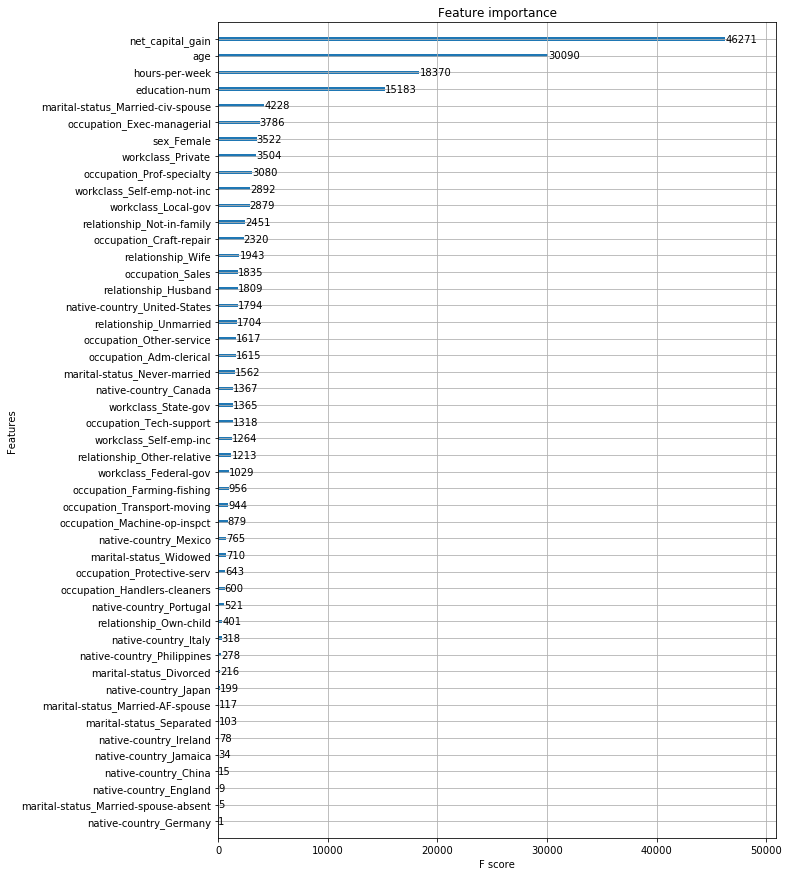

In [35]:
# # Feature importance
# print(xgb.feature_importances_)

# Built in function that uses F-scores to rank
fig, ax = plt.subplots(1, 1, figsize=(10,15))
plot_importance(xgb, ax=ax)
plt.show()

### Model: LightGBM

In [109]:
# IMPORT DATA 1
TRAIN_RPATH = "dump/data/train_vld-nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_train, nopp_vld, y_train, y_vld = pkl.load(f)
    
TEST_RPATH = "dump/data/test-nopp.pkl"
with open(TEST_RPATH, "rb") as f:
    nopp_test = pkl.load(f)

print(nopp_train.shape)
print(y_train.shape)
print(nopp_vld.shape)
print(y_vld.shape)
print(nopp_test.shape)

(18315, 100)
(18315,)
(6106, 100)
(6106,)
(24421, 100)


In [39]:
## MODEL 1
params_lgbm = {
    'reg_lambda': 100,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 10,
    'n_estimators': 10000,
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False
}
lgbm = lgb.LGBMClassifier(**params_lgbm, random_state=RAND_STATE)

runL0Model(lgbm, nopp_alltrain, y_alltrain,
           "stack1/nopp_lgbm1.pkl", nopp_test)

Fold 0
Train set:
[[14048   800]
 [ 1500  3188]]
Accuracy = 0.88227, F1 = 0.73490
Validation set:
[[3517  195]
 [ 407  766]]
Accuracy = 0.87677, F1 = 0.71790

Fold 1
Train set:
[[14033   815]
 [ 1473  3216]]
Accuracy = 0.88289, F1 = 0.73761
Validation set:
[[3463  249]
 [ 394  778]]
Accuracy = 0.86835, F1 = 0.70759

Fold 2
Train set:
[[14062   786]
 [ 1466  3223]]
Accuracy = 0.88473, F1 = 0.74109
Validation set:
[[3490  222]
 [ 409  763]]
Accuracy = 0.87080, F1 = 0.70746

Fold 3
Train set:
[[14031   817]
 [ 1485  3204]]
Accuracy = 0.88217, F1 = 0.73571
Validation set:
[[3489  223]
 [ 391  781]]
Accuracy = 0.87428, F1 = 0.71783

Fold 4
Train set:
[[14056   792]
 [ 1497  3192]]
Accuracy = 0.88284, F1 = 0.73608
Validation set:
[[3468  244]
 [ 361  811]]
Accuracy = 0.87613, F1 = 0.72833

Consolidated validation folds:
Accuracy = 0.87326, F1 = 0.71587
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/nopp_lgbm1.pkl


In [40]:
## MODEL 2
params_lgbm = {
    'reg_lambda': 100,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 10,
    'n_estimators': 10000,
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False,
    'scale_pos_weight': 3 # class imbalance
}
lgbm = lgb.LGBMClassifier(**params_lgbm, random_state=RAND_STATE)

runL0Model(lgbm, nopp_alltrain, y_alltrain,
           "stack1/nopp_lgbm2.pkl", nopp_test)

Fold 0
Train set:
[[12499  2349]
 [  539  4149]]
Accuracy = 0.85217, F1 = 0.74182
Validation set:
[[3139  573]
 [ 173 1000]]
Accuracy = 0.84729, F1 = 0.72833

Fold 1
Train set:
[[12509  2339]
 [  521  4168]]
Accuracy = 0.85361, F1 = 0.74455
Validation set:
[[3098  614]
 [ 163 1009]]
Accuracy = 0.84091, F1 = 0.72200

Fold 2
Train set:
[[12540  2308]
 [  530  4159]]
Accuracy = 0.85474, F1 = 0.74561
Validation set:
[[3090  622]
 [ 176  996]]
Accuracy = 0.83661, F1 = 0.71398

Fold 3
Train set:
[[12515  2333]
 [  531  4158]]
Accuracy = 0.85341, F1 = 0.74383
Validation set:
[[3087  625]
 [ 170 1002]]
Accuracy = 0.83722, F1 = 0.71597

Fold 4
Train set:
[[12497  2351]
 [  543  4146]]
Accuracy = 0.85187, F1 = 0.74128
Validation set:
[[3060  652]
 [ 144 1028]]
Accuracy = 0.83702, F1 = 0.72090

Consolidated validation folds:
Accuracy = 0.83981, F1 = 0.72021
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/nopp_lgbm2.pkl


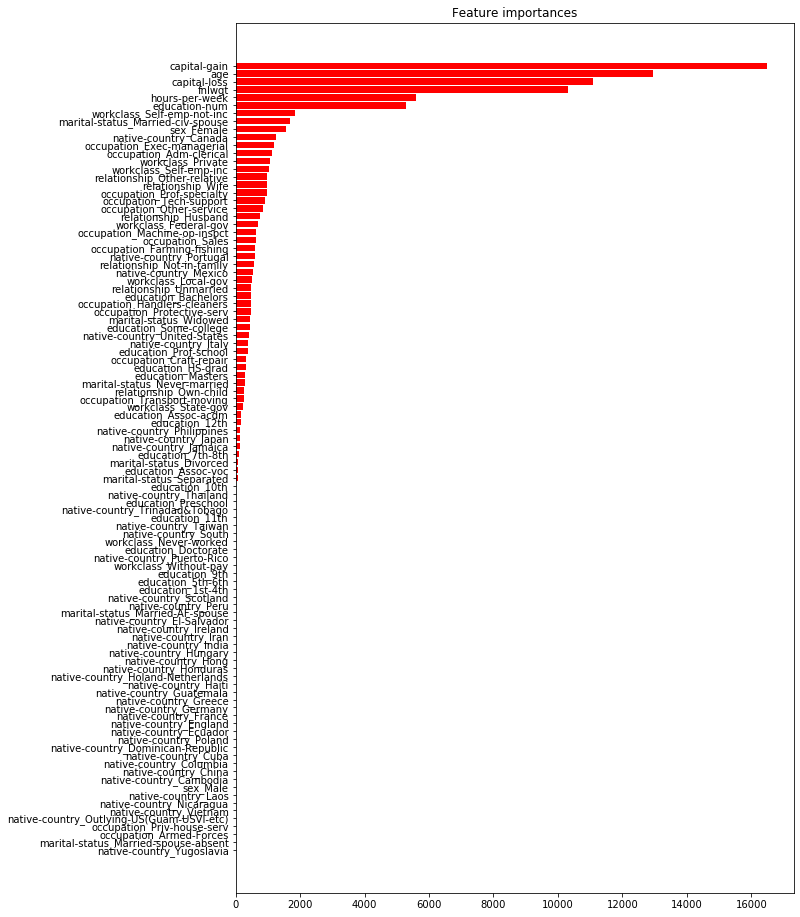

In [113]:
importances = lgbm1.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(nopp_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

### Model: KNN

In [15]:
## KNN
### Try different preprocessing for KNN
### E.g. Selecting features and PCA

## Drop native country
## How to encode categorical variables and standard scaling
## PCA

## Scaling features causes accuracy to decrease
## Net capital gain is an important feature that should be weighted more

In [ ]:
# IMPORT DATA 1
TRAIN_RPATH = "dump/data/train_vld-nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_train, nopp_vld, y_train, y_vld = pkl.load(f)
    
TEST_RPATH = "dump/data/test-nopp.pkl"
with open(TEST_RPATH, "rb") as f:
    nopp_test = pkl.load(f)

print(nopp_train.shape)
print(y_train.shape)
print(nopp_vld.shape)
print(y_vld.shape)
print(nopp_test.shape)

In [41]:
## IMPORT DATA 2
TRAIN_RPATH = "dump/data/wxpp_alltrain.pkl"
with open(TRAIN_RPATH, "rb") as f:
    wxpp_alltrain, y_alltrain = pkl.load(f)
    
TEST_RPATH = "dump/data/wxpp_test.pkl"
with open(TEST_RPATH, "rb") as f:
    wxpp_test = pkl.load(f)
    
print(wxpp_alltrain.shape)
print(y_alltrain.shape)
print(wxpp_test.shape)

(24421, 82)
(24421,)
(24421, 82)


In [42]:
## KNN DATA 1
params_knn = {
    "n_neighbors": 10,
    "metric": "euclidean"
}
knn = KNeighborsClassifier(**params_knn)

runL0Model(knn, nopp_alltrain, y_alltrain,
           "stack1/wxpp_knn1.pkl", nopp_test)

Fold 0
Train set:
[[14628   220]
 [ 3498  1190]]
Accuracy = 0.80968, F1 = 0.39029
Validation set:
[[3628   84]
 [ 921  252]]
Accuracy = 0.79427, F1 = 0.33400

Fold 1
Train set:
[[14639   209]
 [ 3500  1189]]
Accuracy = 0.81016, F1 = 0.39067
Validation set:
[[3629   83]
 [ 933  239]]
Accuracy = 0.79197, F1 = 0.31995

Fold 2
Train set:
[[14636   212]
 [ 3525  1164]]
Accuracy = 0.80872, F1 = 0.38384
Validation set:
[[3638   74]
 [ 908  264]]
Accuracy = 0.79894, F1 = 0.34967

Fold 3
Train set:
[[14643   205]
 [ 3537  1152]]
Accuracy = 0.80847, F1 = 0.38108
Validation set:
[[3633   79]
 [ 919  253]]
Accuracy = 0.79566, F1 = 0.33644

Fold 4
Train set:
[[14646   202]
 [ 3551  1138]]
Accuracy = 0.80790, F1 = 0.37751
Validation set:
[[3647   65]
 [ 903  269]]
Accuracy = 0.80180, F1 = 0.35724

Consolidated validation folds:
Accuracy = 0.79653, F1 = 0.33949
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/wxpp_knn1.pkl


In [101]:
logi_idx = np.equal(np.array(y_pred_vld_knn), np.array(et_pred_vld))
print(np.sum(logi_idx)/len(logi_idx)) # Percentage similarity predictions

0.14225128114507862


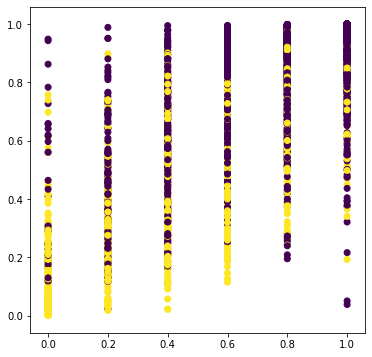

0.9252518112740767


In [102]:
# ## Load model probabilities
# with open("dump/proba/p1_et.pkl", "rb") as f:
#     et_proba_vld = pkl.load(f)

# with open("dump/proba/p1_xgb.pkl", "rb") as f:
#     xgb_proba_vld = pkl.load(f)

with open("dump/proba/p1_knn.pkl", "rb") as f:
    knn_proba_vld = pkl.load(f)

## Investigate correlation of model predictions
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(knn_proba_vld, xgb_proba_vld, c=y_vld) # 0: yellow
plt.show()

## Convert probabilities to labels
xgb_pred_vld = [0 if p <= 0.5 else 1 for p in xgb_proba_vld]
et_pred_vld = [0 if p <= 0.5 else 1 for p in et_proba_vld]

logi_idx = np.equal(np.array(xgb_pred_vld), np.array(et_pred_vld))
print(np.sum(logi_idx)/len(logi_idx)) # Percentage similarity predictions

In [ ]:
# PARAMETERS TO HANDLE CLASS IMBALANCE
# scale_pos_weight parameter? (results in funny prediction probabilities)
# to avoid that set max_delta_step
# GET A ROUGH IDEA OF GOOD PARAMETERS AND THEN SELECT FEATURES AND NORMALISE FEATURES

# OBSERVE FOR OVERFITTING
# HOW TO AVOID OVERFITTING?
# DECREASE MODEL COMPLEXITIYY
# ADD RANDOMNESS
# https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

In [ ]:
# CLASS IMBALANCE?
# THERE IS A GROUP OF POSITIVE SAMPLES THAT ARE HARD TO DIFFERENTIATE
# PCA LOADINGS? CHECK WHICH FEATURES ARE HEAVILY LOADED?

In [ ]:
# # select features using threshold
# selection = SelectFromModel(model, threshold=thresh, prefit=True)
# select_X_train = selection.transform(X_train)
# # train model
# selection_model = XGBClassifier()
# selection_model.fit(select_X_train, y_train)
# # eval model
# select_X_test = selection.transform(X_test)
# y_pred = selection_model.predict(select_X_test)

In [83]:
# # Model: XGBoost
# # Not sklearn API

# # Convert data
# dmat_train = xgb.DMatrix(X_train, y_train)
# dmat_vld = xgb.DMatrix(X_vld, y_vld)

# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
# num_round = 2
# watchlist = [(dmat_train, 'eval'), (dmat_train, 'train')]
# bst = xgb.train(param, dmat_train, num_round, watchlist)

[0]	eval-error:0.17586	train-error:0.17586
[1]	eval-error:0.16390	train-error:0.16390
